In [1]:
# Parameters
var_list = [
    "cape",
    "crr",
    "d",
    "ie",
    "ishf",
    "lsrr",
    "pv",
    "q",
    "r",
    "sp",
    "tcw",
    "tcwv",
    "t",
    "ttr",
    "u",
    "v",
    "vo",
    "w",
]
plevel_list = [
    False,
    False,
    850,
    False,
    False,
    False,
    850,
    850,
    850,
    False,
    False,
    False,
    850,
    False,
    850,
    850,
    850,
    850,
]
aew_subset = "12hr_before"
model_save_name = "best_model_8502.keras"
tuner_project_name = "tuner_run_8502"


In [2]:
#!/usr/bin/env python

# coding: utf-8


import numpy as np

import matplotlib.pyplot as plt

import xarray as xr

import sklearn

import sklearn.model_selection

import keras

from keras import layers

import keras_tuner



import tensorflow as tf

import tensorflow.keras.backend as K

keras.utils.set_random_seed(812)

2025-08-05 18:17:34.208752: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-05 18:17:34.381481: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754439454.436343  129479 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754439454.449498  129479 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754439454.552932  129479 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
import tensorflow as tf

def focal_loss(gamma=2.0, alpha=0.25):
    """Focal Loss for binary classification."""
    def loss_fn(y_true, y_pred):
        # Clip to prevent NaNs 
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        modulating_factor = tf.pow(1.0 - p_t, gamma)
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        return alpha_factor * modulating_factor * bce
    return loss_fn


In [4]:
#functions to calculate f1 score as loss function

def f1_loss_sigmoid(y_true, y_pred):
    """

    F1 metric for sigmoid output and integer encoded labels.

"""

    # compute tp, fp, and fn

    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)

    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)

    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)


    # precision (tp / (tp + fp))

    p = tp / (tp + fp + K.epsilon())

   # recall (tp / (tp + fn))

    r = tp / (tp + fn + K.epsilon())


# harmonic mean of precision and recall

    f1 = (2 * p * r) / (p + r + K.epsilon())

    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)

    return 1 - K.mean(f1)

In [5]:
def f1_loss_onehot(y_true, y_pred):

   """

   F1 metric for two-class output and one-hot encoded labels.

   """

   # compute tp, fp, and fn

   tp = K.sum(K.cast(y_true[:, 1] * y_pred[:, 1], 'float'), axis=0)

   fp = K.sum(K.cast((1 - y_true[:, 1]) * y_pred[:, 1], 'float'), axis=0)

   fn = K.sum(K.cast(y_true[:, 0] * (1 - y_pred[:, 0]), 'float'), axis=0)


   # precision (tp / (tp + fp))

   p = tp / (tp + fp + K.epsilon())

   # recall (tp / (tp + fn))

   r = tp / (tp + fn + K.epsilon())


   # harmonic mean of precision and recall

   f1 = (2 * p * r) / (p + r + K.epsilon())

   f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)

   return 1 - K.mean(f1)

In [6]:
import re


def add_dim(ds):
    # Extract the source file name from the dataset's encoding.
    fname = ds.encoding.get('source', '')
    # Use a regex to capture the central latitude and longitude from the filename.
    m = re.search(r'_(\-?\d+\.\d+)_(-?\d+\.\d+)\.nc$', fname)
    if m:
        lat_center = float(m.group(1))
        lon_center = float(m.group(2))
        # Assign the central coordinates and the file name as new coordinates.
        ds = ds.assign_coords(lat_center=lat_center, lon_center=lon_center, file_name=fname)
    else:
        print("File name does not match expected pattern:", fname)
    
    # Expand dims to add the 'sample' dimension and drop unnecessary variables.
    return ds.assign_coords({"sample": 1}).expand_dims(dim={"sample": 1}).drop_vars("utc_date").drop_vars("latitude").drop_vars("longitude")




    

In [7]:
import os
import xarray as xr

def open_files_zarr(list_of_vars, aew_subset="12hr_before",
                    directory="/glade/derecho/scratch/rmandava/AEW_time_location_files/",
                    plevel_list=None, zarr_store_path="zarr_data"):
    """
    Opens ERA5 NetCDF files for the given variables. For each variable (or pressure-level variant),
    it checks if a corresponding Zarr store exists in 'zarr_store_path'. If so, it loads the dataset
    from the Zarr store; if not, it opens the NetCDF files, preprocesses them, saves them to Zarr,
    and then returns the dataset.
    """
    # Create the zarr_store_path directory if it doesn't exist.
    if not os.path.exists(zarr_store_path):
        os.makedirs(zarr_store_path)
    
    datas = {}
    for num, var in enumerate(list_of_vars):
        # Determine the key and filename based on whether a pressure level is specified.
        if plevel_list:
            if plevel_list[num]:
                key = f"{var}_{int(plevel_list[num])}"
                file_pattern = f'{directory}/{var}/aew_{aew_subset}_{int(plevel_list[num])}_*.nc'
            else:
                key = var
                file_pattern = f'{directory}/{var}/aew_{aew_subset}_*.nc'
        else:
            key = var
            file_pattern = f'{directory}/{var}/aew_{aew_subset}_*.nc'
        
        # Define the zarr path for this variable.
        zarr_path = os.path.join(zarr_store_path, f"{key}.zarr")
        
        # If the Zarr dataset exists, load from it; otherwise, create it.
        if os.path.exists(zarr_path):
            print(f"Loading {key} from Zarr store.")
            ds = xr.open_zarr(zarr_path)
        else:
            print(f"Creating Zarr store for {key} from NetCDF files.")
            ds = xr.open_mfdataset(
                file_pattern,
                preprocess=add_dim,
                concat_dim="sample",
                combine="nested",
            )
            ds.to_zarr(zarr_path, mode="w")
        datas[key] = ds
    
    return datas


In [8]:
def transpose_load_concat(data_dictionary):
    # Instead of eagerly converting to NumPy arrays, keep the datasets as xarray objects.
    transposed = {}
    for key, ds in data_dictionary.items():
        var_name = key.split('_')[0].upper()
        # Do lazy transpose and add a 'features' dimension
        transposed[key] = ds[var_name].expand_dims('features').transpose('sample', 'latitude', 'longitude', 'features')
    # Concatenate along the new 'features' dimension (if multiple variables exist)
    if len(transposed) > 1:
        data = xr.concat(list(transposed.values()), dim='features',coords='minimal',compat='override')
    else:
        data = list(transposed.values())[0]
    # Use the coordinates (lat_center, lon_center) from one of the datasets.
    # They remain lazy and are not computed until needed.
    first_key = next(iter(data_dictionary))
    lat_center = data_dictionary[first_key]['lat_center']
    lon_center = data_dictionary[first_key]['lon_center']
    label = data_dictionary[first_key]['label']
    return data, label, lat_center, lon_center



In [9]:
def omit_nans(data, label, lat, lon):
    # If data is an xarray DataArray, convert it to a NumPy array
    if hasattr(data, 'values'):
        data = data.values
    maskarray = np.full(data.shape[0], True)
    # Find indices where NaNs occur
    masker = np.unique(np.argwhere(np.isnan(data))[:, 0])
    maskarray[masker] = False

    traindata = data[maskarray, ...]
    trainlabel = label[maskarray]
    lat_filtered = lat[maskarray]
    lon_filtered = lon[maskarray]
    return traindata, trainlabel, lat_filtered, lon_filtered



In [10]:
def zscore(data):

  """

  Rescaling the data using zscore (mean/std).

  Each variable gets scaled independently from others.

  Note that we will need to remove test data for formal training.

  """

  for i in range(0, data_.shape[-1]):

      data_[:, :, :, i] = (

               data_[:, :, :, i] - np.nanmean(

                     data_[:, :, :, i])) / np.nanstd(data_[:, :, :, i])

  return data_

In [11]:
def minmax(data):

   """

   Rescaling the data using min-max.

   Each variable gets scaled independently from others.

   Note that we will need to remove test data for formal training.

   """

   for i in range(0, data_.shape[-1]):

          data_[:, :, :, i] = (

              data_[:, :, :, i] - np.nanmin(data_[:, :, :, i])

          ) / (np.nanmax(data_[:, :, :, i]) - np.nanmin(data_[:, :, :, i]))
   return data

In [12]:
def random_split(data, label, split=0.3, seed=0):

   """

   Help spliting data randomly for training and testing.

   """

   np.random.seed(0)

   da_indx = np.random.permutation(data.shape[0])

   data = data[da_indx.astype(int)]

   label = label[da_indx.astype(int)]

   init_range = int(data.shape[0] * (1 - 0.3))

   return data[:init_range], label[:init_range], data[init_range:], label[init_range:]

In [13]:
def pick_loss(loss_string):
    

    lossdict = {
        "relu": tf.nn.relu,
        "tanh": tf.nn.tanh,
        "selu": tf.nn.selu,
        "sigmoid": tf.nn.sigmoid,
        "relu6": tf.nn.relu6,
        "silu": tf.nn.silu,
        "gelu": tf.nn.gelu,
        "lrelu": tf.nn.leaky_relu,
    }

    return lossdict[loss_string]

In [14]:
def compute_saliency_map(model, input_sample):
    """
    Compute a saliency map for a given input sample using a gradient-based approach.
    
    Args:
        model (tf.keras.Model): The trained Keras model.
        input_sample (numpy array): A single input sample of shape (1, height, width, channels).
    
    Returns:
        saliency (numpy array): The saliency map of shape (height, width).
    """
    # Ensure the model is in inference mode
    model.trainable = False
    input_tensor = tf.convert_to_tensor(input_sample)
    
    # Use GradientTape to record operations for automatic differentiation
    with tf.GradientTape() as tape:
        # Watch the input tensor
        tape.watch(input_tensor)
        # Get the model's prediction
        prediction = model(input_tensor)
    
    # Compute gradients of the prediction with respect to the input
    grads = tape.gradient(prediction, input_tensor)
    
    # If there are multiple channels, take the maximum absolute gradient across channels
    saliency = np.max(np.abs(grads.numpy()), axis=-1)[0]
    return saliency

In [15]:
def compute_saliency_per_channel(model, input_sample):
    """
    Computes the saliency map for each channel of a given input sample.
    
    Args:
        model (tf.keras.Model): The trained Keras model.
        input_sample (numpy array): A single input sample with shape (1, H, W, C).
        
    Returns:
        saliency_maps (numpy array): Absolute gradients with shape (H, W, C) for each channel.
        channel_importance (numpy array): Mean saliency per channel (shape: (C,)).
    """
    # Set the model to inference mode
    model.trainable = False
    input_tensor = tf.convert_to_tensor(input_sample)
    
    # Compute gradients with respect to the input sample using GradientTape
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        prediction = model(input_tensor)
    
    # Calculate gradients: shape (1, H, W, C)
    grads = tape.gradient(prediction, input_tensor)
    
    # Remove the batch dimension: shape becomes (H, W, C)
    grads = grads.numpy()[0]
    
    # Take absolute value to measure importance (magnitude of sensitivity)
    saliency_maps = np.abs(grads)
    
    # Aggregate saliency per channel (e.g., using the mean over spatial dimensions)
    channel_importance = np.mean(saliency_maps, axis=(0, 1))
    
    return saliency_maps, channel_importance

In [16]:
number_of_features = len(var_list)

In [17]:
data = open_files_zarr(
    list_of_vars=var_list,
    aew_subset=aew_subset,
    directory="/glade/derecho/scratch/rmandava/AEW_time_location_files/",
    plevel_list=plevel_list,
    zarr_store_path="/glade/derecho/scratch/rmandava/AEW_time_location_files/Project1/zarr"
)






Loading cape from Zarr store.
Loading crr from Zarr store.
Loading d_850 from Zarr store.
Loading ie from Zarr store.
Loading ishf from Zarr store.
Loading lsrr from Zarr store.
Loading pv_850 from Zarr store.
Loading q_850 from Zarr store.
Loading r_850 from Zarr store.
Loading sp from Zarr store.
Loading tcw from Zarr store.
Loading tcwv from Zarr store.
Loading t_850 from Zarr store.
Loading ttr from Zarr store.
Loading u_850 from Zarr store.
Loading v_850 from Zarr store.
Loading vo_850 from Zarr store.
Loading w_850 from Zarr store.


Loading pv_850 from Zarr store.
Loading q_850 from Zarr store.
Loading r_850 from Zarr store.
Loading sp from Zarr store.
Loading tcw from Zarr store.


Loading tcwv from Zarr store.
Loading t_850 from Zarr store.
Loading ttr from Zarr store.
Loading u_850 from Zarr store.
Loading v_850 from Zarr store.
Loading vo_850 from Zarr store.


Loading w_850 from Zarr store.


In [18]:
# transpose the data and concat variables

#data_, labels_ = transpose_load_concat(data)
data_, labels_, sample_lat, sample_lon = transpose_load_concat(data)

print(np.shape(data_))

(2750, 32, 32, 18)


In [20]:
import numpy as np

# Get actual variable names from xarray
crr_key = [k for k in data.keys() if 'crr' in k][0]
lsrr_key = [k for k in data.keys() if 'lsrr' in k][0]

# Extract data arrays
crr_raw = data[crr_key]['CRR']  # or data[crr_key].data
lsrr_raw = data[lsrr_key]['LSRR']

# Compute explicitly to get concrete results
has_neg_crr = (crr_raw < 0).any().compute()
has_neg_lsrr = (lsrr_raw < 0).any().compute()

print("Negative values in CRR:", bool(has_neg_crr.values))
print("Negative values in LSRR:", bool(has_neg_lsrr.values))


Negative values in CRR: False
Negative values in LSRR: False


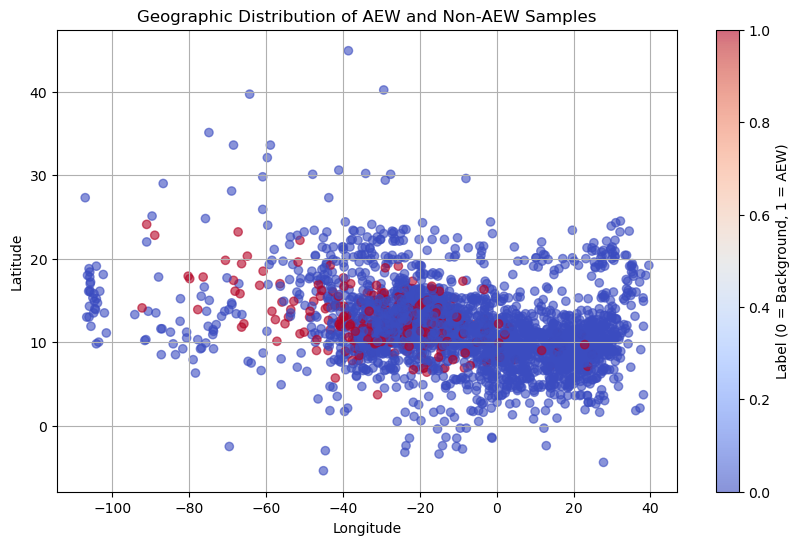

In [19]:
import matplotlib.pyplot as plt

# Scatter plot: where are the samples located, colored by label (AEW or not)
plt.figure(figsize=(10, 6))
sc = plt.scatter(sample_lon, sample_lat, c=labels_, cmap='coolwarm', alpha=0.6)
plt.colorbar(sc, label="Label (0 = Background, 1 = AEW)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Geographic Distribution of AEW and Non-AEW Samples")
plt.grid(True)
plt.show()


In [20]:
print(var_list)


['cape', 'crr', 'd', 'ie', 'ishf', 'lsrr', 'pv', 'q', 'r', 'sp', 'tcw', 'tcwv', 't', 'ttr', 'u', 'v', 'vo', 'w']


In [21]:
# check / remove nans

data_, labels_, sample_lat, sample_lon = omit_nans(data_, labels_, sample_lat, sample_lon)






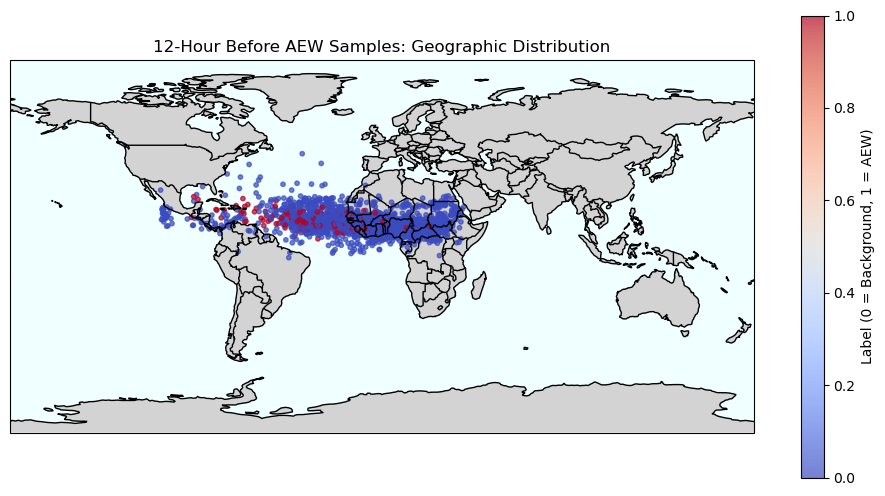

In [22]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.figure(figsize=(12, 6))

# Set up map projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='azure')

# Plot sample locations colored by label
sc = ax.scatter(sample_lon, sample_lat, c=labels_, cmap='coolwarm', s=10, alpha=0.7, transform=ccrs.PlateCarree())
plt.colorbar(sc, ax=ax, label="Label (0 = Background, 1 = AEW)")
plt.title("12-Hour Before AEW Samples: Geographic Distribution")
plt.show()

In [23]:
print("Total samples:", len(sample_lat))


Total samples: 2750


In [24]:
print("Latitude Range:", float(sample_lat.min().compute()), "to", float(sample_lat.max().compute()))
print("Longitude Range:", float(sample_lon.min().compute()), "to", float(sample_lon.max().compute()))


Latitude Range: -5.4 to 44.9
Longitude Range: -107.1 to 39.6


In [25]:
#split train and test set
X_train, X_test, y_train, y_test, lat_train, lat_test, lon_train, lon_test = sklearn.model_selection.train_test_split(
    data_, labels_, sample_lat, sample_lon, test_size=0.2, random_state=42)



print (np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test))


y_train = np.expand_dims(y_train, axis=1)

y_test = np.expand_dims(y_test, axis=1)

(2200, 32, 32, 18) (550, 32, 32, 18) (2200,) (550,)


/glade/u/home/rmandava/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1642: PerformanceWarning: Slicing with an out-of-order index is generating 412 times more chunks
  return self.array[key]
/glade/u/home/rmandava/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1642: PerformanceWarning: Slicing with an out-of-order index is generating 109 times more chunks
  return self.array[key]


In [26]:
# [21]: Scaling code (fixed to prevent data leakage)

# Create the scaler object
scaler_input = sklearn.preprocessing.StandardScaler()

# Reshape training data to 2D (samples, features)
X_train_tmp = np.reshape(X_train, (-1, len(var_list)))

# Fit the scaler ONLY on the training data
scaler_input.fit(X_train_tmp)  # <-- Key change: Learn mean/std from training data

# Transform BOTH training and test data using the SAME scaler
input_train_scaled = scaler_input.transform(X_train_tmp)          # Train: transform only
input_test_scaled = scaler_input.transform(                       # Test: transform only
    np.reshape(X_test, (-1, len(var_list)))
)

# Reshape back to original dimensions (samples, height, width, features)
input_train_scaled = np.reshape(input_train_scaled, X_train.shape)
input_test_scaled = np.reshape(input_test_scaled, X_test.shape)

# Labels remain unchanged
label_train_scaled = y_train
label_test_scaled = y_test

In [27]:
# print the shapes to double check them

print(

input_train_scaled.shape,

label_train_scaled.shape,

input_test_scaled.shape,

label_test_scaled.shape

)

(2200, 32, 32, 18) (2200, 1) (550, 32, 32, 18) (550, 1)


In [28]:
#generate class weights due to class imbalance issues

counts = np.bincount(y_train[:, 0].astype(int))


print(

"Number of positive samples in training data: {} ({:.2f}% of total)".format(

counts[1], 100 * float(counts[1]) / len(y_train))

)

Number of positive samples in training data: 204 (9.27% of total)


In [29]:
# old weights

# weight_for_0 = 1.0 / counts[0]

# weight_for_1 = 1.0 / counts[1]


#new weights

weight_for_0 = float(counts[1]) / len(y_train)

weight_for_1 = 1 - (float(counts[1]) / len(y_train))


class_weight = {0: weight_for_0, 1: weight_for_1}

print(class_weight)

{0: 0.09272727272727273, 1: 0.9072727272727272}


In [30]:
METRICS = [

keras.metrics.BinaryCrossentropy(name='cross entropy'),

keras.metrics.MeanSquaredError(name='mean_squared_error'),

keras.metrics.RootMeanSquaredError(name='root_mean_squared_error'),

keras.metrics.TruePositives(name='tp'),

keras.metrics.FalsePositives(name='fp'),

keras.metrics.TrueNegatives(name='tn'),

keras.metrics.FalseNegatives(name='fn'),

keras.metrics.BinaryAccuracy(name='binary_accuracy'),

keras.metrics.F1Score(threshold=0.5, name='f1_score'),

keras.metrics.Precision(name='precision'),

keras.metrics.Recall(name='recall'),

keras.metrics.AUC(name='auc'),

keras.metrics.AUC(name='prc', curve='PR'),

]

2025-07-09 11:52:24.161917: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [31]:
class MyHyperModel(keras_tuner.HyperModel):
    def build(self, hp):
        model = keras.Sequential()

        model.add(keras.Input(shape=(32, 32, number_of_features)))

        # Data augmentation
        model.add(layers.RandomFlip("horizontal_and_vertical"))
        model.add(layers.RandomRotation(factor=(-0.5, 0.5)))

        # CNN layers (same tuning as before)
        featmaps1 = hp.Int('units_1', min_value=10, max_value=60)
        featmaps2 = hp.Int('units_2', min_value=10, max_value=64)
        featmaps3 = hp.Int('units_3', min_value=10, max_value=128)
        featmaps4 = hp.Int('units_4', min_value=10, max_value=80)
        learning_rate = hp.Float('lr', min_value=0.00001, max_value=0.01, sampling="linear")
        act_func = hp.Choice('activation', ["relu", "tanh", "selu", "sigmoid", "relu6", "silu", "gelu"])

        model.add(layers.Conv2D(featmaps1, 3, strides=1, padding="same", activation=pick_loss(act_func)))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Dropout(0.2))

        model.add(layers.Conv2D(featmaps2, 3, strides=1, padding="same", activation=pick_loss(act_func)))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Dropout(0.2))

        model.add(layers.Conv2D(featmaps3, 3, strides=1, padding="same", activation=pick_loss(act_func)))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Dropout(0.2))

        model.add(layers.GlobalMaxPooling2D())
        model.add(layers.Dense(featmaps4))
        model.add(layers.Dense(1, activation="sigmoid"))

        
        

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss=focal_loss(gamma=2.0, alpha=0.25),  # pass tuned gamma and alpha!
            metrics=METRICS
        )

        return model



In [32]:
def fit(self, hp, model, *args, **kwargs):
    batchsizenum = hp.Int('batch_size', min_value=10, max_value=60, step=5, sampling="linear")

    print({k: hp.get(k) if hp.is_active(k) else None for k in hp._hps})

    return model.fit(
        *args,
        batch_size=batchsizenum,
        # normally we might use early stopping, but not needed since
        # callbacks saves checkpoints of the model during trials
        # callbacks=keras.callbacks.EarlyStopping('val_loss', patience=5),
        validation_split=0.1,
        shuffle=True,
        class_weight=class_weight,
        **kwargs,
    )


In [33]:
# make the tuner object
tuner = keras_tuner.BayesianOptimization(
    hypermodel=MyHyperModel(),
    objective=keras_tuner.Objective("val_f1_score", direction="max"),
    max_trials=150,
    project_name=tuner_project_name,
    alpha=0.0001,
    beta=2.6,
    seed=123,
    tune_new_entries=True,
    allow_new_entries=True,
    max_retries_per_trial=1,
    max_consecutive_failed_trials=3,
    overwrite=True,
)

# summary
tuner.search_space_summary()


Search space summary
Default search space size: 6
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 60, 'step': 1, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 64, 'step': 1, 'sampling': 'linear'}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 128, 'step': 1, 'sampling': 'linear'}
units_4 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 80, 'step': 1, 'sampling': 'linear'}
lr (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'selu', 'sigmoid', 'relu6', 'silu', 'gelu'], 'ordered': False}


In [34]:
import numpy as np

labels_np = np.array(labels_)

total = len(labels_np)
positives = np.sum(labels_np == 1)
negatives = np.sum(labels_np == 0)

print("Total samples:", total)
print("AEW-positive samples (label=1):", positives)
print("Background samples (label=0):", negatives)


Total samples: 2750
AEW-positive samples (label=1): 258
Background samples (label=0): 2492


In [35]:
# Begin the search
EPOCHS = 100

tuner.search(
    input_train_scaled,
    label_train_scaled,
    epochs=EPOCHS,
    validation_split=0.1
)

# Query the tuner object to grab the best models
models = tuner.get_best_models(num_models=5)

# Here is the best model from the tuner
best_model = models[0]
print(best_model.summary())

# Get the top hyperparameters.
best_hps = tuner.get_best_hyperparameters()

# Build the model with the best hyperparameters.
# Assuming your MyHyperModel has a build method that takes a hyperparameter object.
model = MyHyperModel().build(best_hps[0])

# Save the best model (architecture and weights)

save_dir = "/glade/derecho/scratch/rmandava/AEW_time_location_files/models"
model_save_path = os.path.join(save_dir, model_save_name)

model.save(model_save_path)


# Retrain using "best" model hyperparameters
history = model.fit(
    input_train_scaled,
    label_train_scaled,
    epochs=EPOCHS,
    validation_split=0.1,
    batch_size= 32,
    # callbacks=keras.callbacks.EarlyStopping('val_loss', patience=3),
    shuffle=True,
    class_weight=class_weight,  # Ensure 'class_weight' is defined in your scope
)

# Evaluate the model on the test data using `evaluate`
results = model.evaluate(input_test_scaled, label_test_scaled, batch_size=label_test_scaled.shape[0])
print(results)

# Generate predictions (probabilities—the output of the last layer)
predictions = model.predict(input_test_scaled)
print("predictions shape:", predictions.shape)

# Compute confusion matrix elements
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(
    label_test_scaled, np.round(predictions)
).ravel()
print("tn:", tn)
print("fp:", fp)
print("fn:", fn)
print("tp:", tp)


Trial 150 Complete [00h 01m 34s]
val_f1_score: 0.5925925970077515

Best val_f1_score So Far: 0.714285671710968
Total elapsed time: 03h 47m 41s


/glade/u/home/rmandava/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)             │ (None, 32, 32, 18)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 32, 32, 18)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 47)          │           7,661 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 47)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 47)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          27,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 100)           │          57,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 100)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 100)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 100)                 │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 43)                  │           4,343 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              44 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 96,884 (378.45 KB)

 Trainable params: 96,884 (378.45 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - auc: 0.8647 - binary_accuracy: 0.9484 - cross entropy: 0.2074 - f1_score: 0.5517 - fn: 7.0000 - fp: 6.0000 - loss: 0.0142 - mean_squared_error: 0.0557 - prc: 0.4017 - precision: 0.5714 - recall: 0.5333 - root_mean_squared_error: 0.2361 - tn: 231.0000 - tp: 8.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7913 - binary_accuracy: 0.8746 - cross entropy: 0.3253 - f1_score: 0.3306 - fn: 10.6000 - fp: 30.0000 - loss: 0.0335 - mean_squared_error: 0.0953 - prc: 0.2058 - precision: 0.2743 - recall: 0.4656 - root_mean_squared_error: 0.3066 - tn: 266.6000 - tp: 8.8000

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7795 - binary_accuracy: 0.8728 - cross entropy: 0.3311 - f1_score: 0.3015 - fn: 14.3333 - fp: 34.6667 - loss: 0.0300 - mean_squared_error: 0.0974 - prc: 0.1865 - precision: 0.2454 - recall: 0.4190 - root_mean_squared_error: 0.3110 - tn: 321.3333 - tp: 9.6667

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7791 - binary_accuracy: 0.8614 - cross entropy: 0.3453 - f1_score: 0.3063 - fn: 16.9231 - fp: 46.9231 - loss: 0.0275 - mean_squared_error: 0.1034 - prc: 0.1960 - precision: 0.2420 - recall: 0.4422 - root_mean_squared_error: 0.3205 - tn: 366.4615 - tp: 13.6923

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7739 - binary_accuracy: 0.8451 - cross entropy: 0.3619 - f1_score: 0.3003 - fn: 19.4706 - fp: 64.3529 - loss: 0.0259 - mean_squared_error: 0.1105 - prc: 0.1999 - precision: 0.2306 - recall: 0.4590 - root_mean_squared_error: 0.3310 - tn: 406.8824 - tp: 17.2941

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7665 - binary_accuracy: 0.8372 - cross entropy: 0.3748 - f1_score: 0.2925 - fn: 23.6190 - fp: 75.8571 - loss: 0.0247 - mean_squared_error: 0.1156 - prc: 0.2004 - precision: 0.2226 - recall: 0.4505 - root_mean_squared_error: 0.3385 - tn: 453.0000 - tp: 19.5238

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7591 - binary_accuracy: 0.8313 - cross entropy: 0.3886 - f1_score: 0.2840 - fn: 30.5385 - fp: 86.5000 - loss: 0.0236 - mean_squared_error: 0.1210 - prc: 0.2008 - precision: 0.2171 - recall: 0.4304 - root_mean_squared_error: 0.3463 - tn: 513.1154 - tp: 21.8462

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7561 - binary_accuracy: 0.8277 - cross entropy: 0.3988 - f1_score: 0.2834 - fn: 35.9355 - fp: 97.5806 - loss: 0.0226 - mean_squared_error: 0.1249 - prc: 0.2031 - precision: 0.2169 - recall: 0.4256 - root_mean_squared_error: 0.3519 - tn: 573.2581 - tp: 25.2258

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7557 - binary_accuracy: 0.8255 - cross entropy: 0.4046 - f1_score: 0.2847 - fn: 40.4722 - fp: 108.7500 - loss: 0.0216 - mean_squared_error: 0.1271 - prc: 0.2062 - precision: 0.2177 - recall: 0.4256 - root_mean_squared_error: 0.3551 - tn: 633.9722 - tp: 28.8056

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7568 - binary_accuracy: 0.8243 - cross entropy: 0.4077 - f1_score: 0.2875 - fn: 44.8537 - fp: 119.1219 - loss: 0.0209 - mean_squared_error: 0.1283 - prc: 0.2102 - precision: 0.2200 - recall: 0.4274 - root_mean_squared_error: 0.3570 - tn: 695.3903 - tp: 32.6341

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7587 - binary_accuracy: 0.8236 - cross entropy: 0.4098 - f1_score: 0.2920 - fn: 48.0222 - fp: 127.6444 - loss: 0.0203 - mean_squared_error: 0.1291 - prc: 0.2150 - precision: 0.2235 - recall: 0.4324 - root_mean_squared_error: 0.3582 - tn: 743.8889 - tp: 36.4444

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7613 - binary_accuracy: 0.8234 - cross entropy: 0.4116 - f1_score: 0.2976 - fn: 51.4200 - fp: 138.1000 - loss: 0.0196 - mean_squared_error: 0.1298 - prc: 0.2207 - precision: 0.2277 - recall: 0.4397 - root_mean_squared_error: 0.3592 - tn: 805.3000 - tp: 41.1800

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7631 - binary_accuracy: 0.8237 - cross entropy: 0.4122 - f1_score: 0.3016 - fn: 54.1667 - fp: 145.5185 - loss: 0.0192 - mean_squared_error: 0.1300 - prc: 0.2244 - precision: 0.2309 - recall: 0.4442 - root_mean_squared_error: 0.3596 - tn: 855.6296 - tp: 44.6852

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7656 - binary_accuracy: 0.8246 - cross entropy: 0.4126 - f1_score: 0.3065 - fn: 57.3729 - fp: 154.1695 - loss: 0.0187 - mean_squared_error: 0.1301 - prc: 0.2286 - precision: 0.2349 - recall: 0.4497 - root_mean_squared_error: 0.3598 - tn: 919.4745 - tp: 48.9831

62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - auc: 0.7674 - binary_accuracy: 0.8254 - cross entropy: 0.4127 - f1_score: 0.3105 - fn: 59.9206 - fp: 160.6349 - loss: 0.0183 - mean_squared_error: 0.1301 - prc: 0.2318 - precision: 0.2383 - recall: 0.4539 - root_mean_squared_error: 0.3599 - tn: 970.3492 - tp: 52.4603 - val_auc: 0.8694 - val_binary_accuracy: 0.9136 - val_cross entropy: 0.5405 - val_f1_score: 0.4865 - val_fn: 4.0000 - val_fp: 15.0000 - val_loss: 0.0709 - val_mean_squared_error: 0.1758 - val_prc: 0.4243 - val_precision: 0.3750 - val_recall: 0.6923 - val_root_mean_squared_error: 0.4192 - val_tn: 192.0000 - val_tp: 9.0000


Epoch 2/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.9333 - binary_accuracy: 0.7812 - cross entropy: 0.5737 - f1_score: 0.3636 - fn: 0.0000e+00 - fp: 7.0000 - loss: 0.0105 - mean_squared_error: 0.1924 - prc: 0.3187 - precision: 0.2222 - recall: 1.0000 - root_mean_squared_error: 0.4387 - tn: 23.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8762 - binary_accuracy: 0.7832 - cross entropy: 0.5328 - f1_score: 0.3432 - fn: 1.3333 - fp: 21.3333 - loss: 0.0095 - mean_squared_error: 0.1753 - prc: 0.3196 - precision: 0.2182 - recall: 0.8368 - root_mean_squared_error: 0.4183 - tn: 83.0000 - tp: 6.3333   

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8596 - binary_accuracy: 0.8107 - cross entropy: 0.5023 - f1_score: 0.3577 - fn: 3.7000 - fp: 25.9000 - loss: 0.0093 - mean_squared_error: 0.1624 - prc: 0.3274 - precision: 0.2395 - recall: 0.7580 - root_mean_squared_error: 0.4023 - tn: 137.7000 - tp: 8.7000

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8503 - binary_accuracy: 0.8241 - cross entropy: 0.4859 - f1_score: 0.3781 - fn: 6.7857 - fp: 30.6429 - loss: 0.0093 - mean_squared_error: 0.1556 - prc: 0.3435 - precision: 0.2671 - recall: 0.7114 - root_mean_squared_error: 0.3937 - tn: 190.2143 - tp: 12.3571

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8481 - binary_accuracy: 0.8317 - cross entropy: 0.4764 - f1_score: 0.3926 - fn: 9.0556 - fp: 36.6111 - loss: 0.0093 - mean_squared_error: 0.1517 - prc: 0.3501 - precision: 0.2834 - recall: 0.6947 - root_mean_squared_error: 0.3888 - tn: 242.1111 - tp: 16.2222

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8448 - binary_accuracy: 0.8379 - cross entropy: 0.4696 - f1_score: 0.4057 - fn: 11.6818 - fp: 41.7273 - loss: 0.0094 - mean_squared_error: 0.1488 - prc: 0.3539 - precision: 0.2994 - recall: 0.6811 - root_mean_squared_error: 0.3851 - tn: 294.3636 - tp: 20.2273

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8431 - binary_accuracy: 0.8420 - cross entropy: 0.4653 - f1_score: 0.4191 - fn: 15.1852 - fp: 49.0741 - loss: 0.0094 - mean_squared_error: 0.1470 - prc: 0.3662 - precision: 0.3156 - recall: 0.6709 - root_mean_squared_error: 0.3828 - tn: 357.7408 - tp: 26.0000

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8442 - binary_accuracy: 0.8448 - cross entropy: 0.4634 - f1_score: 0.4294 - fn: 17.2581 - fp: 55.2903 - loss: 0.0094 - mean_squared_error: 0.1460 - prc: 0.3783 - precision: 0.3261 - recall: 0.6710 - root_mean_squared_error: 0.3816 - tn: 408.5484 - tp: 30.9032

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8454 - binary_accuracy: 0.8489 - cross entropy: 0.4596 - f1_score: 0.4398 - fn: 20.0000 - fp: 61.4722 - loss: 0.0094 - mean_squared_error: 0.1443 - prc: 0.3900 - precision: 0.3378 - recall: 0.6685 - root_mean_squared_error: 0.3793 - tn: 474.2500 - tp: 36.2778

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8464 - binary_accuracy: 0.8522 - cross entropy: 0.4557 - f1_score: 0.4482 - fn: 22.9024 - fp: 67.4390 - loss: 0.0094 - mean_squared_error: 0.1425 - prc: 0.3980 - precision: 0.3478 - recall: 0.6657 - root_mean_squared_error: 0.3770 - tn: 540.0732 - tp: 41.5854

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8484 - binary_accuracy: 0.8549 - cross entropy: 0.4525 - f1_score: 0.4566 - fn: 25.6304 - fp: 73.7609 - loss: 0.0093 - mean_squared_error: 0.1410 - prc: 0.4082 - precision: 0.3572 - recall: 0.6659 - root_mean_squared_error: 0.3750 - tn: 605.0652 - tp: 47.5435

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8500 - binary_accuracy: 0.8573 - cross entropy: 0.4493 - f1_score: 0.4629 - fn: 28.2353 - fp: 80.0196 - loss: 0.0093 - mean_squared_error: 0.1396 - prc: 0.4164 - precision: 0.3641 - recall: 0.6657 - root_mean_squared_error: 0.3731 - tn: 670.7843 - tp: 52.9608

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8513 - binary_accuracy: 0.8594 - cross entropy: 0.4461 - f1_score: 0.4678 - fn: 30.8571 - fp: 85.9821 - loss: 0.0092 - mean_squared_error: 0.1382 - prc: 0.4230 - precision: 0.3698 - recall: 0.6648 - root_mean_squared_error: 0.3712 - tn: 737.1250 - tp: 58.0357

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8525 - binary_accuracy: 0.8616 - cross entropy: 0.4431 - f1_score: 0.4720 - fn: 33.5246 - fp: 91.4262 - loss: 0.0092 - mean_squared_error: 0.1368 - prc: 0.4283 - precision: 0.3750 - recall: 0.6634 - root_mean_squared_error: 0.3694 - tn: 804.1967 - tp: 62.8525

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8528 - binary_accuracy: 0.8624 - cross entropy: 0.4420 - f1_score: 0.4736 - fn: 34.6190 - fp: 93.5079 - loss: 0.0092 - mean_squared_error: 0.1363 - prc: 0.4302 - precision: 0.3771 - recall: 0.6628 - root_mean_squared_error: 0.3687 - tn: 830.4762 - tp: 64.7619 - val_auc: 0.8959 - val_binary_accuracy: 0.9273 - val_cross entropy: 0.4932 - val_f1_score: 0.5000 - val_fn: 5.0000 - val_fp: 11.0000 - val_loss: 0.0576 - val_mean_squared_error: 0.1535 - val_prc: 0.6110 - val_precision: 0.4211 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3918 - val_tn: 196.0000 - val_tp: 8.0000


Epoch 3/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 0.8917 - binary_accuracy: 0.8125 - cross entropy: 0.5179 - f1_score: 0.4000 - fn: 0.0000e+00 - fp: 6.0000 - loss: 0.0084 - mean_squared_error: 0.1668 - prc: 0.2596 - precision: 0.2500 - recall: 1.0000 - root_mean_squared_error: 0.4084 - tn: 24.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8779 - binary_accuracy: 0.7889 - cross entropy: 0.5140 - f1_score: 0.3533 - fn: 1.1667 - fp: 21.3333 - loss: 0.0087 - mean_squared_error: 0.1658 - prc: 0.3675 - precision: 0.2251 - recall: 0.8487 - root_mean_squared_error: 0.4070 - tn: 83.0000 - tp: 6.5000   

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8692 - binary_accuracy: 0.8163 - cross entropy: 0.4889 - f1_score: 0.3782 - fn: 3.0000 - fp: 25.9000 - loss: 0.0084 - mean_squared_error: 0.1551 - prc: 0.3954 - precision: 0.2529 - recall: 0.7952 - root_mean_squared_error: 0.3933 - tn: 137.7000 - tp: 9.4000

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8620 - binary_accuracy: 0.8302 - cross entropy: 0.4723 - f1_score: 0.4029 - fn: 5.7143 - fp: 30.3571 - loss: 0.0085 - mean_squared_error: 0.1482 - prc: 0.4118 - precision: 0.2839 - recall: 0.7540 - root_mean_squared_error: 0.3843 - tn: 190.5000 - tp: 13.4286

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8605 - binary_accuracy: 0.8383 - cross entropy: 0.4629 - f1_score: 0.4164 - fn: 8.0556 - fp: 35.6111 - loss: 0.0085 - mean_squared_error: 0.1442 - prc: 0.4193 - precision: 0.3008 - recall: 0.7312 - root_mean_squared_error: 0.3792 - tn: 243.1111 - tp: 17.2222

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8577 - binary_accuracy: 0.8436 - cross entropy: 0.4563 - f1_score: 0.4277 - fn: 11.4348 - fp: 42.8261 - loss: 0.0086 - mean_squared_error: 0.1415 - prc: 0.4278 - precision: 0.3162 - recall: 0.7100 - root_mean_squared_error: 0.3756 - tn: 307.4348 - tp: 22.3043

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8569 - binary_accuracy: 0.8465 - cross entropy: 0.4532 - f1_score: 0.4376 - fn: 14.8929 - fp: 50.5000 - loss: 0.0087 - mean_squared_error: 0.1402 - prc: 0.4407 - precision: 0.3292 - recall: 0.6972 - root_mean_squared_error: 0.3739 - tn: 370.5357 - tp: 28.0714

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8581 - binary_accuracy: 0.8496 - cross entropy: 0.4509 - f1_score: 0.4475 - fn: 17.4848 - fp: 58.0000 - loss: 0.0087 - mean_squared_error: 0.1391 - prc: 0.4551 - precision: 0.3400 - recall: 0.6940 - root_mean_squared_error: 0.3725 - tn: 434.5757 - tp: 33.9394

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8597 - binary_accuracy: 0.8529 - cross entropy: 0.4474 - f1_score: 0.4564 - fn: 19.9737 - fp: 64.5263 - loss: 0.0087 - mean_squared_error: 0.1375 - prc: 0.4655 - precision: 0.3499 - recall: 0.6919 - root_mean_squared_error: 0.3705 - tn: 499.9737 - tp: 39.5263

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8614 - binary_accuracy: 0.8556 - cross entropy: 0.4440 - f1_score: 0.4640 - fn: 22.6512 - fp: 70.9535 - loss: 0.0087 - mean_squared_error: 0.1361 - prc: 0.4735 - precision: 0.3587 - recall: 0.6898 - root_mean_squared_error: 0.3685 - tn: 565.1163 - tp: 45.2791

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8634 - binary_accuracy: 0.8577 - cross entropy: 0.4412 - f1_score: 0.4706 - fn: 25.2708 - fp: 77.6250 - loss: 0.0086 - mean_squared_error: 0.1348 - prc: 0.4803 - precision: 0.3662 - recall: 0.6888 - root_mean_squared_error: 0.3668 - tn: 629.9167 - tp: 51.1875

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8647 - binary_accuracy: 0.8596 - cross entropy: 0.4384 - f1_score: 0.4751 - fn: 27.8679 - fp: 84.1321 - loss: 0.0086 - mean_squared_error: 0.1336 - prc: 0.4846 - precision: 0.3715 - recall: 0.6871 - root_mean_squared_error: 0.3652 - tn: 695.5283 - tp: 56.4717

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8660 - binary_accuracy: 0.8614 - cross entropy: 0.4356 - f1_score: 0.4785 - fn: 30.4655 - fp: 90.3793 - loss: 0.0086 - mean_squared_error: 0.1325 - prc: 0.4879 - precision: 0.3758 - recall: 0.6850 - root_mean_squared_error: 0.3635 - tn: 761.7241 - tp: 61.4310

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8668 - binary_accuracy: 0.8628 - cross entropy: 0.4334 - f1_score: 0.4808 - fn: 32.7258 - fp: 94.8871 - loss: 0.0085 - mean_squared_error: 0.1315 - prc: 0.4900 - precision: 0.3791 - recall: 0.6825 - root_mean_squared_error: 0.3623 - tn: 815.1451 - tp: 65.1774

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8669 - binary_accuracy: 0.8631 - cross entropy: 0.4329 - f1_score: 0.4814 - fn: 33.2857 - fp: 95.9683 - loss: 0.0085 - mean_squared_error: 0.1313 - prc: 0.4905 - precision: 0.3799 - recall: 0.6819 - root_mean_squared_error: 0.3620 - tn: 828.0159 - tp: 66.0952 - val_auc: 0.9127 - val_binary_accuracy: 0.9227 - val_cross entropy: 0.4778 - val_f1_score: 0.5143 - val_fn: 4.0000 - val_fp: 13.0000 - val_loss: 0.0556 - val_mean_squared_error: 0.1471 - val_prc: 0.4966 - val_precision: 0.4091 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3835 - val_tn: 194.0000 - val_tp: 9.0000


Epoch 4/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9000 - binary_accuracy: 0.7188 - cross entropy: 0.5480 - f1_score: 0.3077 - fn: 0.0000e+00 - fp: 9.0000 - loss: 0.0101 - mean_squared_error: 0.1822 - prc: 0.5994 - precision: 0.1818 - recall: 1.0000 - root_mean_squared_error: 0.4269 - tn: 21.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8807 - binary_accuracy: 0.7595 - cross entropy: 0.5228 - f1_score: 0.3533 - fn: 0.2000 - fp: 20.6000 - loss: 0.0094 - mean_squared_error: 0.1712 - prc: 0.3519 - precision: 0.2187 - recall: 0.9818 - root_mean_squared_error: 0.4134 - tn: 69.0000 - tp: 6.2000   

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8698 - binary_accuracy: 0.8060 - cross entropy: 0.4882 - f1_score: 0.3792 - fn: 2.5556 - fp: 23.3333 - loss: 0.0088 - mean_squared_error: 0.1557 - prc: 0.3343 - precision: 0.2531 - recall: 0.8496 - root_mean_squared_error: 0.3938 - tn: 125.6667 - tp: 8.4444

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8649 - binary_accuracy: 0.8275 - cross entropy: 0.4682 - f1_score: 0.4011 - fn: 5.9231 - fp: 26.0769 - loss: 0.0087 - mean_squared_error: 0.1471 - prc: 0.3414 - precision: 0.2883 - recall: 0.7670 - root_mean_squared_error: 0.3826 - tn: 180.3077 - tp: 11.6923

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8638 - binary_accuracy: 0.8380 - cross entropy: 0.4594 - f1_score: 0.4170 - fn: 8.2353 - fp: 31.1176 - loss: 0.0086 - mean_squared_error: 0.1434 - prc: 0.3465 - precision: 0.3076 - recall: 0.7368 - root_mean_squared_error: 0.3778 - tn: 233.1176 - tp: 15.5294

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8620 - binary_accuracy: 0.8462 - cross entropy: 0.4529 - f1_score: 0.4328 - fn: 11.2273 - fp: 37.5909 - loss: 0.0087 - mean_squared_error: 0.1406 - prc: 0.3581 - precision: 0.3267 - recall: 0.7154 - root_mean_squared_error: 0.3743 - tn: 298.5000 - tp: 20.6818

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8615 - binary_accuracy: 0.8503 - cross entropy: 0.4497 - f1_score: 0.4450 - fn: 14.6296 - fp: 44.5926 - loss: 0.0088 - mean_squared_error: 0.1392 - prc: 0.3752 - precision: 0.3420 - recall: 0.7011 - root_mean_squared_error: 0.3725 - tn: 362.2222 - tp: 26.5556

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8631 - binary_accuracy: 0.8537 - cross entropy: 0.4479 - f1_score: 0.4558 - fn: 16.6129 - fp: 49.9677 - loss: 0.0087 - mean_squared_error: 0.1383 - prc: 0.3897 - precision: 0.3534 - recall: 0.6989 - root_mean_squared_error: 0.3714 - tn: 413.8710 - tp: 31.5484

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8656 - binary_accuracy: 0.8580 - cross entropy: 0.4442 - f1_score: 0.4666 - fn: 19.1389 - fp: 55.6389 - loss: 0.0087 - mean_squared_error: 0.1367 - prc: 0.4044 - precision: 0.3656 - recall: 0.6955 - root_mean_squared_error: 0.3692 - tn: 480.0833 - tp: 37.1389

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8673 - binary_accuracy: 0.8614 - cross entropy: 0.4403 - f1_score: 0.4748 - fn: 21.9024 - fp: 61.1220 - loss: 0.0086 - mean_squared_error: 0.1350 - prc: 0.4139 - precision: 0.3757 - recall: 0.6914 - root_mean_squared_error: 0.3669 - tn: 546.3903 - tp: 42.5854

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8696 - binary_accuracy: 0.8640 - cross entropy: 0.4368 - f1_score: 0.4828 - fn: 24.5870 - fp: 66.9348 - loss: 0.0086 - mean_squared_error: 0.1335 - prc: 0.4241 - precision: 0.3850 - recall: 0.6898 - root_mean_squared_error: 0.3649 - tn: 611.8913 - tp: 48.5870

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8715 - binary_accuracy: 0.8662 - cross entropy: 0.4333 - f1_score: 0.4882 - fn: 27.2157 - fp: 72.8431 - loss: 0.0086 - mean_squared_error: 0.1321 - prc: 0.4319 - precision: 0.3912 - recall: 0.6877 - root_mean_squared_error: 0.3630 - tn: 677.9608 - tp: 53.9804

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8729 - binary_accuracy: 0.8681 - cross entropy: 0.4300 - f1_score: 0.4921 - fn: 29.8571 - fp: 78.5893 - loss: 0.0085 - mean_squared_error: 0.1307 - prc: 0.4378 - precision: 0.3962 - recall: 0.6853 - root_mean_squared_error: 0.3611 - tn: 744.5179 - tp: 59.0357

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8741 - binary_accuracy: 0.8700 - cross entropy: 0.4268 - f1_score: 0.4956 - fn: 32.4918 - fp: 83.9836 - loss: 0.0085 - mean_squared_error: 0.1294 - prc: 0.4428 - precision: 0.4006 - recall: 0.6829 - root_mean_squared_error: 0.3592 - tn: 811.6393 - tp: 63.8852

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8744 - binary_accuracy: 0.8706 - cross entropy: 0.4257 - f1_score: 0.4969 - fn: 33.5556 - fp: 86.0476 - loss: 0.0085 - mean_squared_error: 0.1290 - prc: 0.4447 - precision: 0.4023 - recall: 0.6820 - root_mean_squared_error: 0.3586 - tn: 837.9365 - tp: 65.8254 - val_auc: 0.9114 - val_binary_accuracy: 0.8318 - val_cross entropy: 0.5393 - val_f1_score: 0.3729 - val_fn: 2.0000 - val_fp: 35.0000 - val_loss: 0.0741 - val_mean_squared_error: 0.1750 - val_prc: 0.5713 - val_precision: 0.2391 - val_recall: 0.8462 - val_root_mean_squared_error: 0.4184 - val_tn: 172.0000 - val_tp: 11.0000


Epoch 5/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.8333 - binary_accuracy: 0.7188 - cross entropy: 0.6006 - f1_score: 0.3077 - fn: 0.0000e+00 - fp: 9.0000 - loss: 0.0115 - mean_squared_error: 0.2049 - prc: 0.2245 - precision: 0.1818 - recall: 1.0000 - root_mean_squared_error: 0.4527 - tn: 21.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8483 - binary_accuracy: 0.7414 - cross entropy: 0.5742 - f1_score: 0.3370 - fn: 0.2000 - fp: 22.4000 - loss: 0.0105 - mean_squared_error: 0.1925 - prc: 0.2737 - precision: 0.2063 - recall: 0.9818 - root_mean_squared_error: 0.4384 - tn: 67.2000 - tp: 6.2000   

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8380 - binary_accuracy: 0.7931 - cross entropy: 0.5349 - f1_score: 0.3630 - fn: 2.6667 - fp: 24.8889 - loss: 0.0097 - mean_squared_error: 0.1746 - prc: 0.2834 - precision: 0.2400 - recall: 0.8443 - root_mean_squared_error: 0.4169 - tn: 124.1111 - tp: 8.3333

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8246 - binary_accuracy: 0.8215 - cross entropy: 0.5051 - f1_score: 0.3672 - fn: 8.5000 - fp: 26.6429 - loss: 0.0096 - mean_squared_error: 0.1614 - prc: 0.2849 - precision: 0.2719 - recall: 0.6985 - root_mean_squared_error: 0.4006 - tn: 194.2143 - tp: 10.6429

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8246 - binary_accuracy: 0.8335 - cross entropy: 0.4931 - f1_score: 0.3804 - fn: 11.5556 - fp: 30.3333 - loss: 0.0095 - mean_squared_error: 0.1562 - prc: 0.2967 - precision: 0.2916 - recall: 0.6594 - root_mean_squared_error: 0.3941 - tn: 248.3889 - tp: 13.7222

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8255 - binary_accuracy: 0.8395 - cross entropy: 0.4842 - f1_score: 0.3907 - fn: 15.3913 - fp: 37.7391 - loss: 0.0095 - mean_squared_error: 0.1524 - prc: 0.3148 - precision: 0.3048 - recall: 0.6344 - root_mean_squared_error: 0.3894 - tn: 312.5217 - tp: 18.3478

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8297 - binary_accuracy: 0.8425 - cross entropy: 0.4780 - f1_score: 0.4026 - fn: 18.8929 - fp: 46.0714 - loss: 0.0094 - mean_squared_error: 0.1498 - prc: 0.3381 - precision: 0.3172 - recall: 0.6263 - root_mean_squared_error: 0.3861 - tn: 374.9643 - tp: 24.0714

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8352 - binary_accuracy: 0.8461 - cross entropy: 0.4721 - f1_score: 0.4148 - fn: 21.5758 - fp: 53.6970 - loss: 0.0093 - mean_squared_error: 0.1473 - prc: 0.3594 - precision: 0.3285 - recall: 0.6268 - root_mean_squared_error: 0.3830 - tn: 438.8788 - tp: 29.8485

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8399 - binary_accuracy: 0.8497 - cross entropy: 0.4655 - f1_score: 0.4241 - fn: 24.5263 - fp: 60.0263 - loss: 0.0092 - mean_squared_error: 0.1446 - prc: 0.3746 - precision: 0.3384 - recall: 0.6247 - root_mean_squared_error: 0.3794 - tn: 504.4737 - tp: 34.9737

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8441 - binary_accuracy: 0.8526 - cross entropy: 0.4598 - f1_score: 0.4327 - fn: 27.5349 - fp: 66.3023 - loss: 0.0091 - mean_squared_error: 0.1423 - prc: 0.3895 - precision: 0.3475 - recall: 0.6238 - root_mean_squared_error: 0.3763 - tn: 569.7675 - tp: 40.3953

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8483 - binary_accuracy: 0.8552 - cross entropy: 0.4551 - f1_score: 0.4417 - fn: 30.1667 - fp: 72.6250 - loss: 0.0090 - mean_squared_error: 0.1403 - prc: 0.4045 - precision: 0.3564 - recall: 0.6263 - root_mean_squared_error: 0.3737 - tn: 634.9167 - tp: 46.2917

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8514 - binary_accuracy: 0.8579 - cross entropy: 0.4502 - f1_score: 0.4488 - fn: 32.8113 - fp: 78.1698 - loss: 0.0090 - mean_squared_error: 0.1383 - prc: 0.4157 - precision: 0.3639 - recall: 0.6273 - root_mean_squared_error: 0.3711 - tn: 701.4905 - tp: 51.5283

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8537 - binary_accuracy: 0.8600 - cross entropy: 0.4466 - f1_score: 0.4538 - fn: 34.8947 - fp: 82.3333 - loss: 0.0089 - mean_squared_error: 0.1369 - prc: 0.4232 - precision: 0.3693 - recall: 0.6277 - root_mean_squared_error: 0.3691 - tn: 755.2632 - tp: 55.5088

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8557 - binary_accuracy: 0.8619 - cross entropy: 0.4433 - f1_score: 0.4583 - fn: 36.9672 - fp: 86.3771 - loss: 0.0088 - mean_squared_error: 0.1355 - prc: 0.4298 - precision: 0.3742 - recall: 0.6281 - root_mean_squared_error: 0.3672 - tn: 809.2459 - tp: 59.4098

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8566 - binary_accuracy: 0.8628 - cross entropy: 0.4418 - f1_score: 0.4606 - fn: 37.9841 - fp: 88.3016 - loss: 0.0088 - mean_squared_error: 0.1349 - prc: 0.4330 - precision: 0.3767 - recall: 0.6284 - root_mean_squared_error: 0.3664 - tn: 835.6826 - tp: 61.3968 - val_auc: 0.8961 - val_binary_accuracy: 0.8909 - val_cross entropy: 0.4730 - val_f1_score: 0.4286 - val_fn: 4.0000 - val_fp: 20.0000 - val_loss: 0.0555 - val_mean_squared_error: 0.1448 - val_prc: 0.5828 - val_precision: 0.3103 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3806 - val_tn: 187.0000 - val_tp: 9.0000


Epoch 6/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9167 - binary_accuracy: 0.7812 - cross entropy: 0.5137 - f1_score: 0.3636 - fn: 0.0000e+00 - fp: 7.0000 - loss: 0.0091 - mean_squared_error: 0.1668 - prc: 0.6146 - precision: 0.2222 - recall: 1.0000 - root_mean_squared_error: 0.4084 - tn: 23.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8988 - binary_accuracy: 0.8353 - cross entropy: 0.4718 - f1_score: 0.3856 - fn: 1.6000 - fp: 12.4000 - loss: 0.0081 - mean_squared_error: 0.1481 - prc: 0.4557 - precision: 0.2629 - recall: 0.7788 - root_mean_squared_error: 0.3844 - tn: 77.2000 - tp: 4.8000   

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8787 - binary_accuracy: 0.8652 - cross entropy: 0.4400 - f1_score: 0.4143 - fn: 4.1111 - fp: 14.0000 - loss: 0.0079 - mean_squared_error: 0.1342 - prc: 0.4247 - precision: 0.3114 - recall: 0.6878 - root_mean_squared_error: 0.3654 - tn: 135.0000 - tp: 6.8889

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8749 - binary_accuracy: 0.8754 - cross entropy: 0.4264 - f1_score: 0.4321 - fn: 7.6154 - fp: 16.4615 - loss: 0.0080 - mean_squared_error: 0.1284 - prc: 0.4313 - precision: 0.3490 - recall: 0.6355 - root_mean_squared_error: 0.3574 - tn: 189.9231 - tp: 10.0000

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8726 - binary_accuracy: 0.8775 - cross entropy: 0.4234 - f1_score: 0.4408 - fn: 10.1176 - fp: 21.8235 - loss: 0.0081 - mean_squared_error: 0.1272 - prc: 0.4355 - precision: 0.3595 - recall: 0.6230 - root_mean_squared_error: 0.3559 - tn: 242.4118 - tp: 13.6471

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8690 - binary_accuracy: 0.8791 - cross entropy: 0.4223 - f1_score: 0.4504 - fn: 13.5455 - fp: 27.9545 - loss: 0.0082 - mean_squared_error: 0.1267 - prc: 0.4377 - precision: 0.3720 - recall: 0.6129 - root_mean_squared_error: 0.3555 - tn: 308.1364 - tp: 18.3636

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8674 - binary_accuracy: 0.8782 - cross entropy: 0.4238 - f1_score: 0.4589 - fn: 17.0370 - fp: 35.4074 - loss: 0.0084 - mean_squared_error: 0.1273 - prc: 0.4455 - precision: 0.3811 - recall: 0.6111 - root_mean_squared_error: 0.3564 - tn: 371.4074 - tp: 24.1481

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8683 - binary_accuracy: 0.8775 - cross entropy: 0.4248 - f1_score: 0.4664 - fn: 19.6562 - fp: 43.5938 - loss: 0.0084 - mean_squared_error: 0.1277 - prc: 0.4544 - precision: 0.3866 - recall: 0.6171 - root_mean_squared_error: 0.3570 - tn: 434.5938 - tp: 30.1562

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8698 - binary_accuracy: 0.8780 - cross entropy: 0.4225 - f1_score: 0.4727 - fn: 22.3784 - fp: 50.2432 - loss: 0.0084 - mean_squared_error: 0.1269 - prc: 0.4620 - precision: 0.3923 - recall: 0.6198 - root_mean_squared_error: 0.3559 - tn: 499.8649 - tp: 35.5135

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8710 - binary_accuracy: 0.8784 - cross entropy: 0.4200 - f1_score: 0.4782 - fn: 25.1667 - fp: 56.8333 - loss: 0.0084 - mean_squared_error: 0.1260 - prc: 0.4652 - precision: 0.3975 - recall: 0.6223 - root_mean_squared_error: 0.3546 - tn: 564.9762 - tp: 41.0238

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8725 - binary_accuracy: 0.8788 - cross entropy: 0.4182 - f1_score: 0.4834 - fn: 27.2826 - fp: 62.0652 - loss: 0.0084 - mean_squared_error: 0.1254 - prc: 0.4717 - precision: 0.4024 - recall: 0.6257 - root_mean_squared_error: 0.3538 - tn: 616.7609 - tp: 45.8913

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8741 - binary_accuracy: 0.8795 - cross entropy: 0.4157 - f1_score: 0.4878 - fn: 29.9216 - fp: 68.2941 - loss: 0.0083 - mean_squared_error: 0.1245 - prc: 0.4779 - precision: 0.4066 - recall: 0.6282 - root_mean_squared_error: 0.3525 - tn: 682.5098 - tp: 51.2745

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8751 - binary_accuracy: 0.8800 - cross entropy: 0.4138 - f1_score: 0.4906 - fn: 32.0000 - fp: 73.2000 - loss: 0.0083 - mean_squared_error: 0.1238 - prc: 0.4817 - precision: 0.4092 - recall: 0.6296 - root_mean_squared_error: 0.3515 - tn: 735.4363 - tp: 55.3636

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8763 - binary_accuracy: 0.8808 - cross entropy: 0.4114 - f1_score: 0.4937 - fn: 34.5500 - fp: 78.9667 - loss: 0.0083 - mean_squared_error: 0.1229 - prc: 0.4858 - precision: 0.4122 - recall: 0.6310 - root_mean_squared_error: 0.3502 - tn: 802.1833 - tp: 60.3000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8768 - binary_accuracy: 0.8812 - cross entropy: 0.4101 - f1_score: 0.4952 - fn: 36.1905 - fp: 82.2857 - loss: 0.0083 - mean_squared_error: 0.1224 - prc: 0.4881 - precision: 0.4140 - recall: 0.6313 - root_mean_squared_error: 0.3495 - tn: 841.6984 - tp: 63.1905 - val_auc: 0.9103 - val_binary_accuracy: 0.8955 - val_cross entropy: 0.4856 - val_f1_score: 0.4889 - val_fn: 2.0000 - val_fp: 21.0000 - val_loss: 0.0587 - val_mean_squared_error: 0.1508 - val_prc: 0.5669 - val_precision: 0.3438 - val_recall: 0.8462 - val_root_mean_squared_error: 0.3883 - val_tn: 186.0000 - val_tp: 11.0000


Epoch 7/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.8500 - binary_accuracy: 0.7500 - cross entropy: 0.5919 - f1_score: 0.3333 - fn: 0.0000e+00 - fp: 8.0000 - loss: 0.0126 - mean_squared_error: 0.2012 - prc: 0.2320 - precision: 0.2000 - recall: 1.0000 - root_mean_squared_error: 0.4485 - tn: 22.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.8360 - binary_accuracy: 0.7541 - cross entropy: 0.5560 - f1_score: 0.2984 - fn: 1.6000 - fp: 20.2000 - loss: 0.0110 - mean_squared_error: 0.1849 - prc: 0.2129 - precision: 0.1874 - recall: 0.7788 - root_mean_squared_error: 0.4295 - tn: 69.4000 - tp: 4.8000   

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8334 - binary_accuracy: 0.8016 - cross entropy: 0.5159 - f1_score: 0.3232 - fn: 4.3333 - fp: 22.4444 - loss: 0.0100 - mean_squared_error: 0.1665 - prc: 0.2310 - precision: 0.2209 - recall: 0.6772 - root_mean_squared_error: 0.4070 - tn: 126.5556 - tp: 6.6667

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8280 - binary_accuracy: 0.8224 - cross entropy: 0.4930 - f1_score: 0.3242 - fn: 9.3846 - fp: 24.0000 - loss: 0.0099 - mean_squared_error: 0.1564 - prc: 0.2411 - precision: 0.2446 - recall: 0.5805 - root_mean_squared_error: 0.3942 - tn: 182.3846 - tp: 8.2308

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8263 - binary_accuracy: 0.8348 - cross entropy: 0.4818 - f1_score: 0.3379 - fn: 13.6111 - fp: 29.3889 - loss: 0.0097 - mean_squared_error: 0.1513 - prc: 0.2554 - precision: 0.2653 - recall: 0.5446 - root_mean_squared_error: 0.3880 - tn: 249.3333 - tp: 11.6667

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8270 - binary_accuracy: 0.8400 - cross entropy: 0.4768 - f1_score: 0.3514 - fn: 16.6364 - fp: 34.8636 - loss: 0.0097 - mean_squared_error: 0.1492 - prc: 0.2703 - precision: 0.2800 - recall: 0.5382 - root_mean_squared_error: 0.3853 - tn: 301.2273 - tp: 15.2727

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8295 - binary_accuracy: 0.8438 - cross entropy: 0.4725 - f1_score: 0.3671 - fn: 19.6923 - fp: 40.1538 - loss: 0.0096 - mean_squared_error: 0.1474 - prc: 0.2893 - precision: 0.2966 - recall: 0.5394 - root_mean_squared_error: 0.3831 - tn: 352.4615 - tp: 19.6923

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8346 - binary_accuracy: 0.8480 - cross entropy: 0.4678 - f1_score: 0.3861 - fn: 22.4839 - fp: 47.1290 - loss: 0.0095 - mean_squared_error: 0.1454 - prc: 0.3131 - precision: 0.3141 - recall: 0.5499 - root_mean_squared_error: 0.3806 - tn: 416.7097 - tp: 25.6774

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8398 - binary_accuracy: 0.8525 - cross entropy: 0.4620 - f1_score: 0.4029 - fn: 24.8889 - fp: 53.1111 - loss: 0.0094 - mean_squared_error: 0.1430 - prc: 0.3331 - precision: 0.3295 - recall: 0.5606 - root_mean_squared_error: 0.3774 - tn: 482.6111 - tp: 31.3889

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8434 - binary_accuracy: 0.8557 - cross entropy: 0.4570 - f1_score: 0.4141 - fn: 26.9000 - fp: 57.6250 - loss: 0.0093 - mean_squared_error: 0.1410 - prc: 0.3467 - precision: 0.3402 - recall: 0.5674 - root_mean_squared_error: 0.3747 - tn: 535.6000 - tp: 35.8750

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8471 - binary_accuracy: 0.8582 - cross entropy: 0.4525 - f1_score: 0.4248 - fn: 28.9318 - fp: 62.2955 - loss: 0.0092 - mean_squared_error: 0.1392 - prc: 0.3616 - precision: 0.3504 - recall: 0.5745 - root_mean_squared_error: 0.3723 - tn: 588.0000 - tp: 40.7727

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8505 - binary_accuracy: 0.8604 - cross entropy: 0.4486 - f1_score: 0.4340 - fn: 30.8125 - fp: 67.1458 - loss: 0.0091 - mean_squared_error: 0.1376 - prc: 0.3744 - precision: 0.3588 - recall: 0.5815 - root_mean_squared_error: 0.3702 - tn: 640.3958 - tp: 45.6458

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8539 - binary_accuracy: 0.8630 - cross entropy: 0.4436 - f1_score: 0.4432 - fn: 33.2642 - fp: 72.6038 - loss: 0.0090 - mean_squared_error: 0.1357 - prc: 0.3871 - precision: 0.3676 - recall: 0.5875 - root_mean_squared_error: 0.3676 - tn: 707.0566 - tp: 51.0755

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8569 - binary_accuracy: 0.8655 - cross entropy: 0.4391 - f1_score: 0.4510 - fn: 35.6724 - fp: 77.7931 - loss: 0.0089 - mean_squared_error: 0.1339 - prc: 0.3976 - precision: 0.3751 - recall: 0.5924 - root_mean_squared_error: 0.3651 - tn: 774.3104 - tp: 56.2241

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8593 - binary_accuracy: 0.8678 - cross entropy: 0.4351 - f1_score: 0.4579 - fn: 38.1270 - fp: 82.6667 - loss: 0.0088 - mean_squared_error: 0.1323 - prc: 0.4065 - precision: 0.3820 - recall: 0.5963 - root_mean_squared_error: 0.3629 - tn: 841.3174 - tp: 61.2540 - val_auc: 0.9052 - val_binary_accuracy: 0.9091 - val_cross entropy: 0.4998 - val_f1_score: 0.5000 - val_fn: 3.0000 - val_fp: 17.0000 - val_loss: 0.0611 - val_mean_squared_error: 0.1567 - val_prc: 0.5699 - val_precision: 0.3704 - val_recall: 0.7692 - val_root_mean_squared_error: 0.3958 - val_tn: 190.0000 - val_tp: 10.0000


Epoch 8/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 25s 414ms/step - auc: 0.9083 - binary_accuracy: 0.7812 - cross entropy: 0.5331 - f1_score: 0.3636 - fn: 0.0000e+00 - fp: 7.0000 - loss: 0.0089 - mean_squared_error: 0.1732 - prc: 0.3646 - precision: 0.2222 - recall: 1.0000 - root_mean_squared_error: 0.4162 - tn: 23.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9055 - binary_accuracy: 0.7943 - cross entropy: 0.5316 - f1_score: 0.3667 - fn: 0.8000 - fp: 17.6000 - loss: 0.0091 - mean_squared_error: 0.1729 - prc: 0.3386 - precision: 0.2328 - recall: 0.9136 - root_mean_squared_error: 0.4155 - tn: 72.0000 - tp: 5.6000     

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.8886 - binary_accuracy: 0.8319 - cross entropy: 0.4940 - f1_score: 0.3969 - fn: 3.0000 - fp: 20.0000 - loss: 0.0085 - mean_squared_error: 0.1566 - prc: 0.3467 - precision: 0.2731 - recall: 0.8065 - root_mean_squared_error: 0.3949 - tn: 129.0000 - tp: 8.0000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.8754 - binary_accuracy: 0.8483 - cross entropy: 0.4688 - f1_score: 0.4074 - fn: 7.0769 - fp: 21.8462 - loss: 0.0086 - mean_squared_error: 0.1463 - prc: 0.3526 - precision: 0.3063 - recall: 0.7111 - root_mean_squared_error: 0.3813 - tn: 184.5385 - tp: 10.5385

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8694 - binary_accuracy: 0.8579 - cross entropy: 0.4554 - f1_score: 0.4223 - fn: 10.5000 - fp: 27.0556 - loss: 0.0085 - mean_squared_error: 0.1409 - prc: 0.3715 - precision: 0.3289 - recall: 0.6717 - root_mean_squared_error: 0.3743 - tn: 251.6667 - tp: 14.7778

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8654 - binary_accuracy: 0.8623 - cross entropy: 0.4480 - f1_score: 0.4330 - fn: 14.2174 - fp: 33.0000 - loss: 0.0086 - mean_squared_error: 0.1379 - prc: 0.3895 - precision: 0.3448 - recall: 0.6497 - root_mean_squared_error: 0.3705 - tn: 317.2609 - tp: 19.5217

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8650 - binary_accuracy: 0.8649 - cross entropy: 0.4438 - f1_score: 0.4444 - fn: 17.8929 - fp: 39.1786 - loss: 0.0086 - mean_squared_error: 0.1363 - prc: 0.4093 - precision: 0.3598 - recall: 0.6393 - root_mean_squared_error: 0.3684 - tn: 381.8571 - tp: 25.0714

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8664 - binary_accuracy: 0.8675 - cross entropy: 0.4409 - f1_score: 0.4556 - fn: 20.6364 - fp: 45.4545 - loss: 0.0086 - mean_squared_error: 0.1350 - prc: 0.4275 - precision: 0.3716 - recall: 0.6387 - root_mean_squared_error: 0.3668 - tn: 447.1212 - tp: 30.7879

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8686 - binary_accuracy: 0.8704 - cross entropy: 0.4366 - f1_score: 0.4655 - fn: 23.3158 - fp: 50.8158 - loss: 0.0085 - mean_squared_error: 0.1332 - prc: 0.4416 - precision: 0.3825 - recall: 0.6385 - root_mean_squared_error: 0.3644 - tn: 513.6842 - tp: 36.1842

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8709 - binary_accuracy: 0.8731 - cross entropy: 0.4321 - f1_score: 0.4752 - fn: 26.0000 - fp: 55.7907 - loss: 0.0085 - mean_squared_error: 0.1314 - prc: 0.4534 - precision: 0.3935 - recall: 0.6396 - root_mean_squared_error: 0.3619 - tn: 580.2791 - tp: 41.9302

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8734 - binary_accuracy: 0.8749 - cross entropy: 0.4282 - f1_score: 0.4835 - fn: 28.4167 - fp: 61.7083 - loss: 0.0084 - mean_squared_error: 0.1299 - prc: 0.4645 - precision: 0.4017 - recall: 0.6429 - root_mean_squared_error: 0.3598 - tn: 645.8333 - tp: 48.0417

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8748 - binary_accuracy: 0.8762 - cross entropy: 0.4248 - f1_score: 0.4883 - fn: 30.4038 - fp: 66.1346 - loss: 0.0084 - mean_squared_error: 0.1286 - prc: 0.4711 - precision: 0.4067 - recall: 0.6441 - root_mean_squared_error: 0.3580 - tn: 699.0769 - tp: 52.3846

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8762 - binary_accuracy: 0.8778 - cross entropy: 0.4210 - f1_score: 0.4933 - fn: 32.8596 - fp: 71.4737 - loss: 0.0083 - mean_squared_error: 0.1272 - prc: 0.4779 - precision: 0.4120 - recall: 0.6451 - root_mean_squared_error: 0.3560 - tn: 766.1228 - tp: 57.5439

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8772 - binary_accuracy: 0.8791 - cross entropy: 0.4184 - f1_score: 0.4968 - fn: 34.8361 - fp: 75.5738 - loss: 0.0083 - mean_squared_error: 0.1262 - prc: 0.4826 - precision: 0.4157 - recall: 0.6456 - root_mean_squared_error: 0.3546 - tn: 820.0492 - tp: 61.5410

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8777 - binary_accuracy: 0.8796 - cross entropy: 0.4173 - f1_score: 0.4985 - fn: 35.8254 - fp: 77.5556 - loss: 0.0083 - mean_squared_error: 0.1257 - prc: 0.4850 - precision: 0.4176 - recall: 0.6459 - root_mean_squared_error: 0.3539 - tn: 846.4286 - tp: 63.5556 - val_auc: 0.9075 - val_binary_accuracy: 0.9500 - val_cross entropy: 0.4298 - val_f1_score: 0.5600 - val_fn: 6.0000 - val_fp: 5.0000 - val_loss: 0.0424 - val_mean_squared_error: 0.1257 - val_prc: 0.6165 - val_precision: 0.5833 - val_recall: 0.5385 - val_root_mean_squared_error: 0.3546 - val_tn: 202.0000 - val_tp: 7.0000


Epoch 9/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.8583 - binary_accuracy: 0.7500 - cross entropy: 0.5030 - f1_score: 0.2000 - fn: 1.0000 - fp: 7.0000 - loss: 0.0090 - mean_squared_error: 0.1603 - prc: 0.2361 - precision: 0.1250 - recall: 0.5000 - root_mean_squared_error: 0.4003 - tn: 23.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.8964 - binary_accuracy: 0.8343 - cross entropy: 0.4596 - f1_score: 0.3592 - fn: 1.8000 - fp: 12.0000 - loss: 0.0077 - mean_squared_error: 0.1418 - prc: 0.3074 - precision: 0.2491 - recall: 0.6788 - root_mean_squared_error: 0.3761 - tn: 77.6000 - tp: 4.6000

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.8873 - binary_accuracy: 0.8650 - cross entropy: 0.4260 - f1_score: 0.4031 - fn: 4.1111 - fp: 13.7778 - loss: 0.0075 - mean_squared_error: 0.1282 - prc: 0.3438 - precision: 0.3061 - recall: 0.6375 - root_mean_squared_error: 0.3571 - tn: 135.2222 - tp: 6.8889

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.8885 - binary_accuracy: 0.8758 - cross entropy: 0.4098 - f1_score: 0.4379 - fn: 6.6923 - fp: 17.0769 - loss: 0.0074 - mean_squared_error: 0.1221 - prc: 0.3885 - precision: 0.3499 - recall: 0.6289 - root_mean_squared_error: 0.3485 - tn: 189.3077 - tp: 10.9231

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.8888 - binary_accuracy: 0.8801 - cross entropy: 0.4043 - f1_score: 0.4602 - fn: 8.3529 - fp: 22.1765 - loss: 0.0075 - mean_squared_error: 0.1202 - prc: 0.4139 - precision: 0.3700 - recall: 0.6420 - root_mean_squared_error: 0.3460 - tn: 242.0588 - tp: 15.4118

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.8874 - binary_accuracy: 0.8830 - cross entropy: 0.4006 - f1_score: 0.4762 - fn: 10.2381 - fp: 26.9524 - loss: 0.0075 - mean_squared_error: 0.1190 - prc: 0.4317 - precision: 0.3858 - recall: 0.6497 - root_mean_squared_error: 0.3444 - tn: 294.9048 - tp: 19.9048

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.8863 - binary_accuracy: 0.8834 - cross entropy: 0.3999 - f1_score: 0.4874 - fn: 12.5200 - fp: 32.4400 - loss: 0.0077 - mean_squared_error: 0.1189 - prc: 0.4475 - precision: 0.3973 - recall: 0.6542 - root_mean_squared_error: 0.3443 - tn: 346.0400 - tp: 25.0000

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.8859 - binary_accuracy: 0.8831 - cross entropy: 0.4013 - f1_score: 0.4959 - fn: 14.3793 - fp: 38.8276 - loss: 0.0077 - mean_squared_error: 0.1195 - prc: 0.4618 - precision: 0.4043 - recall: 0.6619 - root_mean_squared_error: 0.3453 - tn: 396.4483 - tp: 30.3448

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8865 - binary_accuracy: 0.8839 - cross entropy: 0.4022 - f1_score: 0.5057 - fn: 16.3824 - fp: 45.7941 - loss: 0.0078 - mean_squared_error: 0.1199 - prc: 0.4764 - precision: 0.4125 - recall: 0.6711 - root_mean_squared_error: 0.3458 - tn: 461.1471 - tp: 36.6765

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8871 - binary_accuracy: 0.8848 - cross entropy: 0.4010 - f1_score: 0.5117 - fn: 18.9231 - fp: 51.7692 - loss: 0.0078 - mean_squared_error: 0.1194 - prc: 0.4855 - precision: 0.4189 - recall: 0.6731 - root_mean_squared_error: 0.3452 - tn: 527.1539 - tp: 42.1538

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8884 - binary_accuracy: 0.8855 - cross entropy: 0.3994 - f1_score: 0.5176 - fn: 21.5455 - fp: 57.8409 - loss: 0.0078 - mean_squared_error: 0.1187 - prc: 0.4958 - precision: 0.4252 - recall: 0.6754 - root_mean_squared_error: 0.3443 - tn: 592.4545 - tp: 48.1591

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8900 - binary_accuracy: 0.8860 - cross entropy: 0.3977 - f1_score: 0.5224 - fn: 23.9184 - fp: 64.1020 - loss: 0.0078 - mean_squared_error: 0.1181 - prc: 0.5043 - precision: 0.4299 - recall: 0.6783 - root_mean_squared_error: 0.3433 - tn: 657.8776 - tp: 54.1020

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8907 - binary_accuracy: 0.8868 - cross entropy: 0.3955 - f1_score: 0.5258 - fn: 26.4074 - fp: 69.7778 - loss: 0.0077 - mean_squared_error: 0.1172 - prc: 0.5105 - precision: 0.4337 - recall: 0.6792 - root_mean_squared_error: 0.3421 - tn: 724.3704 - tp: 59.4444

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8917 - binary_accuracy: 0.8876 - cross entropy: 0.3934 - f1_score: 0.5286 - fn: 28.7627 - fp: 75.3559 - loss: 0.0077 - mean_squared_error: 0.1164 - prc: 0.5161 - precision: 0.4368 - recall: 0.6800 - root_mean_squared_error: 0.3409 - tn: 791.2881 - tp: 64.5932

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8922 - binary_accuracy: 0.8881 - cross entropy: 0.3919 - f1_score: 0.5303 - fn: 30.8254 - fp: 79.6190 - loss: 0.0077 - mean_squared_error: 0.1158 - prc: 0.5198 - precision: 0.4390 - recall: 0.6797 - root_mean_squared_error: 0.3400 - tn: 844.3651 - tp: 68.5556 - val_auc: 0.8889 - val_binary_accuracy: 0.8955 - val_cross entropy: 0.4411 - val_f1_score: 0.4103 - val_fn: 5.0000 - val_fp: 18.0000 - val_loss: 0.0492 - val_mean_squared_error: 0.1319 - val_prc: 0.5273 - val_precision: 0.3077 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3632 - val_tn: 189.0000 - val_tp: 8.0000


Epoch 10/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.7583 - binary_accuracy: 0.7500 - cross entropy: 0.5137 - f1_score: 0.2000 - fn: 1.0000 - fp: 7.0000 - loss: 0.0106 - mean_squared_error: 0.1689 - prc: 0.1120 - precision: 0.1250 - recall: 0.5000 - root_mean_squared_error: 0.4110 - tn: 23.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8022 - binary_accuracy: 0.7764 - cross entropy: 0.4931 - f1_score: 0.2496 - fn: 2.6000 - fp: 17.2000 - loss: 0.0096 - mean_squared_error: 0.1591 - prc: 0.2344 - precision: 0.1637 - recall: 0.5439 - root_mean_squared_error: 0.3986 - tn: 72.4000 - tp: 3.8000

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8302 - binary_accuracy: 0.8246 - cross entropy: 0.4529 - f1_score: 0.3083 - fn: 5.8000 - fp: 20.1000 - loss: 0.0087 - mean_squared_error: 0.1413 - prc: 0.2986 - precision: 0.2256 - recall: 0.5291 - root_mean_squared_error: 0.3749 - tn: 143.5000 - tp: 6.6000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8467 - binary_accuracy: 0.8448 - cross entropy: 0.4351 - f1_score: 0.3666 - fn: 8.7333 - fp: 24.4667 - loss: 0.0084 - mean_squared_error: 0.1337 - prc: 0.3466 - precision: 0.2850 - recall: 0.5537 - root_mean_squared_error: 0.3647 - tn: 210.9333 - tp: 11.8667

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8575 - binary_accuracy: 0.8558 - cross entropy: 0.4250 - f1_score: 0.4005 - fn: 11.6000 - fp: 29.3500 - loss: 0.0082 - mean_squared_error: 0.1294 - prc: 0.3814 - precision: 0.3197 - recall: 0.5695 - root_mean_squared_error: 0.3589 - tn: 278.0500 - tp: 17.0000

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8615 - binary_accuracy: 0.8603 - cross entropy: 0.4206 - f1_score: 0.4196 - fn: 15.0800 - fp: 35.5600 - loss: 0.0083 - mean_squared_error: 0.1275 - prc: 0.4039 - precision: 0.3400 - recall: 0.5763 - root_mean_squared_error: 0.3564 - tn: 342.9200 - tp: 22.4400

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8652 - binary_accuracy: 0.8636 - cross entropy: 0.4196 - f1_score: 0.4370 - fn: 17.9000 - fp: 42.2000 - loss: 0.0083 - mean_squared_error: 0.1270 - prc: 0.4265 - precision: 0.3566 - recall: 0.5883 - root_mean_squared_error: 0.3558 - tn: 407.3333 - tp: 28.5667

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8687 - binary_accuracy: 0.8671 - cross entropy: 0.4180 - f1_score: 0.4511 - fn: 20.4571 - fp: 47.8857 - loss: 0.0082 - mean_squared_error: 0.1262 - prc: 0.4429 - precision: 0.3704 - recall: 0.5979 - root_mean_squared_error: 0.3547 - tn: 473.4572 - tp: 34.2000

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8713 - binary_accuracy: 0.8700 - cross entropy: 0.4154 - f1_score: 0.4618 - fn: 23.1750 - fp: 53.3250 - loss: 0.0082 - mean_squared_error: 0.1251 - prc: 0.4542 - precision: 0.3815 - recall: 0.6040 - root_mean_squared_error: 0.3531 - tn: 539.9000 - tp: 39.6000

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8741 - binary_accuracy: 0.8721 - cross entropy: 0.4130 - f1_score: 0.4724 - fn: 25.6222 - fp: 59.3333 - loss: 0.0082 - mean_squared_error: 0.1240 - prc: 0.4669 - precision: 0.3915 - recall: 0.6123 - root_mean_squared_error: 0.3517 - tn: 605.2000 - tp: 45.8444

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8766 - binary_accuracy: 0.8739 - cross entropy: 0.4106 - f1_score: 0.4804 - fn: 27.8400 - fp: 65.6000 - loss: 0.0081 - mean_squared_error: 0.1230 - prc: 0.4771 - precision: 0.3986 - recall: 0.6198 - root_mean_squared_error: 0.3503 - tn: 670.8000 - tp: 51.7600

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8779 - binary_accuracy: 0.8755 - cross entropy: 0.4079 - f1_score: 0.4859 - fn: 30.4727 - fp: 71.1818 - loss: 0.0081 - mean_squared_error: 0.1219 - prc: 0.4840 - precision: 0.4042 - recall: 0.6231 - root_mean_squared_error: 0.3488 - tn: 737.4545 - tp: 56.8909

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8792 - binary_accuracy: 0.8769 - cross entropy: 0.4057 - f1_score: 0.4902 - fn: 33.0000 - fp: 76.8833 - loss: 0.0081 - mean_squared_error: 0.1210 - prc: 0.4900 - precision: 0.4084 - recall: 0.6259 - root_mean_squared_error: 0.3474 - tn: 804.2667 - tp: 61.8500

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8798 - binary_accuracy: 0.8776 - cross entropy: 0.4046 - f1_score: 0.4927 - fn: 34.5238 - fp: 80.1746 - loss: 0.0080 - mean_squared_error: 0.1205 - prc: 0.4933 - precision: 0.4109 - recall: 0.6274 - root_mean_squared_error: 0.3468 - tn: 843.8095 - tp: 64.8571 - val_auc: 0.9210 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.4209 - val_f1_score: 0.5385 - val_fn: 6.0000 - val_fp: 6.0000 - val_loss: 0.0399 - val_mean_squared_error: 0.1217 - val_prc: 0.5827 - val_precision: 0.5385 - val_recall: 0.5385 - val_root_mean_squared_error: 0.3488 - val_tn: 201.0000 - val_tp: 7.0000


Epoch 11/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.8667 - binary_accuracy: 0.8125 - cross entropy: 0.4270 - f1_score: 0.2500 - fn: 1.0000 - fp: 5.0000 - loss: 0.0071 - mean_squared_error: 0.1285 - prc: 0.2412 - precision: 0.1667 - recall: 0.5000 - root_mean_squared_error: 0.3585 - tn: 25.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.8589 - binary_accuracy: 0.8651 - cross entropy: 0.4254 - f1_score: 0.3246 - fn: 3.2000 - fp: 8.2000 - loss: 0.0073 - mean_squared_error: 0.1284 - prc: 0.3182 - precision: 0.2536 - recall: 0.4758 - root_mean_squared_error: 0.3582 - tn: 81.4000 - tp: 3.2000

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8778 - binary_accuracy: 0.8968 - cross entropy: 0.3988 - f1_score: 0.4325 - fn: 5.4000 - fp: 9.4000 - loss: 0.0069 - mean_squared_error: 0.1172 - prc: 0.4044 - precision: 0.3769 - recall: 0.5330 - root_mean_squared_error: 0.3418 - tn: 154.2000 - tp: 7.0000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8824 - binary_accuracy: 0.8987 - cross entropy: 0.3920 - f1_score: 0.4633 - fn: 8.4667 - fp: 15.0667 - loss: 0.0071 - mean_squared_error: 0.1147 - prc: 0.4498 - precision: 0.4076 - recall: 0.5563 - root_mean_squared_error: 0.3382 - tn: 220.3333 - tp: 12.1333

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8844 - binary_accuracy: 0.8975 - cross entropy: 0.3906 - f1_score: 0.4763 - fn: 11.4000 - fp: 21.5000 - loss: 0.0073 - mean_squared_error: 0.1143 - prc: 0.4642 - precision: 0.4163 - recall: 0.5718 - root_mean_squared_error: 0.3378 - tn: 285.9000 - tp: 17.2000

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8834 - binary_accuracy: 0.8953 - cross entropy: 0.3911 - f1_score: 0.4825 - fn: 15.1200 - fp: 27.9200 - loss: 0.0075 - mean_squared_error: 0.1147 - prc: 0.4737 - precision: 0.4221 - recall: 0.5754 - root_mean_squared_error: 0.3384 - tn: 350.5600 - tp: 22.4000

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8837 - binary_accuracy: 0.8926 - cross entropy: 0.3936 - f1_score: 0.4883 - fn: 18.1000 - fp: 35.8667 - loss: 0.0076 - mean_squared_error: 0.1158 - prc: 0.4866 - precision: 0.4243 - recall: 0.5857 - root_mean_squared_error: 0.3401 - tn: 413.6667 - tp: 28.3667

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8847 - binary_accuracy: 0.8917 - cross entropy: 0.3940 - f1_score: 0.4940 - fn: 20.7714 - fp: 42.6000 - loss: 0.0077 - mean_squared_error: 0.1160 - prc: 0.4963 - precision: 0.4275 - recall: 0.5943 - root_mean_squared_error: 0.3404 - tn: 478.7429 - tp: 33.8857

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8856 - binary_accuracy: 0.8913 - cross entropy: 0.3931 - f1_score: 0.4980 - fn: 23.6750 - fp: 48.7750 - loss: 0.0078 - mean_squared_error: 0.1157 - prc: 0.5031 - precision: 0.4304 - recall: 0.5990 - root_mean_squared_error: 0.3400 - tn: 544.4500 - tp: 39.1000

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8873 - binary_accuracy: 0.8911 - cross entropy: 0.3924 - f1_score: 0.5040 - fn: 26.3333 - fp: 54.9333 - loss: 0.0078 - mean_squared_error: 0.1154 - prc: 0.5117 - precision: 0.4351 - recall: 0.6060 - root_mean_squared_error: 0.3396 - tn: 609.6000 - tp: 45.1333

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8890 - binary_accuracy: 0.8913 - cross entropy: 0.3914 - f1_score: 0.5092 - fn: 28.7000 - fp: 60.8600 - loss: 0.0078 - mean_squared_error: 0.1150 - prc: 0.5191 - precision: 0.4390 - recall: 0.6127 - root_mean_squared_error: 0.3390 - tn: 675.5400 - tp: 50.9000

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8896 - binary_accuracy: 0.8915 - cross entropy: 0.3903 - f1_score: 0.5121 - fn: 30.6667 - fp: 65.4815 - loss: 0.0078 - mean_squared_error: 0.1146 - prc: 0.5232 - precision: 0.4412 - recall: 0.6164 - root_mean_squared_error: 0.3384 - tn: 728.6667 - tp: 55.1852

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8905 - binary_accuracy: 0.8918 - cross entropy: 0.3889 - f1_score: 0.5150 - fn: 32.5172 - fp: 69.8793 - loss: 0.0078 - mean_squared_error: 0.1141 - prc: 0.5272 - precision: 0.4434 - recall: 0.6200 - root_mean_squared_error: 0.3376 - tn: 782.2241 - tp: 59.3793

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8911 - binary_accuracy: 0.8922 - cross entropy: 0.3877 - f1_score: 0.5174 - fn: 34.4355 - fp: 74.1774 - loss: 0.0078 - mean_squared_error: 0.1136 - prc: 0.5308 - precision: 0.4453 - recall: 0.6228 - root_mean_squared_error: 0.3368 - tn: 835.8549 - tp: 63.4677

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8912 - binary_accuracy: 0.8922 - cross entropy: 0.3874 - f1_score: 0.5180 - fn: 34.9048 - fp: 75.2381 - loss: 0.0078 - mean_squared_error: 0.1134 - prc: 0.5317 - precision: 0.4458 - recall: 0.6235 - root_mean_squared_error: 0.3367 - tn: 848.7460 - tp: 64.4762 - val_auc: 0.9212 - val_binary_accuracy: 0.9227 - val_cross entropy: 0.4215 - val_f1_score: 0.5143 - val_fn: 4.0000 - val_fp: 13.0000 - val_loss: 0.0432 - val_mean_squared_error: 0.1227 - val_prc: 0.6139 - val_precision: 0.4091 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3503 - val_tn: 194.0000 - val_tp: 9.0000


Epoch 12/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9000 - binary_accuracy: 0.8125 - cross entropy: 0.5023 - f1_score: 0.2500 - fn: 1.0000 - fp: 5.0000 - loss: 0.0086 - mean_squared_error: 0.1613 - prc: 0.5994 - precision: 0.1667 - recall: 0.5000 - root_mean_squared_error: 0.4017 - tn: 25.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8976 - binary_accuracy: 0.8391 - cross entropy: 0.4854 - f1_score: 0.3313 - fn: 2.4000 - fp: 12.0000 - loss: 0.0083 - mean_squared_error: 0.1537 - prc: 0.5094 - precision: 0.2314 - recall: 0.6106 - root_mean_squared_error: 0.3918 - tn: 77.6000 - tp: 4.0000

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8792 - binary_accuracy: 0.8700 - cross entropy: 0.4496 - f1_score: 0.3780 - fn: 5.8000 - fp: 14.0000 - loss: 0.0080 - mean_squared_error: 0.1381 - prc: 0.4582 - precision: 0.2982 - recall: 0.5654 - root_mean_squared_error: 0.3708 - tn: 149.6000 - tp: 6.6000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8765 - binary_accuracy: 0.8780 - cross entropy: 0.4363 - f1_score: 0.4024 - fn: 10.1333 - fp: 17.8000 - loss: 0.0081 - mean_squared_error: 0.1324 - prc: 0.4469 - precision: 0.3391 - recall: 0.5399 - root_mean_squared_error: 0.3631 - tn: 217.6000 - tp: 10.4667

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8768 - binary_accuracy: 0.8804 - cross entropy: 0.4310 - f1_score: 0.4162 - fn: 13.9000 - fp: 23.3000 - loss: 0.0081 - mean_squared_error: 0.1301 - prc: 0.4540 - precision: 0.3563 - recall: 0.5351 - root_mean_squared_error: 0.3601 - tn: 284.1000 - tp: 14.7000

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8750 - binary_accuracy: 0.8796 - cross entropy: 0.4285 - f1_score: 0.4253 - fn: 17.9200 - fp: 30.0000 - loss: 0.0082 - mean_squared_error: 0.1291 - prc: 0.4633 - precision: 0.3664 - recall: 0.5350 - root_mean_squared_error: 0.3588 - tn: 348.4800 - tp: 19.6000

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8758 - binary_accuracy: 0.8793 - cross entropy: 0.4275 - f1_score: 0.4373 - fn: 21.1000 - fp: 37.0667 - loss: 0.0082 - mean_squared_error: 0.1286 - prc: 0.4743 - precision: 0.3767 - recall: 0.5447 - root_mean_squared_error: 0.3583 - tn: 412.4667 - tp: 25.3667

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8778 - binary_accuracy: 0.8803 - cross entropy: 0.4251 - f1_score: 0.4482 - fn: 23.8286 - fp: 43.2286 - loss: 0.0082 - mean_squared_error: 0.1276 - prc: 0.4832 - precision: 0.3860 - recall: 0.5544 - root_mean_squared_error: 0.3569 - tn: 478.1143 - tp: 30.8286

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8785 - binary_accuracy: 0.8813 - cross entropy: 0.4217 - f1_score: 0.4564 - fn: 26.8250 - fp: 48.8000 - loss: 0.0082 - mean_squared_error: 0.1263 - prc: 0.4890 - precision: 0.3940 - recall: 0.5602 - root_mean_squared_error: 0.3551 - tn: 544.4250 - tp: 35.9500

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8796 - binary_accuracy: 0.8817 - cross entropy: 0.4193 - f1_score: 0.4646 - fn: 29.5778 - fp: 55.2222 - loss: 0.0082 - mean_squared_error: 0.1255 - prc: 0.4941 - precision: 0.4009 - recall: 0.5683 - root_mean_squared_error: 0.3539 - tn: 609.3111 - tp: 41.8889

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8808 - binary_accuracy: 0.8821 - cross entropy: 0.4174 - f1_score: 0.4702 - fn: 31.5714 - fp: 60.3061 - loss: 0.0081 - mean_squared_error: 0.1247 - prc: 0.4981 - precision: 0.4052 - recall: 0.5745 - root_mean_squared_error: 0.3528 - tn: 661.6735 - tp: 46.4490

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8814 - binary_accuracy: 0.8827 - cross entropy: 0.4150 - f1_score: 0.4744 - fn: 33.7358 - fp: 65.0000 - loss: 0.0081 - mean_squared_error: 0.1239 - prc: 0.5010 - precision: 0.4088 - recall: 0.5785 - root_mean_squared_error: 0.3516 - tn: 714.6604 - tp: 50.6038

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8822 - binary_accuracy: 0.8833 - cross entropy: 0.4127 - f1_score: 0.4783 - fn: 35.7719 - fp: 69.4912 - loss: 0.0081 - mean_squared_error: 0.1230 - prc: 0.5039 - precision: 0.4121 - recall: 0.5823 - root_mean_squared_error: 0.3504 - tn: 768.1053 - tp: 54.6316

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8830 - binary_accuracy: 0.8840 - cross entropy: 0.4106 - f1_score: 0.4817 - fn: 37.8197 - fp: 73.8361 - loss: 0.0081 - mean_squared_error: 0.1222 - prc: 0.5063 - precision: 0.4151 - recall: 0.5855 - root_mean_squared_error: 0.3492 - tn: 821.7869 - tp: 58.5574

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8833 - binary_accuracy: 0.8843 - cross entropy: 0.4096 - f1_score: 0.4834 - fn: 38.8413 - fp: 75.9365 - loss: 0.0081 - mean_squared_error: 0.1218 - prc: 0.5075 - precision: 0.4166 - recall: 0.5870 - root_mean_squared_error: 0.3487 - tn: 848.0476 - tp: 60.5397 - val_auc: 0.9372 - val_binary_accuracy: 0.9364 - val_cross entropy: 0.4409 - val_f1_score: 0.6111 - val_fn: 2.0000 - val_fp: 12.0000 - val_loss: 0.0487 - val_mean_squared_error: 0.1310 - val_prc: 0.6000 - val_precision: 0.4783 - val_recall: 0.8462 - val_root_mean_squared_error: 0.3620 - val_tn: 195.0000 - val_tp: 11.0000


Epoch 13/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.9083 - binary_accuracy: 0.8125 - cross entropy: 0.4746 - f1_score: 0.2500 - fn: 1.0000 - fp: 5.0000 - loss: 0.0083 - mean_squared_error: 0.1500 - prc: 0.6062 - precision: 0.1667 - recall: 0.5000 - root_mean_squared_error: 0.3873 - tn: 25.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8866 - binary_accuracy: 0.8318 - cross entropy: 0.4607 - f1_score: 0.2749 - fn: 3.2000 - fp: 11.8000 - loss: 0.0083 - mean_squared_error: 0.1447 - prc: 0.5001 - precision: 0.1963 - recall: 0.4758 - root_mean_squared_error: 0.3801 - tn: 77.8000 - tp: 3.2000

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8818 - binary_accuracy: 0.8656 - cross entropy: 0.4243 - f1_score: 0.3371 - fn: 6.5000 - fp: 13.7000 - loss: 0.0079 - mean_squared_error: 0.1293 - prc: 0.4645 - precision: 0.2734 - recall: 0.4713 - root_mean_squared_error: 0.3588 - tn: 149.9000 - tp: 5.9000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8793 - binary_accuracy: 0.8775 - cross entropy: 0.4109 - f1_score: 0.3902 - fn: 9.8667 - fp: 17.3333 - loss: 0.0079 - mean_squared_error: 0.1239 - prc: 0.4595 - precision: 0.3340 - recall: 0.4970 - root_mean_squared_error: 0.3513 - tn: 218.0667 - tp: 10.7333

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8804 - binary_accuracy: 0.8816 - cross entropy: 0.4058 - f1_score: 0.4198 - fn: 12.6500 - fp: 23.0500 - loss: 0.0079 - mean_squared_error: 0.1218 - prc: 0.4676 - precision: 0.3606 - recall: 0.5231 - root_mean_squared_error: 0.3485 - tn: 284.3500 - tp: 15.9500

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8800 - binary_accuracy: 0.8829 - cross entropy: 0.4030 - f1_score: 0.4393 - fn: 15.8800 - fp: 29.1600 - loss: 0.0080 - mean_squared_error: 0.1208 - prc: 0.4751 - precision: 0.3788 - recall: 0.5396 - root_mean_squared_error: 0.3470 - tn: 349.3200 - tp: 21.6400

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8810 - binary_accuracy: 0.8828 - cross entropy: 0.4031 - f1_score: 0.4542 - fn: 18.5667 - fp: 36.5333 - loss: 0.0080 - mean_squared_error: 0.1208 - prc: 0.4883 - precision: 0.3902 - recall: 0.5578 - root_mean_squared_error: 0.3471 - tn: 413.0000 - tp: 27.9000

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8826 - binary_accuracy: 0.8833 - cross entropy: 0.4024 - f1_score: 0.4660 - fn: 20.8286 - fp: 43.5429 - loss: 0.0080 - mean_squared_error: 0.1205 - prc: 0.4988 - precision: 0.3984 - recall: 0.5736 - root_mean_squared_error: 0.3468 - tn: 477.8000 - tp: 33.8286

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8833 - binary_accuracy: 0.8840 - cross entropy: 0.4003 - f1_score: 0.4746 - fn: 23.5000 - fp: 49.6500 - loss: 0.0080 - mean_squared_error: 0.1197 - prc: 0.5057 - precision: 0.4055 - recall: 0.5828 - root_mean_squared_error: 0.3456 - tn: 543.5750 - tp: 39.2750

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8845 - binary_accuracy: 0.8847 - cross entropy: 0.3987 - f1_score: 0.4820 - fn: 25.5682 - fp: 54.3864 - loss: 0.0080 - mean_squared_error: 0.1191 - prc: 0.5136 - precision: 0.4120 - recall: 0.5905 - root_mean_squared_error: 0.3447 - tn: 595.9091 - tp: 44.1364

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8860 - binary_accuracy: 0.8851 - cross entropy: 0.3974 - f1_score: 0.4891 - fn: 27.8776 - fp: 61.0000 - loss: 0.0080 - mean_squared_error: 0.1185 - prc: 0.5213 - precision: 0.4173 - recall: 0.5997 - root_mean_squared_error: 0.3440 - tn: 660.9796 - tp: 50.1429

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8866 - binary_accuracy: 0.8857 - cross entropy: 0.3958 - f1_score: 0.4940 - fn: 30.4444 - fp: 66.9259 - loss: 0.0080 - mean_squared_error: 0.1179 - prc: 0.5262 - precision: 0.4213 - recall: 0.6051 - root_mean_squared_error: 0.3431 - tn: 727.2222 - tp: 55.4074

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8872 - binary_accuracy: 0.8865 - cross entropy: 0.3943 - f1_score: 0.4983 - fn: 32.9492 - fp: 72.3559 - loss: 0.0079 - mean_squared_error: 0.1173 - prc: 0.5301 - precision: 0.4251 - recall: 0.6094 - root_mean_squared_error: 0.3422 - tn: 794.2881 - tp: 60.4068

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8873 - binary_accuracy: 0.8872 - cross entropy: 0.3934 - f1_score: 0.5015 - fn: 35.0317 - fp: 76.3810 - loss: 0.0079 - mean_squared_error: 0.1169 - prc: 0.5324 - precision: 0.4283 - recall: 0.6121 - root_mean_squared_error: 0.3416 - tn: 847.6031 - tp: 64.3492 - val_auc: 0.9188 - val_binary_accuracy: 0.8727 - val_cross entropy: 0.4913 - val_f1_score: 0.3913 - val_fn: 4.0000 - val_fp: 24.0000 - val_loss: 0.0615 - val_mean_squared_error: 0.1533 - val_prc: 0.5025 - val_precision: 0.2727 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3915 - val_tn: 183.0000 - val_tp: 9.0000


Epoch 14/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9000 - binary_accuracy: 0.7812 - cross entropy: 0.5122 - f1_score: 0.3636 - fn: 0.0000e+00 - fp: 7.0000 - loss: 0.0085 - mean_squared_error: 0.1648 - prc: 0.5994 - precision: 0.2222 - recall: 1.0000 - root_mean_squared_error: 0.4060 - tn: 23.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9226 - binary_accuracy: 0.7919 - cross entropy: 0.5025 - f1_score: 0.3843 - fn: 0.2000 - fp: 18.2000 - loss: 0.0082 - mean_squared_error: 0.1609 - prc: 0.6281 - precision: 0.2421 - recall: 0.9818 - root_mean_squared_error: 0.4008 - tn: 71.4000 - tp: 6.2000   

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9072 - binary_accuracy: 0.8308 - cross entropy: 0.4676 - f1_score: 0.4165 - fn: 2.2222 - fp: 20.7778 - loss: 0.0077 - mean_squared_error: 0.1456 - prc: 0.5981 - precision: 0.2827 - recall: 0.8715 - root_mean_squared_error: 0.3807 - tn: 128.2222 - tp: 8.7778

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8948 - binary_accuracy: 0.8521 - cross entropy: 0.4424 - f1_score: 0.4358 - fn: 6.7857 - fp: 23.0000 - loss: 0.0078 - mean_squared_error: 0.1351 - prc: 0.5609 - precision: 0.3278 - recall: 0.7589 - root_mean_squared_error: 0.3665 - tn: 197.8571 - tp: 12.3571

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8909 - binary_accuracy: 0.8606 - cross entropy: 0.4337 - f1_score: 0.4475 - fn: 9.5000 - fp: 26.5556 - loss: 0.0078 - mean_squared_error: 0.1314 - prc: 0.5512 - precision: 0.3472 - recall: 0.7220 - root_mean_squared_error: 0.3615 - tn: 252.1667 - tp: 15.7778

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8886 - binary_accuracy: 0.8648 - cross entropy: 0.4286 - f1_score: 0.4551 - fn: 12.3636 - fp: 31.0000 - loss: 0.0079 - mean_squared_error: 0.1293 - prc: 0.5481 - precision: 0.3599 - recall: 0.6982 - root_mean_squared_error: 0.3587 - tn: 305.0909 - tp: 19.5455

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8876 - binary_accuracy: 0.8676 - cross entropy: 0.4244 - f1_score: 0.4655 - fn: 15.9259 - fp: 37.1852 - loss: 0.0079 - mean_squared_error: 0.1275 - prc: 0.5512 - precision: 0.3745 - recall: 0.6825 - root_mean_squared_error: 0.3564 - tn: 369.6296 - tp: 25.2593

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8885 - binary_accuracy: 0.8702 - cross entropy: 0.4215 - f1_score: 0.4765 - fn: 18.4688 - fp: 43.7188 - loss: 0.0079 - mean_squared_error: 0.1263 - prc: 0.5593 - precision: 0.3860 - recall: 0.6799 - root_mean_squared_error: 0.3548 - tn: 434.4688 - tp: 31.3438

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8902 - binary_accuracy: 0.8732 - cross entropy: 0.4175 - f1_score: 0.4868 - fn: 20.7027 - fp: 49.3514 - loss: 0.0078 - mean_squared_error: 0.1247 - prc: 0.5663 - precision: 0.3968 - recall: 0.6800 - root_mean_squared_error: 0.3525 - tn: 500.7567 - tp: 37.1892

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8909 - binary_accuracy: 0.8757 - cross entropy: 0.4133 - f1_score: 0.4957 - fn: 23.1429 - fp: 54.6429 - loss: 0.0078 - mean_squared_error: 0.1231 - prc: 0.5702 - precision: 0.4066 - recall: 0.6797 - root_mean_squared_error: 0.3503 - tn: 567.1667 - tp: 43.0476

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8921 - binary_accuracy: 0.8774 - cross entropy: 0.4103 - f1_score: 0.5036 - fn: 25.3617 - fp: 60.7660 - loss: 0.0078 - mean_squared_error: 0.1220 - prc: 0.5742 - precision: 0.4145 - recall: 0.6820 - root_mean_squared_error: 0.3487 - tn: 632.3830 - tp: 49.4894

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8931 - binary_accuracy: 0.8791 - cross entropy: 0.4071 - f1_score: 0.5097 - fn: 27.5000 - fp: 66.5192 - loss: 0.0078 - mean_squared_error: 0.1208 - prc: 0.5771 - precision: 0.4204 - recall: 0.6835 - root_mean_squared_error: 0.3470 - tn: 698.6923 - tp: 55.2885

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8940 - binary_accuracy: 0.8809 - cross entropy: 0.4038 - f1_score: 0.5148 - fn: 29.7544 - fp: 71.5088 - loss: 0.0078 - mean_squared_error: 0.1195 - prc: 0.5792 - precision: 0.4261 - recall: 0.6838 - root_mean_squared_error: 0.3452 - tn: 766.0877 - tp: 60.6491

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8945 - binary_accuracy: 0.8825 - cross entropy: 0.4008 - f1_score: 0.5191 - fn: 32.0968 - fp: 76.2742 - loss: 0.0077 - mean_squared_error: 0.1184 - prc: 0.5809 - precision: 0.4311 - recall: 0.6834 - root_mean_squared_error: 0.3435 - tn: 833.7581 - tp: 65.8064

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8946 - binary_accuracy: 0.8828 - cross entropy: 0.4003 - f1_score: 0.5199 - fn: 32.5556 - fp: 77.2222 - loss: 0.0077 - mean_squared_error: 0.1182 - prc: 0.5813 - precision: 0.4321 - recall: 0.6834 - root_mean_squared_error: 0.3432 - tn: 846.7619 - tp: 66.8254 - val_auc: 0.9450 - val_binary_accuracy: 0.9227 - val_cross entropy: 0.4479 - val_f1_score: 0.5854 - val_fn: 1.0000 - val_fp: 16.0000 - val_loss: 0.0501 - val_mean_squared_error: 0.1335 - val_prc: 0.5847 - val_precision: 0.4286 - val_recall: 0.9231 - val_root_mean_squared_error: 0.3653 - val_tn: 191.0000 - val_tp: 12.0000


Epoch 15/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 0.9417 - binary_accuracy: 0.8438 - cross entropy: 0.4742 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0073 - mean_squared_error: 0.1478 - prc: 0.6486 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3845 - tn: 25.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9085 - binary_accuracy: 0.8542 - cross entropy: 0.4768 - f1_score: 0.4119 - fn: 2.0000 - fp: 13.1667 - loss: 0.0078 - mean_squared_error: 0.1490 - prc: 0.5738 - precision: 0.2864 - recall: 0.7680 - root_mean_squared_error: 0.3859 - tn: 91.1667 - tp: 5.6667   

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9052 - binary_accuracy: 0.8749 - cross entropy: 0.4555 - f1_score: 0.4364 - fn: 4.4000 - fp: 14.9000 - loss: 0.0075 - mean_squared_error: 0.1399 - prc: 0.5465 - precision: 0.3297 - recall: 0.6995 - root_mean_squared_error: 0.3736 - tn: 148.7000 - tp: 8.0000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9025 - binary_accuracy: 0.8843 - cross entropy: 0.4390 - f1_score: 0.4634 - fn: 8.0667 - fp: 18.2000 - loss: 0.0075 - mean_squared_error: 0.1332 - prc: 0.5309 - precision: 0.3752 - recall: 0.6603 - root_mean_squared_error: 0.3644 - tn: 217.2000 - tp: 12.5333

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9040 - binary_accuracy: 0.8888 - cross entropy: 0.4274 - f1_score: 0.4794 - fn: 11.3500 - fp: 22.4500 - loss: 0.0074 - mean_squared_error: 0.1285 - prc: 0.5356 - precision: 0.3994 - recall: 0.6446 - root_mean_squared_error: 0.3579 - tn: 284.9500 - tp: 17.2500

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9024 - binary_accuracy: 0.8886 - cross entropy: 0.4219 - f1_score: 0.4876 - fn: 14.6800 - fp: 28.9200 - loss: 0.0075 - mean_squared_error: 0.1264 - prc: 0.5304 - precision: 0.4096 - recall: 0.6390 - root_mean_squared_error: 0.3551 - tn: 349.5600 - tp: 22.8400

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9032 - binary_accuracy: 0.8892 - cross entropy: 0.4176 - f1_score: 0.4980 - fn: 17.6000 - fp: 34.8000 - loss: 0.0075 - mean_squared_error: 0.1247 - prc: 0.5334 - precision: 0.4211 - recall: 0.6402 - root_mean_squared_error: 0.3527 - tn: 414.7333 - tp: 28.8667

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9046 - binary_accuracy: 0.8899 - cross entropy: 0.4131 - f1_score: 0.5046 - fn: 20.4000 - fp: 40.4286 - loss: 0.0075 - mean_squared_error: 0.1230 - prc: 0.5362 - precision: 0.4285 - recall: 0.6404 - root_mean_squared_error: 0.3502 - tn: 480.9143 - tp: 34.2571

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9063 - binary_accuracy: 0.8910 - cross entropy: 0.4082 - f1_score: 0.5112 - fn: 23.0500 - fp: 45.6750 - loss: 0.0074 - mean_squared_error: 0.1211 - prc: 0.5389 - precision: 0.4357 - recall: 0.6419 - root_mean_squared_error: 0.3475 - tn: 547.5500 - tp: 39.7250

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9074 - binary_accuracy: 0.8914 - cross entropy: 0.4040 - f1_score: 0.5170 - fn: 25.7556 - fp: 51.4222 - loss: 0.0074 - mean_squared_error: 0.1196 - prc: 0.5427 - precision: 0.4418 - recall: 0.6443 - root_mean_squared_error: 0.3453 - tn: 613.1111 - tp: 45.7111

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9083 - binary_accuracy: 0.8914 - cross entropy: 0.4006 - f1_score: 0.5209 - fn: 28.0800 - fp: 57.9800 - loss: 0.0074 - mean_squared_error: 0.1183 - prc: 0.5435 - precision: 0.4446 - recall: 0.6478 - root_mean_squared_error: 0.3435 - tn: 678.4200 - tp: 51.5200

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9084 - binary_accuracy: 0.8918 - cross entropy: 0.3972 - f1_score: 0.5235 - fn: 30.6909 - fp: 63.6909 - loss: 0.0074 - mean_squared_error: 0.1171 - prc: 0.5431 - precision: 0.4472 - recall: 0.6485 - root_mean_squared_error: 0.3418 - tn: 744.9454 - tp: 56.6727

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9086 - binary_accuracy: 0.8925 - cross entropy: 0.3941 - f1_score: 0.5262 - fn: 33.2500 - fp: 68.7000 - loss: 0.0074 - mean_squared_error: 0.1160 - prc: 0.5429 - precision: 0.4502 - recall: 0.6489 - root_mean_squared_error: 0.3401 - tn: 812.4500 - tp: 61.6000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9086 - binary_accuracy: 0.8928 - cross entropy: 0.3926 - f1_score: 0.5276 - fn: 34.8095 - fp: 71.6825 - loss: 0.0074 - mean_squared_error: 0.1155 - prc: 0.5429 - precision: 0.4519 - recall: 0.6491 - root_mean_squared_error: 0.3393 - tn: 852.3016 - tp: 64.5714 - val_auc: 0.9327 - val_binary_accuracy: 0.9227 - val_cross entropy: 0.4723 - val_f1_score: 0.5641 - val_fn: 2.0000 - val_fp: 15.0000 - val_loss: 0.0539 - val_mean_squared_error: 0.1441 - val_prc: 0.6186 - val_precision: 0.4231 - val_recall: 0.8462 - val_root_mean_squared_error: 0.3795 - val_tn: 192.0000 - val_tp: 11.0000


Epoch 16/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9583 - binary_accuracy: 0.7812 - cross entropy: 0.5335 - f1_score: 0.3636 - fn: 0.0000e+00 - fp: 7.0000 - loss: 0.0094 - mean_squared_error: 0.1749 - prc: 0.4623 - precision: 0.2222 - recall: 1.0000 - root_mean_squared_error: 0.4182 - tn: 23.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9157 - binary_accuracy: 0.8255 - cross entropy: 0.5084 - f1_score: 0.3689 - fn: 1.6000 - fp: 13.6000 - loss: 0.0087 - mean_squared_error: 0.1629 - prc: 0.4808 - precision: 0.2463 - recall: 0.7788 - root_mean_squared_error: 0.4033 - tn: 76.0000 - tp: 4.8000   

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8973 - binary_accuracy: 0.8594 - cross entropy: 0.4769 - f1_score: 0.3925 - fn: 5.2000 - fp: 16.0000 - loss: 0.0081 - mean_squared_error: 0.1486 - prc: 0.4610 - precision: 0.2944 - recall: 0.6582 - root_mean_squared_error: 0.3849 - tn: 147.6000 - tp: 7.2000

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8916 - binary_accuracy: 0.8709 - cross entropy: 0.4618 - f1_score: 0.4169 - fn: 8.7143 - fp: 17.8571 - loss: 0.0081 - mean_squared_error: 0.1421 - prc: 0.4554 - precision: 0.3386 - recall: 0.6162 - root_mean_squared_error: 0.3763 - tn: 203.0000 - tp: 10.4286

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8902 - binary_accuracy: 0.8796 - cross entropy: 0.4500 - f1_score: 0.4448 - fn: 11.6842 - fp: 21.6842 - loss: 0.0080 - mean_squared_error: 0.1372 - prc: 0.4632 - precision: 0.3732 - recall: 0.6090 - root_mean_squared_error: 0.3698 - tn: 271.3684 - tp: 15.2632

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8846 - binary_accuracy: 0.8811 - cross entropy: 0.4449 - f1_score: 0.4592 - fn: 14.7083 - fp: 28.2917 - loss: 0.0082 - mean_squared_error: 0.1353 - prc: 0.4609 - precision: 0.3875 - recall: 0.6103 - root_mean_squared_error: 0.3672 - tn: 336.0833 - tp: 20.9167

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8844 - binary_accuracy: 0.8829 - cross entropy: 0.4411 - f1_score: 0.4759 - fn: 17.3103 - fp: 34.4138 - loss: 0.0082 - mean_squared_error: 0.1338 - prc: 0.4670 - precision: 0.4032 - recall: 0.6193 - root_mean_squared_error: 0.3652 - tn: 400.8621 - tp: 27.4138

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8859 - binary_accuracy: 0.8850 - cross entropy: 0.4370 - f1_score: 0.4897 - fn: 19.4118 - fp: 40.2059 - loss: 0.0082 - mean_squared_error: 0.1320 - prc: 0.4748 - precision: 0.4154 - recall: 0.6295 - root_mean_squared_error: 0.3629 - tn: 466.7353 - tp: 33.6471

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8869 - binary_accuracy: 0.8868 - cross entropy: 0.4321 - f1_score: 0.4995 - fn: 21.7179 - fp: 45.6154 - loss: 0.0081 - mean_squared_error: 0.1301 - prc: 0.4805 - precision: 0.4246 - recall: 0.6355 - root_mean_squared_error: 0.3602 - tn: 533.3077 - tp: 39.3590

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8882 - binary_accuracy: 0.8879 - cross entropy: 0.4279 - f1_score: 0.5082 - fn: 24.1364 - fp: 51.2727 - loss: 0.0081 - mean_squared_error: 0.1285 - prc: 0.4876 - precision: 0.4327 - recall: 0.6412 - root_mean_squared_error: 0.3579 - tn: 599.0227 - tp: 45.5682

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8898 - binary_accuracy: 0.8888 - cross entropy: 0.4245 - f1_score: 0.5152 - fn: 26.2857 - fp: 57.2653 - loss: 0.0081 - mean_squared_error: 0.1271 - prc: 0.4945 - precision: 0.4386 - recall: 0.6473 - root_mean_squared_error: 0.3560 - tn: 664.7143 - tp: 51.7347

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8907 - binary_accuracy: 0.8899 - cross entropy: 0.4209 - f1_score: 0.5206 - fn: 28.5556 - fp: 62.7037 - loss: 0.0080 - mean_squared_error: 0.1257 - prc: 0.4992 - precision: 0.4435 - recall: 0.6511 - root_mean_squared_error: 0.3541 - tn: 731.4445 - tp: 57.2963

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8919 - binary_accuracy: 0.8909 - cross entropy: 0.4173 - f1_score: 0.5251 - fn: 30.6949 - fp: 68.0339 - loss: 0.0080 - mean_squared_error: 0.1244 - prc: 0.5039 - precision: 0.4474 - recall: 0.6545 - root_mean_squared_error: 0.3521 - tn: 798.6102 - tp: 62.6610

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8925 - binary_accuracy: 0.8915 - cross entropy: 0.4147 - f1_score: 0.5281 - fn: 32.5079 - fp: 72.1905 - loss: 0.0079 - mean_squared_error: 0.1234 - prc: 0.5074 - precision: 0.4502 - recall: 0.6564 - root_mean_squared_error: 0.3507 - tn: 851.7936 - tp: 66.8730 - val_auc: 0.9260 - val_binary_accuracy: 0.9227 - val_cross entropy: 0.4267 - val_f1_score: 0.5405 - val_fn: 3.0000 - val_fp: 14.0000 - val_loss: 0.0455 - val_mean_squared_error: 0.1247 - val_prc: 0.4137 - val_precision: 0.4167 - val_recall: 0.7692 - val_root_mean_squared_error: 0.3531 - val_tn: 193.0000 - val_tp: 10.0000


Epoch 17/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.9500 - binary_accuracy: 0.8438 - cross entropy: 0.4687 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0079 - mean_squared_error: 0.1447 - prc: 0.6653 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3804 - tn: 25.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9226 - binary_accuracy: 0.8454 - cross entropy: 0.4573 - f1_score: 0.4303 - fn: 0.8000 - fp: 13.6000 - loss: 0.0078 - mean_squared_error: 0.1416 - prc: 0.5643 - precision: 0.2840 - recall: 0.9136 - root_mean_squared_error: 0.3761 - tn: 76.0000 - tp: 5.6000   

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9066 - binary_accuracy: 0.8721 - cross entropy: 0.4224 - f1_score: 0.4690 - fn: 3.0000 - fp: 17.0000 - loss: 0.0074 - mean_squared_error: 0.1275 - prc: 0.5444 - precision: 0.3378 - recall: 0.8238 - root_mean_squared_error: 0.3564 - tn: 146.6000 - tp: 9.4000

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8987 - binary_accuracy: 0.8803 - cross entropy: 0.4105 - f1_score: 0.4854 - fn: 6.1429 - fp: 19.5000 - loss: 0.0076 - mean_squared_error: 0.1230 - prc: 0.5295 - precision: 0.3734 - recall: 0.7630 - root_mean_squared_error: 0.3500 - tn: 201.3571 - tp: 13.0000

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8953 - binary_accuracy: 0.8834 - cross entropy: 0.4069 - f1_score: 0.4932 - fn: 8.3889 - fp: 24.0000 - loss: 0.0076 - mean_squared_error: 0.1217 - prc: 0.5239 - precision: 0.3867 - recall: 0.7383 - root_mean_squared_error: 0.3483 - tn: 254.7222 - tp: 16.8889

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8938 - binary_accuracy: 0.8841 - cross entropy: 0.4055 - f1_score: 0.4986 - fn: 10.7273 - fp: 29.2273 - loss: 0.0076 - mean_squared_error: 0.1212 - prc: 0.5247 - precision: 0.3954 - recall: 0.7233 - root_mean_squared_error: 0.3477 - tn: 306.8636 - tp: 21.1818

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8948 - binary_accuracy: 0.8852 - cross entropy: 0.4037 - f1_score: 0.5095 - fn: 13.6296 - fp: 35.2222 - loss: 0.0077 - mean_squared_error: 0.1205 - prc: 0.5315 - precision: 0.4100 - recall: 0.7148 - root_mean_squared_error: 0.3468 - tn: 371.5926 - tp: 27.5556

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8972 - binary_accuracy: 0.8867 - cross entropy: 0.4016 - f1_score: 0.5204 - fn: 15.7500 - fp: 41.1875 - loss: 0.0076 - mean_squared_error: 0.1197 - prc: 0.5415 - precision: 0.4217 - recall: 0.7152 - root_mean_squared_error: 0.3457 - tn: 437.0000 - tp: 34.0625

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8992 - binary_accuracy: 0.8886 - cross entropy: 0.3980 - f1_score: 0.5297 - fn: 17.6486 - fp: 46.5946 - loss: 0.0076 - mean_squared_error: 0.1184 - prc: 0.5496 - precision: 0.4317 - recall: 0.7170 - root_mean_squared_error: 0.3438 - tn: 503.5135 - tp: 40.2432

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9008 - binary_accuracy: 0.8902 - cross entropy: 0.3942 - f1_score: 0.5379 - fn: 19.6190 - fp: 51.9048 - loss: 0.0075 - mean_squared_error: 0.1171 - prc: 0.5555 - precision: 0.4405 - recall: 0.7187 - root_mean_squared_error: 0.3418 - tn: 569.9048 - tp: 46.5714

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9028 - binary_accuracy: 0.8913 - cross entropy: 0.3910 - f1_score: 0.5452 - fn: 21.4255 - fp: 57.7872 - loss: 0.0075 - mean_squared_error: 0.1159 - prc: 0.5629 - precision: 0.4478 - recall: 0.7223 - root_mean_squared_error: 0.3401 - tn: 635.3617 - tp: 53.4255

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9042 - binary_accuracy: 0.8922 - cross entropy: 0.3881 - f1_score: 0.5496 - fn: 22.8627 - fp: 62.2157 - loss: 0.0075 - mean_squared_error: 0.1149 - prc: 0.5675 - precision: 0.4522 - recall: 0.7241 - root_mean_squared_error: 0.3386 - tn: 688.5883 - tp: 58.3333

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9053 - binary_accuracy: 0.8929 - cross entropy: 0.3852 - f1_score: 0.5527 - fn: 24.4182 - fp: 66.6727 - loss: 0.0074 - mean_squared_error: 0.1138 - prc: 0.5712 - precision: 0.4554 - recall: 0.7247 - root_mean_squared_error: 0.3370 - tn: 741.9636 - tp: 62.9455

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9062 - binary_accuracy: 0.8935 - cross entropy: 0.3825 - f1_score: 0.5550 - fn: 25.9831 - fp: 71.1695 - loss: 0.0074 - mean_squared_error: 0.1129 - prc: 0.5749 - precision: 0.4578 - recall: 0.7251 - root_mean_squared_error: 0.3356 - tn: 795.4745 - tp: 67.3729

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9068 - binary_accuracy: 0.8940 - cross entropy: 0.3802 - f1_score: 0.5568 - fn: 27.6825 - fp: 75.6349 - loss: 0.0073 - mean_squared_error: 0.1121 - prc: 0.5778 - precision: 0.4598 - recall: 0.7247 - root_mean_squared_error: 0.3343 - tn: 848.3492 - tp: 71.6984 - val_auc: 0.9182 - val_binary_accuracy: 0.8818 - val_cross entropy: 0.4341 - val_f1_score: 0.4348 - val_fn: 3.0000 - val_fp: 23.0000 - val_loss: 0.0529 - val_mean_squared_error: 0.1307 - val_prc: 0.3809 - val_precision: 0.3030 - val_recall: 0.7692 - val_root_mean_squared_error: 0.3615 - val_tn: 184.0000 - val_tp: 10.0000


Epoch 18/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.8333 - binary_accuracy: 0.7812 - cross entropy: 0.4950 - f1_score: 0.3636 - fn: 0.0000e+00 - fp: 7.0000 - loss: 0.0096 - mean_squared_error: 0.1612 - prc: 0.1531 - precision: 0.2222 - recall: 1.0000 - root_mean_squared_error: 0.4015 - tn: 23.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8767 - binary_accuracy: 0.8073 - cross entropy: 0.4868 - f1_score: 0.3846 - fn: 0.5000 - fp: 13.7500 - loss: 0.0093 - mean_squared_error: 0.1569 - prc: 0.2248 - precision: 0.2462 - recall: 0.9375 - root_mean_squared_error: 0.3957 - tn: 61.0000 - tp: 4.7500   

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.8853 - binary_accuracy: 0.8432 - cross entropy: 0.4462 - f1_score: 0.4125 - fn: 2.5000 - fp: 17.1250 - loss: 0.0083 - mean_squared_error: 0.1391 - prc: 0.2845 - precision: 0.2846 - recall: 0.8172 - root_mean_squared_error: 0.3720 - tn: 117.1250 - tp: 7.2500

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.8854 - binary_accuracy: 0.8598 - cross entropy: 0.4213 - f1_score: 0.4399 - fn: 5.1667 - fp: 19.9167 - loss: 0.0081 - mean_squared_error: 0.1289 - prc: 0.3172 - precision: 0.3256 - recall: 0.7557 - root_mean_squared_error: 0.3577 - tn: 172.1667 - tp: 10.7500

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.8844 - binary_accuracy: 0.8693 - cross entropy: 0.4084 - f1_score: 0.4596 - fn: 8.3529 - fp: 24.5294 - loss: 0.0080 - mean_squared_error: 0.1234 - prc: 0.3489 - precision: 0.3554 - recall: 0.7168 - root_mean_squared_error: 0.3502 - tn: 239.7059 - tp: 15.4118

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8838 - binary_accuracy: 0.8755 - cross entropy: 0.4027 - f1_score: 0.4755 - fn: 11.5000 - fp: 29.0000 - loss: 0.0080 - mean_squared_error: 0.1209 - prc: 0.3737 - precision: 0.3788 - recall: 0.6967 - root_mean_squared_error: 0.3468 - tn: 307.0909 - tp: 20.4091

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8831 - binary_accuracy: 0.8784 - cross entropy: 0.4012 - f1_score: 0.4880 - fn: 14.9630 - fp: 34.1852 - loss: 0.0081 - mean_squared_error: 0.1202 - prc: 0.3953 - precision: 0.3968 - recall: 0.6846 - root_mean_squared_error: 0.3459 - tn: 372.6296 - tp: 26.2222

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8838 - binary_accuracy: 0.8810 - cross entropy: 0.4013 - f1_score: 0.5000 - fn: 17.5000 - fp: 39.6250 - loss: 0.0081 - mean_squared_error: 0.1200 - prc: 0.4151 - precision: 0.4107 - recall: 0.6832 - root_mean_squared_error: 0.3458 - tn: 438.5625 - tp: 32.3125

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8850 - binary_accuracy: 0.8838 - cross entropy: 0.3999 - f1_score: 0.5100 - fn: 19.9189 - fp: 44.3784 - loss: 0.0081 - mean_squared_error: 0.1194 - prc: 0.4304 - precision: 0.4225 - recall: 0.6824 - root_mean_squared_error: 0.3450 - tn: 505.7297 - tp: 37.9730

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8862 - binary_accuracy: 0.8859 - cross entropy: 0.3979 - f1_score: 0.5179 - fn: 22.5238 - fp: 49.1190 - loss: 0.0080 - mean_squared_error: 0.1186 - prc: 0.4420 - precision: 0.4322 - recall: 0.6812 - root_mean_squared_error: 0.3439 - tn: 572.6905 - tp: 43.6667

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8879 - binary_accuracy: 0.8875 - cross entropy: 0.3957 - f1_score: 0.5252 - fn: 25.0638 - fp: 54.1489 - loss: 0.0080 - mean_squared_error: 0.1178 - prc: 0.4537 - precision: 0.4408 - recall: 0.6817 - root_mean_squared_error: 0.3427 - tn: 639.0000 - tp: 49.7872

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8893 - binary_accuracy: 0.8888 - cross entropy: 0.3933 - f1_score: 0.5303 - fn: 27.3269 - fp: 59.5192 - loss: 0.0080 - mean_squared_error: 0.1169 - prc: 0.4624 - precision: 0.4462 - recall: 0.6826 - root_mean_squared_error: 0.3415 - tn: 705.6923 - tp: 55.4615

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8903 - binary_accuracy: 0.8896 - cross entropy: 0.3914 - f1_score: 0.5334 - fn: 29.0714 - fp: 63.9821 - loss: 0.0079 - mean_squared_error: 0.1162 - prc: 0.4680 - precision: 0.4492 - recall: 0.6833 - root_mean_squared_error: 0.3405 - tn: 759.1250 - tp: 59.8214

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8912 - binary_accuracy: 0.8906 - cross entropy: 0.3894 - f1_score: 0.5361 - fn: 30.8833 - fp: 67.9833 - loss: 0.0079 - mean_squared_error: 0.1155 - prc: 0.4727 - precision: 0.4523 - recall: 0.6834 - root_mean_squared_error: 0.3395 - tn: 813.1667 - tp: 63.9667

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8918 - binary_accuracy: 0.8912 - cross entropy: 0.3881 - f1_score: 0.5383 - fn: 32.2222 - fp: 70.8889 - loss: 0.0079 - mean_squared_error: 0.1150 - prc: 0.4763 - precision: 0.4548 - recall: 0.6837 - root_mean_squared_error: 0.3387 - tn: 853.0952 - tp: 67.1587 - val_auc: 0.8679 - val_binary_accuracy: 0.8636 - val_cross entropy: 0.4526 - val_f1_score: 0.3750 - val_fn: 4.0000 - val_fp: 26.0000 - val_loss: 0.0591 - val_mean_squared_error: 0.1392 - val_prc: 0.2778 - val_precision: 0.2571 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3730 - val_tn: 181.0000 - val_tp: 9.0000


Epoch 19/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.8167 - binary_accuracy: 0.7188 - cross entropy: 0.5446 - f1_score: 0.3077 - fn: 0.0000e+00 - fp: 9.0000 - loss: 0.0119 - mean_squared_error: 0.1829 - prc: 0.1470 - precision: 0.1818 - recall: 1.0000 - root_mean_squared_error: 0.4277 - tn: 21.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.8577 - binary_accuracy: 0.7809 - cross entropy: 0.4757 - f1_score: 0.3551 - fn: 0.8000 - fp: 18.0000 - loss: 0.0098 - mean_squared_error: 0.1542 - prc: 0.2252 - precision: 0.2246 - recall: 0.9136 - root_mean_squared_error: 0.3915 - tn: 71.6000 - tp: 5.6000   

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.8532 - binary_accuracy: 0.8255 - cross entropy: 0.4262 - f1_score: 0.3889 - fn: 3.1111 - fp: 19.7778 - loss: 0.0092 - mean_squared_error: 0.1337 - prc: 0.2613 - precision: 0.2697 - recall: 0.7925 - root_mean_squared_error: 0.3635 - tn: 129.2222 - tp: 7.8889

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8585 - binary_accuracy: 0.8476 - cross entropy: 0.4082 - f1_score: 0.4367 - fn: 5.5000 - fp: 24.7857 - loss: 0.0090 - mean_squared_error: 0.1258 - prc: 0.3226 - precision: 0.3222 - recall: 0.7609 - root_mean_squared_error: 0.3530 - tn: 196.0714 - tp: 13.6429

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.8630 - binary_accuracy: 0.8547 - cross entropy: 0.4064 - f1_score: 0.4561 - fn: 6.8889 - fp: 30.7778 - loss: 0.0088 - mean_squared_error: 0.1246 - prc: 0.3603 - precision: 0.3401 - recall: 0.7583 - root_mean_squared_error: 0.3517 - tn: 247.9444 - tp: 18.3889

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8663 - binary_accuracy: 0.8619 - cross entropy: 0.4033 - f1_score: 0.4746 - fn: 9.6957 - fp: 36.1304 - loss: 0.0087 - mean_squared_error: 0.1230 - prc: 0.3899 - precision: 0.3628 - recall: 0.7442 - root_mean_squared_error: 0.3496 - tn: 314.1304 - tp: 24.0435

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8688 - binary_accuracy: 0.8667 - cross entropy: 0.4017 - f1_score: 0.4894 - fn: 12.7500 - fp: 41.5000 - loss: 0.0087 - mean_squared_error: 0.1220 - prc: 0.4139 - precision: 0.3819 - recall: 0.7338 - root_mean_squared_error: 0.3484 - tn: 379.5357 - tp: 30.2143

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8715 - binary_accuracy: 0.8702 - cross entropy: 0.4015 - f1_score: 0.5010 - fn: 15.0606 - fp: 47.4545 - loss: 0.0086 - mean_squared_error: 0.1216 - prc: 0.4323 - precision: 0.3948 - recall: 0.7312 - root_mean_squared_error: 0.3480 - tn: 445.1212 - tp: 36.3636

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8742 - binary_accuracy: 0.8737 - cross entropy: 0.4001 - f1_score: 0.5099 - fn: 17.6053 - fp: 52.3158 - loss: 0.0086 - mean_squared_error: 0.1208 - prc: 0.4458 - precision: 0.4062 - recall: 0.7265 - root_mean_squared_error: 0.3469 - tn: 512.1842 - tp: 41.8947

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8764 - binary_accuracy: 0.8765 - cross entropy: 0.3978 - f1_score: 0.5164 - fn: 20.7674 - fp: 56.5814 - loss: 0.0085 - mean_squared_error: 0.1197 - prc: 0.4566 - precision: 0.4165 - recall: 0.7188 - root_mean_squared_error: 0.3454 - tn: 579.4883 - tp: 47.1628

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8791 - binary_accuracy: 0.8787 - cross entropy: 0.3957 - f1_score: 0.5229 - fn: 23.3958 - fp: 61.6458 - loss: 0.0084 - mean_squared_error: 0.1187 - prc: 0.4677 - precision: 0.4249 - recall: 0.7161 - root_mean_squared_error: 0.3440 - tn: 645.8958 - tp: 53.0625

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8812 - binary_accuracy: 0.8804 - cross entropy: 0.3934 - f1_score: 0.5270 - fn: 25.8868 - fp: 67.0189 - loss: 0.0083 - mean_squared_error: 0.1178 - prc: 0.4755 - precision: 0.4303 - recall: 0.7135 - root_mean_squared_error: 0.3426 - tn: 712.6415 - tp: 58.4528

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8825 - binary_accuracy: 0.8816 - cross entropy: 0.3914 - f1_score: 0.5295 - fn: 27.8421 - fp: 71.3509 - loss: 0.0083 - mean_squared_error: 0.1170 - prc: 0.4806 - precision: 0.4335 - recall: 0.7116 - root_mean_squared_error: 0.3415 - tn: 766.2456 - tp: 62.5614

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8840 - binary_accuracy: 0.8831 - cross entropy: 0.3889 - f1_score: 0.5324 - fn: 30.3226 - fp: 76.2903 - loss: 0.0082 - mean_squared_error: 0.1160 - prc: 0.4863 - precision: 0.4376 - recall: 0.7091 - root_mean_squared_error: 0.3400 - tn: 833.7419 - tp: 67.5806

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8843 - binary_accuracy: 0.8834 - cross entropy: 0.3884 - f1_score: 0.5330 - fn: 30.8095 - fp: 77.2222 - loss: 0.0082 - mean_squared_error: 0.1158 - prc: 0.4874 - precision: 0.4384 - recall: 0.7086 - root_mean_squared_error: 0.3397 - tn: 846.7619 - tp: 68.5714 - val_auc: 0.8924 - val_binary_accuracy: 0.9045 - val_cross entropy: 0.4222 - val_f1_score: 0.3226 - val_fn: 8.0000 - val_fp: 13.0000 - val_loss: 0.0437 - val_mean_squared_error: 0.1241 - val_prc: 0.4103 - val_precision: 0.2778 - val_recall: 0.3846 - val_root_mean_squared_error: 0.3523 - val_tn: 194.0000 - val_tp: 5.0000


Epoch 20/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.8500 - binary_accuracy: 0.6875 - cross entropy: 0.4877 - f1_score: 0.1667 - fn: 1.0000 - fp: 9.0000 - loss: 0.0089 - mean_squared_error: 0.1559 - prc: 0.5711 - precision: 0.1000 - recall: 0.5000 - root_mean_squared_error: 0.3949 - tn: 21.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.8993 - binary_accuracy: 0.7909 - cross entropy: 0.4664 - f1_score: 0.3296 - fn: 1.2000 - fp: 16.4000 - loss: 0.0080 - mean_squared_error: 0.1461 - prc: 0.4345 - precision: 0.2139 - recall: 0.7470 - root_mean_squared_error: 0.3820 - tn: 73.2000 - tp: 5.2000

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8967 - binary_accuracy: 0.8375 - cross entropy: 0.4333 - f1_score: 0.4068 - fn: 2.9000 - fp: 20.5000 - loss: 0.0075 - mean_squared_error: 0.1321 - prc: 0.4463 - precision: 0.2855 - recall: 0.7540 - root_mean_squared_error: 0.3628 - tn: 143.1000 - tp: 9.5000

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8954 - binary_accuracy: 0.8514 - cross entropy: 0.4201 - f1_score: 0.4342 - fn: 5.7857 - fp: 23.9286 - loss: 0.0075 - mean_squared_error: 0.1268 - prc: 0.4549 - precision: 0.3224 - recall: 0.7212 - root_mean_squared_error: 0.3554 - tn: 196.9286 - tp: 13.3571

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8974 - binary_accuracy: 0.8604 - cross entropy: 0.4113 - f1_score: 0.4519 - fn: 8.8421 - fp: 29.4211 - loss: 0.0074 - mean_squared_error: 0.1234 - prc: 0.4769 - precision: 0.3457 - recall: 0.7006 - root_mean_squared_error: 0.3507 - tn: 263.6316 - tp: 18.1053

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8949 - binary_accuracy: 0.8636 - cross entropy: 0.4085 - f1_score: 0.4617 - fn: 11.2609 - fp: 34.8261 - loss: 0.0076 - mean_squared_error: 0.1224 - prc: 0.4889 - precision: 0.3579 - recall: 0.6925 - root_mean_squared_error: 0.3494 - tn: 315.4348 - tp: 22.4783

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8952 - binary_accuracy: 0.8674 - cross entropy: 0.4069 - f1_score: 0.4767 - fn: 13.4074 - fp: 39.2222 - loss: 0.0076 - mean_squared_error: 0.1218 - prc: 0.5024 - precision: 0.3752 - recall: 0.6926 - root_mean_squared_error: 0.3486 - tn: 367.5926 - tp: 27.7778

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8965 - binary_accuracy: 0.8713 - cross entropy: 0.4060 - f1_score: 0.4912 - fn: 15.0323 - fp: 43.2581 - loss: 0.0077 - mean_squared_error: 0.1214 - prc: 0.5160 - precision: 0.3907 - recall: 0.6970 - root_mean_squared_error: 0.3481 - tn: 420.5807 - tp: 33.1290

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8981 - binary_accuracy: 0.8758 - cross entropy: 0.4041 - f1_score: 0.5060 - fn: 16.9167 - fp: 47.8611 - loss: 0.0076 - mean_squared_error: 0.1206 - prc: 0.5289 - precision: 0.4066 - recall: 0.7018 - root_mean_squared_error: 0.3469 - tn: 487.8611 - tp: 39.3611

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8989 - binary_accuracy: 0.8786 - cross entropy: 0.4020 - f1_score: 0.5149 - fn: 18.6500 - fp: 51.5000 - loss: 0.0076 - mean_squared_error: 0.1197 - prc: 0.5355 - precision: 0.4167 - recall: 0.7034 - root_mean_squared_error: 0.3456 - tn: 541.7250 - tp: 44.1250

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9003 - binary_accuracy: 0.8813 - cross entropy: 0.3999 - f1_score: 0.5255 - fn: 20.6222 - fp: 56.5556 - loss: 0.0076 - mean_squared_error: 0.1188 - prc: 0.5453 - precision: 0.4280 - recall: 0.7076 - root_mean_squared_error: 0.3444 - tn: 607.9778 - tp: 50.8444

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9017 - binary_accuracy: 0.8832 - cross entropy: 0.3983 - f1_score: 0.5326 - fn: 21.9796 - fp: 60.7143 - loss: 0.0076 - mean_squared_error: 0.1181 - prc: 0.5522 - precision: 0.4352 - recall: 0.7114 - root_mean_squared_error: 0.3434 - tn: 661.2653 - tp: 56.0408

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9025 - binary_accuracy: 0.8849 - cross entropy: 0.3964 - f1_score: 0.5380 - fn: 23.5283 - fp: 64.7358 - loss: 0.0075 - mean_squared_error: 0.1174 - prc: 0.5576 - precision: 0.4409 - recall: 0.7134 - root_mean_squared_error: 0.3423 - tn: 714.9245 - tp: 60.8113

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9034 - binary_accuracy: 0.8863 - cross entropy: 0.3944 - f1_score: 0.5425 - fn: 24.9825 - fp: 68.8421 - loss: 0.0075 - mean_squared_error: 0.1166 - prc: 0.5627 - precision: 0.4455 - recall: 0.7153 - root_mean_squared_error: 0.3411 - tn: 768.7544 - tp: 65.4211

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9040 - binary_accuracy: 0.8877 - cross entropy: 0.3923 - f1_score: 0.5462 - fn: 26.5410 - fp: 72.7377 - loss: 0.0075 - mean_squared_error: 0.1157 - prc: 0.5673 - precision: 0.4497 - recall: 0.7164 - root_mean_squared_error: 0.3398 - tn: 822.8853 - tp: 69.8361

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9043 - binary_accuracy: 0.8883 - cross entropy: 0.3913 - f1_score: 0.5480 - fn: 27.3492 - fp: 74.6508 - loss: 0.0075 - mean_squared_error: 0.1153 - prc: 0.5695 - precision: 0.4516 - recall: 0.7167 - root_mean_squared_error: 0.3393 - tn: 849.3333 - tp: 72.0317 - val_auc: 0.9482 - val_binary_accuracy: 0.9364 - val_cross entropy: 0.3967 - val_f1_score: 0.5625 - val_fn: 4.0000 - val_fp: 10.0000 - val_loss: 0.0388 - val_mean_squared_error: 0.1128 - val_prc: 0.4250 - val_precision: 0.4737 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3359 - val_tn: 197.0000 - val_tp: 9.0000


Epoch 21/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.9250 - binary_accuracy: 0.8750 - cross entropy: 0.4139 - f1_score: 0.3333 - fn: 1.0000 - fp: 3.0000 - loss: 0.0063 - mean_squared_error: 0.1232 - prc: 0.6238 - precision: 0.2500 - recall: 0.5000 - root_mean_squared_error: 0.3510 - tn: 27.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8915 - binary_accuracy: 0.8522 - cross entropy: 0.4479 - f1_score: 0.2968 - fn: 3.2000 - fp: 11.0000 - loss: 0.0080 - mean_squared_error: 0.1388 - prc: 0.5069 - precision: 0.2176 - recall: 0.4758 - root_mean_squared_error: 0.3723 - tn: 78.6000 - tp: 3.2000

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8841 - binary_accuracy: 0.8708 - cross entropy: 0.4325 - f1_score: 0.3533 - fn: 5.1111 - fp: 14.0000 - loss: 0.0077 - mean_squared_error: 0.1322 - prc: 0.4988 - precision: 0.2731 - recall: 0.5141 - root_mean_squared_error: 0.3633 - tn: 135.0000 - tp: 5.8889

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8781 - binary_accuracy: 0.8792 - cross entropy: 0.4210 - f1_score: 0.3757 - fn: 9.2308 - fp: 15.5385 - loss: 0.0079 - mean_squared_error: 0.1275 - prc: 0.4844 - precision: 0.3189 - recall: 0.4886 - root_mean_squared_error: 0.3567 - tn: 190.8462 - tp: 8.3846

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8786 - binary_accuracy: 0.8833 - cross entropy: 0.4153 - f1_score: 0.3921 - fn: 12.4706 - fp: 18.5294 - loss: 0.0079 - mean_squared_error: 0.1251 - prc: 0.4863 - precision: 0.3432 - recall: 0.4847 - root_mean_squared_error: 0.3534 - tn: 245.7059 - tp: 11.2941

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8800 - binary_accuracy: 0.8851 - cross entropy: 0.4125 - f1_score: 0.4085 - fn: 15.1429 - fp: 22.7619 - loss: 0.0079 - mean_squared_error: 0.1239 - prc: 0.4915 - precision: 0.3600 - recall: 0.4946 - root_mean_squared_error: 0.3517 - tn: 299.0952 - tp: 15.0000

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8813 - binary_accuracy: 0.8861 - cross entropy: 0.4108 - f1_score: 0.4294 - fn: 18.5769 - fp: 28.1923 - loss: 0.0079 - mean_squared_error: 0.1232 - prc: 0.4921 - precision: 0.3809 - recall: 0.5105 - root_mean_squared_error: 0.3508 - tn: 364.4231 - tp: 20.8077

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8838 - binary_accuracy: 0.8873 - cross entropy: 0.4091 - f1_score: 0.4450 - fn: 20.7667 - fp: 32.5000 - loss: 0.0079 - mean_squared_error: 0.1225 - prc: 0.4970 - precision: 0.3951 - recall: 0.5253 - root_mean_squared_error: 0.3497 - tn: 417.0333 - tp: 25.7000

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8870 - binary_accuracy: 0.8886 - cross entropy: 0.4066 - f1_score: 0.4601 - fn: 23.0571 - fp: 38.2000 - loss: 0.0079 - mean_squared_error: 0.1214 - prc: 0.5029 - precision: 0.4073 - recall: 0.5424 - root_mean_squared_error: 0.3482 - tn: 483.1429 - tp: 31.6000

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8899 - binary_accuracy: 0.8901 - cross entropy: 0.4033 - f1_score: 0.4725 - fn: 25.4750 - fp: 43.3250 - loss: 0.0078 - mean_squared_error: 0.1201 - prc: 0.5084 - precision: 0.4181 - recall: 0.5553 - root_mean_squared_error: 0.3463 - tn: 549.9000 - tp: 37.3000

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8929 - binary_accuracy: 0.8913 - cross entropy: 0.4001 - f1_score: 0.4839 - fn: 28.0667 - fp: 48.2222 - loss: 0.0078 - mean_squared_error: 0.1188 - prc: 0.5148 - precision: 0.4286 - recall: 0.5662 - root_mean_squared_error: 0.3445 - tn: 616.3111 - tp: 43.4000

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8956 - binary_accuracy: 0.8921 - cross entropy: 0.3968 - f1_score: 0.4923 - fn: 30.4400 - fp: 53.5800 - loss: 0.0077 - mean_squared_error: 0.1176 - prc: 0.5192 - precision: 0.4356 - recall: 0.5757 - root_mean_squared_error: 0.3427 - tn: 682.8200 - tp: 49.1600

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8976 - binary_accuracy: 0.8928 - cross entropy: 0.3933 - f1_score: 0.4980 - fn: 32.9455 - fp: 59.0364 - loss: 0.0076 - mean_squared_error: 0.1164 - prc: 0.5223 - precision: 0.4401 - recall: 0.5823 - root_mean_squared_error: 0.3409 - tn: 749.6000 - tp: 54.4182

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8993 - binary_accuracy: 0.8934 - cross entropy: 0.3896 - f1_score: 0.5029 - fn: 35.3500 - fp: 64.2833 - loss: 0.0076 - mean_squared_error: 0.1151 - prc: 0.5253 - precision: 0.4439 - recall: 0.5881 - root_mean_squared_error: 0.3389 - tn: 816.8666 - tp: 59.5000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9001 - binary_accuracy: 0.8938 - cross entropy: 0.3876 - f1_score: 0.5055 - fn: 36.8571 - fp: 67.3492 - loss: 0.0076 - mean_squared_error: 0.1144 - prc: 0.5272 - precision: 0.4461 - recall: 0.5909 - root_mean_squared_error: 0.3379 - tn: 856.6349 - tp: 62.5238 - val_auc: 0.8999 - val_binary_accuracy: 0.9000 - val_cross entropy: 0.4223 - val_f1_score: 0.4500 - val_fn: 4.0000 - val_fp: 18.0000 - val_loss: 0.0477 - val_mean_squared_error: 0.1253 - val_prc: 0.3286 - val_precision: 0.3333 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3540 - val_tn: 189.0000 - val_tp: 9.0000


Epoch 22/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.9000 - binary_accuracy: 0.8125 - cross entropy: 0.4750 - f1_score: 0.4000 - fn: 0.0000e+00 - fp: 6.0000 - loss: 0.0089 - mean_squared_error: 0.1529 - prc: 0.2680 - precision: 0.2500 - recall: 1.0000 - root_mean_squared_error: 0.3910 - tn: 24.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8824 - binary_accuracy: 0.8186 - cross entropy: 0.4573 - f1_score: 0.3736 - fn: 1.8333 - fp: 17.1667 - loss: 0.0084 - mean_squared_error: 0.1447 - prc: 0.4017 - precision: 0.2463 - recall: 0.8236 - root_mean_squared_error: 0.3801 - tn: 87.1667 - tp: 5.8333   

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8780 - binary_accuracy: 0.8432 - cross entropy: 0.4335 - f1_score: 0.3815 - fn: 4.7000 - fp: 19.7000 - loss: 0.0080 - mean_squared_error: 0.1343 - prc: 0.4076 - precision: 0.2712 - recall: 0.7153 - root_mean_squared_error: 0.3659 - tn: 143.9000 - tp: 7.7000

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8804 - binary_accuracy: 0.8546 - cross entropy: 0.4201 - f1_score: 0.3994 - fn: 8.2857 - fp: 22.5000 - loss: 0.0079 - mean_squared_error: 0.1286 - prc: 0.4282 - precision: 0.3045 - recall: 0.6592 - root_mean_squared_error: 0.3580 - tn: 198.3571 - tp: 10.8571

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8842 - binary_accuracy: 0.8609 - cross entropy: 0.4129 - f1_score: 0.4141 - fn: 10.8333 - fp: 26.8333 - loss: 0.0078 - mean_squared_error: 0.1256 - prc: 0.4490 - precision: 0.3236 - recall: 0.6409 - root_mean_squared_error: 0.3538 - tn: 251.8889 - tp: 14.4444

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8868 - binary_accuracy: 0.8640 - cross entropy: 0.4092 - f1_score: 0.4258 - fn: 13.4091 - fp: 32.0000 - loss: 0.0077 - mean_squared_error: 0.1241 - prc: 0.4650 - precision: 0.3375 - recall: 0.6325 - root_mean_squared_error: 0.3517 - tn: 304.0909 - tp: 18.5000

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8893 - binary_accuracy: 0.8664 - cross entropy: 0.4069 - f1_score: 0.4411 - fn: 16.6667 - fp: 38.5556 - loss: 0.0077 - mean_squared_error: 0.1231 - prc: 0.4795 - precision: 0.3547 - recall: 0.6305 - root_mean_squared_error: 0.3504 - tn: 368.2592 - tp: 24.5185

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8923 - binary_accuracy: 0.8690 - cross entropy: 0.4054 - f1_score: 0.4549 - fn: 19.2500 - fp: 44.8750 - loss: 0.0077 - mean_squared_error: 0.1224 - prc: 0.4917 - precision: 0.3687 - recall: 0.6344 - root_mean_squared_error: 0.3494 - tn: 433.3125 - tp: 30.5625

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8947 - binary_accuracy: 0.8714 - cross entropy: 0.4029 - f1_score: 0.4649 - fn: 21.8649 - fp: 50.6757 - loss: 0.0076 - mean_squared_error: 0.1213 - prc: 0.5016 - precision: 0.3793 - recall: 0.6362 - root_mean_squared_error: 0.3479 - tn: 499.4324 - tp: 36.0270

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8960 - binary_accuracy: 0.8734 - cross entropy: 0.4002 - f1_score: 0.4734 - fn: 24.5476 - fp: 56.4762 - loss: 0.0076 - mean_squared_error: 0.1202 - prc: 0.5095 - precision: 0.3884 - recall: 0.6381 - root_mean_squared_error: 0.3463 - tn: 565.3333 - tp: 41.6429

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8975 - binary_accuracy: 0.8745 - cross entropy: 0.3983 - f1_score: 0.4813 - fn: 26.9149 - fp: 63.2340 - loss: 0.0076 - mean_squared_error: 0.1194 - prc: 0.5186 - precision: 0.3956 - recall: 0.6428 - root_mean_squared_error: 0.3452 - tn: 629.9149 - tp: 47.9362

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8988 - binary_accuracy: 0.8756 - cross entropy: 0.3964 - f1_score: 0.4868 - fn: 29.2115 - fp: 69.8269 - loss: 0.0076 - mean_squared_error: 0.1186 - prc: 0.5254 - precision: 0.4006 - recall: 0.6462 - root_mean_squared_error: 0.3441 - tn: 695.3846 - tp: 53.5769

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8999 - binary_accuracy: 0.8768 - cross entropy: 0.3944 - f1_score: 0.4913 - fn: 31.5965 - fp: 75.8246 - loss: 0.0075 - mean_squared_error: 0.1178 - prc: 0.5308 - precision: 0.4049 - recall: 0.6480 - root_mean_squared_error: 0.3429 - tn: 761.7719 - tp: 58.8070

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9008 - binary_accuracy: 0.8781 - cross entropy: 0.3921 - f1_score: 0.4953 - fn: 34.0000 - fp: 81.3871 - loss: 0.0075 - mean_squared_error: 0.1169 - prc: 0.5353 - precision: 0.4092 - recall: 0.6494 - root_mean_squared_error: 0.3416 - tn: 828.6451 - tp: 63.9032

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9009 - binary_accuracy: 0.8783 - cross entropy: 0.3917 - f1_score: 0.4962 - fn: 34.4603 - fp: 82.4603 - loss: 0.0075 - mean_squared_error: 0.1167 - prc: 0.5362 - precision: 0.4100 - recall: 0.6497 - root_mean_squared_error: 0.3414 - tn: 841.5238 - tp: 64.9206 - val_auc: 0.8997 - val_binary_accuracy: 0.8727 - val_cross entropy: 0.4532 - val_f1_score: 0.3913 - val_fn: 4.0000 - val_fp: 24.0000 - val_loss: 0.0542 - val_mean_squared_error: 0.1373 - val_prc: 0.5005 - val_precision: 0.2727 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3706 - val_tn: 183.0000 - val_tp: 9.0000


Epoch 23/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 0.8833 - binary_accuracy: 0.7500 - cross entropy: 0.5262 - f1_score: 0.3333 - fn: 0.0000e+00 - fp: 8.0000 - loss: 0.0101 - mean_squared_error: 0.1727 - prc: 0.2528 - precision: 0.2000 - recall: 1.0000 - root_mean_squared_error: 0.4156 - tn: 22.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9062 - binary_accuracy: 0.7836 - cross entropy: 0.5165 - f1_score: 0.3727 - fn: 0.2000 - fp: 19.0000 - loss: 0.0099 - mean_squared_error: 0.1689 - prc: 0.4335 - precision: 0.2328 - recall: 0.9818 - root_mean_squared_error: 0.4107 - tn: 70.6000 - tp: 6.2000   

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8914 - binary_accuracy: 0.8273 - cross entropy: 0.4751 - f1_score: 0.4084 - fn: 2.8000 - fp: 23.1000 - loss: 0.0091 - mean_squared_error: 0.1510 - prc: 0.4456 - precision: 0.2777 - recall: 0.8539 - root_mean_squared_error: 0.3877 - tn: 140.5000 - tp: 9.6000

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8872 - binary_accuracy: 0.8442 - cross entropy: 0.4544 - f1_score: 0.4290 - fn: 6.2857 - fp: 25.1429 - loss: 0.0089 - mean_squared_error: 0.1423 - prc: 0.4377 - precision: 0.3152 - recall: 0.7765 - root_mean_squared_error: 0.3761 - tn: 195.7143 - tp: 12.8571

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8873 - binary_accuracy: 0.8560 - cross entropy: 0.4416 - f1_score: 0.4459 - fn: 9.1111 - fp: 27.3889 - loss: 0.0086 - mean_squared_error: 0.1368 - prc: 0.4374 - precision: 0.3429 - recall: 0.7357 - root_mean_squared_error: 0.3687 - tn: 251.3333 - tp: 16.1667

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8858 - binary_accuracy: 0.8621 - cross entropy: 0.4339 - f1_score: 0.4567 - fn: 11.9545 - fp: 31.0909 - loss: 0.0086 - mean_squared_error: 0.1336 - prc: 0.4433 - precision: 0.3601 - recall: 0.7108 - root_mean_squared_error: 0.3645 - tn: 305.0000 - tp: 19.9545

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8846 - binary_accuracy: 0.8654 - cross entropy: 0.4296 - f1_score: 0.4677 - fn: 14.6154 - fp: 35.8462 - loss: 0.0086 - mean_squared_error: 0.1318 - prc: 0.4547 - precision: 0.3743 - recall: 0.6993 - root_mean_squared_error: 0.3621 - tn: 356.7692 - tp: 24.7692

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8855 - binary_accuracy: 0.8692 - cross entropy: 0.4254 - f1_score: 0.4815 - fn: 17.0968 - fp: 41.8387 - loss: 0.0085 - mean_squared_error: 0.1301 - prc: 0.4697 - precision: 0.3891 - recall: 0.6961 - root_mean_squared_error: 0.3598 - tn: 422.0000 - tp: 31.0645

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8872 - binary_accuracy: 0.8727 - cross entropy: 0.4200 - f1_score: 0.4926 - fn: 19.3333 - fp: 47.3333 - loss: 0.0084 - mean_squared_error: 0.1279 - prc: 0.4822 - precision: 0.4008 - recall: 0.6950 - root_mean_squared_error: 0.3569 - tn: 488.3889 - tp: 36.9444

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8884 - binary_accuracy: 0.8758 - cross entropy: 0.4147 - f1_score: 0.5027 - fn: 21.4878 - fp: 52.5854 - loss: 0.0084 - mean_squared_error: 0.1259 - prc: 0.4917 - precision: 0.4116 - recall: 0.6957 - root_mean_squared_error: 0.3540 - tn: 554.9268 - tp: 43.0000

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8900 - binary_accuracy: 0.8782 - cross entropy: 0.4108 - f1_score: 0.5123 - fn: 23.5870 - fp: 58.0435 - loss: 0.0083 - mean_squared_error: 0.1244 - prc: 0.5011 - precision: 0.4215 - recall: 0.6980 - root_mean_squared_error: 0.3519 - tn: 620.7826 - tp: 49.5870

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8915 - binary_accuracy: 0.8801 - cross entropy: 0.4074 - f1_score: 0.5191 - fn: 25.5294 - fp: 63.8235 - loss: 0.0083 - mean_squared_error: 0.1230 - prc: 0.5084 - precision: 0.4280 - recall: 0.7002 - root_mean_squared_error: 0.3500 - tn: 686.9804 - tp: 55.6667

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8932 - binary_accuracy: 0.8817 - cross entropy: 0.4039 - f1_score: 0.5239 - fn: 27.6250 - fp: 69.5179 - loss: 0.0082 - mean_squared_error: 0.1217 - prc: 0.5143 - precision: 0.4328 - recall: 0.7008 - root_mean_squared_error: 0.3482 - tn: 753.5893 - tp: 61.2679

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8942 - binary_accuracy: 0.8830 - cross entropy: 0.4007 - f1_score: 0.5271 - fn: 29.4000 - fp: 73.6500 - loss: 0.0081 - mean_squared_error: 0.1206 - prc: 0.5181 - precision: 0.4363 - recall: 0.7005 - root_mean_squared_error: 0.3465 - tn: 807.5000 - tp: 65.4500

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8948 - binary_accuracy: 0.8838 - cross entropy: 0.3985 - f1_score: 0.5291 - fn: 30.8571 - fp: 76.6349 - loss: 0.0081 - mean_squared_error: 0.1197 - prc: 0.5208 - precision: 0.4387 - recall: 0.6997 - root_mean_squared_error: 0.3453 - tn: 847.3492 - tp: 68.5238 - val_auc: 0.9311 - val_binary_accuracy: 0.8591 - val_cross entropy: 0.4343 - val_f1_score: 0.3922 - val_fn: 3.0000 - val_fp: 28.0000 - val_loss: 0.0584 - val_mean_squared_error: 0.1325 - val_prc: 0.5601 - val_precision: 0.2632 - val_recall: 0.7692 - val_root_mean_squared_error: 0.3640 - val_tn: 179.0000 - val_tp: 10.0000


Epoch 24/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9833 - binary_accuracy: 0.8125 - cross entropy: 0.4655 - f1_score: 0.4000 - fn: 0.0000e+00 - fp: 6.0000 - loss: 0.0094 - mean_squared_error: 0.1464 - prc: 0.7973 - precision: 0.2500 - recall: 1.0000 - root_mean_squared_error: 0.3826 - tn: 24.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9351 - binary_accuracy: 0.7896 - cross entropy: 0.5052 - f1_score: 0.3773 - fn: 0.2000 - fp: 19.6000 - loss: 0.0109 - mean_squared_error: 0.1647 - prc: 0.5396 - precision: 0.2355 - recall: 0.9818 - root_mean_squared_error: 0.4054 - tn: 70.0000 - tp: 6.2000   

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9129 - binary_accuracy: 0.8251 - cross entropy: 0.4705 - f1_score: 0.4036 - fn: 2.7000 - fp: 24.8000 - loss: 0.0098 - mean_squared_error: 0.1506 - prc: 0.4676 - precision: 0.2705 - recall: 0.8648 - root_mean_squared_error: 0.3874 - tn: 138.8000 - tp: 9.7000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8946 - binary_accuracy: 0.8417 - cross entropy: 0.4492 - f1_score: 0.4021 - fn: 8.4000 - fp: 27.2000 - loss: 0.0096 - mean_squared_error: 0.1421 - prc: 0.4305 - precision: 0.2968 - recall: 0.7318 - root_mean_squared_error: 0.3762 - tn: 208.2000 - tp: 12.2000

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8870 - binary_accuracy: 0.8524 - cross entropy: 0.4383 - f1_score: 0.4114 - fn: 12.9000 - fp: 30.4500 - loss: 0.0094 - mean_squared_error: 0.1377 - prc: 0.4207 - precision: 0.3210 - recall: 0.6732 - root_mean_squared_error: 0.3703 - tn: 276.9500 - tp: 15.7000

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8827 - binary_accuracy: 0.8567 - cross entropy: 0.4348 - f1_score: 0.4202 - fn: 17.1600 - fp: 36.0800 - loss: 0.0093 - mean_squared_error: 0.1362 - prc: 0.4195 - precision: 0.3364 - recall: 0.6447 - root_mean_squared_error: 0.3684 - tn: 342.4000 - tp: 20.3600

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8821 - binary_accuracy: 0.8607 - cross entropy: 0.4323 - f1_score: 0.4338 - fn: 20.5333 - fp: 41.6000 - loss: 0.0092 - mean_squared_error: 0.1351 - prc: 0.4252 - precision: 0.3532 - recall: 0.6355 - root_mean_squared_error: 0.3670 - tn: 407.9333 - tp: 25.9333

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8833 - binary_accuracy: 0.8648 - cross entropy: 0.4287 - f1_score: 0.4459 - fn: 23.4000 - fp: 46.6000 - loss: 0.0091 - mean_squared_error: 0.1335 - prc: 0.4322 - precision: 0.3673 - recall: 0.6317 - root_mean_squared_error: 0.3649 - tn: 474.7429 - tp: 31.2571

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8845 - binary_accuracy: 0.8681 - cross entropy: 0.4244 - f1_score: 0.4563 - fn: 26.1250 - fp: 51.6750 - loss: 0.0089 - mean_squared_error: 0.1319 - prc: 0.4392 - precision: 0.3789 - recall: 0.6305 - root_mean_squared_error: 0.3626 - tn: 541.5500 - tp: 36.6500

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8865 - binary_accuracy: 0.8710 - cross entropy: 0.4202 - f1_score: 0.4679 - fn: 28.6000 - fp: 56.6444 - loss: 0.0088 - mean_squared_error: 0.1302 - prc: 0.4477 - precision: 0.3913 - recall: 0.6333 - root_mean_squared_error: 0.3603 - tn: 607.8889 - tp: 42.8667

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8886 - binary_accuracy: 0.8736 - cross entropy: 0.4161 - f1_score: 0.4776 - fn: 30.7000 - fp: 61.9200 - loss: 0.0087 - mean_squared_error: 0.1286 - prc: 0.4552 - precision: 0.4007 - recall: 0.6376 - root_mean_squared_error: 0.3580 - tn: 674.4800 - tp: 48.9000

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8904 - binary_accuracy: 0.8758 - cross entropy: 0.4118 - f1_score: 0.4854 - fn: 32.7273 - fp: 67.2545 - loss: 0.0086 - mean_squared_error: 0.1269 - prc: 0.4614 - precision: 0.4080 - recall: 0.6413 - root_mean_squared_error: 0.3557 - tn: 741.3818 - tp: 54.6364

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8920 - binary_accuracy: 0.8778 - cross entropy: 0.4075 - f1_score: 0.4923 - fn: 34.6833 - fp: 72.3167 - loss: 0.0085 - mean_squared_error: 0.1253 - prc: 0.4668 - precision: 0.4145 - recall: 0.6448 - root_mean_squared_error: 0.3533 - tn: 808.8333 - tp: 60.1667

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8927 - binary_accuracy: 0.8789 - cross entropy: 0.4051 - f1_score: 0.4959 - fn: 35.9365 - fp: 75.3016 - loss: 0.0084 - mean_squared_error: 0.1243 - prc: 0.4700 - precision: 0.4181 - recall: 0.6464 - root_mean_squared_error: 0.3520 - tn: 848.6826 - tp: 63.4444 - val_auc: 0.9017 - val_binary_accuracy: 0.8409 - val_cross entropy: 0.4491 - val_f1_score: 0.3137 - val_fn: 5.0000 - val_fp: 30.0000 - val_loss: 0.0594 - val_mean_squared_error: 0.1378 - val_prc: 0.3895 - val_precision: 0.2105 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3713 - val_tn: 177.0000 - val_tp: 8.0000


Epoch 25/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.9333 - binary_accuracy: 0.7188 - cross entropy: 0.4948 - f1_score: 0.3077 - fn: 0.0000e+00 - fp: 9.0000 - loss: 0.0106 - mean_squared_error: 0.1598 - prc: 0.3069 - precision: 0.1818 - recall: 1.0000 - root_mean_squared_error: 0.3998 - tn: 21.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9395 - binary_accuracy: 0.7691 - cross entropy: 0.4723 - f1_score: 0.3610 - fn: 0.2000 - fp: 19.8000 - loss: 0.0090 - mean_squared_error: 0.1509 - prc: 0.3796 - precision: 0.2244 - recall: 0.9818 - root_mean_squared_error: 0.3880 - tn: 69.8000 - tp: 6.2000   

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9225 - binary_accuracy: 0.8168 - cross entropy: 0.4371 - f1_score: 0.4135 - fn: 1.5556 - fp: 22.5556 - loss: 0.0082 - mean_squared_error: 0.1356 - prc: 0.4013 - precision: 0.2761 - recall: 0.9066 - root_mean_squared_error: 0.3672 - tn: 126.4444 - tp: 9.4444

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9082 - binary_accuracy: 0.8399 - cross entropy: 0.4182 - f1_score: 0.4430 - fn: 4.6923 - fp: 24.2308 - loss: 0.0082 - mean_squared_error: 0.1276 - prc: 0.4099 - precision: 0.3216 - recall: 0.8248 - root_mean_squared_error: 0.3560 - tn: 182.1538 - tp: 12.9231

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9016 - binary_accuracy: 0.8532 - cross entropy: 0.4099 - f1_score: 0.4634 - fn: 7.0588 - fp: 27.1176 - loss: 0.0081 - mean_squared_error: 0.1239 - prc: 0.4213 - precision: 0.3498 - recall: 0.7865 - root_mean_squared_error: 0.3510 - tn: 237.1176 - tp: 16.7059

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8980 - binary_accuracy: 0.8628 - cross entropy: 0.4053 - f1_score: 0.4819 - fn: 9.9091 - fp: 31.7727 - loss: 0.0080 - mean_squared_error: 0.1218 - prc: 0.4377 - precision: 0.3744 - recall: 0.7605 - root_mean_squared_error: 0.3481 - tn: 304.3182 - tp: 22.0000

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8973 - binary_accuracy: 0.8672 - cross entropy: 0.4035 - f1_score: 0.4931 - fn: 12.5769 - fp: 35.8077 - loss: 0.0080 - mean_squared_error: 0.1209 - prc: 0.4524 - precision: 0.3904 - recall: 0.7452 - root_mean_squared_error: 0.3470 - tn: 356.8077 - tp: 26.8077

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8987 - binary_accuracy: 0.8721 - cross entropy: 0.4009 - f1_score: 0.5067 - fn: 15.1935 - fp: 40.7097 - loss: 0.0079 - mean_squared_error: 0.1198 - prc: 0.4712 - precision: 0.4073 - recall: 0.7367 - root_mean_squared_error: 0.3455 - tn: 423.1290 - tp: 32.9677

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8999 - binary_accuracy: 0.8755 - cross entropy: 0.3979 - f1_score: 0.5150 - fn: 17.2000 - fp: 44.3143 - loss: 0.0079 - mean_squared_error: 0.1186 - prc: 0.4839 - precision: 0.4179 - recall: 0.7312 - root_mean_squared_error: 0.3439 - tn: 477.0286 - tp: 37.4571

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9009 - binary_accuracy: 0.8788 - cross entropy: 0.3938 - f1_score: 0.5229 - fn: 19.7500 - fp: 49.0250 - loss: 0.0078 - mean_squared_error: 0.1172 - prc: 0.4948 - precision: 0.4282 - recall: 0.7254 - root_mean_squared_error: 0.3417 - tn: 544.2000 - tp: 43.0250

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9025 - binary_accuracy: 0.8808 - cross entropy: 0.3904 - f1_score: 0.5303 - fn: 21.9333 - fp: 54.9111 - loss: 0.0077 - mean_squared_error: 0.1160 - prc: 0.5076 - precision: 0.4360 - recall: 0.7249 - root_mean_squared_error: 0.3400 - tn: 609.6222 - tp: 49.5333

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9043 - binary_accuracy: 0.8825 - cross entropy: 0.3870 - f1_score: 0.5359 - fn: 23.8400 - fp: 61.1000 - loss: 0.0076 - mean_squared_error: 0.1148 - prc: 0.5195 - precision: 0.4413 - recall: 0.7256 - root_mean_squared_error: 0.3383 - tn: 675.3000 - tp: 55.7600

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9055 - binary_accuracy: 0.8837 - cross entropy: 0.3838 - f1_score: 0.5389 - fn: 25.6852 - fp: 65.5000 - loss: 0.0076 - mean_squared_error: 0.1137 - prc: 0.5266 - precision: 0.4449 - recall: 0.7239 - root_mean_squared_error: 0.3367 - tn: 728.6481 - tp: 60.1667

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9068 - binary_accuracy: 0.8850 - cross entropy: 0.3806 - f1_score: 0.5418 - fn: 27.4655 - fp: 69.5690 - loss: 0.0075 - mean_squared_error: 0.1126 - prc: 0.5332 - precision: 0.4483 - recall: 0.7224 - root_mean_squared_error: 0.3350 - tn: 782.5345 - tp: 64.4310

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9080 - binary_accuracy: 0.8865 - cross entropy: 0.3769 - f1_score: 0.5450 - fn: 29.7143 - fp: 74.5079 - loss: 0.0075 - mean_squared_error: 0.1113 - prc: 0.5403 - precision: 0.4522 - recall: 0.7207 - root_mean_squared_error: 0.3331 - tn: 849.4762 - tp: 69.6667 - val_auc: 0.9121 - val_binary_accuracy: 0.9045 - val_cross entropy: 0.3924 - val_f1_score: 0.4878 - val_fn: 3.0000 - val_fp: 18.0000 - val_loss: 0.0420 - val_mean_squared_error: 0.1137 - val_prc: 0.3962 - val_precision: 0.3571 - val_recall: 0.7692 - val_root_mean_squared_error: 0.3373 - val_tn: 189.0000 - val_tp: 10.0000


Epoch 26/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9333 - binary_accuracy: 0.8438 - cross entropy: 0.4145 - f1_score: 0.2857 - fn: 1.0000 - fp: 4.0000 - loss: 0.0071 - mean_squared_error: 0.1261 - prc: 0.6354 - precision: 0.2000 - recall: 0.5000 - root_mean_squared_error: 0.3551 - tn: 26.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9043 - binary_accuracy: 0.8450 - cross entropy: 0.4269 - f1_score: 0.2839 - fn: 3.2000 - fp: 11.6000 - loss: 0.0075 - mean_squared_error: 0.1312 - prc: 0.4590 - precision: 0.2036 - recall: 0.4758 - root_mean_squared_error: 0.3621 - tn: 78.0000 - tp: 3.2000

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9032 - binary_accuracy: 0.8642 - cross entropy: 0.4075 - f1_score: 0.3481 - fn: 5.6000 - fp: 16.5000 - loss: 0.0072 - mean_squared_error: 0.1231 - prc: 0.4651 - precision: 0.2642 - recall: 0.5242 - root_mean_squared_error: 0.3505 - tn: 147.1000 - tp: 6.8000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9079 - binary_accuracy: 0.8747 - cross entropy: 0.3949 - f1_score: 0.3984 - fn: 8.8667 - fp: 20.2667 - loss: 0.0070 - mean_squared_error: 0.1181 - prc: 0.4878 - precision: 0.3217 - recall: 0.5435 - root_mean_squared_error: 0.3434 - tn: 215.1333 - tp: 11.7333

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9086 - binary_accuracy: 0.8813 - cross entropy: 0.3885 - f1_score: 0.4277 - fn: 11.2105 - fp: 22.8947 - loss: 0.0071 - mean_squared_error: 0.1157 - prc: 0.5023 - precision: 0.3558 - recall: 0.5566 - root_mean_squared_error: 0.3397 - tn: 270.1579 - tp: 15.7368

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9079 - binary_accuracy: 0.8836 - cross entropy: 0.3863 - f1_score: 0.4461 - fn: 13.4783 - fp: 27.3478 - loss: 0.0071 - mean_squared_error: 0.1149 - prc: 0.5069 - precision: 0.3744 - recall: 0.5694 - root_mean_squared_error: 0.3386 - tn: 322.9131 - tp: 20.2609

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9091 - binary_accuracy: 0.8858 - cross entropy: 0.3852 - f1_score: 0.4659 - fn: 15.4444 - fp: 31.5926 - loss: 0.0072 - mean_squared_error: 0.1144 - prc: 0.5163 - precision: 0.3938 - recall: 0.5860 - root_mean_squared_error: 0.3380 - tn: 375.2222 - tp: 25.7407

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9111 - binary_accuracy: 0.8883 - cross entropy: 0.3841 - f1_score: 0.4835 - fn: 17.0323 - fp: 35.4516 - loss: 0.0072 - mean_squared_error: 0.1139 - prc: 0.5272 - precision: 0.4105 - recall: 0.6018 - root_mean_squared_error: 0.3372 - tn: 428.3871 - tp: 31.1290

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9132 - binary_accuracy: 0.8910 - cross entropy: 0.3819 - f1_score: 0.4998 - fn: 18.9444 - fp: 40.2222 - loss: 0.0071 - mean_squared_error: 0.1129 - prc: 0.5377 - precision: 0.4257 - recall: 0.6169 - root_mean_squared_error: 0.3358 - tn: 495.5000 - tp: 37.3333

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9152 - binary_accuracy: 0.8932 - cross entropy: 0.3791 - f1_score: 0.5133 - fn: 20.9024 - fp: 44.8293 - loss: 0.0071 - mean_squared_error: 0.1118 - prc: 0.5454 - precision: 0.4386 - recall: 0.6291 - root_mean_squared_error: 0.3341 - tn: 562.6829 - tp: 43.5854

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9167 - binary_accuracy: 0.8947 - cross entropy: 0.3768 - f1_score: 0.5234 - fn: 22.4000 - fp: 48.6000 - loss: 0.0070 - mean_squared_error: 0.1109 - prc: 0.5521 - precision: 0.4483 - recall: 0.6386 - root_mean_squared_error: 0.3328 - tn: 615.9333 - tp: 49.0667

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9178 - binary_accuracy: 0.8958 - cross entropy: 0.3747 - f1_score: 0.5311 - fn: 23.7755 - fp: 52.7959 - loss: 0.0070 - mean_squared_error: 0.1102 - prc: 0.5566 - precision: 0.4549 - recall: 0.6470 - root_mean_squared_error: 0.3318 - tn: 669.1837 - tp: 54.2449

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9187 - binary_accuracy: 0.8967 - cross entropy: 0.3728 - f1_score: 0.5370 - fn: 25.1509 - fp: 57.2264 - loss: 0.0070 - mean_squared_error: 0.1095 - prc: 0.5596 - precision: 0.4597 - recall: 0.6540 - root_mean_squared_error: 0.3307 - tn: 722.4340 - tp: 59.1887

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9196 - binary_accuracy: 0.8975 - cross entropy: 0.3706 - f1_score: 0.5419 - fn: 26.5789 - fp: 61.4386 - loss: 0.0070 - mean_squared_error: 0.1087 - prc: 0.5621 - precision: 0.4636 - recall: 0.6596 - root_mean_squared_error: 0.3295 - tn: 776.1579 - tp: 63.8246

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9202 - binary_accuracy: 0.8985 - cross entropy: 0.3679 - f1_score: 0.5470 - fn: 28.5000 - fp: 66.4355 - loss: 0.0069 - mean_squared_error: 0.1078 - prc: 0.5645 - precision: 0.4681 - recall: 0.6649 - root_mean_squared_error: 0.3280 - tn: 843.5968 - tp: 69.4032

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9202 - binary_accuracy: 0.8986 - cross entropy: 0.3674 - f1_score: 0.5479 - fn: 28.8730 - fp: 67.3968 - loss: 0.0069 - mean_squared_error: 0.1076 - prc: 0.5649 - precision: 0.4689 - recall: 0.6659 - root_mean_squared_error: 0.3278 - tn: 856.5873 - tp: 70.5079 - val_auc: 0.9023 - val_binary_accuracy: 0.9227 - val_cross entropy: 0.4121 - val_f1_score: 0.4848 - val_fn: 5.0000 - val_fp: 12.0000 - val_loss: 0.0412 - val_mean_squared_error: 0.1188 - val_prc: 0.4873 - val_precision: 0.4000 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3447 - val_tn: 195.0000 - val_tp: 8.0000


Epoch 27/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.9333 - binary_accuracy: 0.8125 - cross entropy: 0.4571 - f1_score: 0.4000 - fn: 0.0000e+00 - fp: 6.0000 - loss: 0.0082 - mean_squared_error: 0.1431 - prc: 0.3187 - precision: 0.2500 - recall: 1.0000 - root_mean_squared_error: 0.3782 - tn: 24.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9304 - binary_accuracy: 0.8360 - cross entropy: 0.4505 - f1_score: 0.4163 - fn: 0.8000 - fp: 14.2000 - loss: 0.0078 - mean_squared_error: 0.1395 - prc: 0.3855 - precision: 0.2724 - recall: 0.9136 - root_mean_squared_error: 0.3734 - tn: 75.4000 - tp: 5.6000   

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9263 - binary_accuracy: 0.8593 - cross entropy: 0.4294 - f1_score: 0.4472 - fn: 2.3333 - fp: 17.7778 - loss: 0.0073 - mean_squared_error: 0.1301 - prc: 0.4110 - precision: 0.3110 - recall: 0.8442 - root_mean_squared_error: 0.3603 - tn: 131.2222 - tp: 8.6667

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9222 - binary_accuracy: 0.8736 - cross entropy: 0.4108 - f1_score: 0.4678 - fn: 6.5000 - fp: 20.2143 - loss: 0.0072 - mean_squared_error: 0.1224 - prc: 0.4314 - precision: 0.3586 - recall: 0.7522 - root_mean_squared_error: 0.3493 - tn: 200.6429 - tp: 12.6429

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9211 - binary_accuracy: 0.8813 - cross entropy: 0.4003 - f1_score: 0.4814 - fn: 10.1053 - fp: 23.4737 - loss: 0.0071 - mean_squared_error: 0.1183 - prc: 0.4555 - precision: 0.3871 - recall: 0.7084 - root_mean_squared_error: 0.3434 - tn: 269.5789 - tp: 16.8421

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9166 - binary_accuracy: 0.8821 - cross entropy: 0.3980 - f1_score: 0.4867 - fn: 13.5417 - fp: 29.9583 - loss: 0.0074 - mean_squared_error: 0.1175 - prc: 0.4642 - precision: 0.3968 - recall: 0.6879 - root_mean_squared_error: 0.3423 - tn: 334.4167 - tp: 22.0833

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9153 - binary_accuracy: 0.8835 - cross entropy: 0.3975 - f1_score: 0.4959 - fn: 16.0000 - fp: 34.3571 - loss: 0.0075 - mean_squared_error: 0.1173 - prc: 0.4732 - precision: 0.4088 - recall: 0.6820 - root_mean_squared_error: 0.3420 - tn: 386.6786 - tp: 26.9643

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9152 - binary_accuracy: 0.8851 - cross entropy: 0.3971 - f1_score: 0.5045 - fn: 18.0625 - fp: 38.5938 - loss: 0.0075 - mean_squared_error: 0.1170 - prc: 0.4821 - precision: 0.4188 - recall: 0.6802 - root_mean_squared_error: 0.3417 - tn: 439.5938 - tp: 31.7500

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9159 - binary_accuracy: 0.8872 - cross entropy: 0.3959 - f1_score: 0.5125 - fn: 20.7027 - fp: 43.3514 - loss: 0.0075 - mean_squared_error: 0.1164 - prc: 0.4913 - precision: 0.4289 - recall: 0.6770 - root_mean_squared_error: 0.3408 - tn: 506.7567 - tp: 37.1892

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9161 - binary_accuracy: 0.8885 - cross entropy: 0.3949 - f1_score: 0.5177 - fn: 22.9024 - fp: 47.1951 - loss: 0.0075 - mean_squared_error: 0.1158 - prc: 0.4970 - precision: 0.4357 - recall: 0.6749 - root_mean_squared_error: 0.3401 - tn: 560.3171 - tp: 41.5854

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9165 - binary_accuracy: 0.8894 - cross entropy: 0.3941 - f1_score: 0.5230 - fn: 25.0000 - fp: 51.4444 - loss: 0.0075 - mean_squared_error: 0.1155 - prc: 0.5032 - precision: 0.4418 - recall: 0.6749 - root_mean_squared_error: 0.3396 - tn: 613.0889 - tp: 46.4667

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9170 - binary_accuracy: 0.8901 - cross entropy: 0.3932 - f1_score: 0.5272 - fn: 26.8163 - fp: 56.0204 - loss: 0.0075 - mean_squared_error: 0.1151 - prc: 0.5083 - precision: 0.4459 - recall: 0.6760 - root_mean_squared_error: 0.3390 - tn: 665.9592 - tp: 51.2041

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9172 - binary_accuracy: 0.8908 - cross entropy: 0.3918 - f1_score: 0.5304 - fn: 28.6981 - fp: 60.4528 - loss: 0.0074 - mean_squared_error: 0.1145 - prc: 0.5122 - precision: 0.4492 - recall: 0.6763 - root_mean_squared_error: 0.3382 - tn: 719.2075 - tp: 55.6415

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9176 - binary_accuracy: 0.8915 - cross entropy: 0.3900 - f1_score: 0.5333 - fn: 30.4386 - fp: 64.7368 - loss: 0.0074 - mean_squared_error: 0.1139 - prc: 0.5158 - precision: 0.4522 - recall: 0.6770 - root_mean_squared_error: 0.3372 - tn: 772.8596 - tp: 59.9649

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9179 - binary_accuracy: 0.8923 - cross entropy: 0.3880 - f1_score: 0.5360 - fn: 32.2787 - fp: 68.6066 - loss: 0.0074 - mean_squared_error: 0.1131 - prc: 0.5191 - precision: 0.4552 - recall: 0.6771 - root_mean_squared_error: 0.3360 - tn: 827.0164 - tp: 64.0984

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9180 - binary_accuracy: 0.8927 - cross entropy: 0.3869 - f1_score: 0.5373 - fn: 33.2540 - fp: 70.3968 - loss: 0.0074 - mean_squared_error: 0.1127 - prc: 0.5206 - precision: 0.4568 - recall: 0.6769 - root_mean_squared_error: 0.3355 - tn: 853.5873 - tp: 66.1270 - val_auc: 0.8789 - val_binary_accuracy: 0.9227 - val_cross entropy: 0.3709 - val_f1_score: 0.3704 - val_fn: 8.0000 - val_fp: 9.0000 - val_loss: 0.0339 - val_mean_squared_error: 0.1040 - val_prc: 0.3204 - val_precision: 0.3571 - val_recall: 0.3846 - val_root_mean_squared_error: 0.3224 - val_tn: 198.0000 - val_tp: 5.0000


Epoch 28/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 0.9000 - binary_accuracy: 0.8750 - cross entropy: 0.4150 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0084 - mean_squared_error: 0.1279 - prc: 0.2299 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.3576 - tn: 26.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9202 - binary_accuracy: 0.8662 - cross entropy: 0.3987 - f1_score: 0.4271 - fn: 1.6000 - fp: 11.2000 - loss: 0.0072 - mean_squared_error: 0.1213 - prc: 0.4024 - precision: 0.2973 - recall: 0.7788 - root_mean_squared_error: 0.3481 - tn: 78.4000 - tp: 4.8000   

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9163 - binary_accuracy: 0.8711 - cross entropy: 0.3813 - f1_score: 0.4315 - fn: 3.8000 - fp: 18.4000 - loss: 0.0069 - mean_squared_error: 0.1146 - prc: 0.4757 - precision: 0.3103 - recall: 0.7250 - root_mean_squared_error: 0.3383 - tn: 145.2000 - tp: 8.6000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9168 - binary_accuracy: 0.8746 - cross entropy: 0.3697 - f1_score: 0.4570 - fn: 6.4000 - fp: 24.8000 - loss: 0.0068 - mean_squared_error: 0.1104 - prc: 0.5136 - precision: 0.3412 - recall: 0.7121 - root_mean_squared_error: 0.3319 - tn: 210.6000 - tp: 14.2000

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9158 - binary_accuracy: 0.8776 - cross entropy: 0.3634 - f1_score: 0.4714 - fn: 8.4737 - fp: 29.2632 - loss: 0.0068 - mean_squared_error: 0.1080 - prc: 0.5292 - precision: 0.3596 - recall: 0.7052 - root_mean_squared_error: 0.3284 - tn: 263.7895 - tp: 18.4737

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9136 - binary_accuracy: 0.8773 - cross entropy: 0.3625 - f1_score: 0.4811 - fn: 11.2083 - fp: 36.8333 - loss: 0.0070 - mean_squared_error: 0.1078 - prc: 0.5399 - precision: 0.3715 - recall: 0.7008 - root_mean_squared_error: 0.3281 - tn: 327.5417 - tp: 24.4167

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9132 - binary_accuracy: 0.8774 - cross entropy: 0.3636 - f1_score: 0.4901 - fn: 13.1786 - fp: 42.8214 - loss: 0.0070 - mean_squared_error: 0.1082 - prc: 0.5507 - precision: 0.3813 - recall: 0.7024 - root_mean_squared_error: 0.3287 - tn: 378.2143 - tp: 29.7857

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9135 - binary_accuracy: 0.8784 - cross entropy: 0.3645 - f1_score: 0.4990 - fn: 14.8438 - fp: 48.0938 - loss: 0.0071 - mean_squared_error: 0.1084 - prc: 0.5595 - precision: 0.3907 - recall: 0.7057 - root_mean_squared_error: 0.3290 - tn: 430.0938 - tp: 34.9688

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9139 - binary_accuracy: 0.8797 - cross entropy: 0.3643 - f1_score: 0.5056 - fn: 16.6389 - fp: 52.8333 - loss: 0.0071 - mean_squared_error: 0.1081 - prc: 0.5656 - precision: 0.3983 - recall: 0.7066 - root_mean_squared_error: 0.3287 - tn: 482.8889 - tp: 39.6389

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9142 - binary_accuracy: 0.8809 - cross entropy: 0.3637 - f1_score: 0.5117 - fn: 18.4000 - fp: 57.4250 - loss: 0.0070 - mean_squared_error: 0.1078 - prc: 0.5699 - precision: 0.4053 - recall: 0.7076 - root_mean_squared_error: 0.3282 - tn: 535.8000 - tp: 44.3750

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9154 - binary_accuracy: 0.8823 - cross entropy: 0.3627 - f1_score: 0.5203 - fn: 20.3556 - fp: 63.2667 - loss: 0.0070 - mean_squared_error: 0.1073 - prc: 0.5778 - precision: 0.4145 - recall: 0.7117 - root_mean_squared_error: 0.3274 - tn: 601.2667 - tp: 51.1111

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9168 - binary_accuracy: 0.8840 - cross entropy: 0.3609 - f1_score: 0.5281 - fn: 22.0200 - fp: 68.8200 - loss: 0.0070 - mean_squared_error: 0.1065 - prc: 0.5852 - precision: 0.4224 - recall: 0.7163 - root_mean_squared_error: 0.3262 - tn: 667.5800 - tp: 57.5800

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9175 - binary_accuracy: 0.8852 - cross entropy: 0.3589 - f1_score: 0.5333 - fn: 23.8364 - fp: 74.5818 - loss: 0.0070 - mean_squared_error: 0.1057 - prc: 0.5893 - precision: 0.4278 - recall: 0.7190 - root_mean_squared_error: 0.3250 - tn: 734.0546 - tp: 63.5273

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9181 - binary_accuracy: 0.8863 - cross entropy: 0.3572 - f1_score: 0.5375 - fn: 25.7000 - fp: 80.1000 - loss: 0.0069 - mean_squared_error: 0.1050 - prc: 0.5926 - precision: 0.4323 - recall: 0.7207 - root_mean_squared_error: 0.3239 - tn: 801.0500 - tp: 69.1500

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9184 - binary_accuracy: 0.8870 - cross entropy: 0.3563 - f1_score: 0.5395 - fn: 26.9841 - fp: 83.2222 - loss: 0.0069 - mean_squared_error: 0.1046 - prc: 0.5938 - precision: 0.4348 - recall: 0.7208 - root_mean_squared_error: 0.3233 - tn: 840.7619 - tp: 72.3968 - val_auc: 0.8671 - val_binary_accuracy: 0.9045 - val_cross entropy: 0.4101 - val_f1_score: 0.3226 - val_fn: 8.0000 - val_fp: 13.0000 - val_loss: 0.0407 - val_mean_squared_error: 0.1190 - val_prc: 0.2324 - val_precision: 0.2778 - val_recall: 0.3846 - val_root_mean_squared_error: 0.3450 - val_tn: 194.0000 - val_tp: 5.0000


Epoch 29/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9000 - binary_accuracy: 0.9062 - cross entropy: 0.4196 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0066 - mean_squared_error: 0.1243 - prc: 0.2338 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.3526 - tn: 27.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9321 - binary_accuracy: 0.9059 - cross entropy: 0.4080 - f1_score: 0.5312 - fn: 1.4000 - fp: 7.6000 - loss: 0.0062 - mean_squared_error: 0.1198 - prc: 0.4246 - precision: 0.3938 - recall: 0.8455 - root_mean_squared_error: 0.3460 - tn: 82.0000 - tp: 5.0000    

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9233 - binary_accuracy: 0.9135 - cross entropy: 0.3946 - f1_score: 0.5456 - fn: 3.4000 - fp: 11.2000 - loss: 0.0062 - mean_squared_error: 0.1145 - prc: 0.5146 - precision: 0.4292 - recall: 0.7756 - root_mean_squared_error: 0.3382 - tn: 152.4000 - tp: 9.0000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9170 - binary_accuracy: 0.9115 - cross entropy: 0.3898 - f1_score: 0.5595 - fn: 5.4667 - fp: 17.1333 - loss: 0.0065 - mean_squared_error: 0.1130 - prc: 0.5554 - precision: 0.4486 - recall: 0.7635 - root_mean_squared_error: 0.3361 - tn: 218.2667 - tp: 15.1333

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9117 - binary_accuracy: 0.9094 - cross entropy: 0.3861 - f1_score: 0.5613 - fn: 8.1500 - fp: 22.7500 - loss: 0.0067 - mean_squared_error: 0.1120 - prc: 0.5686 - precision: 0.4563 - recall: 0.7460 - root_mean_squared_error: 0.3345 - tn: 284.6500 - tp: 20.4500

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9073 - binary_accuracy: 0.9065 - cross entropy: 0.3860 - f1_score: 0.5588 - fn: 10.7500 - fp: 27.9583 - loss: 0.0069 - mean_squared_error: 0.1122 - prc: 0.5688 - precision: 0.4576 - recall: 0.7325 - root_mean_squared_error: 0.3349 - tn: 336.4167 - tp: 24.8750

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9054 - binary_accuracy: 0.9049 - cross entropy: 0.3860 - f1_score: 0.5605 - fn: 13.2143 - fp: 32.6429 - loss: 0.0070 - mean_squared_error: 0.1125 - prc: 0.5736 - precision: 0.4627 - recall: 0.7247 - root_mean_squared_error: 0.3353 - tn: 388.3929 - tp: 29.7500

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9046 - binary_accuracy: 0.9035 - cross entropy: 0.3862 - f1_score: 0.5615 - fn: 15.2500 - fp: 37.8438 - loss: 0.0071 - mean_squared_error: 0.1127 - prc: 0.5794 - precision: 0.4647 - recall: 0.7214 - root_mean_squared_error: 0.3357 - tn: 440.3438 - tp: 34.5625

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9044 - binary_accuracy: 0.9028 - cross entropy: 0.3854 - f1_score: 0.5625 - fn: 17.1667 - fp: 42.6667 - loss: 0.0072 - mean_squared_error: 0.1126 - prc: 0.5841 - precision: 0.4666 - recall: 0.7189 - root_mean_squared_error: 0.3355 - tn: 493.0555 - tp: 39.1111

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9042 - binary_accuracy: 0.9023 - cross entropy: 0.3837 - f1_score: 0.5634 - fn: 19.2000 - fp: 47.2000 - loss: 0.0072 - mean_squared_error: 0.1121 - prc: 0.5875 - precision: 0.4687 - recall: 0.7161 - root_mean_squared_error: 0.3348 - tn: 546.0250 - tp: 43.5750

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9038 - binary_accuracy: 0.9021 - cross entropy: 0.3821 - f1_score: 0.5657 - fn: 21.2727 - fp: 51.4091 - loss: 0.0072 - mean_squared_error: 0.1117 - prc: 0.5913 - precision: 0.4724 - recall: 0.7144 - root_mean_squared_error: 0.3341 - tn: 598.8864 - tp: 48.4318

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9034 - binary_accuracy: 0.9014 - cross entropy: 0.3812 - f1_score: 0.5671 - fn: 23.4082 - fp: 58.0000 - loss: 0.0073 - mean_squared_error: 0.1115 - prc: 0.5939 - precision: 0.4736 - recall: 0.7150 - root_mean_squared_error: 0.3338 - tn: 663.9796 - tp: 54.6122

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9033 - binary_accuracy: 0.9008 - cross entropy: 0.3803 - f1_score: 0.5671 - fn: 25.6667 - fp: 64.4444 - loss: 0.0074 - mean_squared_error: 0.1113 - prc: 0.5951 - precision: 0.4736 - recall: 0.7142 - root_mean_squared_error: 0.3335 - tn: 729.7037 - tp: 60.1852

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9035 - binary_accuracy: 0.9007 - cross entropy: 0.3791 - f1_score: 0.5678 - fn: 27.8136 - fp: 70.0847 - loss: 0.0074 - mean_squared_error: 0.1109 - prc: 0.5959 - precision: 0.4746 - recall: 0.7136 - root_mean_squared_error: 0.3329 - tn: 796.5593 - tp: 65.5424

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9033 - binary_accuracy: 0.9007 - cross entropy: 0.3780 - f1_score: 0.5680 - fn: 29.8095 - fp: 74.1429 - loss: 0.0074 - mean_squared_error: 0.1105 - prc: 0.5962 - precision: 0.4756 - recall: 0.7118 - root_mean_squared_error: 0.3323 - tn: 849.8412 - tp: 69.5714 - val_auc: 0.8926 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.4059 - val_f1_score: 0.3158 - val_fn: 10.0000 - val_fp: 3.0000 - val_loss: 0.0356 - val_mean_squared_error: 0.1152 - val_prc: 0.4343 - val_precision: 0.5000 - val_recall: 0.2308 - val_root_mean_squared_error: 0.3395 - val_tn: 204.0000 - val_tp: 3.0000


Epoch 30/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9667 - binary_accuracy: 0.9375 - cross entropy: 0.3748 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0044 - mean_squared_error: 0.1039 - prc: 0.7123 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.3223 - tn: 28.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9230 - binary_accuracy: 0.8956 - cross entropy: 0.4088 - f1_score: 0.4676 - fn: 2.2000 - fp: 8.2000 - loss: 0.0062 - mean_squared_error: 0.1198 - prc: 0.6290 - precision: 0.3521 - recall: 0.7106 - root_mean_squared_error: 0.3459 - tn: 81.4000 - tp: 4.2000    

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9131 - binary_accuracy: 0.9040 - cross entropy: 0.4183 - f1_score: 0.4970 - fn: 3.4444 - fp: 11.4444 - loss: 0.0064 - mean_squared_error: 0.1234 - prc: 0.6289 - precision: 0.3871 - recall: 0.7069 - root_mean_squared_error: 0.3511 - tn: 137.5556 - tp: 7.5556

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9101 - binary_accuracy: 0.9049 - cross entropy: 0.4249 - f1_score: 0.5202 - fn: 6.0000 - fp: 16.4286 - loss: 0.0067 - mean_squared_error: 0.1260 - prc: 0.6327 - precision: 0.4189 - recall: 0.6993 - root_mean_squared_error: 0.3548 - tn: 204.4286 - tp: 13.1429

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9081 - binary_accuracy: 0.9060 - cross entropy: 0.4266 - f1_score: 0.5307 - fn: 8.1111 - fp: 19.8889 - loss: 0.0069 - mean_squared_error: 0.1267 - prc: 0.6282 - precision: 0.4355 - recall: 0.6926 - root_mean_squared_error: 0.3558 - tn: 258.8333 - tp: 17.1667

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9042 - binary_accuracy: 0.9066 - cross entropy: 0.4268 - f1_score: 0.5377 - fn: 10.7273 - fp: 23.0000 - loss: 0.0070 - mean_squared_error: 0.1267 - prc: 0.6177 - precision: 0.4499 - recall: 0.6824 - root_mean_squared_error: 0.3559 - tn: 313.0909 - tp: 21.1818

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9029 - binary_accuracy: 0.9070 - cross entropy: 0.4268 - f1_score: 0.5459 - fn: 13.5385 - fp: 25.9615 - loss: 0.0072 - mean_squared_error: 0.1267 - prc: 0.6148 - precision: 0.4651 - recall: 0.6758 - root_mean_squared_error: 0.3559 - tn: 366.6538 - tp: 25.8462

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9028 - binary_accuracy: 0.9066 - cross entropy: 0.4270 - f1_score: 0.5516 - fn: 15.7333 - fp: 30.1333 - loss: 0.0072 - mean_squared_error: 0.1268 - prc: 0.6153 - precision: 0.4727 - recall: 0.6757 - root_mean_squared_error: 0.3561 - tn: 419.4000 - tp: 30.7333

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9028 - binary_accuracy: 0.9061 - cross entropy: 0.4262 - f1_score: 0.5560 - fn: 18.1429 - fp: 35.7714 - loss: 0.0073 - mean_squared_error: 0.1265 - prc: 0.6172 - precision: 0.4775 - recall: 0.6772 - root_mean_squared_error: 0.3557 - tn: 485.5714 - tp: 36.5143

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9029 - binary_accuracy: 0.9062 - cross entropy: 0.4237 - f1_score: 0.5598 - fn: 20.7250 - fp: 40.6750 - loss: 0.0073 - mean_squared_error: 0.1256 - prc: 0.6188 - precision: 0.4826 - recall: 0.6770 - root_mean_squared_error: 0.3544 - tn: 552.5500 - tp: 42.0500

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9035 - binary_accuracy: 0.9066 - cross entropy: 0.4206 - f1_score: 0.5648 - fn: 23.5333 - fp: 44.8444 - loss: 0.0073 - mean_squared_error: 0.1245 - prc: 0.6210 - precision: 0.4899 - recall: 0.6766 - root_mean_squared_error: 0.3527 - tn: 619.6889 - tp: 47.9333

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9044 - binary_accuracy: 0.9071 - cross entropy: 0.4175 - f1_score: 0.5692 - fn: 25.9800 - fp: 49.0000 - loss: 0.0073 - mean_squared_error: 0.1233 - prc: 0.6227 - precision: 0.4957 - recall: 0.6775 - root_mean_squared_error: 0.3510 - tn: 687.4000 - tp: 53.6200

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9054 - binary_accuracy: 0.9074 - cross entropy: 0.4148 - f1_score: 0.5725 - fn: 28.0000 - fp: 54.0182 - loss: 0.0073 - mean_squared_error: 0.1223 - prc: 0.6218 - precision: 0.4987 - recall: 0.6803 - root_mean_squared_error: 0.3496 - tn: 754.6182 - tp: 59.3636

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9062 - binary_accuracy: 0.9077 - cross entropy: 0.4123 - f1_score: 0.5748 - fn: 29.5932 - fp: 57.8136 - loss: 0.0072 - mean_squared_error: 0.1214 - prc: 0.6211 - precision: 0.5009 - recall: 0.6821 - root_mean_squared_error: 0.3482 - tn: 808.8305 - tp: 63.7627

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9064 - binary_accuracy: 0.9081 - cross entropy: 0.4096 - f1_score: 0.5765 - fn: 31.4762 - fp: 61.2063 - loss: 0.0072 - mean_squared_error: 0.1204 - prc: 0.6196 - precision: 0.5031 - recall: 0.6823 - root_mean_squared_error: 0.3468 - tn: 862.7778 - tp: 67.9048 - val_auc: 0.8631 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.3798 - val_f1_score: 0.2105 - val_fn: 11.0000 - val_fp: 4.0000 - val_loss: 0.0306 - val_mean_squared_error: 0.1046 - val_prc: 0.3431 - val_precision: 0.3333 - val_recall: 0.1538 - val_root_mean_squared_error: 0.3234 - val_tn: 203.0000 - val_tp: 2.0000


Epoch 31/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.9833 - binary_accuracy: 0.9375 - cross entropy: 0.3191 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0036 - mean_squared_error: 0.0830 - prc: 0.7973 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2881 - tn: 28.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9533 - binary_accuracy: 0.9254 - cross entropy: 0.3664 - f1_score: 0.6086 - fn: 0.8000 - fp: 6.6000 - loss: 0.0051 - mean_squared_error: 0.1024 - prc: 0.5985 - precision: 0.4602 - recall: 0.9136 - root_mean_squared_error: 0.3196 - tn: 83.0000 - tp: 5.6000    

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9358 - binary_accuracy: 0.9196 - cross entropy: 0.3849 - f1_score: 0.5902 - fn: 1.7778 - fp: 11.7778 - loss: 0.0056 - mean_squared_error: 0.1099 - prc: 0.6181 - precision: 0.4480 - recall: 0.8740 - root_mean_squared_error: 0.3310 - tn: 137.2222 - tp: 9.2222

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9290 - binary_accuracy: 0.9154 - cross entropy: 0.3957 - f1_score: 0.5949 - fn: 3.0000 - fp: 17.0769 - loss: 0.0060 - mean_squared_error: 0.1143 - prc: 0.6225 - precision: 0.4575 - recall: 0.8586 - root_mean_squared_error: 0.3376 - tn: 189.3077 - tp: 14.6154

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9267 - binary_accuracy: 0.9128 - cross entropy: 0.4022 - f1_score: 0.5965 - fn: 4.7222 - fp: 23.0556 - loss: 0.0062 - mean_squared_error: 0.1170 - prc: 0.6270 - precision: 0.4642 - recall: 0.8419 - root_mean_squared_error: 0.3416 - tn: 255.6667 - tp: 20.5556

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9219 - binary_accuracy: 0.9120 - cross entropy: 0.4039 - f1_score: 0.5973 - fn: 6.8182 - fp: 26.9091 - loss: 0.0064 - mean_squared_error: 0.1177 - prc: 0.6237 - precision: 0.4721 - recall: 0.8229 - root_mean_squared_error: 0.3428 - tn: 309.1818 - tp: 25.0909

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9178 - binary_accuracy: 0.9112 - cross entropy: 0.4047 - f1_score: 0.5999 - fn: 9.1923 - fp: 30.5769 - loss: 0.0067 - mean_squared_error: 0.1181 - prc: 0.6235 - precision: 0.4816 - recall: 0.8076 - root_mean_squared_error: 0.3434 - tn: 362.0385 - tp: 30.1923

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9159 - binary_accuracy: 0.9104 - cross entropy: 0.4054 - f1_score: 0.6022 - fn: 11.0333 - fp: 34.9333 - loss: 0.0068 - mean_squared_error: 0.1184 - prc: 0.6277 - precision: 0.4872 - recall: 0.8000 - root_mean_squared_error: 0.3439 - tn: 414.6000 - tp: 35.4333

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9147 - binary_accuracy: 0.9090 - cross entropy: 0.4057 - f1_score: 0.6022 - fn: 12.9714 - fp: 41.4000 - loss: 0.0068 - mean_squared_error: 0.1187 - prc: 0.6324 - precision: 0.4887 - recall: 0.7947 - root_mean_squared_error: 0.3443 - tn: 479.9429 - tp: 41.6857

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9140 - binary_accuracy: 0.9080 - cross entropy: 0.4049 - f1_score: 0.6017 - fn: 15.0750 - fp: 47.6000 - loss: 0.0069 - mean_squared_error: 0.1185 - prc: 0.6361 - precision: 0.4897 - recall: 0.7893 - root_mean_squared_error: 0.3440 - tn: 545.6250 - tp: 47.7000

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9140 - binary_accuracy: 0.9074 - cross entropy: 0.4033 - f1_score: 0.6025 - fn: 17.4667 - fp: 53.1333 - loss: 0.0069 - mean_squared_error: 0.1180 - prc: 0.6391 - precision: 0.4927 - recall: 0.7839 - root_mean_squared_error: 0.3433 - tn: 611.4000 - tp: 54.0000

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9145 - binary_accuracy: 0.9072 - cross entropy: 0.4009 - f1_score: 0.6033 - fn: 19.6400 - fp: 58.3600 - loss: 0.0069 - mean_squared_error: 0.1172 - prc: 0.6417 - precision: 0.4953 - recall: 0.7798 - root_mean_squared_error: 0.3421 - tn: 678.0400 - tp: 59.9600

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9150 - binary_accuracy: 0.9070 - cross entropy: 0.3990 - f1_score: 0.6034 - fn: 21.2222 - fp: 62.9630 - loss: 0.0069 - mean_squared_error: 0.1166 - prc: 0.6408 - precision: 0.4961 - recall: 0.7776 - root_mean_squared_error: 0.3412 - tn: 731.1852 - tp: 64.6296

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9157 - binary_accuracy: 0.9070 - cross entropy: 0.3961 - f1_score: 0.6038 - fn: 23.0678 - fp: 68.3051 - loss: 0.0069 - mean_squared_error: 0.1156 - prc: 0.6397 - precision: 0.4973 - recall: 0.7756 - root_mean_squared_error: 0.3399 - tn: 798.3390 - tp: 70.2881

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9160 - binary_accuracy: 0.9071 - cross entropy: 0.3936 - f1_score: 0.6040 - fn: 24.8571 - fp: 72.0159 - loss: 0.0069 - mean_squared_error: 0.1148 - prc: 0.6386 - precision: 0.4987 - recall: 0.7725 - root_mean_squared_error: 0.3386 - tn: 851.9683 - tp: 74.5238 - val_auc: 0.8986 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.3361 - val_f1_score: 0.3158 - val_fn: 10.0000 - val_fp: 3.0000 - val_loss: 0.0259 - val_mean_squared_error: 0.0898 - val_prc: 0.3171 - val_precision: 0.5000 - val_recall: 0.2308 - val_root_mean_squared_error: 0.2996 - val_tn: 204.0000 - val_tp: 3.0000


Epoch 32/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9000 - binary_accuracy: 0.9062 - cross entropy: 0.3099 - f1_score: 0.4000 - fn: 1.0000 - fp: 2.0000 - loss: 0.0056 - mean_squared_error: 0.0871 - prc: 0.5994 - precision: 0.3333 - recall: 0.5000 - root_mean_squared_error: 0.2951 - tn: 28.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9194 - binary_accuracy: 0.9136 - cross entropy: 0.3382 - f1_score: 0.4986 - fn: 1.8000 - fp: 6.2000 - loss: 0.0055 - mean_squared_error: 0.0966 - prc: 0.6269 - precision: 0.3979 - recall: 0.6788 - root_mean_squared_error: 0.3108 - tn: 83.4000 - tp: 4.6000

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9196 - binary_accuracy: 0.9177 - cross entropy: 0.3462 - f1_score: 0.5281 - fn: 3.1111 - fp: 9.5556 - loss: 0.0056 - mean_squared_error: 0.0989 - prc: 0.6501 - precision: 0.4278 - recall: 0.6971 - root_mean_squared_error: 0.3145 - tn: 139.4444 - tp: 7.8889

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9222 - binary_accuracy: 0.9162 - cross entropy: 0.3542 - f1_score: 0.5533 - fn: 5.1429 - fp: 14.9286 - loss: 0.0058 - mean_squared_error: 0.1018 - prc: 0.6650 - precision: 0.4549 - recall: 0.7119 - root_mean_squared_error: 0.3190 - tn: 205.9286 - tp: 14.0000

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9228 - binary_accuracy: 0.9151 - cross entropy: 0.3575 - f1_score: 0.5631 - fn: 6.6667 - fp: 19.3333 - loss: 0.0060 - mean_squared_error: 0.1031 - prc: 0.6684 - precision: 0.4648 - recall: 0.7190 - root_mean_squared_error: 0.3209 - tn: 259.3889 - tp: 18.6111

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9212 - binary_accuracy: 0.9145 - cross entropy: 0.3591 - f1_score: 0.5700 - fn: 8.7273 - fp: 23.0909 - loss: 0.0061 - mean_squared_error: 0.1037 - prc: 0.6673 - precision: 0.4752 - recall: 0.7171 - root_mean_squared_error: 0.3219 - tn: 313.0000 - tp: 23.1818

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9216 - binary_accuracy: 0.9149 - cross entropy: 0.3602 - f1_score: 0.5833 - fn: 11.2593 - fp: 26.9630 - loss: 0.0062 - mean_squared_error: 0.1040 - prc: 0.6702 - precision: 0.4937 - recall: 0.7188 - root_mean_squared_error: 0.3224 - tn: 379.8518 - tp: 29.9259

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9226 - binary_accuracy: 0.9156 - cross entropy: 0.3611 - f1_score: 0.5928 - fn: 12.7742 - fp: 30.2581 - loss: 0.0063 - mean_squared_error: 0.1043 - prc: 0.6738 - precision: 0.5047 - recall: 0.7239 - root_mean_squared_error: 0.3229 - tn: 433.5807 - tp: 35.3871

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9236 - binary_accuracy: 0.9156 - cross entropy: 0.3619 - f1_score: 0.5982 - fn: 14.1429 - fp: 34.2857 - loss: 0.0063 - mean_squared_error: 0.1046 - prc: 0.6745 - precision: 0.5099 - recall: 0.7285 - root_mean_squared_error: 0.3233 - tn: 487.0571 - tp: 40.5143

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9244 - binary_accuracy: 0.9156 - cross entropy: 0.3616 - f1_score: 0.6028 - fn: 16.1250 - fp: 39.1250 - loss: 0.0063 - mean_squared_error: 0.1045 - prc: 0.6748 - precision: 0.5151 - recall: 0.7312 - root_mean_squared_error: 0.3232 - tn: 554.1000 - tp: 46.6500

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9252 - binary_accuracy: 0.9153 - cross entropy: 0.3605 - f1_score: 0.6063 - fn: 18.5333 - fp: 43.8222 - loss: 0.0064 - mean_squared_error: 0.1042 - prc: 0.6747 - precision: 0.5200 - recall: 0.7312 - root_mean_squared_error: 0.3227 - tn: 620.7111 - tp: 52.9333

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9262 - binary_accuracy: 0.9152 - cross entropy: 0.3588 - f1_score: 0.6090 - fn: 20.6200 - fp: 48.6200 - loss: 0.0064 - mean_squared_error: 0.1037 - prc: 0.6741 - precision: 0.5232 - recall: 0.7323 - root_mean_squared_error: 0.3219 - tn: 687.7800 - tp: 58.9800

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9269 - binary_accuracy: 0.9150 - cross entropy: 0.3569 - f1_score: 0.6102 - fn: 22.6000 - fp: 53.8727 - loss: 0.0063 - mean_squared_error: 0.1031 - prc: 0.6729 - precision: 0.5244 - recall: 0.7333 - root_mean_squared_error: 0.3211 - tn: 754.7636 - tp: 64.7636

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9277 - binary_accuracy: 0.9148 - cross entropy: 0.3546 - f1_score: 0.6109 - fn: 24.5833 - fp: 58.9500 - loss: 0.0063 - mean_squared_error: 0.1025 - prc: 0.6726 - precision: 0.5250 - recall: 0.7337 - root_mean_squared_error: 0.3200 - tn: 822.2000 - tp: 70.2667

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9280 - binary_accuracy: 0.9148 - cross entropy: 0.3532 - f1_score: 0.6113 - fn: 25.8889 - fp: 61.7619 - loss: 0.0063 - mean_squared_error: 0.1020 - prc: 0.6726 - precision: 0.5257 - recall: 0.7334 - root_mean_squared_error: 0.3194 - tn: 862.2222 - tp: 73.4921 - val_auc: 0.8514 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.3196 - val_f1_score: 0.2105 - val_fn: 11.0000 - val_fp: 4.0000 - val_loss: 0.0269 - val_mean_squared_error: 0.0866 - val_prc: 0.2660 - val_precision: 0.3333 - val_recall: 0.1538 - val_root_mean_squared_error: 0.2943 - val_tn: 203.0000 - val_tp: 2.0000


Epoch 33/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.9833 - binary_accuracy: 0.9375 - cross entropy: 0.3017 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0044 - mean_squared_error: 0.0829 - prc: 0.7973 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.2879 - tn: 29.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9684 - binary_accuracy: 0.9282 - cross entropy: 0.3123 - f1_score: 0.5640 - fn: 1.2000 - fp: 5.8000 - loss: 0.0046 - mean_squared_error: 0.0868 - prc: 0.6959 - precision: 0.4624 - recall: 0.7470 - root_mean_squared_error: 0.2946 - tn: 83.8000 - tp: 5.2000

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9576 - binary_accuracy: 0.9254 - cross entropy: 0.3188 - f1_score: 0.5746 - fn: 2.2222 - fp: 10.1111 - loss: 0.0049 - mean_squared_error: 0.0891 - prc: 0.6677 - precision: 0.4636 - recall: 0.7708 - root_mean_squared_error: 0.2985 - tn: 138.8889 - tp: 8.7778

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9480 - binary_accuracy: 0.9200 - cross entropy: 0.3223 - f1_score: 0.5730 - fn: 4.6154 - fp: 14.3846 - loss: 0.0053 - mean_squared_error: 0.0906 - prc: 0.6478 - precision: 0.4697 - recall: 0.7472 - root_mean_squared_error: 0.3010 - tn: 192.0000 - tp: 13.0000

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9402 - binary_accuracy: 0.9136 - cross entropy: 0.3288 - f1_score: 0.5655 - fn: 7.0556 - fp: 21.3333 - loss: 0.0057 - mean_squared_error: 0.0932 - prc: 0.6334 - precision: 0.4632 - recall: 0.7350 - root_mean_squared_error: 0.3052 - tn: 257.3889 - tp: 18.2222

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9348 - binary_accuracy: 0.9100 - cross entropy: 0.3334 - f1_score: 0.5616 - fn: 10.3478 - fp: 26.9565 - loss: 0.0059 - mean_squared_error: 0.0950 - prc: 0.6235 - precision: 0.4648 - recall: 0.7176 - root_mean_squared_error: 0.3081 - tn: 323.3044 - tp: 23.3913

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9327 - binary_accuracy: 0.9079 - cross entropy: 0.3373 - f1_score: 0.5642 - fn: 13.4643 - fp: 32.2857 - loss: 0.0061 - mean_squared_error: 0.0965 - prc: 0.6254 - precision: 0.4717 - recall: 0.7098 - root_mean_squared_error: 0.3104 - tn: 388.7500 - tp: 29.5000

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9321 - binary_accuracy: 0.9068 - cross entropy: 0.3397 - f1_score: 0.5669 - fn: 15.3438 - fp: 36.9375 - loss: 0.0062 - mean_squared_error: 0.0974 - prc: 0.6291 - precision: 0.4751 - recall: 0.7096 - root_mean_squared_error: 0.3119 - tn: 441.2500 - tp: 34.4688

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9318 - binary_accuracy: 0.9065 - cross entropy: 0.3407 - f1_score: 0.5699 - fn: 17.0278 - fp: 41.1944 - loss: 0.0062 - mean_squared_error: 0.0977 - prc: 0.6327 - precision: 0.4787 - recall: 0.7105 - root_mean_squared_error: 0.3125 - tn: 494.5278 - tp: 39.2500

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9310 - binary_accuracy: 0.9064 - cross entropy: 0.3409 - f1_score: 0.5725 - fn: 18.8750 - fp: 45.1750 - loss: 0.0063 - mean_squared_error: 0.0978 - prc: 0.6350 - precision: 0.4822 - recall: 0.7102 - root_mean_squared_error: 0.3126 - tn: 548.0500 - tp: 43.9000

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9303 - binary_accuracy: 0.9063 - cross entropy: 0.3410 - f1_score: 0.5763 - fn: 21.2889 - fp: 50.0667 - loss: 0.0063 - mean_squared_error: 0.0979 - prc: 0.6380 - precision: 0.4875 - recall: 0.7103 - root_mean_squared_error: 0.3128 - tn: 614.4667 - tp: 50.1778

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9296 - binary_accuracy: 0.9061 - cross entropy: 0.3415 - f1_score: 0.5787 - fn: 23.4000 - fp: 55.5800 - loss: 0.0064 - mean_squared_error: 0.0981 - prc: 0.6407 - precision: 0.4900 - recall: 0.7115 - root_mean_squared_error: 0.3131 - tn: 680.8200 - tp: 56.2000

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9291 - binary_accuracy: 0.9058 - cross entropy: 0.3422 - f1_score: 0.5801 - fn: 25.3091 - fp: 61.4364 - loss: 0.0064 - mean_squared_error: 0.0984 - prc: 0.6424 - precision: 0.4910 - recall: 0.7133 - root_mean_squared_error: 0.3136 - tn: 747.2000 - tp: 62.0545

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9289 - binary_accuracy: 0.9059 - cross entropy: 0.3424 - f1_score: 0.5817 - fn: 27.1667 - fp: 66.7833 - loss: 0.0065 - mean_squared_error: 0.0984 - prc: 0.6444 - precision: 0.4924 - recall: 0.7148 - root_mean_squared_error: 0.3137 - tn: 814.3666 - tp: 67.6833

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9286 - binary_accuracy: 0.9059 - cross entropy: 0.3424 - f1_score: 0.5822 - fn: 28.4921 - fp: 69.8254 - loss: 0.0065 - mean_squared_error: 0.0984 - prc: 0.6450 - precision: 0.4931 - recall: 0.7146 - root_mean_squared_error: 0.3136 - tn: 854.1588 - tp: 70.8889 - val_auc: 0.8201 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.3540 - val_f1_score: 0.0000e+00 - val_fn: 13.0000 - val_fp: 2.0000 - val_loss: 0.0283 - val_mean_squared_error: 0.0963 - val_prc: 0.2405 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_root_mean_squared_error: 0.3104 - val_tn: 205.0000 - val_tp: 0.0000e+00


Epoch 34/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.2691 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0023 - mean_squared_error: 0.0659 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.2567 - tn: 30.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9582 - binary_accuracy: 0.9575 - cross entropy: 0.3002 - f1_score: 0.6912 - fn: 2.2000 - fp: 2.8000 - loss: 0.0041 - mean_squared_error: 0.0790 - prc: 0.8168 - precision: 0.6750 - recall: 0.7106 - root_mean_squared_error: 0.2807 - tn: 86.8000 - tp: 4.2000        

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9385 - binary_accuracy: 0.9489 - cross entropy: 0.3109 - f1_score: 0.6470 - fn: 3.8889 - fp: 5.5556 - loss: 0.0048 - mean_squared_error: 0.0833 - prc: 0.7644 - precision: 0.6203 - recall: 0.6797 - root_mean_squared_error: 0.2884 - tn: 143.4444 - tp: 7.1111

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9325 - binary_accuracy: 0.9416 - cross entropy: 0.3202 - f1_score: 0.6429 - fn: 5.3077 - fp: 9.7692 - loss: 0.0052 - mean_squared_error: 0.0871 - prc: 0.7522 - precision: 0.6004 - recall: 0.6974 - root_mean_squared_error: 0.2948 - tn: 196.6154 - tp: 12.3077

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9295 - binary_accuracy: 0.9324 - cross entropy: 0.3301 - f1_score: 0.6280 - fn: 7.0556 - fp: 16.8333 - loss: 0.0055 - mean_squared_error: 0.0911 - prc: 0.7308 - precision: 0.5692 - recall: 0.7103 - root_mean_squared_error: 0.3014 - tn: 261.8889 - tp: 18.2222

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9241 - binary_accuracy: 0.9261 - cross entropy: 0.3369 - f1_score: 0.6178 - fn: 9.6957 - fp: 23.1304 - loss: 0.0059 - mean_squared_error: 0.0939 - prc: 0.7119 - precision: 0.5533 - recall: 0.7084 - root_mean_squared_error: 0.3059 - tn: 327.1304 - tp: 24.0435

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9217 - binary_accuracy: 0.9224 - cross entropy: 0.3421 - f1_score: 0.6156 - fn: 12.3929 - fp: 28.6429 - loss: 0.0061 - mean_squared_error: 0.0959 - prc: 0.7022 - precision: 0.5489 - recall: 0.7085 - root_mean_squared_error: 0.3092 - tn: 392.3929 - tp: 30.5714

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9210 - binary_accuracy: 0.9205 - cross entropy: 0.3456 - f1_score: 0.6155 - fn: 14.0000 - fp: 33.2812 - loss: 0.0062 - mean_squared_error: 0.0972 - prc: 0.6995 - precision: 0.5459 - recall: 0.7127 - root_mean_squared_error: 0.3113 - tn: 444.9062 - tp: 35.8125

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9207 - binary_accuracy: 0.9187 - cross entropy: 0.3487 - f1_score: 0.6151 - fn: 15.8649 - fp: 39.0270 - loss: 0.0063 - mean_squared_error: 0.0984 - prc: 0.6977 - precision: 0.5422 - recall: 0.7172 - root_mean_squared_error: 0.3132 - tn: 511.0811 - tp: 42.0270

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9202 - binary_accuracy: 0.9175 - cross entropy: 0.3501 - f1_score: 0.6142 - fn: 17.6829 - fp: 43.3902 - loss: 0.0064 - mean_squared_error: 0.0990 - prc: 0.6954 - precision: 0.5401 - recall: 0.7180 - root_mean_squared_error: 0.3142 - tn: 564.1219 - tp: 46.8049

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9205 - binary_accuracy: 0.9167 - cross entropy: 0.3507 - f1_score: 0.6151 - fn: 20.0652 - fp: 48.1957 - loss: 0.0064 - mean_squared_error: 0.0993 - prc: 0.6935 - precision: 0.5406 - recall: 0.7189 - root_mean_squared_error: 0.3148 - tn: 630.6304 - tp: 53.1087

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9210 - binary_accuracy: 0.9163 - cross entropy: 0.3505 - f1_score: 0.6157 - fn: 21.8000 - fp: 51.8200 - loss: 0.0064 - mean_squared_error: 0.0993 - prc: 0.6916 - precision: 0.5409 - recall: 0.7196 - root_mean_squared_error: 0.3149 - tn: 684.5800 - tp: 57.8000

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9216 - binary_accuracy: 0.9157 - cross entropy: 0.3503 - f1_score: 0.6153 - fn: 23.7636 - fp: 57.2182 - loss: 0.0064 - mean_squared_error: 0.0994 - prc: 0.6881 - precision: 0.5393 - recall: 0.7212 - root_mean_squared_error: 0.3150 - tn: 751.4182 - tp: 63.6000

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9222 - binary_accuracy: 0.9153 - cross entropy: 0.3494 - f1_score: 0.6150 - fn: 25.6667 - fp: 62.3667 - loss: 0.0064 - mean_squared_error: 0.0992 - prc: 0.6856 - precision: 0.5379 - recall: 0.7225 - root_mean_squared_error: 0.3147 - tn: 818.7833 - tp: 69.1833

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9225 - binary_accuracy: 0.9151 - cross entropy: 0.3487 - f1_score: 0.6148 - fn: 27.0159 - fp: 65.1111 - loss: 0.0064 - mean_squared_error: 0.0990 - prc: 0.6841 - precision: 0.5376 - recall: 0.7222 - root_mean_squared_error: 0.3144 - tn: 858.8730 - tp: 72.3651 - val_auc: 0.8735 - val_binary_accuracy: 0.9273 - val_cross entropy: 0.3266 - val_f1_score: 0.1111 - val_fn: 12.0000 - val_fp: 4.0000 - val_loss: 0.0256 - val_mean_squared_error: 0.0879 - val_prc: 0.2638 - val_precision: 0.2000 - val_recall: 0.0769 - val_root_mean_squared_error: 0.2965 - val_tn: 203.0000 - val_tp: 1.0000


Epoch 35/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.9500 - binary_accuracy: 0.9375 - cross entropy: 0.2861 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0044 - mean_squared_error: 0.0763 - prc: 0.6653 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.2762 - tn: 29.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9436 - binary_accuracy: 0.9246 - cross entropy: 0.3034 - f1_score: 0.4460 - fn: 3.2000 - fp: 4.2000 - loss: 0.0049 - mean_squared_error: 0.0838 - prc: 0.6265 - precision: 0.4223 - recall: 0.4758 - root_mean_squared_error: 0.2893 - tn: 85.4000 - tp: 3.2000

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9331 - binary_accuracy: 0.9229 - cross entropy: 0.3131 - f1_score: 0.4808 - fn: 4.5556 - fp: 8.1111 - loss: 0.0052 - mean_squared_error: 0.0879 - prc: 0.6191 - precision: 0.4360 - recall: 0.5418 - root_mean_squared_error: 0.2964 - tn: 140.8889 - tp: 6.4444

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9291 - binary_accuracy: 0.9147 - cross entropy: 0.3255 - f1_score: 0.5021 - fn: 6.9286 - fp: 15.0714 - loss: 0.0057 - mean_squared_error: 0.0932 - prc: 0.6235 - precision: 0.4423 - recall: 0.5875 - root_mean_squared_error: 0.3049 - tn: 205.7857 - tp: 12.2143

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9269 - binary_accuracy: 0.9098 - cross entropy: 0.3341 - f1_score: 0.5116 - fn: 9.2632 - fp: 21.7895 - loss: 0.0059 - mean_squared_error: 0.0967 - prc: 0.6233 - precision: 0.4436 - recall: 0.6110 - root_mean_squared_error: 0.3106 - tn: 271.2632 - tp: 17.6842

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9237 - binary_accuracy: 0.9072 - cross entropy: 0.3397 - f1_score: 0.5191 - fn: 12.5000 - fp: 27.1667 - loss: 0.0062 - mean_squared_error: 0.0990 - prc: 0.6178 - precision: 0.4509 - recall: 0.6169 - root_mean_squared_error: 0.3143 - tn: 337.2083 - tp: 23.1250

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9230 - binary_accuracy: 0.9059 - cross entropy: 0.3434 - f1_score: 0.5285 - fn: 15.5172 - fp: 32.2414 - loss: 0.0063 - mean_squared_error: 0.1004 - prc: 0.6189 - precision: 0.4608 - recall: 0.6243 - root_mean_squared_error: 0.3166 - tn: 403.0345 - tp: 29.2069

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9231 - binary_accuracy: 0.9053 - cross entropy: 0.3459 - f1_score: 0.5350 - fn: 17.3636 - fp: 36.6970 - loss: 0.0064 - mean_squared_error: 0.1013 - prc: 0.6216 - precision: 0.4657 - recall: 0.6326 - root_mean_squared_error: 0.3179 - tn: 455.8788 - tp: 34.0606

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9236 - binary_accuracy: 0.9050 - cross entropy: 0.3472 - f1_score: 0.5403 - fn: 19.0811 - fp: 41.1081 - loss: 0.0064 - mean_squared_error: 0.1018 - prc: 0.6248 - precision: 0.4695 - recall: 0.6400 - root_mean_squared_error: 0.3187 - tn: 509.0000 - tp: 38.8108

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9236 - binary_accuracy: 0.9045 - cross entropy: 0.3480 - f1_score: 0.5435 - fn: 21.1463 - fp: 45.5854 - loss: 0.0064 - mean_squared_error: 0.1020 - prc: 0.6263 - precision: 0.4720 - recall: 0.6439 - root_mean_squared_error: 0.3192 - tn: 561.9268 - tp: 43.3415

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9239 - binary_accuracy: 0.9040 - cross entropy: 0.3482 - f1_score: 0.5468 - fn: 23.3778 - fp: 49.8667 - loss: 0.0065 - mean_squared_error: 0.1021 - prc: 0.6289 - precision: 0.4752 - recall: 0.6468 - root_mean_squared_error: 0.3193 - tn: 614.6667 - tp: 48.0889

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9244 - binary_accuracy: 0.9037 - cross entropy: 0.3480 - f1_score: 0.5492 - fn: 25.4490 - fp: 54.1633 - loss: 0.0065 - mean_squared_error: 0.1021 - prc: 0.6307 - precision: 0.4773 - recall: 0.6494 - root_mean_squared_error: 0.3192 - tn: 667.8163 - tp: 52.5714

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9249 - binary_accuracy: 0.9034 - cross entropy: 0.3475 - f1_score: 0.5509 - fn: 27.3962 - fp: 58.6792 - loss: 0.0065 - mean_squared_error: 0.1019 - prc: 0.6322 - precision: 0.4784 - recall: 0.6519 - root_mean_squared_error: 0.3190 - tn: 720.9811 - tp: 56.9434

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9256 - binary_accuracy: 0.9033 - cross entropy: 0.3465 - f1_score: 0.5528 - fn: 29.6724 - fp: 64.1724 - loss: 0.0065 - mean_squared_error: 0.1015 - prc: 0.6340 - precision: 0.4795 - recall: 0.6550 - root_mean_squared_error: 0.3184 - tn: 787.9310 - tp: 62.2241

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9261 - binary_accuracy: 0.9034 - cross entropy: 0.3451 - f1_score: 0.5548 - fn: 32.0159 - fp: 69.1111 - loss: 0.0064 - mean_squared_error: 0.1011 - prc: 0.6352 - precision: 0.4813 - recall: 0.6571 - root_mean_squared_error: 0.3177 - tn: 854.8730 - tp: 67.3651 - val_auc: 0.8330 - val_binary_accuracy: 0.9182 - val_cross entropy: 0.3398 - val_f1_score: 0.3571 - val_fn: 8.0000 - val_fp: 10.0000 - val_loss: 0.0321 - val_mean_squared_error: 0.0936 - val_prc: 0.3309 - val_precision: 0.3333 - val_recall: 0.3846 - val_root_mean_squared_error: 0.3059 - val_tn: 197.0000 - val_tp: 5.0000


Epoch 36/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9833 - binary_accuracy: 0.9375 - cross entropy: 0.2778 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0034 - mean_squared_error: 0.0758 - prc: 0.7973 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2754 - tn: 28.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9698 - binary_accuracy: 0.9067 - cross entropy: 0.3139 - f1_score: 0.5591 - fn: 0.8000 - fp: 9.0000 - loss: 0.0046 - mean_squared_error: 0.0901 - prc: 0.7854 - precision: 0.4045 - recall: 0.9136 - root_mean_squared_error: 0.2999 - tn: 80.6000 - tp: 5.6000    

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9441 - binary_accuracy: 0.9066 - cross entropy: 0.3143 - f1_score: 0.5509 - fn: 2.5000 - fp: 14.2000 - loss: 0.0053 - mean_squared_error: 0.0897 - prc: 0.7645 - precision: 0.4116 - recall: 0.8453 - root_mean_squared_error: 0.2994 - tn: 149.4000 - tp: 9.9000

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9349 - binary_accuracy: 0.9084 - cross entropy: 0.3153 - f1_score: 0.5684 - fn: 4.2143 - fp: 17.6429 - loss: 0.0058 - mean_squared_error: 0.0899 - prc: 0.7514 - precision: 0.4401 - recall: 0.8218 - root_mean_squared_error: 0.2997 - tn: 203.2143 - tp: 14.9286

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9304 - binary_accuracy: 0.9099 - cross entropy: 0.3172 - f1_score: 0.5785 - fn: 6.4211 - fp: 22.0000 - loss: 0.0060 - mean_squared_error: 0.0904 - prc: 0.7412 - precision: 0.4594 - recall: 0.8011 - root_mean_squared_error: 0.3006 - tn: 271.0526 - tp: 20.5263

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9256 - binary_accuracy: 0.9091 - cross entropy: 0.3209 - f1_score: 0.5821 - fn: 9.2083 - fp: 27.0417 - loss: 0.0062 - mean_squared_error: 0.0917 - prc: 0.7290 - precision: 0.4705 - recall: 0.7823 - root_mean_squared_error: 0.3027 - tn: 337.3333 - tp: 26.4167

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9226 - binary_accuracy: 0.9085 - cross entropy: 0.3260 - f1_score: 0.5872 - fn: 11.7586 - fp: 32.3448 - loss: 0.0064 - mean_squared_error: 0.0935 - prc: 0.7204 - precision: 0.4804 - recall: 0.7730 - root_mean_squared_error: 0.3056 - tn: 402.9310 - tp: 32.9655

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9209 - binary_accuracy: 0.9076 - cross entropy: 0.3306 - f1_score: 0.5889 - fn: 13.3939 - fp: 37.3939 - loss: 0.0065 - mean_squared_error: 0.0951 - prc: 0.7140 - precision: 0.4831 - recall: 0.7699 - root_mean_squared_error: 0.3082 - tn: 455.1818 - tp: 38.0303

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9196 - binary_accuracy: 0.9070 - cross entropy: 0.3349 - f1_score: 0.5901 - fn: 15.5000 - fp: 43.3421 - loss: 0.0066 - mean_squared_error: 0.0966 - prc: 0.7079 - precision: 0.4856 - recall: 0.7659 - root_mean_squared_error: 0.3106 - tn: 521.1579 - tp: 44.0000

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9193 - binary_accuracy: 0.9069 - cross entropy: 0.3371 - f1_score: 0.5919 - fn: 17.2857 - fp: 47.6190 - loss: 0.0067 - mean_squared_error: 0.0974 - prc: 0.7041 - precision: 0.4889 - recall: 0.7630 - root_mean_squared_error: 0.3118 - tn: 574.1905 - tp: 48.9048

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9195 - binary_accuracy: 0.9067 - cross entropy: 0.3386 - f1_score: 0.5937 - fn: 19.2391 - fp: 51.7826 - loss: 0.0067 - mean_squared_error: 0.0979 - prc: 0.7017 - precision: 0.4923 - recall: 0.7600 - root_mean_squared_error: 0.3126 - tn: 627.0435 - tp: 53.9348

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9201 - binary_accuracy: 0.9066 - cross entropy: 0.3392 - f1_score: 0.5949 - fn: 21.4510 - fp: 57.0588 - loss: 0.0067 - mean_squared_error: 0.0981 - prc: 0.6992 - precision: 0.4947 - recall: 0.7571 - root_mean_squared_error: 0.3129 - tn: 693.7451 - tp: 59.7451

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9209 - binary_accuracy: 0.9065 - cross entropy: 0.3392 - f1_score: 0.5955 - fn: 23.4643 - fp: 62.6071 - loss: 0.0067 - mean_squared_error: 0.0981 - prc: 0.6962 - precision: 0.4960 - recall: 0.7554 - root_mean_squared_error: 0.3130 - tn: 760.5000 - tp: 65.4286

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9215 - binary_accuracy: 0.9067 - cross entropy: 0.3385 - f1_score: 0.5960 - fn: 25.1333 - fp: 66.5833 - loss: 0.0067 - mean_squared_error: 0.0979 - prc: 0.6941 - precision: 0.4972 - recall: 0.7535 - root_mean_squared_error: 0.3126 - tn: 814.5667 - tp: 69.7167

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9218 - binary_accuracy: 0.9068 - cross entropy: 0.3379 - f1_score: 0.5965 - fn: 26.4603 - fp: 69.3492 - loss: 0.0067 - mean_squared_error: 0.0977 - prc: 0.6927 - precision: 0.4985 - recall: 0.7520 - root_mean_squared_error: 0.3123 - tn: 854.6349 - tp: 72.9206 - val_auc: 0.8365 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.3343 - val_f1_score: 0.4444 - val_fn: 7.0000 - val_fp: 8.0000 - val_loss: 0.0307 - val_mean_squared_error: 0.0924 - val_prc: 0.3392 - val_precision: 0.4286 - val_recall: 0.4615 - val_root_mean_squared_error: 0.3039 - val_tn: 199.0000 - val_tp: 6.0000


Epoch 37/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9500 - binary_accuracy: 0.9062 - cross entropy: 0.3093 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0050 - mean_squared_error: 0.0896 - prc: 0.6653 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.2993 - tn: 27.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9283 - binary_accuracy: 0.8867 - cross entropy: 0.3336 - f1_score: 0.4898 - fn: 1.0000 - fp: 10.0000 - loss: 0.0060 - mean_squared_error: 0.0985 - prc: 0.6237 - precision: 0.3467 - recall: 0.8470 - root_mean_squared_error: 0.3136 - tn: 79.6000 - tp: 5.4000   

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9313 - binary_accuracy: 0.8886 - cross entropy: 0.3331 - f1_score: 0.5002 - fn: 1.8889 - fp: 15.7778 - loss: 0.0059 - mean_squared_error: 0.0976 - prc: 0.6469 - precision: 0.3584 - recall: 0.8370 - root_mean_squared_error: 0.3123 - tn: 133.2222 - tp: 9.1111

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9311 - binary_accuracy: 0.8904 - cross entropy: 0.3321 - f1_score: 0.5184 - fn: 4.2857 - fp: 21.6429 - loss: 0.0060 - mean_squared_error: 0.0967 - prc: 0.6457 - precision: 0.3866 - recall: 0.8047 - root_mean_squared_error: 0.3110 - tn: 199.2143 - tp: 14.8571

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9316 - binary_accuracy: 0.8931 - cross entropy: 0.3314 - f1_score: 0.5320 - fn: 6.5789 - fp: 26.6842 - loss: 0.0061 - mean_squared_error: 0.0962 - prc: 0.6418 - precision: 0.4076 - recall: 0.7861 - root_mean_squared_error: 0.3100 - tn: 266.3684 - tp: 20.3684

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9283 - binary_accuracy: 0.8938 - cross entropy: 0.3323 - f1_score: 0.5388 - fn: 9.5833 - fp: 32.0000 - loss: 0.0063 - mean_squared_error: 0.0963 - prc: 0.6345 - precision: 0.4219 - recall: 0.7669 - root_mean_squared_error: 0.3104 - tn: 332.3750 - tp: 26.0417

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9265 - binary_accuracy: 0.8942 - cross entropy: 0.3349 - f1_score: 0.5470 - fn: 12.2414 - fp: 37.6207 - loss: 0.0065 - mean_squared_error: 0.0972 - prc: 0.6344 - precision: 0.4346 - recall: 0.7583 - root_mean_squared_error: 0.3116 - tn: 397.6552 - tp: 32.4828

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9258 - binary_accuracy: 0.8945 - cross entropy: 0.3377 - f1_score: 0.5528 - fn: 14.2353 - fp: 43.9706 - loss: 0.0065 - mean_squared_error: 0.0980 - prc: 0.6365 - precision: 0.4418 - recall: 0.7564 - root_mean_squared_error: 0.3130 - tn: 462.9706 - tp: 38.8235

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9257 - binary_accuracy: 0.8949 - cross entropy: 0.3390 - f1_score: 0.5571 - fn: 16.2821 - fp: 49.8974 - loss: 0.0066 - mean_squared_error: 0.0984 - prc: 0.6379 - precision: 0.4475 - recall: 0.7542 - root_mean_squared_error: 0.3136 - tn: 529.0256 - tp: 44.7949

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9259 - binary_accuracy: 0.8954 - cross entropy: 0.3392 - f1_score: 0.5608 - fn: 18.1628 - fp: 54.1860 - loss: 0.0066 - mean_squared_error: 0.0983 - prc: 0.6390 - precision: 0.4529 - recall: 0.7518 - root_mean_squared_error: 0.3135 - tn: 581.8837 - tp: 49.7674

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9263 - binary_accuracy: 0.8959 - cross entropy: 0.3391 - f1_score: 0.5645 - fn: 19.9362 - fp: 58.5957 - loss: 0.0066 - mean_squared_error: 0.0983 - prc: 0.6403 - precision: 0.4578 - recall: 0.7507 - root_mean_squared_error: 0.3134 - tn: 634.5532 - tp: 54.9149

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9266 - binary_accuracy: 0.8962 - cross entropy: 0.3388 - f1_score: 0.5665 - fn: 21.6275 - fp: 63.1569 - loss: 0.0066 - mean_squared_error: 0.0981 - prc: 0.6405 - precision: 0.4607 - recall: 0.7494 - root_mean_squared_error: 0.3131 - tn: 687.6470 - tp: 59.5686

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9268 - binary_accuracy: 0.8964 - cross entropy: 0.3385 - f1_score: 0.5679 - fn: 23.7143 - fp: 69.1964 - loss: 0.0066 - mean_squared_error: 0.0979 - prc: 0.6393 - precision: 0.4627 - recall: 0.7478 - root_mean_squared_error: 0.3129 - tn: 753.9107 - tp: 65.1786

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9271 - binary_accuracy: 0.8969 - cross entropy: 0.3377 - f1_score: 0.5694 - fn: 25.9016 - fp: 74.4262 - loss: 0.0066 - mean_squared_error: 0.0976 - prc: 0.6384 - precision: 0.4653 - recall: 0.7455 - root_mean_squared_error: 0.3124 - tn: 821.1967 - tp: 70.4754

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9272 - binary_accuracy: 0.8971 - cross entropy: 0.3374 - f1_score: 0.5700 - fn: 26.8254 - fp: 76.3492 - loss: 0.0066 - mean_squared_error: 0.0975 - prc: 0.6380 - precision: 0.4664 - recall: 0.7445 - root_mean_squared_error: 0.3121 - tn: 847.6349 - tp: 72.5556 - val_auc: 0.9164 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.3445 - val_f1_score: 0.1333 - val_fn: 12.0000 - val_fp: 1.0000 - val_loss: 0.0246 - val_mean_squared_error: 0.0908 - val_prc: 0.4167 - val_precision: 0.5000 - val_recall: 0.0769 - val_root_mean_squared_error: 0.3014 - val_tn: 206.0000 - val_tp: 1.0000


Epoch 38/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9333 - binary_accuracy: 0.9062 - cross entropy: 0.3193 - f1_score: 0.4000 - fn: 1.0000 - fp: 2.0000 - loss: 0.0045 - mean_squared_error: 0.0846 - prc: 0.3069 - precision: 0.3333 - recall: 0.5000 - root_mean_squared_error: 0.2908 - tn: 28.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9245 - binary_accuracy: 0.9030 - cross entropy: 0.3355 - f1_score: 0.4469 - fn: 2.4000 - fp: 6.6000 - loss: 0.0053 - mean_squared_error: 0.0926 - prc: 0.4682 - precision: 0.3580 - recall: 0.6106 - root_mean_squared_error: 0.3042 - tn: 83.0000 - tp: 4.0000

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9257 - binary_accuracy: 0.9155 - cross entropy: 0.3400 - f1_score: 0.5105 - fn: 4.2000 - fp: 9.6000 - loss: 0.0054 - mean_squared_error: 0.0943 - prc: 0.5308 - precision: 0.4275 - recall: 0.6454 - root_mean_squared_error: 0.3070 - tn: 154.0000 - tp: 8.2000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9230 - binary_accuracy: 0.9138 - cross entropy: 0.3474 - f1_score: 0.5325 - fn: 6.6667 - fp: 15.0000 - loss: 0.0059 - mean_squared_error: 0.0976 - prc: 0.5491 - precision: 0.4512 - recall: 0.6585 - root_mean_squared_error: 0.3122 - tn: 220.4000 - tp: 13.9333

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9219 - binary_accuracy: 0.9130 - cross entropy: 0.3509 - f1_score: 0.5458 - fn: 9.0500 - fp: 20.1000 - loss: 0.0061 - mean_squared_error: 0.0992 - prc: 0.5603 - precision: 0.4652 - recall: 0.6673 - root_mean_squared_error: 0.3148 - tn: 287.3000 - tp: 19.5500

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9187 - binary_accuracy: 0.9114 - cross entropy: 0.3546 - f1_score: 0.5547 - fn: 11.7600 - fp: 25.5200 - loss: 0.0064 - mean_squared_error: 0.1008 - prc: 0.5641 - precision: 0.4753 - recall: 0.6719 - root_mean_squared_error: 0.3173 - tn: 352.9600 - tp: 25.7600

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9178 - binary_accuracy: 0.9105 - cross entropy: 0.3576 - f1_score: 0.5642 - fn: 13.9667 - fp: 31.1000 - loss: 0.0065 - mean_squared_error: 0.1021 - prc: 0.5737 - precision: 0.4843 - recall: 0.6808 - root_mean_squared_error: 0.3194 - tn: 418.4333 - tp: 32.5000

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9179 - binary_accuracy: 0.9101 - cross entropy: 0.3597 - f1_score: 0.5707 - fn: 15.8571 - fp: 36.7714 - loss: 0.0066 - mean_squared_error: 0.1029 - prc: 0.5824 - precision: 0.4893 - recall: 0.6890 - root_mean_squared_error: 0.3207 - tn: 484.5714 - tp: 38.8000

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9179 - binary_accuracy: 0.9099 - cross entropy: 0.3603 - f1_score: 0.5743 - fn: 17.6154 - fp: 40.8718 - loss: 0.0066 - mean_squared_error: 0.1032 - prc: 0.5878 - precision: 0.4928 - recall: 0.6921 - root_mean_squared_error: 0.3212 - tn: 538.0513 - tp: 43.4615

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9182 - binary_accuracy: 0.9098 - cross entropy: 0.3603 - f1_score: 0.5780 - fn: 19.5814 - fp: 44.6977 - loss: 0.0067 - mean_squared_error: 0.1033 - prc: 0.5929 - precision: 0.4971 - recall: 0.6939 - root_mean_squared_error: 0.3213 - tn: 591.3721 - tp: 48.3488

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9188 - binary_accuracy: 0.9099 - cross entropy: 0.3602 - f1_score: 0.5821 - fn: 21.3191 - fp: 48.5745 - loss: 0.0067 - mean_squared_error: 0.1033 - prc: 0.5985 - precision: 0.5014 - recall: 0.6972 - root_mean_squared_error: 0.3214 - tn: 644.5745 - tp: 53.5319

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9195 - binary_accuracy: 0.9101 - cross entropy: 0.3595 - f1_score: 0.5853 - fn: 22.9216 - fp: 52.3333 - loss: 0.0067 - mean_squared_error: 0.1032 - prc: 0.6027 - precision: 0.5046 - recall: 0.6999 - root_mean_squared_error: 0.3211 - tn: 698.4706 - tp: 58.2745

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9204 - binary_accuracy: 0.9103 - cross entropy: 0.3585 - f1_score: 0.5881 - fn: 24.8750 - fp: 57.2679 - loss: 0.0067 - mean_squared_error: 0.1029 - prc: 0.6066 - precision: 0.5071 - recall: 0.7028 - root_mean_squared_error: 0.3207 - tn: 765.8393 - tp: 64.0179

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9212 - binary_accuracy: 0.9106 - cross entropy: 0.3568 - f1_score: 0.5907 - fn: 26.9016 - fp: 61.6721 - loss: 0.0066 - mean_squared_error: 0.1024 - prc: 0.6104 - precision: 0.5098 - recall: 0.7046 - root_mean_squared_error: 0.3198 - tn: 833.9508 - tp: 69.4754

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9214 - binary_accuracy: 0.9108 - cross entropy: 0.3560 - f1_score: 0.5916 - fn: 27.7937 - fp: 63.2698 - loss: 0.0066 - mean_squared_error: 0.1021 - prc: 0.6118 - precision: 0.5111 - recall: 0.7049 - root_mean_squared_error: 0.3195 - tn: 860.7143 - tp: 71.5873 - val_auc: 0.9091 - val_binary_accuracy: 0.9364 - val_cross entropy: 0.3139 - val_f1_score: 0.3000 - val_fn: 10.0000 - val_fp: 4.0000 - val_loss: 0.0254 - val_mean_squared_error: 0.0843 - val_prc: 0.3697 - val_precision: 0.4286 - val_recall: 0.2308 - val_root_mean_squared_error: 0.2903 - val_tn: 203.0000 - val_tp: 3.0000


Epoch 39/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9833 - binary_accuracy: 0.9688 - cross entropy: 0.2793 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0032 - mean_squared_error: 0.0724 - prc: 0.7973 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2690 - tn: 29.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9366 - binary_accuracy: 0.8903 - cross entropy: 0.3438 - f1_score: 0.4972 - fn: 1.8333 - fp: 11.8333 - loss: 0.0056 - mean_squared_error: 0.1010 - prc: 0.6385 - precision: 0.3715 - recall: 0.7799 - root_mean_squared_error: 0.3170 - tn: 92.5000 - tp: 5.8333   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9281 - binary_accuracy: 0.8873 - cross entropy: 0.3507 - f1_score: 0.4849 - fn: 4.0000 - fp: 18.6364 - loss: 0.0059 - mean_squared_error: 0.1036 - prc: 0.6390 - precision: 0.3644 - recall: 0.7422 - root_mean_squared_error: 0.3215 - tn: 159.2727 - tp: 10.0909

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9268 - binary_accuracy: 0.8892 - cross entropy: 0.3530 - f1_score: 0.5034 - fn: 6.3750 - fp: 24.0625 - loss: 0.0060 - mean_squared_error: 0.1044 - prc: 0.6517 - precision: 0.3884 - recall: 0.7324 - root_mean_squared_error: 0.3227 - tn: 225.7500 - tp: 15.8125

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9226 - binary_accuracy: 0.8910 - cross entropy: 0.3529 - f1_score: 0.5110 - fn: 9.4762 - fp: 28.7143 - loss: 0.0062 - mean_squared_error: 0.1042 - prc: 0.6506 - precision: 0.4040 - recall: 0.7133 - root_mean_squared_error: 0.3226 - tn: 293.1429 - tp: 20.6667

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9199 - binary_accuracy: 0.8913 - cross entropy: 0.3536 - f1_score: 0.5198 - fn: 12.7308 - fp: 33.9231 - loss: 0.0065 - mean_squared_error: 0.1044 - prc: 0.6456 - precision: 0.4187 - recall: 0.7034 - root_mean_squared_error: 0.3229 - tn: 358.6923 - tp: 26.6538

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9196 - binary_accuracy: 0.8922 - cross entropy: 0.3543 - f1_score: 0.5280 - fn: 14.7667 - fp: 38.0667 - loss: 0.0065 - mean_squared_error: 0.1045 - prc: 0.6474 - precision: 0.4293 - recall: 0.7026 - root_mean_squared_error: 0.3231 - tn: 411.4667 - tp: 31.7000

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9204 - binary_accuracy: 0.8937 - cross entropy: 0.3544 - f1_score: 0.5376 - fn: 16.6571 - fp: 43.3429 - loss: 0.0065 - mean_squared_error: 0.1043 - prc: 0.6524 - precision: 0.4398 - recall: 0.7065 - root_mean_squared_error: 0.3229 - tn: 478.0000 - tp: 38.0000

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9204 - binary_accuracy: 0.8949 - cross entropy: 0.3535 - f1_score: 0.5442 - fn: 18.1795 - fp: 47.3077 - loss: 0.0066 - mean_squared_error: 0.1039 - prc: 0.6554 - precision: 0.4471 - recall: 0.7090 - root_mean_squared_error: 0.3223 - tn: 531.6154 - tp: 42.8974

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9208 - binary_accuracy: 0.8957 - cross entropy: 0.3524 - f1_score: 0.5505 - fn: 19.6047 - fp: 51.6977 - loss: 0.0066 - mean_squared_error: 0.1035 - prc: 0.6587 - precision: 0.4536 - recall: 0.7130 - root_mean_squared_error: 0.3216 - tn: 584.3721 - tp: 48.3256

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9214 - binary_accuracy: 0.8963 - cross entropy: 0.3515 - f1_score: 0.5560 - fn: 21.0638 - fp: 56.1915 - loss: 0.0066 - mean_squared_error: 0.1032 - prc: 0.6612 - precision: 0.4591 - recall: 0.7164 - root_mean_squared_error: 0.3211 - tn: 636.9575 - tp: 53.7872

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9222 - binary_accuracy: 0.8971 - cross entropy: 0.3500 - f1_score: 0.5609 - fn: 22.8462 - fp: 61.6154 - loss: 0.0066 - mean_squared_error: 0.1026 - prc: 0.6628 - precision: 0.4642 - recall: 0.7195 - root_mean_squared_error: 0.3202 - tn: 703.5961 - tp: 59.9423

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9229 - binary_accuracy: 0.8978 - cross entropy: 0.3486 - f1_score: 0.5648 - fn: 24.4386 - fp: 67.3333 - loss: 0.0066 - mean_squared_error: 0.1021 - prc: 0.6635 - precision: 0.4676 - recall: 0.7229 - root_mean_squared_error: 0.3194 - tn: 770.2632 - tp: 65.9649

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9236 - binary_accuracy: 0.8986 - cross entropy: 0.3467 - f1_score: 0.5684 - fn: 26.0968 - fp: 72.5484 - loss: 0.0066 - mean_squared_error: 0.1014 - prc: 0.6640 - precision: 0.4712 - recall: 0.7255 - root_mean_squared_error: 0.3183 - tn: 837.4839 - tp: 71.8064

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9237 - binary_accuracy: 0.8987 - cross entropy: 0.3463 - f1_score: 0.5691 - fn: 26.4444 - fp: 73.5079 - loss: 0.0066 - mean_squared_error: 0.1012 - prc: 0.6641 - precision: 0.4719 - recall: 0.7258 - root_mean_squared_error: 0.3180 - tn: 850.4762 - tp: 72.9365 - val_auc: 0.9041 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.3028 - val_f1_score: 0.4000 - val_fn: 9.0000 - val_fp: 3.0000 - val_loss: 0.0240 - val_mean_squared_error: 0.0800 - val_prc: 0.3794 - val_precision: 0.5714 - val_recall: 0.3077 - val_root_mean_squared_error: 0.2829 - val_tn: 204.0000 - val_tp: 4.0000


Epoch 40/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.9333 - binary_accuracy: 0.8438 - cross entropy: 0.3010 - f1_score: 0.2857 - fn: 1.0000 - fp: 4.0000 - loss: 0.0052 - mean_squared_error: 0.0870 - prc: 0.6354 - precision: 0.2000 - recall: 0.5000 - root_mean_squared_error: 0.2950 - tn: 26.0000 - tp: 1.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9459 - binary_accuracy: 0.8717 - cross entropy: 0.3180 - f1_score: 0.3963 - fn: 1.5000 - fp: 8.2500 - loss: 0.0051 - mean_squared_error: 0.0926 - prc: 0.6754 - precision: 0.2845 - recall: 0.6667 - root_mean_squared_error: 0.3043 - tn: 66.5000 - tp: 3.7500

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9392 - binary_accuracy: 0.8849 - cross entropy: 0.3228 - f1_score: 0.4482 - fn: 3.1111 - fp: 14.1111 - loss: 0.0054 - mean_squared_error: 0.0938 - prc: 0.6904 - precision: 0.3326 - recall: 0.6971 - root_mean_squared_error: 0.3063 - tn: 134.8889 - tp: 7.8889

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9347 - binary_accuracy: 0.8906 - cross entropy: 0.3256 - f1_score: 0.4874 - fn: 5.4286 - fp: 19.2857 - loss: 0.0057 - mean_squared_error: 0.0945 - prc: 0.6911 - precision: 0.3772 - recall: 0.7039 - root_mean_squared_error: 0.3074 - tn: 201.5714 - tp: 13.7143

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9326 - binary_accuracy: 0.8945 - cross entropy: 0.3294 - f1_score: 0.5109 - fn: 7.6316 - fp: 24.0526 - loss: 0.0058 - mean_squared_error: 0.0955 - prc: 0.6913 - precision: 0.4049 - recall: 0.7076 - root_mean_squared_error: 0.3090 - tn: 269.0000 - tp: 19.3158

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9299 - binary_accuracy: 0.8969 - cross entropy: 0.3333 - f1_score: 0.5280 - fn: 10.2083 - fp: 28.6667 - loss: 0.0060 - mean_squared_error: 0.0967 - prc: 0.6871 - precision: 0.4270 - recall: 0.7074 - root_mean_squared_error: 0.3109 - tn: 335.7083 - tp: 25.4167

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9296 - binary_accuracy: 0.8989 - cross entropy: 0.3351 - f1_score: 0.5425 - fn: 12.0000 - fp: 32.1429 - loss: 0.0061 - mean_squared_error: 0.0972 - prc: 0.6874 - precision: 0.4444 - recall: 0.7118 - root_mean_squared_error: 0.3118 - tn: 388.8929 - tp: 30.9643

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9298 - binary_accuracy: 0.8998 - cross entropy: 0.3368 - f1_score: 0.5536 - fn: 13.7576 - fp: 37.9394 - loss: 0.0062 - mean_squared_error: 0.0977 - prc: 0.6897 - precision: 0.4553 - recall: 0.7193 - root_mean_squared_error: 0.3125 - tn: 454.6364 - tp: 37.6667

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9304 - binary_accuracy: 0.9009 - cross entropy: 0.3367 - f1_score: 0.5622 - fn: 15.4737 - fp: 43.3421 - loss: 0.0062 - mean_squared_error: 0.0976 - prc: 0.6931 - precision: 0.4640 - recall: 0.7250 - root_mean_squared_error: 0.3123 - tn: 521.1579 - tp: 44.0263

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9305 - binary_accuracy: 0.9015 - cross entropy: 0.3359 - f1_score: 0.5680 - fn: 17.7209 - fp: 48.6047 - loss: 0.0062 - mean_squared_error: 0.0972 - prc: 0.6939 - precision: 0.4709 - recall: 0.7263 - root_mean_squared_error: 0.3118 - tn: 587.4651 - tp: 50.2093

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9310 - binary_accuracy: 0.9020 - cross entropy: 0.3349 - f1_score: 0.5730 - fn: 19.9375 - fp: 53.8542 - loss: 0.0062 - mean_squared_error: 0.0968 - prc: 0.6950 - precision: 0.4768 - recall: 0.7277 - root_mean_squared_error: 0.3112 - tn: 653.6875 - tp: 56.5208

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9313 - binary_accuracy: 0.9023 - cross entropy: 0.3342 - f1_score: 0.5756 - fn: 21.5385 - fp: 58.3269 - loss: 0.0062 - mean_squared_error: 0.0966 - prc: 0.6944 - precision: 0.4796 - recall: 0.7289 - root_mean_squared_error: 0.3107 - tn: 706.8846 - tp: 61.2500

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9317 - binary_accuracy: 0.9025 - cross entropy: 0.3333 - f1_score: 0.5782 - fn: 23.3333 - fp: 64.1579 - loss: 0.0062 - mean_squared_error: 0.0963 - prc: 0.6928 - precision: 0.4819 - recall: 0.7310 - root_mean_squared_error: 0.3103 - tn: 773.4386 - tp: 67.0702

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9316 - binary_accuracy: 0.9030 - cross entropy: 0.3323 - f1_score: 0.5802 - fn: 25.3548 - fp: 69.3548 - loss: 0.0062 - mean_squared_error: 0.0959 - prc: 0.6908 - precision: 0.4843 - recall: 0.7314 - root_mean_squared_error: 0.3096 - tn: 840.6774 - tp: 72.5484

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9316 - binary_accuracy: 0.9030 - cross entropy: 0.3321 - f1_score: 0.5806 - fn: 25.7778 - fp: 70.3333 - loss: 0.0062 - mean_squared_error: 0.0958 - prc: 0.6905 - precision: 0.4848 - recall: 0.7313 - root_mean_squared_error: 0.3095 - tn: 853.6508 - tp: 73.6032 - val_auc: 0.8634 - val_binary_accuracy: 0.9364 - val_cross entropy: 0.3698 - val_f1_score: 0.1250 - val_fn: 12.0000 - val_fp: 2.0000 - val_loss: 0.0299 - val_mean_squared_error: 0.1018 - val_prc: 0.3174 - val_precision: 0.3333 - val_recall: 0.0769 - val_root_mean_squared_error: 0.3190 - val_tn: 205.0000 - val_tp: 1.0000


Epoch 41/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.9667 - binary_accuracy: 0.9375 - cross entropy: 0.2978 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0039 - mean_squared_error: 0.0767 - prc: 0.7123 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.2769 - tn: 29.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9525 - binary_accuracy: 0.9235 - cross entropy: 0.3432 - f1_score: 0.5411 - fn: 2.0000 - fp: 6.8333 - loss: 0.0047 - mean_squared_error: 0.0947 - prc: 0.7327 - precision: 0.4496 - recall: 0.6966 - root_mean_squared_error: 0.3073 - tn: 97.5000 - tp: 5.6667

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9430 - binary_accuracy: 0.9165 - cross entropy: 0.3559 - f1_score: 0.5392 - fn: 3.0000 - fp: 12.5000 - loss: 0.0051 - mean_squared_error: 0.0999 - prc: 0.7314 - precision: 0.4348 - recall: 0.7247 - root_mean_squared_error: 0.3156 - tn: 151.1000 - tp: 9.4000

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9409 - binary_accuracy: 0.9124 - cross entropy: 0.3630 - f1_score: 0.5526 - fn: 4.5000 - fp: 17.7857 - loss: 0.0054 - mean_squared_error: 0.1028 - prc: 0.7316 - precision: 0.4457 - recall: 0.7380 - root_mean_squared_error: 0.3203 - tn: 203.0714 - tp: 14.6429

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9390 - binary_accuracy: 0.9110 - cross entropy: 0.3666 - f1_score: 0.5635 - fn: 6.4211 - fp: 23.2632 - loss: 0.0056 - mean_squared_error: 0.1044 - prc: 0.7259 - precision: 0.4569 - recall: 0.7437 - root_mean_squared_error: 0.3228 - tn: 269.7895 - tp: 20.5263

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9346 - binary_accuracy: 0.9111 - cross entropy: 0.3668 - f1_score: 0.5732 - fn: 9.1667 - fp: 27.3333 - loss: 0.0058 - mean_squared_error: 0.1047 - prc: 0.7172 - precision: 0.4727 - recall: 0.7377 - root_mean_squared_error: 0.3233 - tn: 337.0417 - tp: 26.4583

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9331 - binary_accuracy: 0.9117 - cross entropy: 0.3663 - f1_score: 0.5834 - fn: 11.8966 - fp: 31.0345 - loss: 0.0060 - mean_squared_error: 0.1046 - prc: 0.7149 - precision: 0.4887 - recall: 0.7341 - root_mean_squared_error: 0.3232 - tn: 404.2414 - tp: 32.8276

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9328 - binary_accuracy: 0.9122 - cross entropy: 0.3660 - f1_score: 0.5909 - fn: 13.9706 - fp: 35.4412 - loss: 0.0060 - mean_squared_error: 0.1045 - prc: 0.7141 - precision: 0.4982 - recall: 0.7355 - root_mean_squared_error: 0.3231 - tn: 471.5000 - tp: 39.0882

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9320 - binary_accuracy: 0.9123 - cross entropy: 0.3642 - f1_score: 0.5949 - fn: 16.1538 - fp: 40.1026 - loss: 0.0061 - mean_squared_error: 0.1040 - prc: 0.7127 - precision: 0.5037 - recall: 0.7350 - root_mean_squared_error: 0.3223 - tn: 538.8205 - tp: 44.9231

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9319 - binary_accuracy: 0.9123 - cross entropy: 0.3624 - f1_score: 0.5996 - fn: 18.1364 - fp: 45.1364 - loss: 0.0062 - mean_squared_error: 0.1035 - prc: 0.7132 - precision: 0.5090 - recall: 0.7372 - root_mean_squared_error: 0.3215 - tn: 605.1591 - tp: 51.5682

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9322 - binary_accuracy: 0.9123 - cross entropy: 0.3605 - f1_score: 0.6032 - fn: 20.0612 - fp: 50.1837 - loss: 0.0062 - mean_squared_error: 0.1029 - prc: 0.7132 - precision: 0.5129 - recall: 0.7391 - root_mean_squared_error: 0.3207 - tn: 671.7959 - tp: 57.9592

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9327 - binary_accuracy: 0.9125 - cross entropy: 0.3584 - f1_score: 0.6062 - fn: 21.7222 - fp: 55.2593 - loss: 0.0062 - mean_squared_error: 0.1023 - prc: 0.7120 - precision: 0.5157 - recall: 0.7416 - root_mean_squared_error: 0.3196 - tn: 738.8889 - tp: 64.1296

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9333 - binary_accuracy: 0.9129 - cross entropy: 0.3558 - f1_score: 0.6092 - fn: 23.2034 - fp: 60.0169 - loss: 0.0062 - mean_squared_error: 0.1015 - prc: 0.7113 - precision: 0.5184 - recall: 0.7444 - root_mean_squared_error: 0.3184 - tn: 806.6271 - tp: 70.1525

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9337 - binary_accuracy: 0.9133 - cross entropy: 0.3535 - f1_score: 0.6117 - fn: 24.5079 - fp: 63.3968 - loss: 0.0061 - mean_squared_error: 0.1007 - prc: 0.7110 - precision: 0.5211 - recall: 0.7459 - root_mean_squared_error: 0.3172 - tn: 860.5873 - tp: 74.8730 - val_auc: 0.8742 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.2905 - val_f1_score: 0.2857 - val_fn: 10.0000 - val_fp: 5.0000 - val_loss: 0.0242 - val_mean_squared_error: 0.0779 - val_prc: 0.2930 - val_precision: 0.3750 - val_recall: 0.2308 - val_root_mean_squared_error: 0.2792 - val_tn: 202.0000 - val_tp: 3.0000


Epoch 42/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.9500 - binary_accuracy: 0.9062 - cross entropy: 0.2893 - f1_score: 0.4000 - fn: 1.0000 - fp: 2.0000 - loss: 0.0053 - mean_squared_error: 0.0847 - prc: 0.3657 - precision: 0.3333 - recall: 0.5000 - root_mean_squared_error: 0.2911 - tn: 28.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9331 - binary_accuracy: 0.9006 - cross entropy: 0.2942 - f1_score: 0.4089 - fn: 2.6000 - fp: 7.2000 - loss: 0.0053 - mean_squared_error: 0.0853 - prc: 0.4993 - precision: 0.3301 - recall: 0.5439 - root_mean_squared_error: 0.2921 - tn: 82.4000 - tp: 3.8000

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9331 - binary_accuracy: 0.8994 - cross entropy: 0.2938 - f1_score: 0.4448 - fn: 3.6667 - fp: 12.6667 - loss: 0.0053 - mean_squared_error: 0.0848 - prc: 0.5920 - precision: 0.3504 - recall: 0.6143 - root_mean_squared_error: 0.2912 - tn: 136.3333 - tp: 7.3333

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9330 - binary_accuracy: 0.8974 - cross entropy: 0.2981 - f1_score: 0.4785 - fn: 5.7857 - fp: 19.2857 - loss: 0.0055 - mean_squared_error: 0.0863 - prc: 0.6310 - precision: 0.3803 - recall: 0.6492 - root_mean_squared_error: 0.2937 - tn: 201.5714 - tp: 13.3571

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9352 - binary_accuracy: 0.8995 - cross entropy: 0.3021 - f1_score: 0.5097 - fn: 7.0526 - fp: 24.8947 - loss: 0.0056 - mean_squared_error: 0.0873 - prc: 0.6516 - precision: 0.4074 - recall: 0.6842 - root_mean_squared_error: 0.2954 - tn: 268.1579 - tp: 19.8947

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9334 - binary_accuracy: 0.8999 - cross entropy: 0.3071 - f1_score: 0.5266 - fn: 9.4167 - fp: 30.3333 - loss: 0.0058 - mean_squared_error: 0.0888 - prc: 0.6509 - precision: 0.4257 - recall: 0.6944 - root_mean_squared_error: 0.2980 - tn: 334.0417 - tp: 26.2083

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9328 - binary_accuracy: 0.9007 - cross entropy: 0.3114 - f1_score: 0.5413 - fn: 11.7931 - fp: 35.3793 - loss: 0.0059 - mean_squared_error: 0.0901 - prc: 0.6523 - precision: 0.4425 - recall: 0.7018 - root_mean_squared_error: 0.3001 - tn: 399.8965 - tp: 32.9310

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9328 - binary_accuracy: 0.9010 - cross entropy: 0.3152 - f1_score: 0.5510 - fn: 13.6765 - fp: 41.1765 - loss: 0.0060 - mean_squared_error: 0.0912 - prc: 0.6547 - precision: 0.4519 - recall: 0.7099 - root_mean_squared_error: 0.3019 - tn: 465.7647 - tp: 39.3824

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9335 - binary_accuracy: 0.9017 - cross entropy: 0.3171 - f1_score: 0.5591 - fn: 15.4103 - fp: 46.6410 - loss: 0.0060 - mean_squared_error: 0.0917 - prc: 0.6584 - precision: 0.4598 - recall: 0.7170 - root_mean_squared_error: 0.3027 - tn: 532.2820 - tp: 45.6667

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9343 - binary_accuracy: 0.9024 - cross entropy: 0.3175 - f1_score: 0.5669 - fn: 17.4318 - fp: 51.5455 - loss: 0.0060 - mean_squared_error: 0.0917 - prc: 0.6625 - precision: 0.4684 - recall: 0.7216 - root_mean_squared_error: 0.3028 - tn: 598.7500 - tp: 52.2727

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9349 - binary_accuracy: 0.9032 - cross entropy: 0.3171 - f1_score: 0.5732 - fn: 19.4286 - fp: 56.3061 - loss: 0.0060 - mean_squared_error: 0.0915 - prc: 0.6659 - precision: 0.4755 - recall: 0.7250 - root_mean_squared_error: 0.3024 - tn: 665.6735 - tp: 58.5918

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9353 - binary_accuracy: 0.9036 - cross entropy: 0.3168 - f1_score: 0.5772 - fn: 21.2407 - fp: 61.7037 - loss: 0.0061 - mean_squared_error: 0.0913 - prc: 0.6673 - precision: 0.4796 - recall: 0.7283 - root_mean_squared_error: 0.3022 - tn: 732.4445 - tp: 64.6111

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9358 - binary_accuracy: 0.9039 - cross entropy: 0.3165 - f1_score: 0.5799 - fn: 22.5517 - fp: 66.1379 - loss: 0.0060 - mean_squared_error: 0.0912 - prc: 0.6684 - precision: 0.4819 - recall: 0.7310 - root_mean_squared_error: 0.3019 - tn: 785.9655 - tp: 69.3448

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9359 - binary_accuracy: 0.9045 - cross entropy: 0.3158 - f1_score: 0.5830 - fn: 24.3810 - fp: 71.0000 - loss: 0.0061 - mean_squared_error: 0.0908 - prc: 0.6693 - precision: 0.4853 - recall: 0.7329 - root_mean_squared_error: 0.3013 - tn: 852.9841 - tp: 75.0000 - val_auc: 0.8177 - val_binary_accuracy: 0.9182 - val_cross entropy: 0.3629 - val_f1_score: 0.1000 - val_fn: 12.0000 - val_fp: 6.0000 - val_loss: 0.0300 - val_mean_squared_error: 0.0998 - val_prc: 0.2391 - val_precision: 0.1429 - val_recall: 0.0769 - val_root_mean_squared_error: 0.3159 - val_tn: 201.0000 - val_tp: 1.0000


Epoch 43/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9833 - binary_accuracy: 0.9375 - cross entropy: 0.3176 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0036 - mean_squared_error: 0.0836 - prc: 0.7973 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2892 - tn: 28.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9487 - binary_accuracy: 0.9199 - cross entropy: 0.3472 - f1_score: 0.5520 - fn: 1.6000 - fp: 6.2000 - loss: 0.0048 - mean_squared_error: 0.0965 - prc: 0.6974 - precision: 0.4313 - recall: 0.7788 - root_mean_squared_error: 0.3104 - tn: 83.4000 - tp: 4.8000    

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9299 - binary_accuracy: 0.9197 - cross entropy: 0.3622 - f1_score: 0.5540 - fn: 3.5000 - fp: 10.8000 - loss: 0.0056 - mean_squared_error: 0.1029 - prc: 0.6191 - precision: 0.4452 - recall: 0.7423 - root_mean_squared_error: 0.3206 - tn: 152.8000 - tp: 8.9000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9288 - binary_accuracy: 0.9169 - cross entropy: 0.3676 - f1_score: 0.5715 - fn: 5.2000 - fp: 16.6000 - loss: 0.0060 - mean_squared_error: 0.1057 - prc: 0.6081 - precision: 0.4641 - recall: 0.7504 - root_mean_squared_error: 0.3248 - tn: 218.8000 - tp: 15.4000

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9269 - binary_accuracy: 0.9169 - cross entropy: 0.3656 - f1_score: 0.5837 - fn: 7.2500 - fp: 21.1000 - loss: 0.0062 - mean_squared_error: 0.1054 - prc: 0.6072 - precision: 0.4808 - recall: 0.7495 - root_mean_squared_error: 0.3244 - tn: 286.3000 - tp: 21.3500

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9241 - binary_accuracy: 0.9159 - cross entropy: 0.3640 - f1_score: 0.5910 - fn: 9.8400 - fp: 25.7600 - loss: 0.0064 - mean_squared_error: 0.1051 - prc: 0.6056 - precision: 0.4932 - recall: 0.7444 - root_mean_squared_error: 0.3241 - tn: 352.7200 - tp: 27.6800

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9233 - binary_accuracy: 0.9149 - cross entropy: 0.3639 - f1_score: 0.5966 - fn: 12.2000 - fp: 30.9333 - loss: 0.0065 - mean_squared_error: 0.1052 - prc: 0.6087 - precision: 0.5014 - recall: 0.7430 - root_mean_squared_error: 0.3243 - tn: 418.6000 - tp: 34.2667

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9232 - binary_accuracy: 0.9136 - cross entropy: 0.3643 - f1_score: 0.5990 - fn: 14.0000 - fp: 37.2286 - loss: 0.0066 - mean_squared_error: 0.1056 - prc: 0.6127 - precision: 0.5031 - recall: 0.7456 - root_mean_squared_error: 0.3248 - tn: 484.1143 - tp: 40.6571

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9234 - binary_accuracy: 0.9128 - cross entropy: 0.3639 - f1_score: 0.6014 - fn: 15.7750 - fp: 43.1250 - loss: 0.0066 - mean_squared_error: 0.1055 - prc: 0.6169 - precision: 0.5052 - recall: 0.7479 - root_mean_squared_error: 0.3247 - tn: 550.1000 - tp: 47.0000

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9241 - binary_accuracy: 0.9126 - cross entropy: 0.3628 - f1_score: 0.6044 - fn: 17.3636 - fp: 47.2500 - loss: 0.0066 - mean_squared_error: 0.1052 - prc: 0.6203 - precision: 0.5087 - recall: 0.7491 - root_mean_squared_error: 0.3242 - tn: 603.0455 - tp: 52.3409

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9249 - binary_accuracy: 0.9126 - cross entropy: 0.3612 - f1_score: 0.6073 - fn: 18.9583 - fp: 51.0417 - loss: 0.0066 - mean_squared_error: 0.1047 - prc: 0.6236 - precision: 0.5123 - recall: 0.7498 - root_mean_squared_error: 0.3235 - tn: 656.5000 - tp: 57.5000

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9258 - binary_accuracy: 0.9129 - cross entropy: 0.3592 - f1_score: 0.6099 - fn: 20.4423 - fp: 54.5769 - loss: 0.0066 - mean_squared_error: 0.1040 - prc: 0.6260 - precision: 0.5156 - recall: 0.7505 - root_mean_squared_error: 0.3225 - tn: 710.6346 - tp: 62.3462

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9267 - binary_accuracy: 0.9128 - cross entropy: 0.3570 - f1_score: 0.6112 - fn: 22.1579 - fp: 59.9298 - loss: 0.0065 - mean_squared_error: 0.1034 - prc: 0.6270 - precision: 0.5167 - recall: 0.7517 - root_mean_squared_error: 0.3214 - tn: 777.6667 - tp: 68.2456

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9275 - binary_accuracy: 0.9129 - cross entropy: 0.3545 - f1_score: 0.6122 - fn: 24.0161 - fp: 64.8548 - loss: 0.0065 - mean_squared_error: 0.1026 - prc: 0.6284 - precision: 0.5180 - recall: 0.7519 - root_mean_squared_error: 0.3202 - tn: 845.1774 - tp: 73.8871

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9277 - binary_accuracy: 0.9129 - cross entropy: 0.3540 - f1_score: 0.6124 - fn: 24.4127 - fp: 65.7619 - loss: 0.0065 - mean_squared_error: 0.1024 - prc: 0.6286 - precision: 0.5183 - recall: 0.7518 - root_mean_squared_error: 0.3199 - tn: 858.2222 - tp: 74.9683 - val_auc: 0.8441 - val_binary_accuracy: 0.9364 - val_cross entropy: 0.2928 - val_f1_score: 0.1250 - val_fn: 12.0000 - val_fp: 2.0000 - val_loss: 0.0233 - val_mean_squared_error: 0.0784 - val_prc: 0.2233 - val_precision: 0.3333 - val_recall: 0.0769 - val_root_mean_squared_error: 0.2800 - val_tn: 205.0000 - val_tp: 1.0000


Epoch 44/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.8500 - binary_accuracy: 0.9375 - cross entropy: 0.2654 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0073 - mean_squared_error: 0.0739 - prc: 0.5711 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.2719 - tn: 29.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9104 - binary_accuracy: 0.9224 - cross entropy: 0.2767 - f1_score: 0.4887 - fn: 2.8333 - fp: 5.8333 - loss: 0.0057 - mean_squared_error: 0.0760 - prc: 0.6027 - precision: 0.4306 - recall: 0.5723 - root_mean_squared_error: 0.2756 - tn: 98.5000 - tp: 4.8333

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9258 - binary_accuracy: 0.9273 - cross entropy: 0.2832 - f1_score: 0.5464 - fn: 4.1818 - fp: 9.2727 - loss: 0.0054 - mean_squared_error: 0.0776 - prc: 0.6393 - precision: 0.4780 - recall: 0.6421 - root_mean_squared_error: 0.2785 - tn: 168.6364 - tp: 9.9091

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9338 - binary_accuracy: 0.9266 - cross entropy: 0.2910 - f1_score: 0.5807 - fn: 5.3750 - fp: 14.4375 - loss: 0.0054 - mean_squared_error: 0.0801 - prc: 0.6658 - precision: 0.5027 - recall: 0.6914 - root_mean_squared_error: 0.2829 - tn: 235.3750 - tp: 16.8125

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9380 - binary_accuracy: 0.9250 - cross entropy: 0.2963 - f1_score: 0.5950 - fn: 7.0000 - fp: 19.7143 - loss: 0.0054 - mean_squared_error: 0.0819 - prc: 0.6806 - precision: 0.5123 - recall: 0.7129 - root_mean_squared_error: 0.2860 - tn: 302.1429 - tp: 23.1429

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9398 - binary_accuracy: 0.9247 - cross entropy: 0.2997 - f1_score: 0.6106 - fn: 8.8462 - fp: 24.0385 - loss: 0.0055 - mean_squared_error: 0.0829 - prc: 0.6893 - precision: 0.5277 - recall: 0.7273 - root_mean_squared_error: 0.2878 - tn: 368.5769 - tp: 30.5385

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9414 - binary_accuracy: 0.9246 - cross entropy: 0.3028 - f1_score: 0.6223 - fn: 10.3226 - fp: 28.6129 - loss: 0.0056 - mean_squared_error: 0.0839 - prc: 0.6957 - precision: 0.5380 - recall: 0.7403 - root_mean_squared_error: 0.2895 - tn: 435.2258 - tp: 37.8387

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9424 - binary_accuracy: 0.9237 - cross entropy: 0.3060 - f1_score: 0.6278 - fn: 11.5833 - fp: 34.3333 - loss: 0.0056 - mean_squared_error: 0.0850 - prc: 0.7002 - precision: 0.5405 - recall: 0.7511 - root_mean_squared_error: 0.2914 - tn: 501.3889 - tp: 44.6944

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9431 - binary_accuracy: 0.9229 - cross entropy: 0.3079 - f1_score: 0.6302 - fn: 12.8500 - fp: 38.8500 - loss: 0.0056 - mean_squared_error: 0.0856 - prc: 0.7030 - precision: 0.5414 - recall: 0.7560 - root_mean_squared_error: 0.2924 - tn: 554.3750 - tp: 49.9250

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9436 - binary_accuracy: 0.9222 - cross entropy: 0.3089 - f1_score: 0.6317 - fn: 14.6591 - fp: 42.8636 - loss: 0.0056 - mean_squared_error: 0.0860 - prc: 0.7045 - precision: 0.5432 - recall: 0.7568 - root_mean_squared_error: 0.2931 - tn: 607.4318 - tp: 55.0455

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9439 - binary_accuracy: 0.9216 - cross entropy: 0.3094 - f1_score: 0.6321 - fn: 16.8125 - fp: 46.4167 - loss: 0.0056 - mean_squared_error: 0.0862 - prc: 0.7050 - precision: 0.5449 - recall: 0.7547 - root_mean_squared_error: 0.2934 - tn: 661.1250 - tp: 59.6458

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9441 - binary_accuracy: 0.9210 - cross entropy: 0.3095 - f1_score: 0.6314 - fn: 18.9038 - fp: 50.1346 - loss: 0.0057 - mean_squared_error: 0.0862 - prc: 0.7044 - precision: 0.5451 - recall: 0.7522 - root_mean_squared_error: 0.2935 - tn: 715.0769 - tp: 63.8846

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9443 - binary_accuracy: 0.9201 - cross entropy: 0.3096 - f1_score: 0.6297 - fn: 21.2807 - fp: 55.4386 - loss: 0.0057 - mean_squared_error: 0.0863 - prc: 0.7026 - precision: 0.5436 - recall: 0.7502 - root_mean_squared_error: 0.2937 - tn: 782.1579 - tp: 69.1228

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9444 - binary_accuracy: 0.9198 - cross entropy: 0.3092 - f1_score: 0.6289 - fn: 23.1639 - fp: 59.2295 - loss: 0.0057 - mean_squared_error: 0.0863 - prc: 0.7016 - precision: 0.5432 - recall: 0.7485 - root_mean_squared_error: 0.2936 - tn: 836.3934 - tp: 73.2131

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9444 - binary_accuracy: 0.9196 - cross entropy: 0.3090 - f1_score: 0.6287 - fn: 24.1111 - fp: 60.9683 - loss: 0.0057 - mean_squared_error: 0.0862 - prc: 0.7012 - precision: 0.5433 - recall: 0.7477 - root_mean_squared_error: 0.2935 - tn: 863.0159 - tp: 75.2698 - val_auc: 0.8515 - val_binary_accuracy: 0.9182 - val_cross entropy: 0.3457 - val_f1_score: 0.1818 - val_fn: 11.0000 - val_fp: 7.0000 - val_loss: 0.0328 - val_mean_squared_error: 0.0979 - val_prc: 0.2200 - val_precision: 0.2222 - val_recall: 0.1538 - val_root_mean_squared_error: 0.3129 - val_tn: 200.0000 - val_tp: 2.0000


Epoch 45/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 0.9500 - binary_accuracy: 0.8750 - cross entropy: 0.3412 - f1_score: 0.3333 - fn: 1.0000 - fp: 3.0000 - loss: 0.0060 - mean_squared_error: 0.0988 - prc: 0.6653 - precision: 0.2500 - recall: 0.5000 - root_mean_squared_error: 0.3144 - tn: 27.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9288 - binary_accuracy: 0.8861 - cross entropy: 0.3514 - f1_score: 0.3852 - fn: 2.6000 - fp: 7.6000 - loss: 0.0059 - mean_squared_error: 0.1029 - prc: 0.6034 - precision: 0.3009 - recall: 0.5439 - root_mean_squared_error: 0.3208 - tn: 82.0000 - tp: 3.8000

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9256 - binary_accuracy: 0.8963 - cross entropy: 0.3531 - f1_score: 0.4424 - fn: 3.7778 - fp: 11.5556 - loss: 0.0059 - mean_squared_error: 0.1035 - prc: 0.6236 - precision: 0.3494 - recall: 0.6090 - root_mean_squared_error: 0.3217 - tn: 137.4444 - tp: 7.2222

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9224 - binary_accuracy: 0.9012 - cross entropy: 0.3519 - f1_score: 0.4781 - fn: 6.2308 - fp: 14.3077 - loss: 0.0061 - mean_squared_error: 0.1030 - prc: 0.6334 - precision: 0.3954 - recall: 0.6168 - root_mean_squared_error: 0.3209 - tn: 192.0769 - tp: 11.3846

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9230 - binary_accuracy: 0.9039 - cross entropy: 0.3521 - f1_score: 0.5025 - fn: 8.7778 - fp: 18.7222 - loss: 0.0062 - mean_squared_error: 0.1029 - prc: 0.6451 - precision: 0.4233 - recall: 0.6286 - root_mean_squared_error: 0.3208 - tn: 260.0000 - tp: 16.5000

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9227 - binary_accuracy: 0.9045 - cross entropy: 0.3521 - f1_score: 0.5174 - fn: 11.7391 - fp: 23.4348 - loss: 0.0063 - mean_squared_error: 0.1027 - prc: 0.6520 - precision: 0.4419 - recall: 0.6335 - root_mean_squared_error: 0.3205 - tn: 326.8261 - tp: 22.0000

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9237 - binary_accuracy: 0.9054 - cross entropy: 0.3511 - f1_score: 0.5330 - fn: 14.6071 - fp: 27.7143 - loss: 0.0063 - mean_squared_error: 0.1022 - prc: 0.6597 - precision: 0.4609 - recall: 0.6407 - root_mean_squared_error: 0.3197 - tn: 393.3214 - tp: 28.3571

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9252 - binary_accuracy: 0.9063 - cross entropy: 0.3495 - f1_score: 0.5452 - fn: 16.7879 - fp: 32.4545 - loss: 0.0064 - mean_squared_error: 0.1016 - prc: 0.6650 - precision: 0.4733 - recall: 0.6507 - root_mean_squared_error: 0.3187 - tn: 460.1212 - tp: 34.6364

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9264 - binary_accuracy: 0.9071 - cross entropy: 0.3474 - f1_score: 0.5530 - fn: 18.4324 - fp: 36.1081 - loss: 0.0063 - mean_squared_error: 0.1008 - prc: 0.6694 - precision: 0.4810 - recall: 0.6574 - root_mean_squared_error: 0.3174 - tn: 514.0000 - tp: 39.4595

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9272 - binary_accuracy: 0.9078 - cross entropy: 0.3449 - f1_score: 0.5611 - fn: 20.5238 - fp: 40.7857 - loss: 0.0064 - mean_squared_error: 0.0999 - prc: 0.6731 - precision: 0.4889 - recall: 0.6645 - root_mean_squared_error: 0.3160 - tn: 581.0238 - tp: 45.6667

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9284 - binary_accuracy: 0.9085 - cross entropy: 0.3429 - f1_score: 0.5695 - fn: 22.4681 - fp: 45.3404 - loss: 0.0064 - mean_squared_error: 0.0991 - prc: 0.6777 - precision: 0.4971 - recall: 0.6722 - root_mean_squared_error: 0.3147 - tn: 647.8085 - tp: 52.3830

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9295 - binary_accuracy: 0.9094 - cross entropy: 0.3409 - f1_score: 0.5760 - fn: 24.2692 - fp: 49.7692 - loss: 0.0063 - mean_squared_error: 0.0984 - prc: 0.6810 - precision: 0.5031 - recall: 0.6786 - root_mean_squared_error: 0.3135 - tn: 715.4423 - tp: 58.5192

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9306 - binary_accuracy: 0.9101 - cross entropy: 0.3390 - f1_score: 0.5810 - fn: 26.0526 - fp: 54.1754 - loss: 0.0063 - mean_squared_error: 0.0976 - prc: 0.6836 - precision: 0.5077 - recall: 0.6837 - root_mean_squared_error: 0.3123 - tn: 783.4211 - tp: 64.3509

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9316 - binary_accuracy: 0.9109 - cross entropy: 0.3368 - f1_score: 0.5853 - fn: 28.0323 - fp: 58.0645 - loss: 0.0063 - mean_squared_error: 0.0968 - prc: 0.6860 - precision: 0.5123 - recall: 0.6870 - root_mean_squared_error: 0.3110 - tn: 851.9677 - tp: 69.8710

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9318 - binary_accuracy: 0.9111 - cross entropy: 0.3364 - f1_score: 0.5862 - fn: 28.4286 - fp: 58.7937 - loss: 0.0063 - mean_squared_error: 0.0966 - prc: 0.6865 - precision: 0.5132 - recall: 0.6875 - root_mean_squared_error: 0.3107 - tn: 865.1905 - tp: 70.9524 - val_auc: 0.8854 - val_binary_accuracy: 0.9182 - val_cross entropy: 0.3111 - val_f1_score: 0.1818 - val_fn: 11.0000 - val_fp: 7.0000 - val_loss: 0.0255 - val_mean_squared_error: 0.0835 - val_prc: 0.2872 - val_precision: 0.2222 - val_recall: 0.1538 - val_root_mean_squared_error: 0.2890 - val_tn: 200.0000 - val_tp: 2.0000


Epoch 46/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - auc: 0.9833 - binary_accuracy: 0.9688 - cross entropy: 0.2659 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0031 - mean_squared_error: 0.0676 - prc: 0.7973 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2600 - tn: 29.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9525 - binary_accuracy: 0.9223 - cross entropy: 0.2958 - f1_score: 0.6120 - fn: 1.0000 - fp: 8.8333 - loss: 0.0050 - mean_squared_error: 0.0824 - prc: 0.7268 - precision: 0.4669 - recall: 0.9042 - root_mean_squared_error: 0.2868 - tn: 95.5000 - tp: 6.6667    

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9310 - binary_accuracy: 0.9141 - cross entropy: 0.3022 - f1_score: 0.5746 - fn: 2.6000 - fp: 14.0000 - loss: 0.0057 - mean_squared_error: 0.0852 - prc: 0.7053 - precision: 0.4392 - recall: 0.8413 - root_mean_squared_error: 0.2917 - tn: 149.6000 - tp: 9.8000

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9268 - binary_accuracy: 0.9092 - cross entropy: 0.3073 - f1_score: 0.5730 - fn: 4.3571 - fp: 19.2857 - loss: 0.0061 - mean_squared_error: 0.0874 - prc: 0.7065 - precision: 0.4441 - recall: 0.8170 - root_mean_squared_error: 0.2954 - tn: 201.5714 - tp: 14.7857

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9264 - binary_accuracy: 0.9076 - cross entropy: 0.3114 - f1_score: 0.5758 - fn: 6.3158 - fp: 24.9474 - loss: 0.0062 - mean_squared_error: 0.0889 - prc: 0.7064 - precision: 0.4521 - recall: 0.8019 - root_mean_squared_error: 0.2980 - tn: 268.1053 - tp: 20.6316

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9254 - binary_accuracy: 0.9069 - cross entropy: 0.3146 - f1_score: 0.5794 - fn: 9.0417 - fp: 29.7083 - loss: 0.0063 - mean_squared_error: 0.0901 - prc: 0.7009 - precision: 0.4633 - recall: 0.7842 - root_mean_squared_error: 0.3000 - tn: 334.6667 - tp: 26.5833

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9259 - binary_accuracy: 0.9069 - cross entropy: 0.3180 - f1_score: 0.5862 - fn: 11.4828 - fp: 34.4483 - loss: 0.0064 - mean_squared_error: 0.0912 - prc: 0.7001 - precision: 0.4754 - recall: 0.7761 - root_mean_squared_error: 0.3018 - tn: 400.8276 - tp: 33.2414

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9267 - binary_accuracy: 0.9066 - cross entropy: 0.3214 - f1_score: 0.5900 - fn: 13.4118 - fp: 40.1176 - loss: 0.0064 - mean_squared_error: 0.0923 - prc: 0.6995 - precision: 0.4809 - recall: 0.7733 - root_mean_squared_error: 0.3036 - tn: 466.8235 - tp: 39.6471

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9277 - binary_accuracy: 0.9066 - cross entropy: 0.3234 - f1_score: 0.5930 - fn: 15.2564 - fp: 45.5897 - loss: 0.0064 - mean_squared_error: 0.0929 - prc: 0.6993 - precision: 0.4853 - recall: 0.7716 - root_mean_squared_error: 0.3046 - tn: 533.3333 - tp: 45.8205

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9287 - binary_accuracy: 0.9067 - cross entropy: 0.3243 - f1_score: 0.5958 - fn: 17.6136 - fp: 50.5000 - loss: 0.0064 - mean_squared_error: 0.0930 - prc: 0.6998 - precision: 0.4906 - recall: 0.7677 - root_mean_squared_error: 0.3049 - tn: 599.7955 - tp: 52.0909

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9299 - binary_accuracy: 0.9068 - cross entropy: 0.3243 - f1_score: 0.5979 - fn: 19.8980 - fp: 55.3878 - loss: 0.0064 - mean_squared_error: 0.0930 - prc: 0.7008 - precision: 0.4947 - recall: 0.7644 - root_mean_squared_error: 0.3048 - tn: 666.5919 - tp: 58.1224

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9309 - binary_accuracy: 0.9070 - cross entropy: 0.3240 - f1_score: 0.5992 - fn: 22.0370 - fp: 60.3333 - loss: 0.0064 - mean_squared_error: 0.0928 - prc: 0.6999 - precision: 0.4974 - recall: 0.7617 - root_mean_squared_error: 0.3044 - tn: 733.8148 - tp: 63.8148

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9317 - binary_accuracy: 0.9073 - cross entropy: 0.3234 - f1_score: 0.6003 - fn: 23.6207 - fp: 64.1379 - loss: 0.0063 - mean_squared_error: 0.0925 - prc: 0.6995 - precision: 0.4994 - recall: 0.7603 - root_mean_squared_error: 0.3040 - tn: 787.9655 - tp: 68.2759

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9326 - binary_accuracy: 0.9077 - cross entropy: 0.3222 - f1_score: 0.6017 - fn: 25.7143 - fp: 68.4603 - loss: 0.0063 - mean_squared_error: 0.0920 - prc: 0.6993 - precision: 0.5022 - recall: 0.7580 - root_mean_squared_error: 0.3032 - tn: 855.5238 - tp: 73.6667 - val_auc: 0.8283 - val_binary_accuracy: 0.9182 - val_cross entropy: 0.3142 - val_f1_score: 0.0000e+00 - val_fn: 13.0000 - val_fp: 5.0000 - val_loss: 0.0236 - val_mean_squared_error: 0.0824 - val_prc: 0.2146 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_root_mean_squared_error: 0.2871 - val_tn: 202.0000 - val_tp: 0.0000e+00


Epoch 47/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9333 - binary_accuracy: 0.8750 - cross entropy: 0.2895 - f1_score: 0.3333 - fn: 1.0000 - fp: 3.0000 - loss: 0.0054 - mean_squared_error: 0.0799 - prc: 0.6354 - precision: 0.2500 - recall: 0.5000 - root_mean_squared_error: 0.2827 - tn: 27.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9506 - binary_accuracy: 0.9038 - cross entropy: 0.2938 - f1_score: 0.4771 - fn: 1.8000 - fp: 6.6000 - loss: 0.0047 - mean_squared_error: 0.0800 - prc: 0.7004 - precision: 0.3721 - recall: 0.6788 - root_mean_squared_error: 0.2828 - tn: 83.0000 - tp: 4.6000

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9456 - binary_accuracy: 0.9174 - cross entropy: 0.2903 - f1_score: 0.5374 - fn: 3.5000 - fp: 9.6000 - loss: 0.0048 - mean_squared_error: 0.0781 - prc: 0.7083 - precision: 0.4416 - recall: 0.6994 - root_mean_squared_error: 0.2795 - tn: 154.0000 - tp: 8.9000

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9449 - binary_accuracy: 0.9177 - cross entropy: 0.2940 - f1_score: 0.5633 - fn: 4.9286 - fp: 13.7857 - loss: 0.0051 - mean_squared_error: 0.0795 - prc: 0.7144 - precision: 0.4682 - recall: 0.7176 - root_mean_squared_error: 0.2819 - tn: 207.0714 - tp: 14.2143

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9450 - binary_accuracy: 0.9173 - cross entropy: 0.2991 - f1_score: 0.5795 - fn: 6.4737 - fp: 19.2632 - loss: 0.0052 - mean_squared_error: 0.0814 - prc: 0.7112 - precision: 0.4823 - recall: 0.7338 - root_mean_squared_error: 0.2851 - tn: 273.7895 - tp: 20.4737

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9429 - binary_accuracy: 0.9183 - cross entropy: 0.3018 - f1_score: 0.5945 - fn: 8.6667 - fp: 23.1667 - loss: 0.0054 - mean_squared_error: 0.0824 - prc: 0.7079 - precision: 0.5015 - recall: 0.7376 - root_mean_squared_error: 0.2869 - tn: 341.2083 - tp: 26.9583

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9402 - binary_accuracy: 0.9183 - cross entropy: 0.3060 - f1_score: 0.6052 - fn: 10.7931 - fp: 27.7586 - loss: 0.0058 - mean_squared_error: 0.0838 - prc: 0.7077 - precision: 0.5146 - recall: 0.7418 - root_mean_squared_error: 0.2894 - tn: 407.5172 - tp: 33.9310

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9381 - binary_accuracy: 0.9170 - cross entropy: 0.3113 - f1_score: 0.6091 - fn: 12.4118 - fp: 34.1176 - loss: 0.0060 - mean_squared_error: 0.0858 - prc: 0.7073 - precision: 0.5168 - recall: 0.7482 - root_mean_squared_error: 0.2928 - tn: 472.8235 - tp: 40.6471

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9361 - binary_accuracy: 0.9160 - cross entropy: 0.3155 - f1_score: 0.6111 - fn: 14.2308 - fp: 40.0513 - loss: 0.0061 - mean_squared_error: 0.0874 - prc: 0.7052 - precision: 0.5179 - recall: 0.7510 - root_mean_squared_error: 0.2954 - tn: 538.8718 - tp: 46.8462

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9348 - binary_accuracy: 0.9154 - cross entropy: 0.3187 - f1_score: 0.6142 - fn: 16.1136 - fp: 45.6818 - loss: 0.0062 - mean_squared_error: 0.0887 - prc: 0.7029 - precision: 0.5206 - recall: 0.7537 - root_mean_squared_error: 0.2975 - tn: 604.6136 - tp: 53.5909

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9343 - binary_accuracy: 0.9151 - cross entropy: 0.3204 - f1_score: 0.6168 - fn: 17.4375 - fp: 50.0833 - loss: 0.0063 - mean_squared_error: 0.0894 - prc: 0.7016 - precision: 0.5228 - recall: 0.7565 - root_mean_squared_error: 0.2986 - tn: 657.4583 - tp: 59.0208

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9339 - binary_accuracy: 0.9149 - cross entropy: 0.3214 - f1_score: 0.6185 - fn: 18.6731 - fp: 54.5385 - loss: 0.0063 - mean_squared_error: 0.0899 - prc: 0.6993 - precision: 0.5239 - recall: 0.7590 - root_mean_squared_error: 0.2995 - tn: 710.6731 - tp: 64.1154

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9337 - binary_accuracy: 0.9149 - cross entropy: 0.3221 - f1_score: 0.6201 - fn: 19.8393 - fp: 58.7857 - loss: 0.0064 - mean_squared_error: 0.0902 - prc: 0.6972 - precision: 0.5250 - recall: 0.7614 - root_mean_squared_error: 0.3000 - tn: 764.3214 - tp: 69.0536

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9336 - binary_accuracy: 0.9151 - cross entropy: 0.3221 - f1_score: 0.6218 - fn: 21.0667 - fp: 62.5667 - loss: 0.0064 - mean_squared_error: 0.0903 - prc: 0.6955 - precision: 0.5265 - recall: 0.7630 - root_mean_squared_error: 0.3002 - tn: 818.5833 - tp: 73.7833

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9335 - binary_accuracy: 0.9152 - cross entropy: 0.3220 - f1_score: 0.6228 - fn: 22.1111 - fp: 65.3016 - loss: 0.0064 - mean_squared_error: 0.0903 - prc: 0.6944 - precision: 0.5276 - recall: 0.7635 - root_mean_squared_error: 0.3002 - tn: 858.6826 - tp: 77.2698 - val_auc: 0.8242 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.3349 - val_f1_score: 0.3810 - val_fn: 9.0000 - val_fp: 4.0000 - val_loss: 0.0266 - val_mean_squared_error: 0.0896 - val_prc: 0.4199 - val_precision: 0.5000 - val_recall: 0.3077 - val_root_mean_squared_error: 0.2993 - val_tn: 203.0000 - val_tp: 4.0000


Epoch 48/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.9500 - binary_accuracy: 0.9062 - cross entropy: 0.3175 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0050 - mean_squared_error: 0.0890 - prc: 0.6653 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.2983 - tn: 27.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9127 - binary_accuracy: 0.9102 - cross entropy: 0.3357 - f1_score: 0.4985 - fn: 2.2000 - fp: 6.6000 - loss: 0.0058 - mean_squared_error: 0.0964 - prc: 0.6167 - precision: 0.3918 - recall: 0.7106 - root_mean_squared_error: 0.3104 - tn: 83.0000 - tp: 4.2000    

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9045 - binary_accuracy: 0.9100 - cross entropy: 0.3364 - f1_score: 0.5010 - fn: 3.7778 - fp: 10.6667 - loss: 0.0060 - mean_squared_error: 0.0965 - prc: 0.6342 - precision: 0.3995 - recall: 0.6877 - root_mean_squared_error: 0.3106 - tn: 138.3333 - tp: 7.2222

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9079 - binary_accuracy: 0.9099 - cross entropy: 0.3368 - f1_score: 0.5241 - fn: 6.3571 - fp: 15.3571 - loss: 0.0062 - mean_squared_error: 0.0965 - prc: 0.6548 - precision: 0.4315 - recall: 0.6818 - root_mean_squared_error: 0.3107 - tn: 205.5000 - tp: 12.7857

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9121 - binary_accuracy: 0.9095 - cross entropy: 0.3373 - f1_score: 0.5382 - fn: 8.5263 - fp: 20.5789 - loss: 0.0062 - mean_squared_error: 0.0968 - prc: 0.6660 - precision: 0.4474 - recall: 0.6870 - root_mean_squared_error: 0.3111 - tn: 272.4737 - tp: 18.4211

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9115 - binary_accuracy: 0.9086 - cross entropy: 0.3388 - f1_score: 0.5472 - fn: 11.3750 - fp: 25.5417 - loss: 0.0064 - mean_squared_error: 0.0974 - prc: 0.6593 - precision: 0.4604 - recall: 0.6847 - root_mean_squared_error: 0.3120 - tn: 338.8333 - tp: 24.2500

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9127 - binary_accuracy: 0.9089 - cross entropy: 0.3389 - f1_score: 0.5572 - fn: 14.4138 - fp: 29.4828 - loss: 0.0066 - mean_squared_error: 0.0974 - prc: 0.6562 - precision: 0.4760 - recall: 0.6825 - root_mean_squared_error: 0.3121 - tn: 405.7931 - tp: 30.3103

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9145 - binary_accuracy: 0.9090 - cross entropy: 0.3390 - f1_score: 0.5638 - fn: 16.9412 - fp: 34.0882 - loss: 0.0066 - mean_squared_error: 0.0974 - prc: 0.6568 - precision: 0.4847 - recall: 0.6833 - root_mean_squared_error: 0.3121 - tn: 472.8529 - tp: 36.1176

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9163 - binary_accuracy: 0.9088 - cross entropy: 0.3390 - f1_score: 0.5677 - fn: 19.2308 - fp: 39.4103 - loss: 0.0066 - mean_squared_error: 0.0974 - prc: 0.6581 - precision: 0.4888 - recall: 0.6854 - root_mean_squared_error: 0.3121 - tn: 539.5128 - tp: 41.8462

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9179 - binary_accuracy: 0.9084 - cross entropy: 0.3386 - f1_score: 0.5712 - fn: 21.8182 - fp: 44.6136 - loss: 0.0066 - mean_squared_error: 0.0973 - prc: 0.6593 - precision: 0.4932 - recall: 0.6863 - root_mean_squared_error: 0.3120 - tn: 605.6818 - tp: 47.8864

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9190 - binary_accuracy: 0.9083 - cross entropy: 0.3377 - f1_score: 0.5741 - fn: 23.8333 - fp: 48.4583 - loss: 0.0066 - mean_squared_error: 0.0971 - prc: 0.6603 - precision: 0.4967 - recall: 0.6870 - root_mean_squared_error: 0.3116 - tn: 659.0833 - tp: 52.6250

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9205 - binary_accuracy: 0.9084 - cross entropy: 0.3362 - f1_score: 0.5768 - fn: 26.0000 - fp: 53.4906 - loss: 0.0066 - mean_squared_error: 0.0966 - prc: 0.6609 - precision: 0.4995 - recall: 0.6889 - root_mean_squared_error: 0.3108 - tn: 726.1698 - tp: 58.3396

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9218 - binary_accuracy: 0.9085 - cross entropy: 0.3347 - f1_score: 0.5790 - fn: 28.0172 - fp: 58.6207 - loss: 0.0066 - mean_squared_error: 0.0962 - prc: 0.6607 - precision: 0.5013 - recall: 0.6910 - root_mean_squared_error: 0.3102 - tn: 793.4828 - tp: 63.8793

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9228 - binary_accuracy: 0.9087 - cross entropy: 0.3330 - f1_score: 0.5811 - fn: 30.0952 - fp: 63.2698 - loss: 0.0065 - mean_squared_error: 0.0957 - prc: 0.6604 - precision: 0.5036 - recall: 0.6924 - root_mean_squared_error: 0.3093 - tn: 860.7143 - tp: 69.2857 - val_auc: 0.8205 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.3272 - val_f1_score: 0.2353 - val_fn: 11.0000 - val_fp: 2.0000 - val_loss: 0.0266 - val_mean_squared_error: 0.0881 - val_prc: 0.2718 - val_precision: 0.5000 - val_recall: 0.1538 - val_root_mean_squared_error: 0.2968 - val_tn: 205.0000 - val_tp: 2.0000


Epoch 49/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.9417 - binary_accuracy: 0.9062 - cross entropy: 0.2855 - f1_score: 0.4000 - fn: 1.0000 - fp: 2.0000 - loss: 0.0050 - mean_squared_error: 0.0782 - prc: 0.3396 - precision: 0.3333 - recall: 0.5000 - root_mean_squared_error: 0.2797 - tn: 28.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9457 - binary_accuracy: 0.9217 - cross entropy: 0.2989 - f1_score: 0.4948 - fn: 2.0000 - fp: 5.0000 - loss: 0.0050 - mean_squared_error: 0.0823 - prc: 0.5064 - precision: 0.4158 - recall: 0.6121 - root_mean_squared_error: 0.2869 - tn: 84.6000 - tp: 4.4000

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9431 - binary_accuracy: 0.9272 - cross entropy: 0.3087 - f1_score: 0.5483 - fn: 3.6000 - fp: 8.6000 - loss: 0.0051 - mean_squared_error: 0.0853 - prc: 0.5810 - precision: 0.4681 - recall: 0.6630 - root_mean_squared_error: 0.2921 - tn: 155.0000 - tp: 8.8000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9424 - binary_accuracy: 0.9248 - cross entropy: 0.3171 - f1_score: 0.5785 - fn: 4.9333 - fp: 14.3333 - loss: 0.0053 - mean_squared_error: 0.0883 - prc: 0.6198 - precision: 0.4905 - recall: 0.7066 - root_mean_squared_error: 0.2970 - tn: 221.0667 - tp: 15.6667

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9409 - binary_accuracy: 0.9233 - cross entropy: 0.3207 - f1_score: 0.5919 - fn: 6.8000 - fp: 19.3500 - loss: 0.0054 - mean_squared_error: 0.0895 - prc: 0.6423 - precision: 0.5024 - recall: 0.7214 - root_mean_squared_error: 0.2990 - tn: 288.0500 - tp: 21.8000

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9384 - binary_accuracy: 0.9221 - cross entropy: 0.3239 - f1_score: 0.6014 - fn: 9.2400 - fp: 23.8400 - loss: 0.0057 - mean_squared_error: 0.0905 - prc: 0.6506 - precision: 0.5145 - recall: 0.7252 - root_mean_squared_error: 0.3008 - tn: 354.6400 - tp: 28.2800

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9380 - binary_accuracy: 0.9221 - cross entropy: 0.3269 - f1_score: 0.6124 - fn: 11.2000 - fp: 28.0000 - loss: 0.0058 - mean_squared_error: 0.0914 - prc: 0.6606 - precision: 0.5271 - recall: 0.7325 - root_mean_squared_error: 0.3022 - tn: 421.5333 - tp: 35.2667

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9380 - binary_accuracy: 0.9222 - cross entropy: 0.3299 - f1_score: 0.6204 - fn: 12.6857 - fp: 32.5714 - loss: 0.0058 - mean_squared_error: 0.0924 - prc: 0.6686 - precision: 0.5344 - recall: 0.7410 - root_mean_squared_error: 0.3038 - tn: 488.7714 - tp: 41.9714

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9384 - binary_accuracy: 0.9221 - cross entropy: 0.3317 - f1_score: 0.6258 - fn: 14.2750 - fp: 37.2750 - loss: 0.0059 - mean_squared_error: 0.0929 - prc: 0.6754 - precision: 0.5393 - recall: 0.7468 - root_mean_squared_error: 0.3047 - tn: 555.9500 - tp: 48.5000

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9392 - binary_accuracy: 0.9222 - cross entropy: 0.3322 - f1_score: 0.6316 - fn: 16.0000 - fp: 41.5333 - loss: 0.0059 - mean_squared_error: 0.0931 - prc: 0.6812 - precision: 0.5455 - recall: 0.7515 - root_mean_squared_error: 0.3050 - tn: 623.0000 - tp: 55.4667

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9401 - binary_accuracy: 0.9225 - cross entropy: 0.3315 - f1_score: 0.6359 - fn: 17.7200 - fp: 45.6000 - loss: 0.0059 - mean_squared_error: 0.0928 - prc: 0.6856 - precision: 0.5502 - recall: 0.7546 - root_mean_squared_error: 0.3045 - tn: 690.8000 - tp: 61.8800

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9407 - binary_accuracy: 0.9226 - cross entropy: 0.3306 - f1_score: 0.6382 - fn: 19.0741 - fp: 49.0556 - loss: 0.0059 - mean_squared_error: 0.0925 - prc: 0.6877 - precision: 0.5525 - recall: 0.7565 - root_mean_squared_error: 0.3041 - tn: 745.0926 - tp: 66.7778

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9415 - binary_accuracy: 0.9227 - cross entropy: 0.3292 - f1_score: 0.6405 - fn: 20.6271 - fp: 53.3898 - loss: 0.0058 - mean_squared_error: 0.0921 - prc: 0.6904 - precision: 0.5546 - recall: 0.7590 - root_mean_squared_error: 0.3033 - tn: 813.2542 - tp: 72.7288

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9421 - binary_accuracy: 0.9229 - cross entropy: 0.3277 - f1_score: 0.6424 - fn: 21.9048 - fp: 56.6190 - loss: 0.0058 - mean_squared_error: 0.0916 - prc: 0.6927 - precision: 0.5566 - recall: 0.7606 - root_mean_squared_error: 0.3025 - tn: 867.3651 - tp: 77.4762 - val_auc: 0.8545 - val_binary_accuracy: 0.9227 - val_cross entropy: 0.2686 - val_f1_score: 0.1905 - val_fn: 11.0000 - val_fp: 6.0000 - val_loss: 0.0222 - val_mean_squared_error: 0.0707 - val_prc: 0.3321 - val_precision: 0.2500 - val_recall: 0.1538 - val_root_mean_squared_error: 0.2660 - val_tn: 201.0000 - val_tp: 2.0000


Epoch 50/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9667 - binary_accuracy: 0.9375 - cross entropy: 0.2249 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0036 - mean_squared_error: 0.0614 - prc: 0.7123 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2477 - tn: 28.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9541 - binary_accuracy: 0.9283 - cross entropy: 0.2360 - f1_score: 0.5813 - fn: 1.6000 - fp: 5.0000 - loss: 0.0044 - mean_squared_error: 0.0647 - prc: 0.6652 - precision: 0.4714 - recall: 0.7788 - root_mean_squared_error: 0.2543 - tn: 84.6000 - tp: 4.8000    

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9464 - binary_accuracy: 0.9352 - cross entropy: 0.2401 - f1_score: 0.6113 - fn: 3.3000 - fp: 7.4000 - loss: 0.0047 - mean_squared_error: 0.0652 - prc: 0.6982 - precision: 0.5226 - recall: 0.7534 - root_mean_squared_error: 0.2553 - tn: 156.2000 - tp: 9.1000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9468 - binary_accuracy: 0.9344 - cross entropy: 0.2506 - f1_score: 0.6341 - fn: 4.6667 - fp: 11.8667 - loss: 0.0049 - mean_squared_error: 0.0685 - prc: 0.7200 - precision: 0.5459 - recall: 0.7687 - root_mean_squared_error: 0.2614 - tn: 223.5333 - tp: 15.9333

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9464 - binary_accuracy: 0.9318 - cross entropy: 0.2591 - f1_score: 0.6379 - fn: 6.5000 - fp: 16.9000 - loss: 0.0051 - mean_squared_error: 0.0711 - prc: 0.7212 - precision: 0.5493 - recall: 0.7698 - root_mean_squared_error: 0.2664 - tn: 290.5000 - tp: 22.1000

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9460 - binary_accuracy: 0.9295 - cross entropy: 0.2659 - f1_score: 0.6411 - fn: 8.6800 - fp: 21.7600 - loss: 0.0052 - mean_squared_error: 0.0733 - prc: 0.7207 - precision: 0.5542 - recall: 0.7681 - root_mean_squared_error: 0.2704 - tn: 356.7200 - tp: 28.8400

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9465 - binary_accuracy: 0.9284 - cross entropy: 0.2713 - f1_score: 0.6466 - fn: 10.5667 - fp: 26.3000 - loss: 0.0053 - mean_squared_error: 0.0749 - prc: 0.7236 - precision: 0.5607 - recall: 0.7701 - root_mean_squared_error: 0.2734 - tn: 423.2333 - tp: 35.9000

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9469 - binary_accuracy: 0.9272 - cross entropy: 0.2754 - f1_score: 0.6479 - fn: 11.7353 - fp: 30.8235 - loss: 0.0054 - mean_squared_error: 0.0762 - prc: 0.7244 - precision: 0.5605 - recall: 0.7737 - root_mean_squared_error: 0.2756 - tn: 476.1176 - tp: 41.3235

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9471 - binary_accuracy: 0.9263 - cross entropy: 0.2781 - f1_score: 0.6489 - fn: 12.9474 - fp: 35.1316 - loss: 0.0054 - mean_squared_error: 0.0770 - prc: 0.7256 - precision: 0.5603 - recall: 0.7761 - root_mean_squared_error: 0.2771 - tn: 529.3684 - tp: 46.5526

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9474 - binary_accuracy: 0.9255 - cross entropy: 0.2798 - f1_score: 0.6498 - fn: 14.3810 - fp: 39.1905 - loss: 0.0054 - mean_squared_error: 0.0775 - prc: 0.7267 - precision: 0.5609 - recall: 0.7769 - root_mean_squared_error: 0.2780 - tn: 582.6190 - tp: 51.8095

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9478 - binary_accuracy: 0.9248 - cross entropy: 0.2811 - f1_score: 0.6501 - fn: 16.1522 - fp: 43.0870 - loss: 0.0054 - mean_squared_error: 0.0778 - prc: 0.7278 - precision: 0.5618 - recall: 0.7757 - root_mean_squared_error: 0.2786 - tn: 635.7391 - tp: 57.0217

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9483 - binary_accuracy: 0.9241 - cross entropy: 0.2821 - f1_score: 0.6498 - fn: 18.0980 - fp: 48.0196 - loss: 0.0054 - mean_squared_error: 0.0781 - prc: 0.7285 - precision: 0.5617 - recall: 0.7749 - root_mean_squared_error: 0.2791 - tn: 702.7843 - tp: 63.0980

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9487 - binary_accuracy: 0.9232 - cross entropy: 0.2831 - f1_score: 0.6489 - fn: 19.8036 - fp: 53.5536 - loss: 0.0054 - mean_squared_error: 0.0783 - prc: 0.7275 - precision: 0.5599 - recall: 0.7751 - root_mean_squared_error: 0.2796 - tn: 769.5536 - tp: 69.0893

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9491 - binary_accuracy: 0.9227 - cross entropy: 0.2833 - f1_score: 0.6478 - fn: 21.7213 - fp: 58.4754 - loss: 0.0054 - mean_squared_error: 0.0784 - prc: 0.7268 - precision: 0.5588 - recall: 0.7739 - root_mean_squared_error: 0.2797 - tn: 837.1475 - tp: 74.6557

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9492 - binary_accuracy: 0.9226 - cross entropy: 0.2833 - f1_score: 0.6475 - fn: 22.5556 - fp: 60.2381 - loss: 0.0054 - mean_squared_error: 0.0783 - prc: 0.7267 - precision: 0.5588 - recall: 0.7731 - root_mean_squared_error: 0.2796 - tn: 863.7460 - tp: 76.8254 - val_auc: 0.8501 - val_binary_accuracy: 0.9364 - val_cross entropy: 0.3051 - val_f1_score: 0.3000 - val_fn: 10.0000 - val_fp: 4.0000 - val_loss: 0.0239 - val_mean_squared_error: 0.0810 - val_prc: 0.3751 - val_precision: 0.4286 - val_recall: 0.2308 - val_root_mean_squared_error: 0.2846 - val_tn: 203.0000 - val_tp: 3.0000


Epoch 51/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 0.9750 - binary_accuracy: 0.9375 - cross entropy: 0.2522 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0036 - mean_squared_error: 0.0642 - prc: 0.7500 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2534 - tn: 28.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9682 - binary_accuracy: 0.9291 - cross entropy: 0.2793 - f1_score: 0.6371 - fn: 0.2000 - fp: 6.8000 - loss: 0.0039 - mean_squared_error: 0.0751 - prc: 0.7118 - precision: 0.4743 - recall: 0.9818 - root_mean_squared_error: 0.2739 - tn: 82.8000 - tp: 6.2000    

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9660 - binary_accuracy: 0.9252 - cross entropy: 0.2927 - f1_score: 0.6234 - fn: 1.4000 - fp: 12.2000 - loss: 0.0042 - mean_squared_error: 0.0804 - prc: 0.7204 - precision: 0.4730 - recall: 0.9225 - root_mean_squared_error: 0.2833 - tn: 151.4000 - tp: 11.0000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9653 - binary_accuracy: 0.9218 - cross entropy: 0.3022 - f1_score: 0.6280 - fn: 2.9333 - fp: 17.8667 - loss: 0.0044 - mean_squared_error: 0.0842 - prc: 0.7312 - precision: 0.4869 - recall: 0.8938 - root_mean_squared_error: 0.2899 - tn: 217.5333 - tp: 17.6667

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9627 - binary_accuracy: 0.9217 - cross entropy: 0.3054 - f1_score: 0.6333 - fn: 4.9000 - fp: 22.0000 - loss: 0.0046 - mean_squared_error: 0.0855 - prc: 0.7358 - precision: 0.5022 - recall: 0.8697 - root_mean_squared_error: 0.2921 - tn: 285.4000 - tp: 23.7000

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9613 - binary_accuracy: 0.9215 - cross entropy: 0.3069 - f1_score: 0.6381 - fn: 7.3200 - fp: 25.8400 - loss: 0.0048 - mean_squared_error: 0.0861 - prc: 0.7350 - precision: 0.5168 - recall: 0.8491 - root_mean_squared_error: 0.2933 - tn: 352.6400 - tp: 30.2000

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9612 - binary_accuracy: 0.9219 - cross entropy: 0.3074 - f1_score: 0.6442 - fn: 8.7931 - fp: 29.0000 - loss: 0.0049 - mean_squared_error: 0.0863 - prc: 0.7373 - precision: 0.5278 - recall: 0.8422 - root_mean_squared_error: 0.2936 - tn: 406.2758 - tp: 35.9310

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9611 - binary_accuracy: 0.9214 - cross entropy: 0.3078 - f1_score: 0.6471 - fn: 10.3235 - fp: 34.1765 - loss: 0.0049 - mean_squared_error: 0.0866 - prc: 0.7395 - precision: 0.5328 - recall: 0.8376 - root_mean_squared_error: 0.2940 - tn: 472.7647 - tp: 42.7353

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9607 - binary_accuracy: 0.9210 - cross entropy: 0.3075 - f1_score: 0.6477 - fn: 11.6842 - fp: 38.3158 - loss: 0.0050 - mean_squared_error: 0.0865 - prc: 0.7404 - precision: 0.5350 - recall: 0.8333 - root_mean_squared_error: 0.2940 - tn: 526.1842 - tp: 47.8158

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9602 - binary_accuracy: 0.9205 - cross entropy: 0.3069 - f1_score: 0.6481 - fn: 13.1905 - fp: 42.4524 - loss: 0.0050 - mean_squared_error: 0.0864 - prc: 0.7406 - precision: 0.5369 - recall: 0.8290 - root_mean_squared_error: 0.2938 - tn: 579.3571 - tp: 53.0000

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9599 - binary_accuracy: 0.9202 - cross entropy: 0.3061 - f1_score: 0.6494 - fn: 14.7391 - fp: 46.3043 - loss: 0.0050 - mean_squared_error: 0.0862 - prc: 0.7410 - precision: 0.5399 - recall: 0.8255 - root_mean_squared_error: 0.2935 - tn: 632.5217 - tp: 58.4348

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9597 - binary_accuracy: 0.9202 - cross entropy: 0.3047 - f1_score: 0.6504 - fn: 16.5882 - fp: 50.7451 - loss: 0.0051 - mean_squared_error: 0.0858 - prc: 0.7408 - precision: 0.5428 - recall: 0.8213 - root_mean_squared_error: 0.2928 - tn: 700.0588 - tp: 64.6078

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9594 - binary_accuracy: 0.9199 - cross entropy: 0.3036 - f1_score: 0.6500 - fn: 18.3214 - fp: 55.8571 - loss: 0.0051 - mean_squared_error: 0.0855 - prc: 0.7392 - precision: 0.5434 - recall: 0.8181 - root_mean_squared_error: 0.2923 - tn: 767.2500 - tp: 70.5714

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9593 - binary_accuracy: 0.9199 - cross entropy: 0.3022 - f1_score: 0.6501 - fn: 19.9836 - fp: 60.5410 - loss: 0.0051 - mean_squared_error: 0.0851 - prc: 0.7383 - precision: 0.5444 - recall: 0.8154 - root_mean_squared_error: 0.2915 - tn: 835.0820 - tp: 76.3934

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9592 - binary_accuracy: 0.9199 - cross entropy: 0.3015 - f1_score: 0.6502 - fn: 20.7143 - fp: 62.2381 - loss: 0.0051 - mean_squared_error: 0.0849 - prc: 0.7379 - precision: 0.5451 - recall: 0.8142 - root_mean_squared_error: 0.2912 - tn: 861.7460 - tp: 78.6667 - val_auc: 0.8211 - val_binary_accuracy: 0.9273 - val_cross entropy: 0.2923 - val_f1_score: 0.2727 - val_fn: 10.0000 - val_fp: 6.0000 - val_loss: 0.0236 - val_mean_squared_error: 0.0761 - val_prc: 0.3377 - val_precision: 0.3333 - val_recall: 0.2308 - val_root_mean_squared_error: 0.2758 - val_tn: 201.0000 - val_tp: 3.0000


Epoch 52/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - auc: 0.9833 - binary_accuracy: 0.9375 - cross entropy: 0.2182 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0028 - mean_squared_error: 0.0528 - prc: 0.7973 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.2297 - tn: 29.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9591 - binary_accuracy: 0.9319 - cross entropy: 0.2448 - f1_score: 0.5567 - fn: 1.8000 - fp: 5.0000 - loss: 0.0041 - mean_squared_error: 0.0637 - prc: 0.7188 - precision: 0.4798 - recall: 0.6788 - root_mean_squared_error: 0.2521 - tn: 84.6000 - tp: 4.6000

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9456 - binary_accuracy: 0.9236 - cross entropy: 0.2640 - f1_score: 0.5594 - fn: 3.1000 - fp: 11.2000 - loss: 0.0048 - mean_squared_error: 0.0709 - prc: 0.7014 - precision: 0.4627 - recall: 0.7207 - root_mean_squared_error: 0.2657 - tn: 152.4000 - tp: 9.3000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9448 - binary_accuracy: 0.9203 - cross entropy: 0.2760 - f1_score: 0.5814 - fn: 4.4000 - fp: 17.0667 - loss: 0.0051 - mean_squared_error: 0.0752 - prc: 0.7129 - precision: 0.4784 - recall: 0.7502 - root_mean_squared_error: 0.2736 - tn: 218.3333 - tp: 16.2000

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9446 - binary_accuracy: 0.9207 - cross entropy: 0.2824 - f1_score: 0.5994 - fn: 5.9000 - fp: 21.4000 - loss: 0.0052 - mean_squared_error: 0.0772 - prc: 0.7195 - precision: 0.4964 - recall: 0.7637 - root_mean_squared_error: 0.2774 - tn: 286.0000 - tp: 22.7000

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9434 - binary_accuracy: 0.9212 - cross entropy: 0.2866 - f1_score: 0.6103 - fn: 7.5833 - fp: 24.3333 - loss: 0.0054 - mean_squared_error: 0.0785 - prc: 0.7202 - precision: 0.5108 - recall: 0.7654 - root_mean_squared_error: 0.2797 - tn: 340.0417 - tp: 28.0417

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9433 - binary_accuracy: 0.9220 - cross entropy: 0.2899 - f1_score: 0.6212 - fn: 9.2143 - fp: 27.0000 - loss: 0.0055 - mean_squared_error: 0.0795 - prc: 0.7234 - precision: 0.5254 - recall: 0.7677 - root_mean_squared_error: 0.2815 - tn: 394.0357 - tp: 33.7500

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9433 - binary_accuracy: 0.9221 - cross entropy: 0.2934 - f1_score: 0.6279 - fn: 10.4688 - fp: 30.6875 - loss: 0.0055 - mean_squared_error: 0.0806 - prc: 0.7266 - precision: 0.5325 - recall: 0.7721 - root_mean_squared_error: 0.2835 - tn: 447.5000 - tp: 39.3438

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9436 - binary_accuracy: 0.9221 - cross entropy: 0.2969 - f1_score: 0.6338 - fn: 11.8378 - fp: 35.5135 - loss: 0.0055 - mean_squared_error: 0.0817 - prc: 0.7304 - precision: 0.5379 - recall: 0.7775 - root_mean_squared_error: 0.2855 - tn: 514.5946 - tp: 46.0541

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9441 - binary_accuracy: 0.9220 - cross entropy: 0.2990 - f1_score: 0.6380 - fn: 13.5000 - fp: 40.2143 - loss: 0.0056 - mean_squared_error: 0.0824 - prc: 0.7326 - precision: 0.5424 - recall: 0.7800 - root_mean_squared_error: 0.2867 - tn: 581.5952 - tp: 52.6905

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9448 - binary_accuracy: 0.9222 - cross entropy: 0.3000 - f1_score: 0.6420 - fn: 15.5319 - fp: 44.1915 - loss: 0.0056 - mean_squared_error: 0.0827 - prc: 0.7338 - precision: 0.5482 - recall: 0.7799 - root_mean_squared_error: 0.2873 - tn: 648.9575 - tp: 59.3191

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9454 - binary_accuracy: 0.9223 - cross entropy: 0.3001 - f1_score: 0.6442 - fn: 17.5000 - fp: 48.2692 - loss: 0.0056 - mean_squared_error: 0.0828 - prc: 0.7328 - precision: 0.5516 - recall: 0.7791 - root_mean_squared_error: 0.2874 - tn: 716.9423 - tp: 65.2885

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9459 - binary_accuracy: 0.9221 - cross entropy: 0.3000 - f1_score: 0.6451 - fn: 19.2281 - fp: 53.0000 - loss: 0.0056 - mean_squared_error: 0.0829 - prc: 0.7298 - precision: 0.5527 - recall: 0.7792 - root_mean_squared_error: 0.2876 - tn: 784.5965 - tp: 71.1754

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9463 - binary_accuracy: 0.9223 - cross entropy: 0.2992 - f1_score: 0.6463 - fn: 21.0968 - fp: 57.0645 - loss: 0.0056 - mean_squared_error: 0.0826 - prc: 0.7276 - precision: 0.5547 - recall: 0.7784 - root_mean_squared_error: 0.2872 - tn: 852.9677 - tp: 76.8064

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9464 - binary_accuracy: 0.9223 - cross entropy: 0.2990 - f1_score: 0.6465 - fn: 21.4921 - fp: 57.8095 - loss: 0.0056 - mean_squared_error: 0.0826 - prc: 0.7271 - precision: 0.5551 - recall: 0.7781 - root_mean_squared_error: 0.2871 - tn: 866.1746 - tp: 77.8889 - val_auc: 0.8536 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.2762 - val_f1_score: 0.0000e+00 - val_fn: 13.0000 - val_fp: 2.0000 - val_loss: 0.0206 - val_mean_squared_error: 0.0725 - val_prc: 0.2583 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_root_mean_squared_error: 0.2692 - val_tn: 205.0000 - val_tp: 0.0000e+00


Epoch 53/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.2028 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0023 - mean_squared_error: 0.0473 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.2174 - tn: 30.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9834 - binary_accuracy: 0.9691 - cross entropy: 0.2326 - f1_score: 0.7764 - fn: 1.0000 - fp: 2.4000 - loss: 0.0031 - mean_squared_error: 0.0588 - prc: 0.8491 - precision: 0.7213 - recall: 0.8470 - root_mean_squared_error: 0.2420 - tn: 87.2000 - tp: 5.4000        

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9694 - binary_accuracy: 0.9648 - cross entropy: 0.2503 - f1_score: 0.7630 - fn: 2.1000 - fp: 4.7000 - loss: 0.0037 - mean_squared_error: 0.0656 - prc: 0.8264 - precision: 0.7035 - recall: 0.8373 - root_mean_squared_error: 0.2555 - tn: 158.9000 - tp: 10.3000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9645 - binary_accuracy: 0.9589 - cross entropy: 0.2656 - f1_score: 0.7567 - fn: 3.0667 - fp: 8.8667 - loss: 0.0042 - mean_squared_error: 0.0715 - prc: 0.8006 - precision: 0.6872 - recall: 0.8461 - root_mean_squared_error: 0.2666 - tn: 226.5333 - tp: 17.5333

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9619 - binary_accuracy: 0.9550 - cross entropy: 0.2748 - f1_score: 0.7502 - fn: 4.4000 - fp: 12.7000 - loss: 0.0044 - mean_squared_error: 0.0750 - prc: 0.7822 - precision: 0.6768 - recall: 0.8452 - root_mean_squared_error: 0.2730 - tn: 294.7000 - tp: 24.2000

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9593 - binary_accuracy: 0.9523 - cross entropy: 0.2799 - f1_score: 0.7444 - fn: 6.2083 - fp: 15.3750 - loss: 0.0047 - mean_squared_error: 0.0769 - prc: 0.7696 - precision: 0.6736 - recall: 0.8352 - root_mean_squared_error: 0.2765 - tn: 349.0000 - tp: 29.4167

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9577 - binary_accuracy: 0.9508 - cross entropy: 0.2832 - f1_score: 0.7431 - fn: 7.8929 - fp: 17.7143 - loss: 0.0048 - mean_squared_error: 0.0781 - prc: 0.7640 - precision: 0.6753 - recall: 0.8292 - root_mean_squared_error: 0.2787 - tn: 403.3214 - tp: 35.0714

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9567 - binary_accuracy: 0.9490 - cross entropy: 0.2864 - f1_score: 0.7403 - fn: 9.1875 - fp: 20.9375 - loss: 0.0049 - mean_squared_error: 0.0792 - prc: 0.7603 - precision: 0.6717 - recall: 0.8272 - root_mean_squared_error: 0.2808 - tn: 457.2500 - tp: 40.6250

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9560 - binary_accuracy: 0.9472 - cross entropy: 0.2892 - f1_score: 0.7367 - fn: 10.6486 - fp: 25.1081 - loss: 0.0050 - mean_squared_error: 0.0802 - prc: 0.7579 - precision: 0.6666 - recall: 0.8259 - root_mean_squared_error: 0.2826 - tn: 525.0000 - tp: 47.2432

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9552 - binary_accuracy: 0.9455 - cross entropy: 0.2906 - f1_score: 0.7323 - fn: 12.5238 - fp: 29.3095 - loss: 0.0051 - mean_squared_error: 0.0808 - prc: 0.7556 - precision: 0.6618 - recall: 0.8221 - root_mean_squared_error: 0.2837 - tn: 592.5000 - tp: 53.6667

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9547 - binary_accuracy: 0.9442 - cross entropy: 0.2909 - f1_score: 0.7300 - fn: 14.3617 - fp: 33.2340 - loss: 0.0051 - mean_squared_error: 0.0810 - prc: 0.7549 - precision: 0.6595 - recall: 0.8195 - root_mean_squared_error: 0.2841 - tn: 659.9149 - tp: 60.4894

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9547 - binary_accuracy: 0.9432 - cross entropy: 0.2902 - f1_score: 0.7276 - fn: 16.0192 - fp: 37.1154 - loss: 0.0051 - mean_squared_error: 0.0809 - prc: 0.7544 - precision: 0.6568 - recall: 0.8176 - root_mean_squared_error: 0.2839 - tn: 728.0961 - tp: 66.7692

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9546 - binary_accuracy: 0.9421 - cross entropy: 0.2894 - f1_score: 0.7244 - fn: 17.5789 - fp: 41.5439 - loss: 0.0052 - mean_squared_error: 0.0807 - prc: 0.7533 - precision: 0.6525 - recall: 0.8161 - root_mean_squared_error: 0.2837 - tn: 796.0526 - tp: 72.8246

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9547 - binary_accuracy: 0.9414 - cross entropy: 0.2881 - f1_score: 0.7221 - fn: 19.0645 - fp: 45.6936 - loss: 0.0051 - mean_squared_error: 0.0804 - prc: 0.7533 - precision: 0.6493 - recall: 0.8151 - root_mean_squared_error: 0.2832 - tn: 864.3387 - tp: 78.8387

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9548 - binary_accuracy: 0.9413 - cross entropy: 0.2878 - f1_score: 0.7218 - fn: 19.3492 - fp: 46.4603 - loss: 0.0051 - mean_squared_error: 0.0803 - prc: 0.7534 - precision: 0.6488 - recall: 0.8149 - root_mean_squared_error: 0.2830 - tn: 877.5238 - tp: 80.0317 - val_auc: 0.8698 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.2352 - val_f1_score: 0.2105 - val_fn: 11.0000 - val_fp: 4.0000 - val_loss: 0.0202 - val_mean_squared_error: 0.0633 - val_prc: 0.3410 - val_precision: 0.3333 - val_recall: 0.1538 - val_root_mean_squared_error: 0.2516 - val_tn: 203.0000 - val_tp: 2.0000


Epoch 54/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9333 - binary_accuracy: 0.9375 - cross entropy: 0.2174 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0053 - mean_squared_error: 0.0629 - prc: 0.6354 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.2509 - tn: 29.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9347 - binary_accuracy: 0.9307 - cross entropy: 0.2254 - f1_score: 0.5526 - fn: 1.8000 - fp: 4.8000 - loss: 0.0052 - mean_squared_error: 0.0649 - prc: 0.6282 - precision: 0.4747 - recall: 0.6788 - root_mean_squared_error: 0.2547 - tn: 84.8000 - tp: 4.6000

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9371 - binary_accuracy: 0.9387 - cross entropy: 0.2256 - f1_score: 0.6021 - fn: 3.0000 - fp: 6.1111 - loss: 0.0052 - mean_squared_error: 0.0640 - prc: 0.6754 - precision: 0.5348 - recall: 0.7010 - root_mean_squared_error: 0.2529 - tn: 142.8889 - tp: 8.0000

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9436 - binary_accuracy: 0.9394 - cross entropy: 0.2336 - f1_score: 0.6408 - fn: 4.0000 - fp: 10.0714 - loss: 0.0052 - mean_squared_error: 0.0661 - prc: 0.7056 - precision: 0.5669 - recall: 0.7455 - root_mean_squared_error: 0.2570 - tn: 210.7857 - tp: 15.1429

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9464 - binary_accuracy: 0.9381 - cross entropy: 0.2403 - f1_score: 0.6525 - fn: 4.6667 - fp: 14.0556 - loss: 0.0051 - mean_squared_error: 0.0680 - prc: 0.7134 - precision: 0.5712 - recall: 0.7686 - root_mean_squared_error: 0.2606 - tn: 264.6667 - tp: 20.6111

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9471 - binary_accuracy: 0.9365 - cross entropy: 0.2475 - f1_score: 0.6626 - fn: 5.7826 - fp: 19.0435 - loss: 0.0052 - mean_squared_error: 0.0701 - prc: 0.7175 - precision: 0.5763 - recall: 0.7856 - root_mean_squared_error: 0.2645 - tn: 331.2174 - tp: 27.9565

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9482 - binary_accuracy: 0.9360 - cross entropy: 0.2525 - f1_score: 0.6738 - fn: 7.0357 - fp: 23.1786 - loss: 0.0053 - mean_squared_error: 0.0715 - prc: 0.7221 - precision: 0.5864 - recall: 0.7971 - root_mean_squared_error: 0.2671 - tn: 397.8571 - tp: 35.9286

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9489 - binary_accuracy: 0.9348 - cross entropy: 0.2574 - f1_score: 0.6782 - fn: 8.1515 - fp: 28.3333 - loss: 0.0053 - mean_squared_error: 0.0729 - prc: 0.7239 - precision: 0.5879 - recall: 0.8058 - root_mean_squared_error: 0.2697 - tn: 464.2424 - tp: 43.2727

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9497 - binary_accuracy: 0.9336 - cross entropy: 0.2613 - f1_score: 0.6801 - fn: 9.2105 - fp: 33.7632 - loss: 0.0054 - mean_squared_error: 0.0739 - prc: 0.7263 - precision: 0.5871 - recall: 0.8125 - root_mean_squared_error: 0.2716 - tn: 530.7368 - tp: 50.2895

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9505 - binary_accuracy: 0.9325 - cross entropy: 0.2638 - f1_score: 0.6814 - fn: 10.6047 - fp: 38.8372 - loss: 0.0054 - mean_squared_error: 0.0746 - prc: 0.7285 - precision: 0.5872 - recall: 0.8156 - root_mean_squared_error: 0.2729 - tn: 597.2325 - tp: 57.3256

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9512 - binary_accuracy: 0.9321 - cross entropy: 0.2650 - f1_score: 0.6836 - fn: 12.1875 - fp: 43.0417 - loss: 0.0053 - mean_squared_error: 0.0748 - prc: 0.7306 - precision: 0.5896 - recall: 0.8169 - root_mean_squared_error: 0.2733 - tn: 664.5000 - tp: 64.2708

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9518 - binary_accuracy: 0.9318 - cross entropy: 0.2658 - f1_score: 0.6846 - fn: 13.7170 - fp: 47.2830 - loss: 0.0053 - mean_squared_error: 0.0749 - prc: 0.7315 - precision: 0.5906 - recall: 0.8174 - root_mean_squared_error: 0.2735 - tn: 732.3774 - tp: 70.6226

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9521 - binary_accuracy: 0.9313 - cross entropy: 0.2666 - f1_score: 0.6842 - fn: 15.2069 - fp: 51.9483 - loss: 0.0053 - mean_squared_error: 0.0751 - prc: 0.7317 - precision: 0.5898 - recall: 0.8176 - root_mean_squared_error: 0.2738 - tn: 800.1552 - tp: 76.6897

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9525 - binary_accuracy: 0.9310 - cross entropy: 0.2669 - f1_score: 0.6841 - fn: 16.7143 - fp: 56.2857 - loss: 0.0053 - mean_squared_error: 0.0751 - prc: 0.7325 - precision: 0.5896 - recall: 0.8175 - root_mean_squared_error: 0.2739 - tn: 867.6984 - tp: 82.6667 - val_auc: 0.8406 - val_binary_accuracy: 0.9273 - val_cross entropy: 0.2982 - val_f1_score: 0.1111 - val_fn: 12.0000 - val_fp: 4.0000 - val_loss: 0.0238 - val_mean_squared_error: 0.0791 - val_prc: 0.2219 - val_precision: 0.2000 - val_recall: 0.0769 - val_root_mean_squared_error: 0.2813 - val_tn: 203.0000 - val_tp: 1.0000


Epoch 55/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9667 - binary_accuracy: 0.9375 - cross entropy: 0.2462 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0039 - mean_squared_error: 0.0615 - prc: 0.4507 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.2479 - tn: 29.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9522 - binary_accuracy: 0.9342 - cross entropy: 0.2549 - f1_score: 0.4399 - fn: 3.8000 - fp: 2.6000 - loss: 0.0047 - mean_squared_error: 0.0664 - prc: 0.5197 - precision: 0.4867 - recall: 0.4076 - root_mean_squared_error: 0.2576 - tn: 87.0000 - tp: 2.6000

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9470 - binary_accuracy: 0.9322 - cross entropy: 0.2562 - f1_score: 0.4558 - fn: 6.1111 - fp: 4.8889 - loss: 0.0049 - mean_squared_error: 0.0673 - prc: 0.5703 - precision: 0.4907 - recall: 0.4299 - root_mean_squared_error: 0.2594 - tn: 144.1111 - tp: 4.8889

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9492 - binary_accuracy: 0.9309 - cross entropy: 0.2597 - f1_score: 0.5037 - fn: 7.6923 - fp: 8.1538 - loss: 0.0050 - mean_squared_error: 0.0689 - prc: 0.6260 - precision: 0.5179 - recall: 0.4973 - root_mean_squared_error: 0.2624 - tn: 198.2308 - tp: 9.9231

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9495 - binary_accuracy: 0.9278 - cross entropy: 0.2663 - f1_score: 0.5321 - fn: 9.3333 - fp: 13.5000 - loss: 0.0051 - mean_squared_error: 0.0716 - prc: 0.6561 - precision: 0.5226 - recall: 0.5533 - root_mean_squared_error: 0.2673 - tn: 265.2222 - tp: 15.9444

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9475 - binary_accuracy: 0.9253 - cross entropy: 0.2719 - f1_score: 0.5480 - fn: 11.8696 - fp: 18.2609 - loss: 0.0053 - mean_squared_error: 0.0738 - prc: 0.6700 - precision: 0.5285 - recall: 0.5794 - root_mean_squared_error: 0.2714 - tn: 332.0000 - tp: 21.8696

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9472 - binary_accuracy: 0.9240 - cross entropy: 0.2756 - f1_score: 0.5632 - fn: 14.4643 - fp: 22.5000 - loss: 0.0054 - mean_squared_error: 0.0752 - prc: 0.6817 - precision: 0.5386 - recall: 0.5992 - root_mean_squared_error: 0.2740 - tn: 398.5357 - tp: 28.5000

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9472 - binary_accuracy: 0.9225 - cross entropy: 0.2788 - f1_score: 0.5723 - fn: 16.6061 - fp: 27.6364 - loss: 0.0054 - mean_squared_error: 0.0765 - prc: 0.6915 - precision: 0.5411 - recall: 0.6161 - root_mean_squared_error: 0.2763 - tn: 464.9394 - tp: 34.8182

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9474 - binary_accuracy: 0.9216 - cross entropy: 0.2808 - f1_score: 0.5792 - fn: 18.5789 - fp: 32.6579 - loss: 0.0054 - mean_squared_error: 0.0773 - prc: 0.7000 - precision: 0.5426 - recall: 0.6297 - root_mean_squared_error: 0.2778 - tn: 531.8421 - tp: 40.9211

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9480 - binary_accuracy: 0.9211 - cross entropy: 0.2820 - f1_score: 0.5864 - fn: 20.4884 - fp: 37.4186 - loss: 0.0054 - mean_squared_error: 0.0778 - prc: 0.7071 - precision: 0.5455 - recall: 0.6419 - root_mean_squared_error: 0.2787 - tn: 598.6512 - tp: 47.4419

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9487 - binary_accuracy: 0.9209 - cross entropy: 0.2824 - f1_score: 0.5933 - fn: 22.3958 - fp: 41.7708 - loss: 0.0054 - mean_squared_error: 0.0781 - prc: 0.7132 - precision: 0.5495 - recall: 0.6522 - root_mean_squared_error: 0.2792 - tn: 665.7708 - tp: 54.0625

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9493 - binary_accuracy: 0.9207 - cross entropy: 0.2823 - f1_score: 0.5978 - fn: 24.2453 - fp: 46.3585 - loss: 0.0054 - mean_squared_error: 0.0781 - prc: 0.7174 - precision: 0.5511 - recall: 0.6603 - root_mean_squared_error: 0.2793 - tn: 733.3019 - tp: 60.0943

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9499 - binary_accuracy: 0.9206 - cross entropy: 0.2820 - f1_score: 0.6010 - fn: 26.0517 - fp: 51.0000 - loss: 0.0054 - mean_squared_error: 0.0781 - prc: 0.7206 - precision: 0.5518 - recall: 0.6669 - root_mean_squared_error: 0.2793 - tn: 801.1035 - tp: 65.8448

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9502 - binary_accuracy: 0.9206 - cross entropy: 0.2812 - f1_score: 0.6039 - fn: 28.0000 - fp: 55.1905 - loss: 0.0054 - mean_squared_error: 0.0779 - prc: 0.7232 - precision: 0.5529 - recall: 0.6718 - root_mean_squared_error: 0.2790 - tn: 868.7936 - tp: 71.3810 - val_auc: 0.8534 - val_binary_accuracy: 0.9091 - val_cross entropy: 0.3082 - val_f1_score: 0.2308 - val_fn: 10.0000 - val_fp: 10.0000 - val_loss: 0.0282 - val_mean_squared_error: 0.0849 - val_prc: 0.2343 - val_precision: 0.2308 - val_recall: 0.2308 - val_root_mean_squared_error: 0.2914 - val_tn: 197.0000 - val_tp: 3.0000


Epoch 56/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 0.9833 - binary_accuracy: 0.9375 - cross entropy: 0.2704 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0043 - mean_squared_error: 0.0742 - prc: 0.7973 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.2725 - tn: 29.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9675 - binary_accuracy: 0.9326 - cross entropy: 0.2994 - f1_score: 0.5792 - fn: 1.2000 - fp: 5.4000 - loss: 0.0050 - mean_squared_error: 0.0857 - prc: 0.7178 - precision: 0.4810 - recall: 0.7470 - root_mean_squared_error: 0.2926 - tn: 84.2000 - tp: 5.2000

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9508 - binary_accuracy: 0.9356 - cross entropy: 0.2975 - f1_score: 0.6118 - fn: 2.7000 - fp: 8.4000 - loss: 0.0053 - mean_squared_error: 0.0847 - prc: 0.6976 - precision: 0.5162 - recall: 0.7639 - root_mean_squared_error: 0.2910 - tn: 155.2000 - tp: 9.7000

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9464 - binary_accuracy: 0.9350 - cross entropy: 0.3007 - f1_score: 0.6295 - fn: 4.3571 - fp: 11.2143 - loss: 0.0056 - mean_squared_error: 0.0856 - prc: 0.6924 - precision: 0.5411 - recall: 0.7636 - root_mean_squared_error: 0.2925 - tn: 209.6429 - tp: 14.7857

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9443 - binary_accuracy: 0.9339 - cross entropy: 0.3040 - f1_score: 0.6370 - fn: 6.5263 - fp: 14.8421 - loss: 0.0058 - mean_squared_error: 0.0864 - prc: 0.6869 - precision: 0.5542 - recall: 0.7584 - root_mean_squared_error: 0.2939 - tn: 278.2105 - tp: 20.4211

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9403 - binary_accuracy: 0.9313 - cross entropy: 0.3075 - f1_score: 0.6354 - fn: 9.6667 - fp: 18.7917 - loss: 0.0060 - mean_squared_error: 0.0874 - prc: 0.6743 - precision: 0.5598 - recall: 0.7433 - root_mean_squared_error: 0.2956 - tn: 345.5833 - tp: 25.9583

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9384 - binary_accuracy: 0.9288 - cross entropy: 0.3123 - f1_score: 0.6353 - fn: 12.4828 - fp: 23.4483 - loss: 0.0062 - mean_squared_error: 0.0889 - prc: 0.6710 - precision: 0.5630 - recall: 0.7368 - root_mean_squared_error: 0.2981 - tn: 411.8276 - tp: 32.2414

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9373 - binary_accuracy: 0.9268 - cross entropy: 0.3160 - f1_score: 0.6350 - fn: 14.5588 - fp: 28.8529 - loss: 0.0062 - mean_squared_error: 0.0901 - prc: 0.6714 - precision: 0.5617 - recall: 0.7369 - root_mean_squared_error: 0.3000 - tn: 478.0882 - tp: 38.5000

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9368 - binary_accuracy: 0.9257 - cross entropy: 0.3175 - f1_score: 0.6351 - fn: 16.6410 - fp: 33.6410 - loss: 0.0063 - mean_squared_error: 0.0905 - prc: 0.6727 - precision: 0.5617 - recall: 0.7365 - root_mean_squared_error: 0.3007 - tn: 545.2820 - tp: 44.4359

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9363 - binary_accuracy: 0.9252 - cross entropy: 0.3179 - f1_score: 0.6368 - fn: 18.3488 - fp: 37.0930 - loss: 0.0063 - mean_squared_error: 0.0905 - prc: 0.6747 - precision: 0.5638 - recall: 0.7368 - root_mean_squared_error: 0.3008 - tn: 598.9767 - tp: 49.5814

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9363 - binary_accuracy: 0.9248 - cross entropy: 0.3180 - f1_score: 0.6387 - fn: 19.9362 - fp: 40.6809 - loss: 0.0063 - mean_squared_error: 0.0905 - prc: 0.6772 - precision: 0.5657 - recall: 0.7381 - root_mean_squared_error: 0.3007 - tn: 652.4681 - tp: 54.9149

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9364 - binary_accuracy: 0.9242 - cross entropy: 0.3177 - f1_score: 0.6395 - fn: 21.7692 - fp: 45.4615 - loss: 0.0063 - mean_squared_error: 0.0903 - prc: 0.6793 - precision: 0.5659 - recall: 0.7395 - root_mean_squared_error: 0.3004 - tn: 719.7500 - tp: 61.0192

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9367 - binary_accuracy: 0.9237 - cross entropy: 0.3171 - f1_score: 0.6397 - fn: 23.4211 - fp: 50.5088 - loss: 0.0063 - mean_squared_error: 0.0901 - prc: 0.6809 - precision: 0.5650 - recall: 0.7413 - root_mean_squared_error: 0.3000 - tn: 787.0877 - tp: 66.9825

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9368 - binary_accuracy: 0.9235 - cross entropy: 0.3163 - f1_score: 0.6399 - fn: 24.8197 - fp: 54.2623 - loss: 0.0063 - mean_squared_error: 0.0898 - prc: 0.6820 - precision: 0.5646 - recall: 0.7421 - root_mean_squared_error: 0.2995 - tn: 841.3607 - tp: 71.5574

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9367 - binary_accuracy: 0.9234 - cross entropy: 0.3158 - f1_score: 0.6401 - fn: 25.5238 - fp: 56.0000 - loss: 0.0063 - mean_squared_error: 0.0896 - prc: 0.6827 - precision: 0.5648 - recall: 0.7425 - root_mean_squared_error: 0.2992 - tn: 867.9841 - tp: 73.8571 - val_auc: 0.8924 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.3566 - val_f1_score: 0.2105 - val_fn: 11.0000 - val_fp: 4.0000 - val_loss: 0.0307 - val_mean_squared_error: 0.0999 - val_prc: 0.2897 - val_precision: 0.3333 - val_recall: 0.1538 - val_root_mean_squared_error: 0.3161 - val_tn: 203.0000 - val_tp: 2.0000


Epoch 57/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.9667 - binary_accuracy: 0.9375 - cross entropy: 0.3227 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0042 - mean_squared_error: 0.0897 - prc: 0.7123 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2995 - tn: 28.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9702 - binary_accuracy: 0.9183 - cross entropy: 0.3366 - f1_score: 0.6071 - fn: 0.2000 - fp: 7.6000 - loss: 0.0045 - mean_squared_error: 0.0955 - prc: 0.7519 - precision: 0.4441 - recall: 0.9818 - root_mean_squared_error: 0.3090 - tn: 82.0000 - tp: 6.2000    

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9560 - binary_accuracy: 0.9277 - cross entropy: 0.3420 - f1_score: 0.6275 - fn: 1.9000 - fp: 10.0000 - loss: 0.0048 - mean_squared_error: 0.0970 - prc: 0.7409 - precision: 0.4925 - recall: 0.8967 - root_mean_squared_error: 0.3114 - tn: 153.6000 - tp: 10.5000

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9522 - binary_accuracy: 0.9292 - cross entropy: 0.3440 - f1_score: 0.6433 - fn: 3.3571 - fp: 12.8571 - loss: 0.0050 - mean_squared_error: 0.0977 - prc: 0.7469 - precision: 0.5217 - recall: 0.8702 - root_mean_squared_error: 0.3125 - tn: 208.0000 - tp: 15.7857

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9501 - binary_accuracy: 0.9290 - cross entropy: 0.3455 - f1_score: 0.6488 - fn: 5.2105 - fp: 16.9474 - loss: 0.0052 - mean_squared_error: 0.0982 - prc: 0.7477 - precision: 0.5354 - recall: 0.8490 - root_mean_squared_error: 0.3134 - tn: 276.1053 - tp: 21.7368

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9457 - binary_accuracy: 0.9284 - cross entropy: 0.3462 - f1_score: 0.6517 - fn: 7.7083 - fp: 20.6667 - loss: 0.0054 - mean_squared_error: 0.0985 - prc: 0.7414 - precision: 0.5478 - recall: 0.8280 - root_mean_squared_error: 0.3138 - tn: 343.7083 - tp: 27.9167

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9449 - binary_accuracy: 0.9285 - cross entropy: 0.3451 - f1_score: 0.6578 - fn: 9.9655 - fp: 24.1379 - loss: 0.0055 - mean_squared_error: 0.0982 - prc: 0.7422 - precision: 0.5610 - recall: 0.8171 - root_mean_squared_error: 0.3134 - tn: 411.1379 - tp: 34.7586

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9450 - binary_accuracy: 0.9281 - cross entropy: 0.3435 - f1_score: 0.6605 - fn: 11.8235 - fp: 28.3824 - loss: 0.0056 - mean_squared_error: 0.0978 - prc: 0.7439 - precision: 0.5665 - recall: 0.8112 - root_mean_squared_error: 0.3127 - tn: 478.5588 - tp: 41.2353

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9450 - binary_accuracy: 0.9277 - cross entropy: 0.3412 - f1_score: 0.6612 - fn: 13.6923 - fp: 32.8462 - loss: 0.0056 - mean_squared_error: 0.0971 - prc: 0.7452 - precision: 0.5689 - recall: 0.8062 - root_mean_squared_error: 0.3116 - tn: 546.0769 - tp: 47.3846

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9452 - binary_accuracy: 0.9273 - cross entropy: 0.3382 - f1_score: 0.6631 - fn: 15.5909 - fp: 37.1364 - loss: 0.0056 - mean_squared_error: 0.0963 - prc: 0.7469 - precision: 0.5726 - recall: 0.8029 - root_mean_squared_error: 0.3102 - tn: 613.1591 - tp: 54.1136

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9452 - binary_accuracy: 0.9272 - cross entropy: 0.3354 - f1_score: 0.6646 - fn: 17.4286 - fp: 41.3265 - loss: 0.0056 - mean_squared_error: 0.0954 - prc: 0.7465 - precision: 0.5754 - recall: 0.8004 - root_mean_squared_error: 0.3088 - tn: 680.6531 - tp: 60.5918

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9453 - binary_accuracy: 0.9269 - cross entropy: 0.3335 - f1_score: 0.6649 - fn: 18.8302 - fp: 44.9434 - loss: 0.0057 - mean_squared_error: 0.0948 - prc: 0.7465 - precision: 0.5762 - recall: 0.7986 - root_mean_squared_error: 0.3078 - tn: 734.7170 - tp: 65.5094

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9454 - binary_accuracy: 0.9265 - cross entropy: 0.3319 - f1_score: 0.6642 - fn: 20.1053 - fp: 49.0351 - loss: 0.0057 - mean_squared_error: 0.0943 - prc: 0.7463 - precision: 0.5754 - recall: 0.7976 - root_mean_squared_error: 0.3071 - tn: 788.5614 - tp: 70.2982

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9455 - binary_accuracy: 0.9262 - cross entropy: 0.3304 - f1_score: 0.6636 - fn: 21.4262 - fp: 52.9344 - loss: 0.0057 - mean_squared_error: 0.0939 - prc: 0.7461 - precision: 0.5747 - recall: 0.7963 - root_mean_squared_error: 0.3062 - tn: 842.6885 - tp: 74.9508

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9456 - binary_accuracy: 0.9261 - cross entropy: 0.3296 - f1_score: 0.6635 - fn: 22.1111 - fp: 54.7460 - loss: 0.0057 - mean_squared_error: 0.0936 - prc: 0.7461 - precision: 0.5747 - recall: 0.7956 - root_mean_squared_error: 0.3058 - tn: 869.2381 - tp: 77.2698 - val_auc: 0.8493 - val_binary_accuracy: 0.9364 - val_cross entropy: 0.3372 - val_f1_score: 0.2222 - val_fn: 11.0000 - val_fp: 3.0000 - val_loss: 0.0258 - val_mean_squared_error: 0.0895 - val_prc: 0.3571 - val_precision: 0.4000 - val_recall: 0.1538 - val_root_mean_squared_error: 0.2991 - val_tn: 204.0000 - val_tp: 2.0000


Epoch 58/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 0.9167 - binary_accuracy: 0.9375 - cross entropy: 0.2791 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0061 - mean_squared_error: 0.0721 - prc: 0.6146 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.2686 - tn: 29.0000 - tp: 1.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9167 - binary_accuracy: 0.9395 - cross entropy: 0.2848 - f1_score: 0.4855 - fn: 2.7500 - fp: 2.2500 - loss: 0.0056 - mean_squared_error: 0.0749 - prc: 0.5944 - precision: 0.5278 - recall: 0.4583 - root_mean_squared_error: 0.2737 - tn: 72.5000 - tp: 2.5000

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9249 - binary_accuracy: 0.9389 - cross entropy: 0.2897 - f1_score: 0.5401 - fn: 4.4444 - fp: 5.4444 - loss: 0.0053 - mean_squared_error: 0.0767 - prc: 0.6426 - precision: 0.5410 - recall: 0.5492 - root_mean_squared_error: 0.2769 - tn: 143.5556 - tp: 6.5556

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9319 - binary_accuracy: 0.9370 - cross entropy: 0.2931 - f1_score: 0.5736 - fn: 5.9231 - fp: 8.6154 - loss: 0.0053 - mean_squared_error: 0.0780 - prc: 0.6783 - precision: 0.5582 - recall: 0.5994 - root_mean_squared_error: 0.2792 - tn: 197.7692 - tp: 11.6923

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9353 - binary_accuracy: 0.9336 - cross entropy: 0.2968 - f1_score: 0.5886 - fn: 7.8333 - fp: 13.3333 - loss: 0.0053 - mean_squared_error: 0.0796 - prc: 0.6951 - precision: 0.5582 - recall: 0.6321 - root_mean_squared_error: 0.2820 - tn: 265.3889 - tp: 17.4444

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9331 - binary_accuracy: 0.9300 - cross entropy: 0.3007 - f1_score: 0.5936 - fn: 10.4783 - fp: 18.2609 - loss: 0.0056 - mean_squared_error: 0.0813 - prc: 0.6917 - precision: 0.5566 - recall: 0.6441 - root_mean_squared_error: 0.2850 - tn: 332.0000 - tp: 23.2609

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9335 - binary_accuracy: 0.9281 - cross entropy: 0.3039 - f1_score: 0.6040 - fn: 12.6786 - fp: 22.8571 - loss: 0.0057 - mean_squared_error: 0.0825 - prc: 0.6951 - precision: 0.5622 - recall: 0.6599 - root_mean_squared_error: 0.2871 - tn: 398.1786 - tp: 30.2857

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9342 - binary_accuracy: 0.9267 - cross entropy: 0.3064 - f1_score: 0.6108 - fn: 14.4545 - fp: 27.9091 - loss: 0.0058 - mean_squared_error: 0.0835 - prc: 0.6992 - precision: 0.5633 - recall: 0.6740 - root_mean_squared_error: 0.2889 - tn: 464.6667 - tp: 36.9697

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9354 - binary_accuracy: 0.9261 - cross entropy: 0.3077 - f1_score: 0.6169 - fn: 16.0526 - fp: 32.5789 - loss: 0.0058 - mean_squared_error: 0.0841 - prc: 0.7033 - precision: 0.5650 - recall: 0.6858 - root_mean_squared_error: 0.2898 - tn: 531.9211 - tp: 43.4474

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9366 - binary_accuracy: 0.9255 - cross entropy: 0.3080 - f1_score: 0.6220 - fn: 17.8372 - fp: 37.1163 - loss: 0.0058 - mean_squared_error: 0.0843 - prc: 0.7064 - precision: 0.5672 - recall: 0.6947 - root_mean_squared_error: 0.2902 - tn: 598.9535 - tp: 50.0930

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9378 - binary_accuracy: 0.9253 - cross entropy: 0.3073 - f1_score: 0.6263 - fn: 19.9792 - fp: 41.0417 - loss: 0.0058 - mean_squared_error: 0.0842 - prc: 0.7091 - precision: 0.5705 - recall: 0.6998 - root_mean_squared_error: 0.2900 - tn: 666.5000 - tp: 56.4792

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9386 - binary_accuracy: 0.9250 - cross entropy: 0.3063 - f1_score: 0.6281 - fn: 21.6346 - fp: 44.4423 - loss: 0.0058 - mean_squared_error: 0.0840 - prc: 0.7101 - precision: 0.5711 - recall: 0.7028 - root_mean_squared_error: 0.2896 - tn: 720.7692 - tp: 61.1538

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9392 - binary_accuracy: 0.9245 - cross entropy: 0.3057 - f1_score: 0.6289 - fn: 23.0893 - fp: 48.4464 - loss: 0.0058 - mean_squared_error: 0.0839 - prc: 0.7104 - precision: 0.5701 - recall: 0.7062 - root_mean_squared_error: 0.2895 - tn: 774.6607 - tp: 65.8036

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9400 - binary_accuracy: 0.9241 - cross entropy: 0.3047 - f1_score: 0.6298 - fn: 24.7869 - fp: 53.4262 - loss: 0.0057 - mean_squared_error: 0.0837 - prc: 0.7115 - precision: 0.5689 - recall: 0.7103 - root_mean_squared_error: 0.2892 - tn: 842.1967 - tp: 71.5902

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9403 - binary_accuracy: 0.9239 - cross entropy: 0.3043 - f1_score: 0.6303 - fn: 25.4921 - fp: 55.2540 - loss: 0.0057 - mean_squared_error: 0.0836 - prc: 0.7121 - precision: 0.5688 - recall: 0.7117 - root_mean_squared_error: 0.2890 - tn: 868.7302 - tp: 73.8889 - val_auc: 0.9071 - val_binary_accuracy: 0.9227 - val_cross entropy: 0.2752 - val_f1_score: 0.0000e+00 - val_fn: 13.0000 - val_fp: 4.0000 - val_loss: 0.0204 - val_mean_squared_error: 0.0723 - val_prc: 0.3097 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_root_mean_squared_error: 0.2688 - val_tn: 203.0000 - val_tp: 0.0000e+00


Epoch 59/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - auc: 0.9167 - binary_accuracy: 0.9062 - cross entropy: 0.2669 - f1_score: 0.0000e+00 - fn: 2.0000 - fp: 1.0000 - loss: 0.0056 - mean_squared_error: 0.0731 - prc: 0.2598 - precision: 0.0000e+00 - recall: 0.0000e+00 - root_mean_squared_error: 0.2704 - tn: 29.0000 - tp: 0.0000e+00

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9413 - binary_accuracy: 0.9175 - cross entropy: 0.2567 - f1_score: 0.3445 - fn: 3.4000 - fp: 4.2000 - loss: 0.0049 - mean_squared_error: 0.0697 - prc: 0.4960 - precision: 0.3189 - recall: 0.3758 - root_mean_squared_error: 0.2638 - tn: 85.4000 - tp: 3.0000                

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9465 - binary_accuracy: 0.9268 - cross entropy: 0.2498 - f1_score: 0.4434 - fn: 5.0000 - fp: 5.7778 - loss: 0.0048 - mean_squared_error: 0.0672 - prc: 0.5836 - precision: 0.4240 - recall: 0.4665 - root_mean_squared_error: 0.2591 - tn: 143.2222 - tp: 6.0000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9502 - binary_accuracy: 0.9288 - cross entropy: 0.2504 - f1_score: 0.5055 - fn: 6.5385 - fp: 8.5385 - loss: 0.0049 - mean_squared_error: 0.0676 - prc: 0.6304 - precision: 0.4811 - recall: 0.5345 - root_mean_squared_error: 0.2599 - tn: 197.8462 - tp: 11.0769

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9509 - binary_accuracy: 0.9257 - cross entropy: 0.2569 - f1_score: 0.5358 - fn: 7.8889 - fp: 14.7222 - loss: 0.0050 - mean_squared_error: 0.0702 - prc: 0.6484 - precision: 0.4928 - recall: 0.5933 - root_mean_squared_error: 0.2648 - tn: 264.0000 - tp: 17.3889

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9502 - binary_accuracy: 0.9238 - cross entropy: 0.2621 - f1_score: 0.5565 - fn: 9.7391 - fp: 20.0870 - loss: 0.0051 - mean_squared_error: 0.0721 - prc: 0.6615 - precision: 0.5046 - recall: 0.6262 - root_mean_squared_error: 0.2682 - tn: 330.1739 - tp: 24.0000

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9497 - binary_accuracy: 0.9224 - cross entropy: 0.2671 - f1_score: 0.5706 - fn: 12.3929 - fp: 24.5714 - loss: 0.0053 - mean_squared_error: 0.0737 - prc: 0.6708 - precision: 0.5170 - recall: 0.6415 - root_mean_squared_error: 0.2712 - tn: 396.4643 - tp: 30.5714

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9489 - binary_accuracy: 0.9210 - cross entropy: 0.2726 - f1_score: 0.5786 - fn: 14.6970 - fp: 29.7273 - loss: 0.0054 - mean_squared_error: 0.0755 - prc: 0.6770 - precision: 0.5219 - recall: 0.6535 - root_mean_squared_error: 0.2745 - tn: 462.8485 - tp: 36.7273

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9484 - binary_accuracy: 0.9196 - cross entropy: 0.2774 - f1_score: 0.5834 - fn: 16.7632 - fp: 35.3947 - loss: 0.0054 - mean_squared_error: 0.0770 - prc: 0.6822 - precision: 0.5231 - recall: 0.6636 - root_mean_squared_error: 0.2772 - tn: 529.1053 - tp: 42.7368

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9481 - binary_accuracy: 0.9186 - cross entropy: 0.2812 - f1_score: 0.5876 - fn: 19.0233 - fp: 40.7442 - loss: 0.0055 - mean_squared_error: 0.0782 - prc: 0.6856 - precision: 0.5251 - recall: 0.6708 - root_mean_squared_error: 0.2793 - tn: 595.3256 - tp: 48.9070

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9480 - binary_accuracy: 0.9180 - cross entropy: 0.2835 - f1_score: 0.5909 - fn: 20.9574 - fp: 44.6383 - loss: 0.0055 - mean_squared_error: 0.0789 - prc: 0.6868 - precision: 0.5276 - recall: 0.6750 - root_mean_squared_error: 0.2805 - tn: 648.5106 - tp: 53.8936

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9479 - binary_accuracy: 0.9177 - cross entropy: 0.2854 - f1_score: 0.5940 - fn: 23.2115 - fp: 49.1923 - loss: 0.0055 - mean_squared_error: 0.0795 - prc: 0.6876 - precision: 0.5299 - recall: 0.6792 - root_mean_squared_error: 0.2815 - tn: 716.0192 - tp: 59.5769

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9478 - binary_accuracy: 0.9172 - cross entropy: 0.2869 - f1_score: 0.5958 - fn: 25.2807 - fp: 54.3158 - loss: 0.0056 - mean_squared_error: 0.0799 - prc: 0.6873 - precision: 0.5302 - recall: 0.6831 - root_mean_squared_error: 0.2823 - tn: 783.2807 - tp: 65.1228

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9479 - binary_accuracy: 0.9169 - cross entropy: 0.2878 - f1_score: 0.5976 - fn: 27.2419 - fp: 59.2581 - loss: 0.0056 - mean_squared_error: 0.0801 - prc: 0.6877 - precision: 0.5307 - recall: 0.6868 - root_mean_squared_error: 0.2828 - tn: 850.7742 - tp: 70.6613

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9479 - binary_accuracy: 0.9169 - cross entropy: 0.2879 - f1_score: 0.5980 - fn: 27.6190 - fp: 60.1746 - loss: 0.0056 - mean_squared_error: 0.0802 - prc: 0.6879 - precision: 0.5309 - recall: 0.6876 - root_mean_squared_error: 0.2828 - tn: 863.8095 - tp: 71.7619 - val_auc: 0.9049 - val_binary_accuracy: 0.9273 - val_cross entropy: 0.3055 - val_f1_score: 0.2000 - val_fn: 11.0000 - val_fp: 5.0000 - val_loss: 0.0224 - val_mean_squared_error: 0.0787 - val_prc: 0.3297 - val_precision: 0.2857 - val_recall: 0.1538 - val_root_mean_squared_error: 0.2806 - val_tn: 202.0000 - val_tp: 2.0000


Epoch 60/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - auc: 0.9833 - binary_accuracy: 0.9375 - cross entropy: 0.2448 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0034 - mean_squared_error: 0.0630 - prc: 0.7973 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.2510 - tn: 29.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9616 - binary_accuracy: 0.9276 - cross entropy: 0.2582 - f1_score: 0.4896 - fn: 2.6000 - fp: 4.2000 - loss: 0.0042 - mean_squared_error: 0.0684 - prc: 0.6999 - precision: 0.4497 - recall: 0.5439 - root_mean_squared_error: 0.2614 - tn: 85.4000 - tp: 3.8000

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9539 - binary_accuracy: 0.9339 - cross entropy: 0.2622 - f1_score: 0.5417 - fn: 4.1111 - fp: 5.8889 - loss: 0.0044 - mean_squared_error: 0.0694 - prc: 0.6996 - precision: 0.5043 - recall: 0.5898 - root_mean_squared_error: 0.2634 - tn: 143.1111 - tp: 6.8889

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9493 - binary_accuracy: 0.9334 - cross entropy: 0.2675 - f1_score: 0.5657 - fn: 6.4615 - fp: 8.1538 - loss: 0.0048 - mean_squared_error: 0.0712 - prc: 0.7081 - precision: 0.5371 - recall: 0.6024 - root_mean_squared_error: 0.2667 - tn: 198.2308 - tp: 11.1538

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9469 - binary_accuracy: 0.9305 - cross entropy: 0.2757 - f1_score: 0.5774 - fn: 7.8235 - fp: 12.5882 - loss: 0.0050 - mean_squared_error: 0.0741 - prc: 0.7119 - precision: 0.5375 - recall: 0.6297 - root_mean_squared_error: 0.2719 - tn: 251.6471 - tp: 15.9412

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9448 - binary_accuracy: 0.9284 - cross entropy: 0.2842 - f1_score: 0.5884 - fn: 10.0000 - fp: 17.2727 - loss: 0.0052 - mean_squared_error: 0.0770 - prc: 0.7154 - precision: 0.5425 - recall: 0.6480 - root_mean_squared_error: 0.2771 - tn: 318.8182 - tp: 21.9091

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9443 - binary_accuracy: 0.9274 - cross entropy: 0.2901 - f1_score: 0.6009 - fn: 12.4815 - fp: 21.1111 - loss: 0.0053 - mean_squared_error: 0.0789 - prc: 0.7194 - precision: 0.5543 - recall: 0.6603 - root_mean_squared_error: 0.2805 - tn: 385.7037 - tp: 28.7037

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9446 - binary_accuracy: 0.9267 - cross entropy: 0.2945 - f1_score: 0.6097 - fn: 14.4688 - fp: 25.4688 - loss: 0.0054 - mean_squared_error: 0.0803 - prc: 0.7254 - precision: 0.5603 - recall: 0.6725 - root_mean_squared_error: 0.2831 - tn: 452.7188 - tp: 35.3438

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9454 - binary_accuracy: 0.9265 - cross entropy: 0.2972 - f1_score: 0.6174 - fn: 16.0811 - fp: 29.7027 - loss: 0.0054 - mean_squared_error: 0.0812 - prc: 0.7322 - precision: 0.5649 - recall: 0.6841 - root_mean_squared_error: 0.2846 - tn: 520.4054 - tp: 41.8108

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9463 - binary_accuracy: 0.9265 - cross entropy: 0.2983 - f1_score: 0.6231 - fn: 17.2927 - fp: 33.0732 - loss: 0.0054 - mean_squared_error: 0.0816 - prc: 0.7370 - precision: 0.5684 - recall: 0.6928 - root_mean_squared_error: 0.2853 - tn: 574.4390 - tp: 47.1951

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9476 - binary_accuracy: 0.9269 - cross entropy: 0.2984 - f1_score: 0.6311 - fn: 18.8913 - fp: 36.6739 - loss: 0.0054 - mean_squared_error: 0.0816 - prc: 0.7433 - precision: 0.5750 - recall: 0.7021 - root_mean_squared_error: 0.2854 - tn: 642.1522 - tp: 54.2826

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9490 - binary_accuracy: 0.9276 - cross entropy: 0.2974 - f1_score: 0.6376 - fn: 20.4510 - fp: 39.8824 - loss: 0.0053 - mean_squared_error: 0.0813 - prc: 0.7485 - precision: 0.5808 - recall: 0.7093 - root_mean_squared_error: 0.2848 - tn: 710.9216 - tp: 60.7451

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9502 - binary_accuracy: 0.9280 - cross entropy: 0.2962 - f1_score: 0.6424 - fn: 21.8929 - fp: 43.4821 - loss: 0.0053 - mean_squared_error: 0.0809 - prc: 0.7525 - precision: 0.5843 - recall: 0.7157 - root_mean_squared_error: 0.2842 - tn: 779.6250 - tp: 67.0000

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9514 - binary_accuracy: 0.9285 - cross entropy: 0.2946 - f1_score: 0.6467 - fn: 23.2131 - fp: 47.0492 - loss: 0.0052 - mean_squared_error: 0.0804 - prc: 0.7562 - precision: 0.5873 - recall: 0.7218 - root_mean_squared_error: 0.2833 - tn: 848.5738 - tp: 73.1639

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9518 - binary_accuracy: 0.9287 - cross entropy: 0.2939 - f1_score: 0.6482 - fn: 23.7778 - fp: 48.4127 - loss: 0.0052 - mean_squared_error: 0.0802 - prc: 0.7577 - precision: 0.5885 - recall: 0.7238 - root_mean_squared_error: 0.2830 - tn: 875.5714 - tp: 75.6032 - val_auc: 0.8842 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.2474 - val_f1_score: 0.2105 - val_fn: 11.0000 - val_fp: 4.0000 - val_loss: 0.0212 - val_mean_squared_error: 0.0643 - val_prc: 0.2674 - val_precision: 0.3333 - val_recall: 0.1538 - val_root_mean_squared_error: 0.2536 - val_tn: 203.0000 - val_tp: 2.0000


Epoch 61/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9167 - binary_accuracy: 0.9375 - cross entropy: 0.2044 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0047 - mean_squared_error: 0.0571 - prc: 0.6146 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.2391 - tn: 29.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9483 - binary_accuracy: 0.9468 - cross entropy: 0.2053 - f1_score: 0.6151 - fn: 1.8000 - fp: 3.2000 - loss: 0.0039 - mean_squared_error: 0.0552 - prc: 0.7639 - precision: 0.5655 - recall: 0.6788 - root_mean_squared_error: 0.2350 - tn: 86.4000 - tp: 4.6000

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9488 - binary_accuracy: 0.9442 - cross entropy: 0.2105 - f1_score: 0.6217 - fn: 3.8000 - fp: 6.3000 - loss: 0.0043 - mean_squared_error: 0.0561 - prc: 0.7616 - precision: 0.5722 - recall: 0.6835 - root_mean_squared_error: 0.2367 - tn: 157.3000 - tp: 8.6000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9508 - binary_accuracy: 0.9407 - cross entropy: 0.2208 - f1_score: 0.6354 - fn: 5.8000 - fp: 10.2000 - loss: 0.0046 - mean_squared_error: 0.0592 - prc: 0.7718 - precision: 0.5835 - recall: 0.7002 - root_mean_squared_error: 0.2431 - tn: 225.2000 - tp: 14.8000

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9526 - binary_accuracy: 0.9385 - cross entropy: 0.2274 - f1_score: 0.6423 - fn: 7.0000 - fp: 13.8421 - loss: 0.0046 - mean_squared_error: 0.0612 - prc: 0.7805 - precision: 0.5844 - recall: 0.7158 - root_mean_squared_error: 0.2471 - tn: 279.2105 - tp: 19.9474

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9534 - binary_accuracy: 0.9363 - cross entropy: 0.2327 - f1_score: 0.6447 - fn: 8.7391 - fp: 17.3913 - loss: 0.0047 - mean_squared_error: 0.0628 - prc: 0.7808 - precision: 0.5850 - recall: 0.7203 - root_mean_squared_error: 0.2503 - tn: 332.8696 - tp: 25.0000

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9551 - binary_accuracy: 0.9352 - cross entropy: 0.2371 - f1_score: 0.6530 - fn: 10.8214 - fp: 21.0000 - loss: 0.0047 - mean_squared_error: 0.0641 - prc: 0.7834 - precision: 0.5937 - recall: 0.7276 - root_mean_squared_error: 0.2528 - tn: 400.0357 - tp: 32.1429

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9561 - binary_accuracy: 0.9346 - cross entropy: 0.2402 - f1_score: 0.6581 - fn: 12.1250 - fp: 24.1875 - loss: 0.0048 - mean_squared_error: 0.0649 - prc: 0.7847 - precision: 0.5973 - recall: 0.7345 - root_mean_squared_error: 0.2545 - tn: 454.0000 - tp: 37.6875

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9568 - binary_accuracy: 0.9343 - cross entropy: 0.2426 - f1_score: 0.6623 - fn: 13.2500 - fp: 27.3333 - loss: 0.0048 - mean_squared_error: 0.0656 - prc: 0.7862 - precision: 0.5998 - recall: 0.7411 - root_mean_squared_error: 0.2558 - tn: 508.3889 - tp: 43.0278

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9572 - binary_accuracy: 0.9340 - cross entropy: 0.2446 - f1_score: 0.6662 - fn: 14.7805 - fp: 31.3415 - loss: 0.0048 - mean_squared_error: 0.0662 - prc: 0.7873 - precision: 0.6021 - recall: 0.7472 - root_mean_squared_error: 0.2570 - tn: 576.1707 - tp: 49.7073

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9578 - binary_accuracy: 0.9338 - cross entropy: 0.2460 - f1_score: 0.6707 - fn: 16.4130 - fp: 35.0217 - loss: 0.0048 - mean_squared_error: 0.0665 - prc: 0.7880 - precision: 0.6059 - recall: 0.7522 - root_mean_squared_error: 0.2577 - tn: 643.8043 - tp: 56.7609

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9584 - binary_accuracy: 0.9340 - cross entropy: 0.2466 - f1_score: 0.6745 - fn: 17.9804 - fp: 38.2157 - loss: 0.0048 - mean_squared_error: 0.0666 - prc: 0.7883 - precision: 0.6097 - recall: 0.7560 - root_mean_squared_error: 0.2579 - tn: 712.5883 - tp: 63.2157

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9588 - binary_accuracy: 0.9338 - cross entropy: 0.2473 - f1_score: 0.6758 - fn: 19.6429 - fp: 42.0893 - loss: 0.0048 - mean_squared_error: 0.0668 - prc: 0.7870 - precision: 0.6103 - recall: 0.7583 - root_mean_squared_error: 0.2583 - tn: 781.0179 - tp: 69.2500

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9591 - binary_accuracy: 0.9336 - cross entropy: 0.2477 - f1_score: 0.6768 - fn: 21.1475 - fp: 46.1148 - loss: 0.0048 - mean_squared_error: 0.0670 - prc: 0.7863 - precision: 0.6102 - recall: 0.7608 - root_mean_squared_error: 0.2586 - tn: 849.5082 - tp: 75.2295

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9593 - binary_accuracy: 0.9336 - cross entropy: 0.2477 - f1_score: 0.6773 - fn: 21.7143 - fp: 47.6667 - loss: 0.0048 - mean_squared_error: 0.0670 - prc: 0.7863 - precision: 0.6104 - recall: 0.7619 - root_mean_squared_error: 0.2586 - tn: 876.3174 - tp: 77.6667 - val_auc: 0.8579 - val_binary_accuracy: 0.9364 - val_cross entropy: 0.2273 - val_f1_score: 0.2222 - val_fn: 11.0000 - val_fp: 3.0000 - val_loss: 0.0185 - val_mean_squared_error: 0.0601 - val_prc: 0.2872 - val_precision: 0.4000 - val_recall: 0.1538 - val_root_mean_squared_error: 0.2451 - val_tn: 204.0000 - val_tp: 2.0000


Epoch 62/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.9167 - binary_accuracy: 0.9375 - cross entropy: 0.2133 - f1_score: 0.0000e+00 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0067 - mean_squared_error: 0.0596 - prc: 0.2598 - precision: 0.0000e+00 - recall: 0.0000e+00 - root_mean_squared_error: 0.2441 - tn: 30.0000 - tp: 0.0000e+00

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9358 - binary_accuracy: 0.9491 - cross entropy: 0.2003 - f1_score: 0.4711 - fn: 3.8333 - fp: 1.6667 - loss: 0.0060 - mean_squared_error: 0.0545 - prc: 0.5220 - precision: 0.5601 - recall: 0.4084 - root_mean_squared_error: 0.2335 - tn: 102.6667 - tp: 3.8333                   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9348 - binary_accuracy: 0.9490 - cross entropy: 0.2074 - f1_score: 0.5481 - fn: 5.8182 - fp: 4.0000 - loss: 0.0061 - mean_squared_error: 0.0562 - prc: 0.5820 - precision: 0.6120 - recall: 0.5015 - root_mean_squared_error: 0.2369 - tn: 173.9091 - tp: 8.2727

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9342 - binary_accuracy: 0.9404 - cross entropy: 0.2273 - f1_score: 0.5742 - fn: 7.1250 - fp: 10.7500 - loss: 0.0063 - mean_squared_error: 0.0628 - prc: 0.6015 - precision: 0.5927 - recall: 0.5786 - root_mean_squared_error: 0.2497 - tn: 239.0625 - tp: 15.0625

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9335 - binary_accuracy: 0.9351 - cross entropy: 0.2412 - f1_score: 0.5832 - fn: 8.2500 - fp: 16.2500 - loss: 0.0063 - mean_squared_error: 0.0674 - prc: 0.6054 - precision: 0.5782 - recall: 0.6161 - root_mean_squared_error: 0.2584 - tn: 291.1500 - tp: 20.3500

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9333 - binary_accuracy: 0.9310 - cross entropy: 0.2523 - f1_score: 0.5883 - fn: 10.1250 - fp: 21.0417 - loss: 0.0064 - mean_squared_error: 0.0709 - prc: 0.6070 - precision: 0.5704 - recall: 0.6344 - root_mean_squared_error: 0.2649 - tn: 343.3333 - tp: 25.5000

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9337 - binary_accuracy: 0.9284 - cross entropy: 0.2603 - f1_score: 0.5933 - fn: 12.3571 - fp: 24.9286 - loss: 0.0065 - mean_squared_error: 0.0734 - prc: 0.6110 - precision: 0.5689 - recall: 0.6443 - root_mean_squared_error: 0.2694 - tn: 396.1071 - tp: 30.6071

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9342 - binary_accuracy: 0.9267 - cross entropy: 0.2670 - f1_score: 0.5983 - fn: 14.0938 - fp: 28.8750 - loss: 0.0065 - mean_squared_error: 0.0754 - prc: 0.6158 - precision: 0.5676 - recall: 0.6552 - root_mean_squared_error: 0.2732 - tn: 449.3125 - tp: 35.7188

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9347 - binary_accuracy: 0.9251 - cross entropy: 0.2723 - f1_score: 0.6012 - fn: 15.5833 - fp: 33.3889 - loss: 0.0064 - mean_squared_error: 0.0770 - prc: 0.6207 - precision: 0.5642 - recall: 0.6652 - root_mean_squared_error: 0.2762 - tn: 502.3333 - tp: 40.6944

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9354 - binary_accuracy: 0.9239 - cross entropy: 0.2769 - f1_score: 0.6054 - fn: 17.4390 - fp: 38.5122 - loss: 0.0064 - mean_squared_error: 0.0784 - prc: 0.6272 - precision: 0.5626 - recall: 0.6757 - root_mean_squared_error: 0.2786 - tn: 569.0000 - tp: 47.0488

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9366 - binary_accuracy: 0.9233 - cross entropy: 0.2797 - f1_score: 0.6109 - fn: 19.4130 - fp: 42.8696 - loss: 0.0064 - mean_squared_error: 0.0791 - prc: 0.6345 - precision: 0.5646 - recall: 0.6841 - root_mean_squared_error: 0.2801 - tn: 635.9565 - tp: 53.7609

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9379 - binary_accuracy: 0.9233 - cross entropy: 0.2811 - f1_score: 0.6155 - fn: 21.3333 - fp: 46.6471 - loss: 0.0063 - mean_squared_error: 0.0793 - prc: 0.6404 - precision: 0.5668 - recall: 0.6904 - root_mean_squared_error: 0.2806 - tn: 704.1569 - tp: 59.8627

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9391 - binary_accuracy: 0.9233 - cross entropy: 0.2820 - f1_score: 0.6190 - fn: 23.0536 - fp: 50.7857 - loss: 0.0063 - mean_squared_error: 0.0795 - prc: 0.6451 - precision: 0.5677 - recall: 0.6964 - root_mean_squared_error: 0.2810 - tn: 772.3214 - tp: 65.8393

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9400 - binary_accuracy: 0.9234 - cross entropy: 0.2820 - f1_score: 0.6222 - fn: 24.7213 - fp: 54.7377 - loss: 0.0062 - mean_squared_error: 0.0794 - prc: 0.6493 - precision: 0.5688 - recall: 0.7016 - root_mean_squared_error: 0.2809 - tn: 840.8853 - tp: 71.6557

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9402 - binary_accuracy: 0.9234 - cross entropy: 0.2819 - f1_score: 0.6234 - fn: 25.4286 - fp: 56.2063 - loss: 0.0062 - mean_squared_error: 0.0793 - prc: 0.6508 - precision: 0.5694 - recall: 0.7032 - root_mean_squared_error: 0.2808 - tn: 867.7778 - tp: 73.9524 - val_auc: 0.8460 - val_binary_accuracy: 0.9182 - val_cross entropy: 0.3253 - val_f1_score: 0.3571 - val_fn: 8.0000 - val_fp: 10.0000 - val_loss: 0.0354 - val_mean_squared_error: 0.0913 - val_prc: 0.3035 - val_precision: 0.3333 - val_recall: 0.3846 - val_root_mean_squared_error: 0.3021 - val_tn: 197.0000 - val_tp: 5.0000


Epoch 63/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.9583 - binary_accuracy: 0.9375 - cross entropy: 0.3261 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0083 - mean_squared_error: 0.0901 - prc: 0.4623 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.3002 - tn: 28.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9597 - binary_accuracy: 0.8832 - cross entropy: 0.3375 - f1_score: 0.5281 - fn: 0.2000 - fp: 12.4000 - loss: 0.0070 - mean_squared_error: 0.0983 - prc: 0.5056 - precision: 0.3646 - recall: 0.9818 - root_mean_squared_error: 0.3135 - tn: 77.2000 - tp: 6.2000   

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9544 - binary_accuracy: 0.8840 - cross entropy: 0.3338 - f1_score: 0.5266 - fn: 1.2000 - fp: 19.6000 - loss: 0.0065 - mean_squared_error: 0.0975 - prc: 0.5282 - precision: 0.3693 - recall: 0.9358 - root_mean_squared_error: 0.3122 - tn: 144.0000 - tp: 11.2000

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9497 - binary_accuracy: 0.8881 - cross entropy: 0.3310 - f1_score: 0.5440 - fn: 2.8571 - fp: 23.5714 - loss: 0.0064 - mean_squared_error: 0.0965 - prc: 0.5391 - precision: 0.3961 - recall: 0.8982 - root_mean_squared_error: 0.3106 - tn: 197.2857 - tp: 16.2857

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9491 - binary_accuracy: 0.8935 - cross entropy: 0.3280 - f1_score: 0.5634 - fn: 4.3684 - fp: 28.1579 - loss: 0.0063 - mean_squared_error: 0.0953 - prc: 0.5618 - precision: 0.4219 - recall: 0.8786 - root_mean_squared_error: 0.3086 - tn: 264.8947 - tp: 22.5789

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9480 - binary_accuracy: 0.8961 - cross entropy: 0.3266 - f1_score: 0.5750 - fn: 5.6957 - fp: 32.1739 - loss: 0.0062 - mean_squared_error: 0.0948 - prc: 0.5742 - precision: 0.4376 - recall: 0.8681 - root_mean_squared_error: 0.3078 - tn: 318.0869 - tp: 28.0435

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9480 - binary_accuracy: 0.8984 - cross entropy: 0.3242 - f1_score: 0.5862 - fn: 7.3704 - fp: 35.5556 - loss: 0.0062 - mean_squared_error: 0.0939 - prc: 0.5894 - precision: 0.4542 - recall: 0.8577 - root_mean_squared_error: 0.3064 - tn: 371.2592 - tp: 33.8148

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9484 - binary_accuracy: 0.9002 - cross entropy: 0.3219 - f1_score: 0.5945 - fn: 8.7419 - fp: 39.3548 - loss: 0.0061 - mean_squared_error: 0.0931 - prc: 0.6033 - precision: 0.4656 - recall: 0.8516 - root_mean_squared_error: 0.3051 - tn: 424.4839 - tp: 39.4194

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9487 - binary_accuracy: 0.9016 - cross entropy: 0.3196 - f1_score: 0.6009 - fn: 10.3333 - fp: 44.5556 - loss: 0.0061 - mean_squared_error: 0.0924 - prc: 0.6163 - precision: 0.4745 - recall: 0.8459 - root_mean_squared_error: 0.3038 - tn: 491.1667 - tp: 45.9444

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9487 - binary_accuracy: 0.9027 - cross entropy: 0.3172 - f1_score: 0.6057 - fn: 12.0244 - fp: 49.7561 - loss: 0.0060 - mean_squared_error: 0.0916 - prc: 0.6262 - precision: 0.4816 - recall: 0.8409 - root_mean_squared_error: 0.3026 - tn: 557.7561 - tp: 52.4634

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9488 - binary_accuracy: 0.9037 - cross entropy: 0.3148 - f1_score: 0.6102 - fn: 13.9783 - fp: 54.6739 - loss: 0.0060 - mean_squared_error: 0.0909 - prc: 0.6340 - precision: 0.4886 - recall: 0.8356 - root_mean_squared_error: 0.3013 - tn: 624.1522 - tp: 59.1957

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9491 - binary_accuracy: 0.9047 - cross entropy: 0.3121 - f1_score: 0.6139 - fn: 15.7255 - fp: 59.3137 - loss: 0.0060 - mean_squared_error: 0.0900 - prc: 0.6403 - precision: 0.4943 - recall: 0.8316 - root_mean_squared_error: 0.2999 - tn: 691.4902 - tp: 65.4706

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9494 - binary_accuracy: 0.9057 - cross entropy: 0.3096 - f1_score: 0.6165 - fn: 17.5000 - fp: 63.9286 - loss: 0.0059 - mean_squared_error: 0.0892 - prc: 0.6455 - precision: 0.4987 - recall: 0.8277 - root_mean_squared_error: 0.2985 - tn: 759.1786 - tp: 71.3929

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9499 - binary_accuracy: 0.9066 - cross entropy: 0.3068 - f1_score: 0.6187 - fn: 19.2131 - fp: 68.3934 - loss: 0.0059 - mean_squared_error: 0.0883 - prc: 0.6506 - precision: 0.5025 - recall: 0.8243 - root_mean_squared_error: 0.2970 - tn: 827.2295 - tp: 77.1639

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9501 - binary_accuracy: 0.9070 - cross entropy: 0.3057 - f1_score: 0.6198 - fn: 19.8730 - fp: 70.0635 - loss: 0.0058 - mean_squared_error: 0.0879 - prc: 0.6528 - precision: 0.5041 - recall: 0.8232 - root_mean_squared_error: 0.2963 - tn: 853.9207 - tp: 79.5079 - val_auc: 0.8406 - val_binary_accuracy: 0.9273 - val_cross entropy: 0.2791 - val_f1_score: 0.3846 - val_fn: 8.0000 - val_fp: 8.0000 - val_loss: 0.0276 - val_mean_squared_error: 0.0753 - val_prc: 0.2749 - val_precision: 0.3846 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2743 - val_tn: 199.0000 - val_tp: 5.0000


Epoch 64/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.9833 - binary_accuracy: 0.9375 - cross entropy: 0.2293 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0043 - mean_squared_error: 0.0613 - prc: 0.7973 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.2476 - tn: 29.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9802 - binary_accuracy: 0.9380 - cross entropy: 0.2316 - f1_score: 0.5977 - fn: 1.2000 - fp: 4.8000 - loss: 0.0036 - mean_squared_error: 0.0619 - prc: 0.8140 - precision: 0.5065 - recall: 0.7470 - root_mean_squared_error: 0.2487 - tn: 84.8000 - tp: 5.2000

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9736 - binary_accuracy: 0.9408 - cross entropy: 0.2279 - f1_score: 0.6238 - fn: 2.4444 - fp: 6.7778 - loss: 0.0037 - mean_squared_error: 0.0605 - prc: 0.8165 - precision: 0.5379 - recall: 0.7543 - root_mean_squared_error: 0.2459 - tn: 142.2222 - tp: 8.5556

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9697 - binary_accuracy: 0.9402 - cross entropy: 0.2284 - f1_score: 0.6418 - fn: 5.0000 - fp: 9.3571 - loss: 0.0040 - mean_squared_error: 0.0606 - prc: 0.8131 - precision: 0.5734 - recall: 0.7406 - root_mean_squared_error: 0.2462 - tn: 211.5000 - tp: 14.1429

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9667 - binary_accuracy: 0.9366 - cross entropy: 0.2332 - f1_score: 0.6383 - fn: 6.7778 - fp: 13.3333 - loss: 0.0042 - mean_squared_error: 0.0624 - prc: 0.8076 - precision: 0.5689 - recall: 0.7365 - root_mean_squared_error: 0.2496 - tn: 265.3889 - tp: 18.5000

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9641 - binary_accuracy: 0.9334 - cross entropy: 0.2382 - f1_score: 0.6357 - fn: 8.7273 - fp: 17.4091 - loss: 0.0044 - mean_squared_error: 0.0642 - prc: 0.8023 - precision: 0.5660 - recall: 0.7328 - root_mean_squared_error: 0.2531 - tn: 318.6818 - tp: 23.1818

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9629 - binary_accuracy: 0.9318 - cross entropy: 0.2421 - f1_score: 0.6404 - fn: 10.5000 - fp: 20.8846 - loss: 0.0045 - mean_squared_error: 0.0655 - prc: 0.8006 - precision: 0.5713 - recall: 0.7351 - root_mean_squared_error: 0.2556 - tn: 371.7308 - tp: 28.8846

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9623 - binary_accuracy: 0.9309 - cross entropy: 0.2454 - f1_score: 0.6450 - fn: 11.9667 - fp: 24.3667 - loss: 0.0046 - mean_squared_error: 0.0665 - prc: 0.8001 - precision: 0.5754 - recall: 0.7395 - root_mean_squared_error: 0.2576 - tn: 425.1667 - tp: 34.5000

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9619 - binary_accuracy: 0.9300 - cross entropy: 0.2481 - f1_score: 0.6476 - fn: 13.2353 - fp: 28.1765 - loss: 0.0047 - mean_squared_error: 0.0674 - prc: 0.7996 - precision: 0.5765 - recall: 0.7440 - root_mean_squared_error: 0.2593 - tn: 478.7647 - tp: 39.8235

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9617 - binary_accuracy: 0.9294 - cross entropy: 0.2501 - f1_score: 0.6503 - fn: 14.3421 - fp: 31.9737 - loss: 0.0047 - mean_squared_error: 0.0681 - prc: 0.7990 - precision: 0.5774 - recall: 0.7490 - root_mean_squared_error: 0.2606 - tn: 532.5263 - tp: 45.1579

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9616 - binary_accuracy: 0.9288 - cross entropy: 0.2518 - f1_score: 0.6535 - fn: 15.8140 - fp: 36.6744 - loss: 0.0047 - mean_squared_error: 0.0686 - prc: 0.7986 - precision: 0.5790 - recall: 0.7544 - root_mean_squared_error: 0.2617 - tn: 599.3953 - tp: 52.1163

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9616 - binary_accuracy: 0.9288 - cross entropy: 0.2526 - f1_score: 0.6578 - fn: 17.3958 - fp: 40.5208 - loss: 0.0048 - mean_squared_error: 0.0689 - prc: 0.7984 - precision: 0.5830 - recall: 0.7585 - root_mean_squared_error: 0.2622 - tn: 667.0208 - tp: 59.0625

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9617 - binary_accuracy: 0.9289 - cross entropy: 0.2528 - f1_score: 0.6606 - fn: 18.8491 - fp: 44.5472 - loss: 0.0048 - mean_squared_error: 0.0689 - prc: 0.7979 - precision: 0.5851 - recall: 0.7619 - root_mean_squared_error: 0.2624 - tn: 735.1132 - tp: 65.4906

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9618 - binary_accuracy: 0.9286 - cross entropy: 0.2531 - f1_score: 0.6619 - fn: 20.1552 - fp: 49.1379 - loss: 0.0048 - mean_squared_error: 0.0691 - prc: 0.7972 - precision: 0.5851 - recall: 0.7654 - root_mean_squared_error: 0.2626 - tn: 802.9655 - tp: 71.7414

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9619 - binary_accuracy: 0.9286 - cross entropy: 0.2532 - f1_score: 0.6636 - fn: 21.4127 - fp: 53.4603 - loss: 0.0048 - mean_squared_error: 0.0690 - prc: 0.7968 - precision: 0.5856 - recall: 0.7686 - root_mean_squared_error: 0.2626 - tn: 870.5238 - tp: 77.9683 - val_auc: 0.8471 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.2971 - val_f1_score: 0.3478 - val_fn: 9.0000 - val_fp: 6.0000 - val_loss: 0.0253 - val_mean_squared_error: 0.0788 - val_prc: 0.2665 - val_precision: 0.4000 - val_recall: 0.3077 - val_root_mean_squared_error: 0.2808 - val_tn: 201.0000 - val_tp: 4.0000


Epoch 65/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9833 - binary_accuracy: 0.9688 - cross entropy: 0.2098 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0022 - mean_squared_error: 0.0488 - prc: 0.7973 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2208 - tn: 29.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9814 - binary_accuracy: 0.9653 - cross entropy: 0.2219 - f1_score: 0.7721 - fn: 1.0000 - fp: 2.6667 - loss: 0.0029 - mean_squared_error: 0.0548 - prc: 0.8347 - precision: 0.6861 - recall: 0.9042 - root_mean_squared_error: 0.2339 - tn: 101.6667 - tp: 6.6667   

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9720 - binary_accuracy: 0.9644 - cross entropy: 0.2239 - f1_score: 0.7617 - fn: 2.4000 - fp: 3.8000 - loss: 0.0034 - mean_squared_error: 0.0557 - prc: 0.8310 - precision: 0.7025 - recall: 0.8493 - root_mean_squared_error: 0.2359 - tn: 159.8000 - tp: 10.0000

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9678 - binary_accuracy: 0.9602 - cross entropy: 0.2310 - f1_score: 0.7552 - fn: 3.8571 - fp: 6.3571 - loss: 0.0038 - mean_squared_error: 0.0584 - prc: 0.8270 - precision: 0.7001 - recall: 0.8327 - root_mean_squared_error: 0.2414 - tn: 214.5000 - tp: 15.2857

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9662 - binary_accuracy: 0.9571 - cross entropy: 0.2378 - f1_score: 0.7497 - fn: 4.7778 - fp: 9.5000 - loss: 0.0039 - mean_squared_error: 0.0608 - prc: 0.8271 - precision: 0.6898 - recall: 0.8316 - root_mean_squared_error: 0.2463 - tn: 269.2222 - tp: 20.5000

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9647 - binary_accuracy: 0.9536 - cross entropy: 0.2443 - f1_score: 0.7422 - fn: 6.1818 - fp: 12.9091 - loss: 0.0041 - mean_squared_error: 0.0632 - prc: 0.8218 - precision: 0.6802 - recall: 0.8255 - root_mean_squared_error: 0.2509 - tn: 323.1818 - tp: 25.7273

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9640 - binary_accuracy: 0.9509 - cross entropy: 0.2488 - f1_score: 0.7379 - fn: 7.9231 - fp: 15.9615 - loss: 0.0043 - mean_squared_error: 0.0648 - prc: 0.8200 - precision: 0.6767 - recall: 0.8189 - root_mean_squared_error: 0.2541 - tn: 376.6538 - tp: 31.4615

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9631 - binary_accuracy: 0.9479 - cross entropy: 0.2532 - f1_score: 0.7319 - fn: 9.9677 - fp: 20.1613 - loss: 0.0044 - mean_squared_error: 0.0664 - prc: 0.8170 - precision: 0.6701 - recall: 0.8127 - root_mean_squared_error: 0.2572 - tn: 443.6774 - tp: 38.1936

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9622 - binary_accuracy: 0.9458 - cross entropy: 0.2565 - f1_score: 0.7268 - fn: 11.7500 - fp: 24.3889 - loss: 0.0045 - mean_squared_error: 0.0676 - prc: 0.8144 - precision: 0.6637 - recall: 0.8090 - root_mean_squared_error: 0.2596 - tn: 511.3333 - tp: 44.5278

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9615 - binary_accuracy: 0.9438 - cross entropy: 0.2590 - f1_score: 0.7223 - fn: 13.5122 - fp: 28.9024 - loss: 0.0046 - mean_squared_error: 0.0686 - prc: 0.8119 - precision: 0.6575 - recall: 0.8064 - root_mean_squared_error: 0.2614 - tn: 578.6097 - tp: 50.9756

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9613 - binary_accuracy: 0.9425 - cross entropy: 0.2605 - f1_score: 0.7204 - fn: 15.3043 - fp: 32.9130 - loss: 0.0046 - mean_squared_error: 0.0691 - prc: 0.8106 - precision: 0.6550 - recall: 0.8049 - root_mean_squared_error: 0.2625 - tn: 645.9130 - tp: 57.8696

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9613 - binary_accuracy: 0.9419 - cross entropy: 0.2612 - f1_score: 0.7194 - fn: 16.9608 - fp: 36.3922 - loss: 0.0046 - mean_squared_error: 0.0694 - prc: 0.8098 - precision: 0.6538 - recall: 0.8037 - root_mean_squared_error: 0.2631 - tn: 714.4117 - tp: 64.2353

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9614 - binary_accuracy: 0.9413 - cross entropy: 0.2617 - f1_score: 0.7178 - fn: 18.5714 - fp: 40.0357 - loss: 0.0047 - mean_squared_error: 0.0696 - prc: 0.8091 - precision: 0.6518 - recall: 0.8025 - root_mean_squared_error: 0.2635 - tn: 783.0714 - tp: 70.3214

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9615 - binary_accuracy: 0.9409 - cross entropy: 0.2618 - f1_score: 0.7166 - fn: 19.8667 - fp: 42.8500 - loss: 0.0047 - mean_squared_error: 0.0697 - prc: 0.8081 - precision: 0.6504 - recall: 0.8015 - root_mean_squared_error: 0.2637 - tn: 838.3000 - tp: 74.9833

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9615 - binary_accuracy: 0.9407 - cross entropy: 0.2617 - f1_score: 0.7161 - fn: 20.8254 - fp: 44.9048 - loss: 0.0047 - mean_squared_error: 0.0697 - prc: 0.8074 - precision: 0.6497 - recall: 0.8009 - root_mean_squared_error: 0.2637 - tn: 879.0793 - tp: 78.5556 - val_auc: 0.8798 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.2898 - val_f1_score: 0.4800 - val_fn: 7.0000 - val_fp: 6.0000 - val_loss: 0.0290 - val_mean_squared_error: 0.0779 - val_prc: 0.3215 - val_precision: 0.5000 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2791 - val_tn: 201.0000 - val_tp: 6.0000


Epoch 66/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.9667 - binary_accuracy: 0.9375 - cross entropy: 0.2518 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0049 - mean_squared_error: 0.0688 - prc: 0.7123 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2623 - tn: 28.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9737 - binary_accuracy: 0.9388 - cross entropy: 0.2499 - f1_score: 0.6730 - fn: 0.3333 - fp: 6.5000 - loss: 0.0040 - mean_squared_error: 0.0674 - prc: 0.7578 - precision: 0.5177 - recall: 0.9729 - root_mean_squared_error: 0.2595 - tn: 97.8333 - tp: 7.3333    

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9742 - binary_accuracy: 0.9425 - cross entropy: 0.2432 - f1_score: 0.6857 - fn: 1.2000 - fp: 8.5000 - loss: 0.0038 - mean_squared_error: 0.0648 - prc: 0.7671 - precision: 0.5474 - recall: 0.9331 - root_mean_squared_error: 0.2544 - tn: 155.1000 - tp: 11.2000

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9719 - binary_accuracy: 0.9420 - cross entropy: 0.2438 - f1_score: 0.6907 - fn: 3.1429 - fp: 10.5714 - loss: 0.0040 - mean_squared_error: 0.0649 - prc: 0.7683 - precision: 0.5742 - recall: 0.8891 - root_mean_squared_error: 0.2546 - tn: 210.2857 - tp: 16.0000

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9699 - binary_accuracy: 0.9397 - cross entropy: 0.2470 - f1_score: 0.6853 - fn: 4.7778 - fp: 13.9444 - loss: 0.0041 - mean_squared_error: 0.0660 - prc: 0.7675 - precision: 0.5764 - recall: 0.8638 - root_mean_squared_error: 0.2567 - tn: 264.7778 - tp: 20.5000

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9687 - binary_accuracy: 0.9374 - cross entropy: 0.2501 - f1_score: 0.6820 - fn: 6.4545 - fp: 17.5455 - loss: 0.0042 - mean_squared_error: 0.0670 - prc: 0.7702 - precision: 0.5783 - recall: 0.8473 - root_mean_squared_error: 0.2588 - tn: 318.5454 - tp: 25.4545

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9687 - binary_accuracy: 0.9364 - cross entropy: 0.2520 - f1_score: 0.6855 - fn: 7.8462 - fp: 20.8077 - loss: 0.0043 - mean_squared_error: 0.0677 - prc: 0.7775 - precision: 0.5856 - recall: 0.8411 - root_mean_squared_error: 0.2601 - tn: 371.8077 - tp: 31.5385

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9686 - binary_accuracy: 0.9353 - cross entropy: 0.2535 - f1_score: 0.6876 - fn: 9.5161 - fp: 25.0645 - loss: 0.0043 - mean_squared_error: 0.0683 - prc: 0.7838 - precision: 0.5905 - recall: 0.8355 - root_mean_squared_error: 0.2613 - tn: 438.7742 - tp: 38.6452

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9686 - binary_accuracy: 0.9344 - cross entropy: 0.2541 - f1_score: 0.6876 - fn: 10.7143 - fp: 28.7429 - loss: 0.0043 - mean_squared_error: 0.0686 - prc: 0.7873 - precision: 0.5913 - recall: 0.8325 - root_mean_squared_error: 0.2618 - tn: 492.6000 - tp: 43.9429

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9687 - binary_accuracy: 0.9338 - cross entropy: 0.2542 - f1_score: 0.6878 - fn: 11.7949 - fp: 32.4615 - loss: 0.0044 - mean_squared_error: 0.0687 - prc: 0.7906 - precision: 0.5919 - recall: 0.8311 - root_mean_squared_error: 0.2621 - tn: 546.4615 - tp: 49.2821

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9689 - binary_accuracy: 0.9332 - cross entropy: 0.2537 - f1_score: 0.6893 - fn: 13.2273 - fp: 36.9318 - loss: 0.0044 - mean_squared_error: 0.0687 - prc: 0.7937 - precision: 0.5940 - recall: 0.8300 - root_mean_squared_error: 0.2620 - tn: 613.3636 - tp: 56.4773

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9690 - binary_accuracy: 0.9330 - cross entropy: 0.2529 - f1_score: 0.6907 - fn: 14.4583 - fp: 40.0417 - loss: 0.0044 - mean_squared_error: 0.0685 - prc: 0.7957 - precision: 0.5964 - recall: 0.8287 - root_mean_squared_error: 0.2617 - tn: 667.5000 - tp: 62.0000

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9692 - binary_accuracy: 0.9329 - cross entropy: 0.2517 - f1_score: 0.6917 - fn: 15.8113 - fp: 44.0566 - loss: 0.0044 - mean_squared_error: 0.0682 - prc: 0.7971 - precision: 0.5981 - recall: 0.8279 - root_mean_squared_error: 0.2611 - tn: 735.6038 - tp: 68.5283

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9692 - binary_accuracy: 0.9324 - cross entropy: 0.2509 - f1_score: 0.6911 - fn: 17.1034 - fp: 48.8103 - loss: 0.0044 - mean_squared_error: 0.0681 - prc: 0.7971 - precision: 0.5971 - recall: 0.8273 - root_mean_squared_error: 0.2609 - tn: 803.2931 - tp: 74.7931

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9693 - binary_accuracy: 0.9322 - cross entropy: 0.2501 - f1_score: 0.6908 - fn: 18.1774 - fp: 52.4355 - loss: 0.0044 - mean_squared_error: 0.0680 - prc: 0.7971 - precision: 0.5967 - recall: 0.8267 - root_mean_squared_error: 0.2606 - tn: 857.5968 - tp: 79.7258

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9693 - binary_accuracy: 0.9321 - cross entropy: 0.2499 - f1_score: 0.6907 - fn: 18.4444 - fp: 53.2857 - loss: 0.0044 - mean_squared_error: 0.0679 - prc: 0.7971 - precision: 0.5967 - recall: 0.8265 - root_mean_squared_error: 0.2606 - tn: 870.6984 - tp: 80.9365 - val_auc: 0.8506 - val_binary_accuracy: 0.9227 - val_cross entropy: 0.2578 - val_f1_score: 0.1053 - val_fn: 12.0000 - val_fp: 5.0000 - val_loss: 0.0217 - val_mean_squared_error: 0.0688 - val_prc: 0.2308 - val_precision: 0.1667 - val_recall: 0.0769 - val_root_mean_squared_error: 0.2624 - val_tn: 202.0000 - val_tp: 1.0000


Epoch 67/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.9500 - binary_accuracy: 0.9688 - cross entropy: 0.2034 - f1_score: 0.6667 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0043 - mean_squared_error: 0.0528 - prc: 0.6653 - precision: 1.0000 - recall: 0.5000 - root_mean_squared_error: 0.2298 - tn: 30.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9641 - binary_accuracy: 0.9602 - cross entropy: 0.2063 - f1_score: 0.6425 - fn: 2.8333 - fp: 1.6667 - loss: 0.0039 - mean_squared_error: 0.0529 - prc: 0.7291 - precision: 0.7528 - recall: 0.5723 - root_mean_squared_error: 0.2300 - tn: 102.6667 - tp: 4.8333   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9635 - binary_accuracy: 0.9575 - cross entropy: 0.2125 - f1_score: 0.6599 - fn: 4.8182 - fp: 3.6364 - loss: 0.0040 - mean_squared_error: 0.0550 - prc: 0.7434 - precision: 0.7293 - recall: 0.6132 - root_mean_squared_error: 0.2344 - tn: 174.2727 - tp: 9.2727

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9640 - binary_accuracy: 0.9513 - cross entropy: 0.2210 - f1_score: 0.6666 - fn: 6.5000 - fp: 8.1250 - loss: 0.0042 - mean_squared_error: 0.0580 - prc: 0.7567 - precision: 0.6981 - recall: 0.6543 - root_mean_squared_error: 0.2406 - tn: 241.6875 - tp: 15.6875

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9634 - binary_accuracy: 0.9467 - cross entropy: 0.2271 - f1_score: 0.6656 - fn: 8.5238 - fp: 12.4762 - loss: 0.0043 - mean_squared_error: 0.0601 - prc: 0.7634 - precision: 0.6762 - recall: 0.6725 - root_mean_squared_error: 0.2449 - tn: 309.3810 - tp: 21.6190

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9630 - binary_accuracy: 0.9442 - cross entropy: 0.2325 - f1_score: 0.6727 - fn: 10.3846 - fp: 16.3077 - loss: 0.0044 - mean_squared_error: 0.0619 - prc: 0.7686 - precision: 0.6708 - recall: 0.6906 - root_mean_squared_error: 0.2484 - tn: 376.3077 - tp: 29.0000

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9629 - binary_accuracy: 0.9421 - cross entropy: 0.2375 - f1_score: 0.6772 - fn: 11.7742 - fp: 20.9677 - loss: 0.0045 - mean_squared_error: 0.0635 - prc: 0.7734 - precision: 0.6634 - recall: 0.7078 - root_mean_squared_error: 0.2516 - tn: 442.8710 - tp: 36.3871

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9629 - binary_accuracy: 0.9400 - cross entropy: 0.2419 - f1_score: 0.6782 - fn: 12.9444 - fp: 26.3056 - loss: 0.0045 - mean_squared_error: 0.0649 - prc: 0.7766 - precision: 0.6535 - recall: 0.7220 - root_mean_squared_error: 0.2544 - tn: 509.4167 - tp: 43.3333

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9630 - binary_accuracy: 0.9388 - cross entropy: 0.2443 - f1_score: 0.6792 - fn: 13.9750 - fp: 30.2250 - loss: 0.0046 - mean_squared_error: 0.0657 - prc: 0.7793 - precision: 0.6481 - recall: 0.7306 - root_mean_squared_error: 0.2558 - tn: 563.0000 - tp: 48.8000

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9633 - binary_accuracy: 0.9380 - cross entropy: 0.2459 - f1_score: 0.6816 - fn: 14.9773 - fp: 33.8182 - loss: 0.0046 - mean_squared_error: 0.0661 - prc: 0.7819 - precision: 0.6456 - recall: 0.7388 - root_mean_squared_error: 0.2568 - tn: 616.4773 - tp: 54.7273

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9638 - binary_accuracy: 0.9376 - cross entropy: 0.2467 - f1_score: 0.6845 - fn: 15.8958 - fp: 37.0833 - loss: 0.0046 - mean_squared_error: 0.0664 - prc: 0.7849 - precision: 0.6444 - recall: 0.7462 - root_mean_squared_error: 0.2572 - tn: 670.4583 - tp: 60.5625

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9644 - binary_accuracy: 0.9376 - cross entropy: 0.2468 - f1_score: 0.6873 - fn: 16.7308 - fp: 40.0385 - loss: 0.0045 - mean_squared_error: 0.0664 - prc: 0.7877 - precision: 0.6437 - recall: 0.7527 - root_mean_squared_error: 0.2572 - tn: 725.1731 - tp: 66.0577

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9650 - binary_accuracy: 0.9376 - cross entropy: 0.2464 - f1_score: 0.6903 - fn: 17.7895 - fp: 43.5263 - loss: 0.0045 - mean_squared_error: 0.0662 - prc: 0.7909 - precision: 0.6432 - recall: 0.7595 - root_mean_squared_error: 0.2570 - tn: 794.0702 - tp: 72.6140

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9656 - binary_accuracy: 0.9378 - cross entropy: 0.2454 - f1_score: 0.6930 - fn: 18.9032 - fp: 46.8387 - loss: 0.0045 - mean_squared_error: 0.0659 - prc: 0.7937 - precision: 0.6431 - recall: 0.7650 - root_mean_squared_error: 0.2564 - tn: 863.1935 - tp: 79.0000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9657 - binary_accuracy: 0.9378 - cross entropy: 0.2452 - f1_score: 0.6935 - fn: 19.1270 - fp: 47.4603 - loss: 0.0045 - mean_squared_error: 0.0658 - prc: 0.7940 - precision: 0.6432 - recall: 0.7660 - root_mean_squared_error: 0.2563 - tn: 876.5238 - tp: 80.2540 - val_auc: 0.8794 - val_binary_accuracy: 0.9182 - val_cross entropy: 0.2507 - val_f1_score: 0.3077 - val_fn: 9.0000 - val_fp: 9.0000 - val_loss: 0.0262 - val_mean_squared_error: 0.0685 - val_prc: 0.2495 - val_precision: 0.3077 - val_recall: 0.3077 - val_root_mean_squared_error: 0.2617 - val_tn: 198.0000 - val_tp: 4.0000


Epoch 68/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 26s 435ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.1705 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0015 - mean_squared_error: 0.0391 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.1977 - tn: 29.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9956 - binary_accuracy: 0.9523 - cross entropy: 0.1998 - f1_score: 0.7286 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0023 - mean_squared_error: 0.0507 - prc: 0.9527 - precision: 0.5767 - recall: 1.0000 - root_mean_squared_error: 0.2247 - tn: 84.6000 - tp: 6.4000  

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9807 - binary_accuracy: 0.9448 - cross entropy: 0.2122 - f1_score: 0.6932 - fn: 1.1111 - fp: 8.5556 - loss: 0.0031 - mean_squared_error: 0.0556 - prc: 0.8832 - precision: 0.5528 - recall: 0.9365 - root_mean_squared_error: 0.2351 - tn: 140.4444 - tp: 9.8889   

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9706 - binary_accuracy: 0.9398 - cross entropy: 0.2233 - f1_score: 0.6853 - fn: 3.0714 - fp: 12.7143 - loss: 0.0039 - mean_squared_error: 0.0595 - prc: 0.8378 - precision: 0.5605 - recall: 0.8903 - root_mean_squared_error: 0.2434 - tn: 208.1429 - tp: 16.0714

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9651 - binary_accuracy: 0.9369 - cross entropy: 0.2342 - f1_score: 0.6803 - fn: 4.9474 - fp: 16.8421 - loss: 0.0042 - mean_squared_error: 0.0631 - prc: 0.8165 - precision: 0.5644 - recall: 0.8644 - root_mean_squared_error: 0.2505 - tn: 276.2105 - tp: 22.0000

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9624 - binary_accuracy: 0.9343 - cross entropy: 0.2431 - f1_score: 0.6784 - fn: 6.8333 - fp: 21.5000 - loss: 0.0045 - mean_squared_error: 0.0659 - prc: 0.8059 - precision: 0.5678 - recall: 0.8500 - root_mean_squared_error: 0.2560 - tn: 342.8750 - tp: 28.7917

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9616 - binary_accuracy: 0.9332 - cross entropy: 0.2489 - f1_score: 0.6809 - fn: 8.7586 - fp: 25.4483 - loss: 0.0046 - mean_squared_error: 0.0677 - prc: 0.8015 - precision: 0.5757 - recall: 0.8407 - root_mean_squared_error: 0.2594 - tn: 409.8276 - tp: 35.9655

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9614 - binary_accuracy: 0.9326 - cross entropy: 0.2528 - f1_score: 0.6826 - fn: 10.3529 - fp: 29.5294 - loss: 0.0047 - mean_squared_error: 0.0689 - prc: 0.7994 - precision: 0.5802 - recall: 0.8357 - root_mean_squared_error: 0.2617 - tn: 477.4118 - tp: 42.7059

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9615 - binary_accuracy: 0.9321 - cross entropy: 0.2552 - f1_score: 0.6832 - fn: 11.9231 - fp: 33.6923 - loss: 0.0047 - mean_squared_error: 0.0696 - prc: 0.7991 - precision: 0.5828 - recall: 0.8317 - root_mean_squared_error: 0.2631 - tn: 545.2308 - tp: 49.1538

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9617 - binary_accuracy: 0.9312 - cross entropy: 0.2565 - f1_score: 0.6828 - fn: 13.8636 - fp: 38.1591 - loss: 0.0047 - mean_squared_error: 0.0700 - prc: 0.7987 - precision: 0.5843 - recall: 0.8268 - root_mean_squared_error: 0.2640 - tn: 612.1364 - tp: 55.8409

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9619 - binary_accuracy: 0.9308 - cross entropy: 0.2567 - f1_score: 0.6833 - fn: 15.6122 - fp: 42.2245 - loss: 0.0047 - mean_squared_error: 0.0701 - prc: 0.7981 - precision: 0.5866 - recall: 0.8236 - root_mean_squared_error: 0.2643 - tn: 679.7551 - tp: 62.4082

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9619 - binary_accuracy: 0.9305 - cross entropy: 0.2565 - f1_score: 0.6830 - fn: 17.3889 - fp: 46.2593 - loss: 0.0047 - mean_squared_error: 0.0701 - prc: 0.7966 - precision: 0.5877 - recall: 0.8201 - root_mean_squared_error: 0.2643 - tn: 747.8889 - tp: 68.4630

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9620 - binary_accuracy: 0.9301 - cross entropy: 0.2561 - f1_score: 0.6821 - fn: 18.9661 - fp: 50.6780 - loss: 0.0047 - mean_squared_error: 0.0700 - prc: 0.7956 - precision: 0.5874 - recall: 0.8178 - root_mean_squared_error: 0.2642 - tn: 815.9661 - tp: 74.3898

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9622 - binary_accuracy: 0.9299 - cross entropy: 0.2557 - f1_score: 0.6819 - fn: 20.1587 - fp: 54.1111 - loss: 0.0047 - mean_squared_error: 0.0699 - prc: 0.7954 - precision: 0.5876 - recall: 0.8167 - root_mean_squared_error: 0.2640 - tn: 869.8730 - tp: 79.2222 - val_auc: 0.8833 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.2515 - val_f1_score: 0.2353 - val_fn: 11.0000 - val_fp: 2.0000 - val_loss: 0.0171 - val_mean_squared_error: 0.0627 - val_prc: 0.3990 - val_precision: 0.5000 - val_recall: 0.1538 - val_root_mean_squared_error: 0.2505 - val_tn: 205.0000 - val_tp: 2.0000


Epoch 69/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.9333 - binary_accuracy: 0.9688 - cross entropy: 0.1870 - f1_score: 0.6667 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0046 - mean_squared_error: 0.0450 - prc: 0.6354 - precision: 1.0000 - recall: 0.5000 - root_mean_squared_error: 0.2122 - tn: 30.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9541 - binary_accuracy: 0.9654 - cross entropy: 0.1975 - f1_score: 0.6924 - fn: 2.4000 - fp: 1.0000 - loss: 0.0040 - mean_squared_error: 0.0490 - prc: 0.7544 - precision: 0.8222 - recall: 0.6106 - root_mean_squared_error: 0.2213 - tn: 88.6000 - tp: 4.0000    

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9537 - binary_accuracy: 0.9612 - cross entropy: 0.1998 - f1_score: 0.6838 - fn: 4.6000 - fp: 2.6000 - loss: 0.0042 - mean_squared_error: 0.0497 - prc: 0.7687 - precision: 0.7766 - recall: 0.6191 - root_mean_squared_error: 0.2230 - tn: 161.0000 - tp: 7.8000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9533 - binary_accuracy: 0.9542 - cross entropy: 0.2116 - f1_score: 0.6842 - fn: 6.4000 - fp: 6.8000 - loss: 0.0045 - mean_squared_error: 0.0538 - prc: 0.7858 - precision: 0.7352 - recall: 0.6551 - root_mean_squared_error: 0.2315 - tn: 228.6000 - tp: 14.2000

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9534 - binary_accuracy: 0.9486 - cross entropy: 0.2227 - f1_score: 0.6810 - fn: 7.9000 - fp: 11.8500 - loss: 0.0046 - mean_squared_error: 0.0575 - prc: 0.7950 - precision: 0.7009 - recall: 0.6829 - root_mean_squared_error: 0.2391 - tn: 295.5500 - tp: 20.7000

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9537 - binary_accuracy: 0.9444 - cross entropy: 0.2308 - f1_score: 0.6794 - fn: 9.9600 - fp: 16.4800 - loss: 0.0047 - mean_squared_error: 0.0602 - prc: 0.7980 - precision: 0.6826 - recall: 0.6965 - root_mean_squared_error: 0.2446 - tn: 362.0000 - tp: 27.5600

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9547 - binary_accuracy: 0.9420 - cross entropy: 0.2360 - f1_score: 0.6810 - fn: 11.8667 - fp: 20.6667 - loss: 0.0048 - mean_squared_error: 0.0619 - prc: 0.8014 - precision: 0.6734 - recall: 0.7079 - root_mean_squared_error: 0.2481 - tn: 428.8667 - tp: 34.6000

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9556 - binary_accuracy: 0.9399 - cross entropy: 0.2397 - f1_score: 0.6807 - fn: 13.4286 - fp: 25.4000 - loss: 0.0048 - mean_squared_error: 0.0632 - prc: 0.8038 - precision: 0.6630 - recall: 0.7182 - root_mean_squared_error: 0.2506 - tn: 495.9429 - tp: 41.2286

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9564 - binary_accuracy: 0.9379 - cross entropy: 0.2423 - f1_score: 0.6793 - fn: 15.0500 - fp: 30.4250 - loss: 0.0048 - mean_squared_error: 0.0641 - prc: 0.8049 - precision: 0.6535 - recall: 0.7258 - root_mean_squared_error: 0.2526 - tn: 562.8000 - tp: 47.7250

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9574 - binary_accuracy: 0.9367 - cross entropy: 0.2436 - f1_score: 0.6802 - fn: 16.7333 - fp: 34.8889 - loss: 0.0048 - mean_squared_error: 0.0646 - prc: 0.8066 - precision: 0.6487 - recall: 0.7325 - root_mean_squared_error: 0.2536 - tn: 629.6445 - tp: 54.7333

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9583 - binary_accuracy: 0.9363 - cross entropy: 0.2439 - f1_score: 0.6816 - fn: 17.9796 - fp: 37.8776 - loss: 0.0047 - mean_squared_error: 0.0647 - prc: 0.8082 - precision: 0.6469 - recall: 0.7371 - root_mean_squared_error: 0.2539 - tn: 684.1021 - tp: 60.0408

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9593 - binary_accuracy: 0.9358 - cross entropy: 0.2439 - f1_score: 0.6826 - fn: 19.4630 - fp: 41.8148 - loss: 0.0047 - mean_squared_error: 0.0648 - prc: 0.8091 - precision: 0.6440 - recall: 0.7421 - root_mean_squared_error: 0.2540 - tn: 752.3333 - tp: 66.3889

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9601 - binary_accuracy: 0.9356 - cross entropy: 0.2437 - f1_score: 0.6836 - fn: 20.4655 - fp: 44.9483 - loss: 0.0047 - mean_squared_error: 0.0648 - prc: 0.8101 - precision: 0.6420 - recall: 0.7463 - root_mean_squared_error: 0.2541 - tn: 807.1552 - tp: 71.4310

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9608 - binary_accuracy: 0.9356 - cross entropy: 0.2432 - f1_score: 0.6850 - fn: 21.4194 - fp: 47.8548 - loss: 0.0046 - mean_squared_error: 0.0647 - prc: 0.8113 - precision: 0.6409 - recall: 0.7504 - root_mean_squared_error: 0.2538 - tn: 862.1774 - tp: 76.4839

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9610 - binary_accuracy: 0.9356 - cross entropy: 0.2431 - f1_score: 0.6854 - fn: 21.6508 - fp: 48.5397 - loss: 0.0046 - mean_squared_error: 0.0646 - prc: 0.8117 - precision: 0.6407 - recall: 0.7514 - root_mean_squared_error: 0.2538 - tn: 875.4445 - tp: 77.7302 - val_auc: 0.8933 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.2078 - val_f1_score: 0.4348 - val_fn: 8.0000 - val_fp: 5.0000 - val_loss: 0.0180 - val_mean_squared_error: 0.0545 - val_prc: 0.4270 - val_precision: 0.5000 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2334 - val_tn: 202.0000 - val_tp: 5.0000


Epoch 70/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - auc: 0.9667 - binary_accuracy: 0.9062 - cross entropy: 0.1495 - f1_score: 0.4000 - fn: 1.0000 - fp: 2.0000 - loss: 0.0026 - mean_squared_error: 0.0399 - prc: 0.7123 - precision: 0.3333 - recall: 0.5000 - root_mean_squared_error: 0.1997 - tn: 28.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9737 - binary_accuracy: 0.9341 - cross entropy: 0.1575 - f1_score: 0.5444 - fn: 2.4000 - fp: 3.4000 - loss: 0.0030 - mean_squared_error: 0.0418 - prc: 0.7902 - precision: 0.4994 - recall: 0.6106 - root_mean_squared_error: 0.2044 - tn: 86.2000 - tp: 4.0000

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9758 - binary_accuracy: 0.9442 - cross entropy: 0.1591 - f1_score: 0.6147 - fn: 3.9000 - fp: 4.8000 - loss: 0.0031 - mean_squared_error: 0.0416 - prc: 0.8034 - precision: 0.5849 - recall: 0.6555 - root_mean_squared_error: 0.2039 - tn: 158.8000 - tp: 8.5000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9767 - binary_accuracy: 0.9465 - cross entropy: 0.1666 - f1_score: 0.6586 - fn: 5.0000 - fp: 7.6000 - loss: 0.0032 - mean_squared_error: 0.0437 - prc: 0.8212 - precision: 0.6224 - recall: 0.7051 - root_mean_squared_error: 0.2088 - tn: 227.8000 - tp: 15.6000

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9730 - binary_accuracy: 0.9441 - cross entropy: 0.1769 - f1_score: 0.6675 - fn: 6.6000 - fp: 12.0000 - loss: 0.0036 - mean_squared_error: 0.0470 - prc: 0.8175 - precision: 0.6227 - recall: 0.7248 - root_mean_squared_error: 0.2163 - tn: 295.4000 - tp: 22.0000

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9703 - binary_accuracy: 0.9413 - cross entropy: 0.1890 - f1_score: 0.6730 - fn: 8.0800 - fp: 17.1200 - loss: 0.0039 - mean_squared_error: 0.0509 - prc: 0.8107 - precision: 0.6202 - recall: 0.7413 - root_mean_squared_error: 0.2245 - tn: 361.3600 - tp: 29.4400

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9686 - binary_accuracy: 0.9400 - cross entropy: 0.1997 - f1_score: 0.6801 - fn: 9.4667 - fp: 21.4333 - loss: 0.0042 - mean_squared_error: 0.0541 - prc: 0.8021 - precision: 0.6226 - recall: 0.7545 - root_mean_squared_error: 0.2313 - tn: 428.1000 - tp: 37.0000

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9676 - binary_accuracy: 0.9395 - cross entropy: 0.2081 - f1_score: 0.6850 - fn: 11.0000 - fp: 25.0286 - loss: 0.0043 - mean_squared_error: 0.0565 - prc: 0.7961 - precision: 0.6254 - recall: 0.7618 - root_mean_squared_error: 0.2364 - tn: 496.3143 - tp: 43.6571

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9668 - binary_accuracy: 0.9390 - cross entropy: 0.2147 - f1_score: 0.6881 - fn: 12.6000 - fp: 28.7250 - loss: 0.0044 - mean_squared_error: 0.0584 - prc: 0.7917 - precision: 0.6269 - recall: 0.7666 - root_mean_squared_error: 0.2403 - tn: 564.5000 - tp: 50.1750

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9667 - binary_accuracy: 0.9387 - cross entropy: 0.2189 - f1_score: 0.6909 - fn: 13.7955 - fp: 31.8409 - loss: 0.0045 - mean_squared_error: 0.0596 - prc: 0.7899 - precision: 0.6283 - recall: 0.7710 - root_mean_squared_error: 0.2427 - tn: 618.4545 - tp: 55.9091

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9667 - binary_accuracy: 0.9385 - cross entropy: 0.2221 - f1_score: 0.6937 - fn: 14.8125 - fp: 34.9167 - loss: 0.0045 - mean_squared_error: 0.0605 - prc: 0.7892 - precision: 0.6297 - recall: 0.7757 - root_mean_squared_error: 0.2446 - tn: 672.6250 - tp: 61.6458

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9669 - binary_accuracy: 0.9385 - cross entropy: 0.2247 - f1_score: 0.6966 - fn: 16.0566 - fp: 38.4340 - loss: 0.0045 - mean_squared_error: 0.0612 - prc: 0.7885 - precision: 0.6312 - recall: 0.7804 - root_mean_squared_error: 0.2461 - tn: 741.2264 - tp: 68.2830

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9672 - binary_accuracy: 0.9387 - cross entropy: 0.2263 - f1_score: 0.6995 - fn: 17.2759 - fp: 41.5690 - loss: 0.0045 - mean_squared_error: 0.0616 - prc: 0.7884 - precision: 0.6333 - recall: 0.7842 - root_mean_squared_error: 0.2470 - tn: 810.5345 - tp: 74.6207

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9673 - binary_accuracy: 0.9391 - cross entropy: 0.2272 - f1_score: 0.7023 - fn: 18.5238 - fp: 44.4286 - loss: 0.0045 - mean_squared_error: 0.0618 - prc: 0.7887 - precision: 0.6357 - recall: 0.7872 - root_mean_squared_error: 0.2475 - tn: 879.5555 - tp: 80.8571 - val_auc: 0.8582 - val_binary_accuracy: 0.9227 - val_cross entropy: 0.2668 - val_f1_score: 0.3704 - val_fn: 8.0000 - val_fp: 9.0000 - val_loss: 0.0326 - val_mean_squared_error: 0.0738 - val_prc: 0.2449 - val_precision: 0.3571 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2717 - val_tn: 198.0000 - val_tp: 5.0000


Epoch 71/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - auc: 0.9833 - binary_accuracy: 0.9688 - cross entropy: 0.1840 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0022 - mean_squared_error: 0.0450 - prc: 0.7973 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2122 - tn: 29.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9825 - binary_accuracy: 0.9397 - cross entropy: 0.2259 - f1_score: 0.6785 - fn: 0.2000 - fp: 6.2000 - loss: 0.0030 - mean_squared_error: 0.0615 - prc: 0.8058 - precision: 0.5227 - recall: 0.9818 - root_mean_squared_error: 0.2475 - tn: 83.4000 - tp: 6.2000    

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9765 - binary_accuracy: 0.9379 - cross entropy: 0.2269 - f1_score: 0.6652 - fn: 1.6000 - fp: 9.7000 - loss: 0.0034 - mean_squared_error: 0.0616 - prc: 0.8130 - precision: 0.5282 - recall: 0.9119 - root_mean_squared_error: 0.2479 - tn: 153.9000 - tp: 10.8000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9734 - binary_accuracy: 0.9377 - cross entropy: 0.2304 - f1_score: 0.6759 - fn: 3.4000 - fp: 12.8000 - loss: 0.0037 - mean_squared_error: 0.0626 - prc: 0.8131 - precision: 0.5564 - recall: 0.8776 - root_mean_squared_error: 0.2499 - tn: 222.6000 - tp: 17.2000

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9713 - binary_accuracy: 0.9374 - cross entropy: 0.2353 - f1_score: 0.6827 - fn: 4.8500 - fp: 16.4500 - loss: 0.0039 - mean_squared_error: 0.0641 - prc: 0.8100 - precision: 0.5705 - recall: 0.8647 - root_mean_squared_error: 0.2529 - tn: 290.9500 - tp: 23.7500

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9700 - binary_accuracy: 0.9373 - cross entropy: 0.2392 - f1_score: 0.6903 - fn: 6.4800 - fp: 19.8400 - loss: 0.0040 - mean_squared_error: 0.0653 - prc: 0.8101 - precision: 0.5847 - recall: 0.8563 - root_mean_squared_error: 0.2553 - tn: 358.6400 - tp: 31.0400

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9691 - binary_accuracy: 0.9369 - cross entropy: 0.2420 - f1_score: 0.6950 - fn: 8.2333 - fp: 23.4000 - loss: 0.0041 - mean_squared_error: 0.0662 - prc: 0.8094 - precision: 0.5946 - recall: 0.8491 - root_mean_squared_error: 0.2570 - tn: 426.1333 - tp: 38.2333

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9686 - binary_accuracy: 0.9362 - cross entropy: 0.2442 - f1_score: 0.6958 - fn: 9.3529 - fp: 27.0294 - loss: 0.0042 - mean_squared_error: 0.0669 - prc: 0.8075 - precision: 0.5964 - recall: 0.8465 - root_mean_squared_error: 0.2585 - tn: 479.9118 - tp: 43.7059

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9680 - binary_accuracy: 0.9357 - cross entropy: 0.2457 - f1_score: 0.6965 - fn: 10.4211 - fp: 30.5789 - loss: 0.0043 - mean_squared_error: 0.0675 - prc: 0.8063 - precision: 0.5977 - recall: 0.8447 - root_mean_squared_error: 0.2595 - tn: 533.9211 - tp: 49.0789

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9675 - binary_accuracy: 0.9353 - cross entropy: 0.2466 - f1_score: 0.6976 - fn: 11.5952 - fp: 33.9286 - loss: 0.0043 - mean_squared_error: 0.0678 - prc: 0.8054 - precision: 0.5998 - recall: 0.8428 - root_mean_squared_error: 0.2602 - tn: 587.8810 - tp: 54.5952

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9673 - binary_accuracy: 0.9352 - cross entropy: 0.2472 - f1_score: 0.6998 - fn: 12.6739 - fp: 37.0217 - loss: 0.0044 - mean_squared_error: 0.0680 - prc: 0.8053 - precision: 0.6031 - recall: 0.8422 - root_mean_squared_error: 0.2607 - tn: 641.8043 - tp: 60.5000

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9672 - binary_accuracy: 0.9354 - cross entropy: 0.2475 - f1_score: 0.7022 - fn: 13.9412 - fp: 40.5686 - loss: 0.0044 - mean_squared_error: 0.0681 - prc: 0.8050 - precision: 0.6066 - recall: 0.8415 - root_mean_squared_error: 0.2609 - tn: 710.2353 - tp: 67.2549

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9671 - binary_accuracy: 0.9354 - cross entropy: 0.2476 - f1_score: 0.7032 - fn: 15.1607 - fp: 44.4821 - loss: 0.0044 - mean_squared_error: 0.0682 - prc: 0.8045 - precision: 0.6081 - recall: 0.8409 - root_mean_squared_error: 0.2610 - tn: 778.6250 - tp: 73.7321

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9672 - binary_accuracy: 0.9355 - cross entropy: 0.2473 - f1_score: 0.7045 - fn: 16.3279 - fp: 48.1311 - loss: 0.0044 - mean_squared_error: 0.0681 - prc: 0.8047 - precision: 0.6098 - recall: 0.8406 - root_mean_squared_error: 0.2608 - tn: 847.4918 - tp: 80.0492

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9673 - binary_accuracy: 0.9356 - cross entropy: 0.2471 - f1_score: 0.7050 - fn: 16.8254 - fp: 49.4921 - loss: 0.0044 - mean_squared_error: 0.0681 - prc: 0.8047 - precision: 0.6106 - recall: 0.8403 - root_mean_squared_error: 0.2607 - tn: 874.4921 - tp: 82.5556 - val_auc: 0.8406 - val_binary_accuracy: 0.9182 - val_cross entropy: 0.2453 - val_f1_score: 0.2500 - val_fn: 10.0000 - val_fp: 8.0000 - val_loss: 0.0281 - val_mean_squared_error: 0.0686 - val_prc: 0.2341 - val_precision: 0.2727 - val_recall: 0.2308 - val_root_mean_squared_error: 0.2619 - val_tn: 199.0000 - val_tp: 3.0000


Epoch 72/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.9667 - binary_accuracy: 0.9375 - cross entropy: 0.1642 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0035 - mean_squared_error: 0.0440 - prc: 0.7123 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.2098 - tn: 29.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9719 - binary_accuracy: 0.9455 - cross entropy: 0.1854 - f1_score: 0.5870 - fn: 2.4000 - fp: 2.8000 - loss: 0.0032 - mean_squared_error: 0.0492 - prc: 0.7807 - precision: 0.5706 - recall: 0.6106 - root_mean_squared_error: 0.2218 - tn: 86.8000 - tp: 4.0000

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9704 - binary_accuracy: 0.9420 - cross entropy: 0.1922 - f1_score: 0.5923 - fn: 3.7778 - fp: 5.7778 - loss: 0.0034 - mean_squared_error: 0.0514 - prc: 0.7817 - precision: 0.5592 - recall: 0.6360 - root_mean_squared_error: 0.2266 - tn: 143.2222 - tp: 7.2222

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9720 - binary_accuracy: 0.9410 - cross entropy: 0.1996 - f1_score: 0.6247 - fn: 5.4286 - fp: 9.0714 - loss: 0.0035 - mean_squared_error: 0.0534 - prc: 0.8028 - precision: 0.5838 - recall: 0.6763 - root_mean_squared_error: 0.2310 - tn: 211.7857 - tp: 13.7143

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9732 - binary_accuracy: 0.9406 - cross entropy: 0.2058 - f1_score: 0.6457 - fn: 6.4211 - fp: 12.9474 - loss: 0.0035 - mean_squared_error: 0.0552 - prc: 0.8161 - precision: 0.5942 - recall: 0.7114 - root_mean_squared_error: 0.2348 - tn: 280.1053 - tp: 20.5263

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9732 - binary_accuracy: 0.9393 - cross entropy: 0.2112 - f1_score: 0.6592 - fn: 7.5000 - fp: 17.4583 - loss: 0.0037 - mean_squared_error: 0.0569 - prc: 0.8185 - precision: 0.5998 - recall: 0.7362 - root_mean_squared_error: 0.2383 - tn: 346.9167 - tp: 28.1250

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9737 - binary_accuracy: 0.9391 - cross entropy: 0.2134 - f1_score: 0.6701 - fn: 8.4286 - fp: 20.4643 - loss: 0.0037 - mean_squared_error: 0.0575 - prc: 0.8221 - precision: 0.6077 - recall: 0.7508 - root_mean_squared_error: 0.2396 - tn: 400.5714 - tp: 34.5357

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9741 - binary_accuracy: 0.9390 - cross entropy: 0.2156 - f1_score: 0.6797 - fn: 9.4545 - fp: 24.2727 - loss: 0.0038 - mean_squared_error: 0.0581 - prc: 0.8253 - precision: 0.6136 - recall: 0.7653 - root_mean_squared_error: 0.2409 - tn: 468.3030 - tp: 41.9697

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9744 - binary_accuracy: 0.9391 - cross entropy: 0.2167 - f1_score: 0.6856 - fn: 10.2703 - fp: 27.1892 - loss: 0.0038 - mean_squared_error: 0.0585 - prc: 0.8271 - precision: 0.6173 - recall: 0.7741 - root_mean_squared_error: 0.2416 - tn: 522.9189 - tp: 47.6216

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9745 - binary_accuracy: 0.9389 - cross entropy: 0.2178 - f1_score: 0.6895 - fn: 11.1220 - fp: 30.5122 - loss: 0.0038 - mean_squared_error: 0.0588 - prc: 0.8279 - precision: 0.6190 - recall: 0.7814 - root_mean_squared_error: 0.2423 - tn: 577.0000 - tp: 53.3659

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9749 - binary_accuracy: 0.9391 - cross entropy: 0.2182 - f1_score: 0.6958 - fn: 12.1739 - fp: 34.0000 - loss: 0.0038 - mean_squared_error: 0.0589 - prc: 0.8298 - precision: 0.6239 - recall: 0.7895 - root_mean_squared_error: 0.2426 - tn: 644.8261 - tp: 61.0000

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9753 - binary_accuracy: 0.9396 - cross entropy: 0.2176 - f1_score: 0.7016 - fn: 13.0784 - fp: 37.0784 - loss: 0.0038 - mean_squared_error: 0.0587 - prc: 0.8316 - precision: 0.6285 - recall: 0.7966 - root_mean_squared_error: 0.2422 - tn: 713.7255 - tp: 68.1176

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9755 - binary_accuracy: 0.9399 - cross entropy: 0.2171 - f1_score: 0.7051 - fn: 13.7636 - fp: 39.7273 - loss: 0.0038 - mean_squared_error: 0.0586 - prc: 0.8324 - precision: 0.6309 - recall: 0.8015 - root_mean_squared_error: 0.2419 - tn: 768.9091 - tp: 73.6000

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9759 - binary_accuracy: 0.9403 - cross entropy: 0.2161 - f1_score: 0.7084 - fn: 14.6500 - fp: 43.0833 - loss: 0.0038 - mean_squared_error: 0.0583 - prc: 0.8335 - precision: 0.6330 - recall: 0.8066 - root_mean_squared_error: 0.2414 - tn: 838.0667 - tp: 80.2000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9761 - binary_accuracy: 0.9405 - cross entropy: 0.2155 - f1_score: 0.7106 - fn: 15.1905 - fp: 44.9206 - loss: 0.0038 - mean_squared_error: 0.0581 - prc: 0.8345 - precision: 0.6347 - recall: 0.8093 - root_mean_squared_error: 0.2409 - tn: 879.0635 - tp: 84.1905 - val_auc: 0.8445 - val_binary_accuracy: 0.9182 - val_cross entropy: 0.2308 - val_f1_score: 0.2500 - val_fn: 10.0000 - val_fp: 8.0000 - val_loss: 0.0286 - val_mean_squared_error: 0.0637 - val_prc: 0.2405 - val_precision: 0.2727 - val_recall: 0.2308 - val_root_mean_squared_error: 0.2523 - val_tn: 199.0000 - val_tp: 3.0000


Epoch 73/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - auc: 0.9500 - binary_accuracy: 0.9375 - cross entropy: 0.1760 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0056 - mean_squared_error: 0.0505 - prc: 0.3657 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.2248 - tn: 29.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9707 - binary_accuracy: 0.9356 - cross entropy: 0.1669 - f1_score: 0.5895 - fn: 1.2000 - fp: 4.8000 - loss: 0.0038 - mean_squared_error: 0.0463 - prc: 0.7100 - precision: 0.4958 - recall: 0.7470 - root_mean_squared_error: 0.2151 - tn: 84.8000 - tp: 5.2000

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9743 - binary_accuracy: 0.9453 - cross entropy: 0.1603 - f1_score: 0.6584 - fn: 2.1000 - fp: 6.6000 - loss: 0.0036 - mean_squared_error: 0.0438 - prc: 0.7516 - precision: 0.5691 - recall: 0.7939 - root_mean_squared_error: 0.2090 - tn: 157.0000 - tp: 10.3000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9738 - binary_accuracy: 0.9428 - cross entropy: 0.1639 - f1_score: 0.6656 - fn: 4.6000 - fp: 9.9333 - loss: 0.0038 - mean_squared_error: 0.0449 - prc: 0.7632 - precision: 0.5894 - recall: 0.7762 - root_mean_squared_error: 0.2118 - tn: 225.4667 - tp: 16.0000

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9719 - binary_accuracy: 0.9378 - cross entropy: 0.1724 - f1_score: 0.6602 - fn: 6.5500 - fp: 15.5000 - loss: 0.0040 - mean_squared_error: 0.0478 - prc: 0.7637 - precision: 0.5814 - recall: 0.7729 - root_mean_squared_error: 0.2181 - tn: 291.9000 - tp: 22.0500

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9700 - binary_accuracy: 0.9336 - cross entropy: 0.1804 - f1_score: 0.6561 - fn: 8.0833 - fp: 20.7500 - loss: 0.0042 - mean_squared_error: 0.0505 - prc: 0.7590 - precision: 0.5742 - recall: 0.7737 - root_mean_squared_error: 0.2239 - tn: 343.6250 - tp: 27.5417

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9688 - binary_accuracy: 0.9312 - cross entropy: 0.1859 - f1_score: 0.6555 - fn: 9.9286 - fp: 24.8571 - loss: 0.0044 - mean_squared_error: 0.0522 - prc: 0.7569 - precision: 0.5738 - recall: 0.7716 - root_mean_squared_error: 0.2277 - tn: 396.1786 - tp: 33.0357

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9679 - binary_accuracy: 0.9295 - cross entropy: 0.1909 - f1_score: 0.6551 - fn: 11.4375 - fp: 29.0938 - loss: 0.0045 - mean_squared_error: 0.0537 - prc: 0.7553 - precision: 0.5725 - recall: 0.7720 - root_mean_squared_error: 0.2309 - tn: 449.0938 - tp: 38.3750

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9673 - binary_accuracy: 0.9283 - cross entropy: 0.1959 - f1_score: 0.6557 - fn: 13.0270 - fp: 34.0811 - loss: 0.0045 - mean_squared_error: 0.0552 - prc: 0.7553 - precision: 0.5717 - recall: 0.7741 - root_mean_squared_error: 0.2341 - tn: 516.0270 - tp: 44.8649

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9667 - binary_accuracy: 0.9269 - cross entropy: 0.2002 - f1_score: 0.6554 - fn: 14.7143 - fp: 39.4762 - loss: 0.0046 - mean_squared_error: 0.0565 - prc: 0.7549 - precision: 0.5701 - recall: 0.7757 - root_mean_squared_error: 0.2368 - tn: 582.3333 - tp: 51.4762

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9664 - binary_accuracy: 0.9261 - cross entropy: 0.2033 - f1_score: 0.6567 - fn: 16.3830 - fp: 44.4255 - loss: 0.0046 - mean_squared_error: 0.0574 - prc: 0.7551 - precision: 0.5708 - recall: 0.7776 - root_mean_squared_error: 0.2387 - tn: 648.7234 - tp: 58.4681

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9662 - binary_accuracy: 0.9257 - cross entropy: 0.2054 - f1_score: 0.6579 - fn: 17.9038 - fp: 48.9808 - loss: 0.0047 - mean_squared_error: 0.0579 - prc: 0.7552 - precision: 0.5714 - recall: 0.7793 - root_mean_squared_error: 0.2399 - tn: 716.2308 - tp: 64.8846

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9660 - binary_accuracy: 0.9252 - cross entropy: 0.2073 - f1_score: 0.6581 - fn: 19.2632 - fp: 54.0702 - loss: 0.0047 - mean_squared_error: 0.0585 - prc: 0.7548 - precision: 0.5704 - recall: 0.7814 - root_mean_squared_error: 0.2411 - tn: 783.5263 - tp: 71.1404

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9658 - binary_accuracy: 0.9250 - cross entropy: 0.2088 - f1_score: 0.6585 - fn: 20.6452 - fp: 58.7903 - loss: 0.0047 - mean_squared_error: 0.0589 - prc: 0.7544 - precision: 0.5701 - recall: 0.7830 - root_mean_squared_error: 0.2420 - tn: 851.2419 - tp: 77.2581

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9658 - binary_accuracy: 0.9250 - cross entropy: 0.2091 - f1_score: 0.6586 - fn: 20.9365 - fp: 59.6667 - loss: 0.0047 - mean_squared_error: 0.0590 - prc: 0.7543 - precision: 0.5701 - recall: 0.7832 - root_mean_squared_error: 0.2422 - tn: 864.3174 - tp: 78.4444 - val_auc: 0.8688 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.2657 - val_f1_score: 0.1176 - val_fn: 12.0000 - val_fp: 3.0000 - val_loss: 0.0198 - val_mean_squared_error: 0.0684 - val_prc: 0.3073 - val_precision: 0.2500 - val_recall: 0.0769 - val_root_mean_squared_error: 0.2616 - val_tn: 204.0000 - val_tp: 1.0000


Epoch 74/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.1967 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0023 - mean_squared_error: 0.0460 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.2145 - tn: 30.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9671 - binary_accuracy: 0.9697 - cross entropy: 0.2179 - f1_score: 0.7678 - fn: 1.6000 - fp: 2.0000 - loss: 0.0038 - mean_squared_error: 0.0547 - prc: 0.8169 - precision: 0.7612 - recall: 0.7788 - root_mean_squared_error: 0.2336 - tn: 87.6000 - tp: 4.8000        

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9586 - binary_accuracy: 0.9628 - cross entropy: 0.2259 - f1_score: 0.7406 - fn: 2.8000 - fp: 4.6000 - loss: 0.0042 - mean_squared_error: 0.0578 - prc: 0.7904 - precision: 0.7123 - recall: 0.7756 - root_mean_squared_error: 0.2401 - tn: 159.0000 - tp: 9.6000

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9591 - binary_accuracy: 0.9604 - cross entropy: 0.2332 - f1_score: 0.7473 - fn: 3.8571 - fp: 6.6429 - loss: 0.0043 - mean_squared_error: 0.0604 - prc: 0.7939 - precision: 0.7134 - recall: 0.7880 - root_mean_squared_error: 0.2454 - tn: 214.2143 - tp: 15.2857

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9583 - binary_accuracy: 0.9570 - cross entropy: 0.2391 - f1_score: 0.7426 - fn: 4.8333 - fp: 9.7778 - loss: 0.0044 - mean_squared_error: 0.0626 - prc: 0.7921 - precision: 0.6992 - recall: 0.7959 - root_mean_squared_error: 0.2498 - tn: 268.9445 - tp: 20.4444

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9572 - binary_accuracy: 0.9544 - cross entropy: 0.2437 - f1_score: 0.7387 - fn: 6.3182 - fp: 12.5000 - loss: 0.0046 - mean_squared_error: 0.0643 - prc: 0.7888 - precision: 0.6927 - recall: 0.7949 - root_mean_squared_error: 0.2532 - tn: 323.5909 - tp: 25.5909

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9560 - binary_accuracy: 0.9523 - cross entropy: 0.2483 - f1_score: 0.7375 - fn: 8.0000 - fp: 15.0769 - loss: 0.0047 - mean_squared_error: 0.0660 - prc: 0.7881 - precision: 0.6912 - recall: 0.7934 - root_mean_squared_error: 0.2564 - tn: 377.5385 - tp: 31.3846

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9547 - binary_accuracy: 0.9502 - cross entropy: 0.2539 - f1_score: 0.7354 - fn: 9.3333 - fp: 18.3333 - loss: 0.0049 - mean_squared_error: 0.0679 - prc: 0.7873 - precision: 0.6863 - recall: 0.7950 - root_mean_squared_error: 0.2600 - tn: 431.2000 - tp: 37.1333

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9537 - binary_accuracy: 0.9481 - cross entropy: 0.2594 - f1_score: 0.7312 - fn: 10.5882 - fp: 22.1471 - loss: 0.0050 - mean_squared_error: 0.0698 - prc: 0.7859 - precision: 0.6784 - recall: 0.7962 - root_mean_squared_error: 0.2635 - tn: 484.7941 - tp: 42.4706

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9532 - binary_accuracy: 0.9464 - cross entropy: 0.2634 - f1_score: 0.7277 - fn: 11.8421 - fp: 25.8158 - loss: 0.0050 - mean_squared_error: 0.0711 - prc: 0.7851 - precision: 0.6720 - recall: 0.7969 - root_mean_squared_error: 0.2660 - tn: 538.6842 - tp: 47.6579

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9532 - binary_accuracy: 0.9450 - cross entropy: 0.2661 - f1_score: 0.7251 - fn: 13.2143 - fp: 29.2857 - loss: 0.0051 - mean_squared_error: 0.0720 - prc: 0.7847 - precision: 0.6674 - recall: 0.7970 - root_mean_squared_error: 0.2677 - tn: 592.5238 - tp: 52.9762

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9534 - binary_accuracy: 0.9439 - cross entropy: 0.2679 - f1_score: 0.7238 - fn: 14.6087 - fp: 32.5435 - loss: 0.0051 - mean_squared_error: 0.0726 - prc: 0.7849 - precision: 0.6648 - recall: 0.7973 - root_mean_squared_error: 0.2688 - tn: 646.2826 - tp: 58.5652

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9538 - binary_accuracy: 0.9428 - cross entropy: 0.2691 - f1_score: 0.7217 - fn: 16.1176 - fp: 36.7843 - loss: 0.0051 - mean_squared_error: 0.0730 - prc: 0.7844 - precision: 0.6607 - recall: 0.7982 - root_mean_squared_error: 0.2696 - tn: 714.0196 - tp: 65.0784

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9542 - binary_accuracy: 0.9419 - cross entropy: 0.2696 - f1_score: 0.7199 - fn: 17.1636 - fp: 40.4727 - loss: 0.0051 - mean_squared_error: 0.0732 - prc: 0.7831 - precision: 0.6568 - recall: 0.7995 - root_mean_squared_error: 0.2700 - tn: 768.1636 - tp: 70.2000

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9545 - binary_accuracy: 0.9413 - cross entropy: 0.2694 - f1_score: 0.7184 - fn: 18.2373 - fp: 43.8475 - loss: 0.0051 - mean_squared_error: 0.0732 - prc: 0.7820 - precision: 0.6538 - recall: 0.8004 - root_mean_squared_error: 0.2700 - tn: 822.7966 - tp: 75.1186

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9547 - binary_accuracy: 0.9408 - cross entropy: 0.2689 - f1_score: 0.7171 - fn: 19.4603 - fp: 46.9841 - loss: 0.0051 - mean_squared_error: 0.0731 - prc: 0.7809 - precision: 0.6515 - recall: 0.8004 - root_mean_squared_error: 0.2698 - tn: 877.0000 - tp: 79.9206 - val_auc: 0.8348 - val_binary_accuracy: 0.9273 - val_cross entropy: 0.2941 - val_f1_score: 0.3333 - val_fn: 9.0000 - val_fp: 7.0000 - val_loss: 0.0274 - val_mean_squared_error: 0.0777 - val_prc: 0.2805 - val_precision: 0.3636 - val_recall: 0.3077 - val_root_mean_squared_error: 0.2788 - val_tn: 200.0000 - val_tp: 4.0000


Epoch 75/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 1.0000 - binary_accuracy: 0.9062 - cross entropy: 0.2337 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0026 - mean_squared_error: 0.0625 - prc: 1.0000 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.2501 - tn: 27.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9989 - binary_accuracy: 0.9120 - cross entropy: 0.2684 - f1_score: 0.5909 - fn: 0.0000e+00 - fp: 8.4000 - loss: 0.0032 - mean_squared_error: 0.0744 - prc: 0.9871 - precision: 0.4222 - recall: 1.0000 - root_mean_squared_error: 0.2725 - tn: 81.2000 - tp: 6.4000

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9932 - binary_accuracy: 0.9084 - cross entropy: 0.2808 - f1_score: 0.5854 - fn: 0.4444 - fp: 14.4444 - loss: 0.0035 - mean_squared_error: 0.0782 - prc: 0.9527 - precision: 0.4198 - recall: 0.9763 - root_mean_squared_error: 0.2794 - tn: 134.5556 - tp: 10.5556 

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9822 - binary_accuracy: 0.9077 - cross entropy: 0.2876 - f1_score: 0.5912 - fn: 2.1538 - fp: 18.7692 - loss: 0.0039 - mean_squared_error: 0.0802 - prc: 0.9122 - precision: 0.4383 - recall: 0.9278 - root_mean_squared_error: 0.2829 - tn: 187.6154 - tp: 15.4615

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9754 - binary_accuracy: 0.9082 - cross entropy: 0.2912 - f1_score: 0.5939 - fn: 3.9412 - fp: 22.5882 - loss: 0.0042 - mean_squared_error: 0.0811 - prc: 0.8850 - precision: 0.4510 - recall: 0.8925 - root_mean_squared_error: 0.2847 - tn: 241.6471 - tp: 19.8235

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9698 - binary_accuracy: 0.9092 - cross entropy: 0.2930 - f1_score: 0.5995 - fn: 6.2727 - fp: 26.9545 - loss: 0.0044 - mean_squared_error: 0.0815 - prc: 0.8609 - precision: 0.4667 - recall: 0.8630 - root_mean_squared_error: 0.2854 - tn: 309.1364 - tp: 25.6364

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9667 - binary_accuracy: 0.9107 - cross entropy: 0.2944 - f1_score: 0.6095 - fn: 8.7407 - fp: 30.5556 - loss: 0.0046 - mean_squared_error: 0.0818 - prc: 0.8417 - precision: 0.4864 - recall: 0.8441 - root_mean_squared_error: 0.2858 - tn: 376.2592 - tp: 32.4444

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9649 - binary_accuracy: 0.9123 - cross entropy: 0.2951 - f1_score: 0.6176 - fn: 10.8438 - fp: 34.1875 - loss: 0.0048 - mean_squared_error: 0.0819 - prc: 0.8293 - precision: 0.5010 - recall: 0.8324 - root_mean_squared_error: 0.2860 - tn: 444.0000 - tp: 38.9688

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9641 - binary_accuracy: 0.9136 - cross entropy: 0.2952 - f1_score: 0.6234 - fn: 12.2500 - fp: 37.0556 - loss: 0.0048 - mean_squared_error: 0.0818 - prc: 0.8226 - precision: 0.5103 - recall: 0.8269 - root_mean_squared_error: 0.2860 - tn: 498.6667 - tp: 44.0278

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9636 - binary_accuracy: 0.9146 - cross entropy: 0.2951 - f1_score: 0.6278 - fn: 13.7000 - fp: 40.0750 - loss: 0.0048 - mean_squared_error: 0.0818 - prc: 0.8177 - precision: 0.5177 - recall: 0.8221 - root_mean_squared_error: 0.2859 - tn: 553.1500 - tp: 49.0750

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9635 - binary_accuracy: 0.9156 - cross entropy: 0.2945 - f1_score: 0.6331 - fn: 15.0682 - fp: 43.0000 - loss: 0.0049 - mean_squared_error: 0.0816 - prc: 0.8154 - precision: 0.5255 - recall: 0.8195 - root_mean_squared_error: 0.2855 - tn: 607.2955 - tp: 54.6364

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9635 - binary_accuracy: 0.9171 - cross entropy: 0.2928 - f1_score: 0.6391 - fn: 16.8571 - fp: 46.0612 - loss: 0.0049 - mean_squared_error: 0.0810 - prc: 0.8133 - precision: 0.5351 - recall: 0.8159 - root_mean_squared_error: 0.2845 - tn: 675.9184 - tp: 61.1633

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9637 - binary_accuracy: 0.9184 - cross entropy: 0.2907 - f1_score: 0.6439 - fn: 18.5556 - fp: 49.0741 - loss: 0.0048 - mean_squared_error: 0.0804 - prc: 0.8117 - precision: 0.5428 - recall: 0.8129 - root_mean_squared_error: 0.2834 - tn: 745.0741 - tp: 67.2963

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9638 - binary_accuracy: 0.9192 - cross entropy: 0.2892 - f1_score: 0.6467 - fn: 19.7759 - fp: 51.8966 - loss: 0.0048 - mean_squared_error: 0.0799 - prc: 0.8106 - precision: 0.5470 - recall: 0.8114 - root_mean_squared_error: 0.2825 - tn: 800.2069 - tp: 72.1207

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9639 - binary_accuracy: 0.9200 - cross entropy: 0.2876 - f1_score: 0.6493 - fn: 21.0323 - fp: 54.6290 - loss: 0.0048 - mean_squared_error: 0.0794 - prc: 0.8099 - precision: 0.5509 - recall: 0.8099 - root_mean_squared_error: 0.2816 - tn: 855.4032 - tp: 76.8710

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9640 - binary_accuracy: 0.9202 - cross entropy: 0.2872 - f1_score: 0.6499 - fn: 21.3492 - fp: 55.2698 - loss: 0.0048 - mean_squared_error: 0.0793 - prc: 0.8098 - precision: 0.5519 - recall: 0.8095 - root_mean_squared_error: 0.2814 - tn: 868.7143 - tp: 78.0317 - val_auc: 0.8166 - val_binary_accuracy: 0.9091 - val_cross entropy: 0.2742 - val_f1_score: 0.2308 - val_fn: 10.0000 - val_fp: 10.0000 - val_loss: 0.0277 - val_mean_squared_error: 0.0741 - val_prc: 0.2240 - val_precision: 0.2308 - val_recall: 0.2308 - val_root_mean_squared_error: 0.2721 - val_tn: 197.0000 - val_tp: 3.0000


Epoch 76/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - auc: 0.9667 - binary_accuracy: 0.9688 - cross entropy: 0.2161 - f1_score: 0.6667 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0035 - mean_squared_error: 0.0564 - prc: 0.7123 - precision: 1.0000 - recall: 0.5000 - root_mean_squared_error: 0.2374 - tn: 30.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9621 - binary_accuracy: 0.9678 - cross entropy: 0.2155 - f1_score: 0.7138 - fn: 2.4000 - fp: 1.0000 - loss: 0.0036 - mean_squared_error: 0.0556 - prc: 0.7645 - precision: 0.8829 - recall: 0.6106 - root_mean_squared_error: 0.2358 - tn: 88.6000 - tp: 4.0000    

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9621 - binary_accuracy: 0.9589 - cross entropy: 0.2135 - f1_score: 0.6699 - fn: 4.3333 - fp: 3.2222 - loss: 0.0038 - mean_squared_error: 0.0550 - prc: 0.7562 - precision: 0.7728 - recall: 0.6049 - root_mean_squared_error: 0.2344 - tn: 145.7778 - tp: 6.6667

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9631 - binary_accuracy: 0.9528 - cross entropy: 0.2164 - f1_score: 0.6664 - fn: 6.2308 - fp: 5.9231 - loss: 0.0040 - mean_squared_error: 0.0560 - prc: 0.7689 - precision: 0.7337 - recall: 0.6257 - root_mean_squared_error: 0.2366 - tn: 200.4615 - tp: 11.3846

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9641 - binary_accuracy: 0.9491 - cross entropy: 0.2210 - f1_score: 0.6689 - fn: 7.3529 - fp: 9.2353 - loss: 0.0041 - mean_squared_error: 0.0575 - prc: 0.7799 - precision: 0.7068 - recall: 0.6541 - root_mean_squared_error: 0.2396 - tn: 255.0000 - tp: 16.4118

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9644 - binary_accuracy: 0.9468 - cross entropy: 0.2258 - f1_score: 0.6757 - fn: 8.9091 - fp: 12.7727 - loss: 0.0042 - mean_squared_error: 0.0590 - prc: 0.7867 - precision: 0.6929 - recall: 0.6787 - root_mean_squared_error: 0.2427 - tn: 323.3182 - tp: 23.0000

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9651 - binary_accuracy: 0.9460 - cross entropy: 0.2296 - f1_score: 0.6867 - fn: 10.6296 - fp: 15.5556 - loss: 0.0042 - mean_squared_error: 0.0601 - prc: 0.7935 - precision: 0.6936 - recall: 0.6972 - root_mean_squared_error: 0.2449 - tn: 391.2592 - tp: 30.5556

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9656 - binary_accuracy: 0.9450 - cross entropy: 0.2328 - f1_score: 0.6926 - fn: 12.1562 - fp: 19.0000 - loss: 0.0043 - mean_squared_error: 0.0610 - prc: 0.7973 - precision: 0.6898 - recall: 0.7114 - root_mean_squared_error: 0.2469 - tn: 459.1875 - tp: 37.6562

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9662 - binary_accuracy: 0.9444 - cross entropy: 0.2346 - f1_score: 0.6967 - fn: 13.5405 - fp: 22.4324 - loss: 0.0043 - mean_squared_error: 0.0616 - prc: 0.8012 - precision: 0.6861 - recall: 0.7228 - root_mean_squared_error: 0.2480 - tn: 527.6757 - tp: 44.3514

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9667 - binary_accuracy: 0.9438 - cross entropy: 0.2355 - f1_score: 0.7002 - fn: 14.7857 - fp: 26.1905 - loss: 0.0043 - mean_squared_error: 0.0619 - prc: 0.8043 - precision: 0.6826 - recall: 0.7333 - root_mean_squared_error: 0.2486 - tn: 595.6190 - tp: 51.4048

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9675 - binary_accuracy: 0.9436 - cross entropy: 0.2355 - f1_score: 0.7048 - fn: 16.0000 - fp: 29.4894 - loss: 0.0043 - mean_squared_error: 0.0619 - prc: 0.8085 - precision: 0.6823 - recall: 0.7428 - root_mean_squared_error: 0.2487 - tn: 663.6595 - tp: 58.8511

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9684 - binary_accuracy: 0.9438 - cross entropy: 0.2345 - f1_score: 0.7090 - fn: 17.1538 - fp: 32.3654 - loss: 0.0042 - mean_squared_error: 0.0616 - prc: 0.8120 - precision: 0.6826 - recall: 0.7504 - root_mean_squared_error: 0.2481 - tn: 732.8461 - tp: 65.6346

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9691 - binary_accuracy: 0.9439 - cross entropy: 0.2336 - f1_score: 0.7120 - fn: 18.2632 - fp: 35.3509 - loss: 0.0042 - mean_squared_error: 0.0614 - prc: 0.8145 - precision: 0.6822 - recall: 0.7569 - root_mean_squared_error: 0.2476 - tn: 802.2456 - tp: 72.1404

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9696 - binary_accuracy: 0.9442 - cross entropy: 0.2325 - f1_score: 0.7150 - fn: 19.4032 - fp: 38.0645 - loss: 0.0042 - mean_squared_error: 0.0610 - prc: 0.8169 - precision: 0.6825 - recall: 0.7623 - root_mean_squared_error: 0.2469 - tn: 871.9677 - tp: 78.5000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9697 - binary_accuracy: 0.9442 - cross entropy: 0.2322 - f1_score: 0.7155 - fn: 19.6349 - fp: 38.5873 - loss: 0.0042 - mean_squared_error: 0.0610 - prc: 0.8174 - precision: 0.6826 - recall: 0.7632 - root_mean_squared_error: 0.2468 - tn: 885.3969 - tp: 79.7460 - val_auc: 0.8655 - val_binary_accuracy: 0.9045 - val_cross entropy: 0.3005 - val_f1_score: 0.4000 - val_fn: 6.0000 - val_fp: 15.0000 - val_loss: 0.0362 - val_mean_squared_error: 0.0860 - val_prc: 0.2376 - val_precision: 0.3182 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2932 - val_tn: 192.0000 - val_tp: 7.0000


Epoch 77/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.9667 - binary_accuracy: 0.8750 - cross entropy: 0.3302 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0081 - mean_squared_error: 0.0938 - prc: 0.4507 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.3062 - tn: 26.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9733 - binary_accuracy: 0.9040 - cross entropy: 0.2838 - f1_score: 0.5499 - fn: 0.8000 - fp: 8.2000 - loss: 0.0056 - mean_squared_error: 0.0799 - prc: 0.6120 - precision: 0.3977 - recall: 0.9136 - root_mean_squared_error: 0.2824 - tn: 81.4000 - tp: 5.6000    

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9731 - binary_accuracy: 0.9150 - cross entropy: 0.2653 - f1_score: 0.5846 - fn: 1.9000 - fp: 11.9000 - loss: 0.0049 - mean_squared_error: 0.0739 - prc: 0.6843 - precision: 0.4449 - recall: 0.8773 - root_mean_squared_error: 0.2715 - tn: 151.7000 - tp: 10.5000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9674 - binary_accuracy: 0.9187 - cross entropy: 0.2572 - f1_score: 0.6018 - fn: 4.6667 - fp: 14.8000 - loss: 0.0049 - mean_squared_error: 0.0715 - prc: 0.6965 - precision: 0.4858 - recall: 0.8265 - root_mean_squared_error: 0.2671 - tn: 220.6000 - tp: 15.9333

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9651 - binary_accuracy: 0.9191 - cross entropy: 0.2549 - f1_score: 0.6098 - fn: 6.7000 - fp: 19.4500 - loss: 0.0049 - mean_squared_error: 0.0710 - prc: 0.7072 - precision: 0.5006 - recall: 0.8091 - root_mean_squared_error: 0.2661 - tn: 287.9500 - tp: 21.9000

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9637 - binary_accuracy: 0.9173 - cross entropy: 0.2544 - f1_score: 0.6126 - fn: 9.0000 - fp: 25.1200 - loss: 0.0050 - mean_squared_error: 0.0711 - prc: 0.7145 - precision: 0.5073 - recall: 0.7976 - root_mean_squared_error: 0.2664 - tn: 353.3600 - tp: 28.5200

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9634 - binary_accuracy: 0.9172 - cross entropy: 0.2526 - f1_score: 0.6182 - fn: 11.3333 - fp: 29.5333 - loss: 0.0050 - mean_squared_error: 0.0705 - prc: 0.7218 - precision: 0.5176 - recall: 0.7892 - root_mean_squared_error: 0.2654 - tn: 420.0000 - tp: 35.1333

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9635 - binary_accuracy: 0.9172 - cross entropy: 0.2510 - f1_score: 0.6224 - fn: 13.1143 - fp: 34.3714 - loss: 0.0050 - mean_squared_error: 0.0701 - prc: 0.7273 - precision: 0.5234 - recall: 0.7866 - root_mean_squared_error: 0.2645 - tn: 486.9714 - tp: 41.5429

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9636 - binary_accuracy: 0.9169 - cross entropy: 0.2499 - f1_score: 0.6248 - fn: 14.8500 - fp: 39.6250 - loss: 0.0050 - mean_squared_error: 0.0697 - prc: 0.7318 - precision: 0.5264 - recall: 0.7850 - root_mean_squared_error: 0.2639 - tn: 553.6000 - tp: 47.9250

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9637 - binary_accuracy: 0.9169 - cross entropy: 0.2490 - f1_score: 0.6284 - fn: 16.6000 - fp: 44.6000 - loss: 0.0050 - mean_squared_error: 0.0695 - prc: 0.7364 - precision: 0.5309 - recall: 0.7848 - root_mean_squared_error: 0.2634 - tn: 619.9333 - tp: 54.8667

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9641 - binary_accuracy: 0.9174 - cross entropy: 0.2477 - f1_score: 0.6325 - fn: 18.1200 - fp: 48.9000 - loss: 0.0049 - mean_squared_error: 0.0690 - prc: 0.7406 - precision: 0.5358 - recall: 0.7855 - root_mean_squared_error: 0.2626 - tn: 687.5000 - tp: 61.4800

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9645 - binary_accuracy: 0.9180 - cross entropy: 0.2463 - f1_score: 0.6359 - fn: 19.6364 - fp: 52.9818 - loss: 0.0049 - mean_squared_error: 0.0686 - prc: 0.7442 - precision: 0.5400 - recall: 0.7858 - root_mean_squared_error: 0.2617 - tn: 755.6545 - tp: 67.7273

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9648 - binary_accuracy: 0.9187 - cross entropy: 0.2449 - f1_score: 0.6389 - fn: 21.0333 - fp: 57.0000 - loss: 0.0048 - mean_squared_error: 0.0681 - prc: 0.7478 - precision: 0.5434 - recall: 0.7865 - root_mean_squared_error: 0.2608 - tn: 824.1500 - tp: 73.8167

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9651 - binary_accuracy: 0.9191 - cross entropy: 0.2440 - f1_score: 0.6409 - fn: 21.8413 - fp: 59.2381 - loss: 0.0048 - mean_squared_error: 0.0678 - prc: 0.7503 - precision: 0.5458 - recall: 0.7872 - root_mean_squared_error: 0.2602 - tn: 864.7460 - tp: 77.5397 - val_auc: 0.8547 - val_binary_accuracy: 0.9000 - val_cross entropy: 0.2846 - val_f1_score: 0.2143 - val_fn: 10.0000 - val_fp: 12.0000 - val_loss: 0.0392 - val_mean_squared_error: 0.0793 - val_prc: 0.2218 - val_precision: 0.2000 - val_recall: 0.2308 - val_root_mean_squared_error: 0.2817 - val_tn: 195.0000 - val_tp: 3.0000


Epoch 78/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.9667 - binary_accuracy: 0.9375 - cross entropy: 0.2326 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0039 - mean_squared_error: 0.0661 - prc: 0.7123 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2571 - tn: 28.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9810 - binary_accuracy: 0.9476 - cross entropy: 0.2191 - f1_score: 0.7037 - fn: 0.2000 - fp: 4.8000 - loss: 0.0032 - mean_squared_error: 0.0595 - prc: 0.8222 - precision: 0.5511 - recall: 0.9818 - root_mean_squared_error: 0.2437 - tn: 84.8000 - tp: 6.2000    

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9786 - binary_accuracy: 0.9511 - cross entropy: 0.2087 - f1_score: 0.7132 - fn: 1.7000 - fp: 6.6000 - loss: 0.0033 - mean_squared_error: 0.0557 - prc: 0.8248 - precision: 0.5956 - recall: 0.9079 - root_mean_squared_error: 0.2359 - tn: 157.0000 - tp: 10.7000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9765 - binary_accuracy: 0.9523 - cross entropy: 0.2042 - f1_score: 0.7285 - fn: 3.6000 - fp: 8.2000 - loss: 0.0036 - mean_squared_error: 0.0541 - prc: 0.8282 - precision: 0.6378 - recall: 0.8720 - root_mean_squared_error: 0.2323 - tn: 227.2000 - tp: 17.0000

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9755 - binary_accuracy: 0.9527 - cross entropy: 0.2042 - f1_score: 0.7365 - fn: 5.3000 - fp: 10.2500 - loss: 0.0037 - mean_squared_error: 0.0538 - prc: 0.8321 - precision: 0.6588 - recall: 0.8548 - root_mean_squared_error: 0.2319 - tn: 297.1500 - tp: 23.3000

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9734 - binary_accuracy: 0.9508 - cross entropy: 0.2089 - f1_score: 0.7370 - fn: 6.9600 - fp: 13.8400 - loss: 0.0039 - mean_squared_error: 0.0553 - prc: 0.8287 - precision: 0.6626 - recall: 0.8465 - root_mean_squared_error: 0.2350 - tn: 364.6400 - tp: 30.5600

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9721 - binary_accuracy: 0.9499 - cross entropy: 0.2144 - f1_score: 0.7405 - fn: 8.3000 - fp: 17.1333 - loss: 0.0040 - mean_squared_error: 0.0570 - prc: 0.8295 - precision: 0.6679 - recall: 0.8446 - root_mean_squared_error: 0.2385 - tn: 432.4000 - tp: 38.1667

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9712 - binary_accuracy: 0.9491 - cross entropy: 0.2199 - f1_score: 0.7419 - fn: 9.2857 - fp: 20.9429 - loss: 0.0041 - mean_squared_error: 0.0587 - prc: 0.8301 - precision: 0.6681 - recall: 0.8459 - root_mean_squared_error: 0.2420 - tn: 500.4000 - tp: 45.3714

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9705 - binary_accuracy: 0.9485 - cross entropy: 0.2244 - f1_score: 0.7429 - fn: 10.4000 - fp: 24.5000 - loss: 0.0042 - mean_squared_error: 0.0601 - prc: 0.8299 - precision: 0.6686 - recall: 0.8461 - root_mean_squared_error: 0.2446 - tn: 568.7250 - tp: 52.3750

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9702 - binary_accuracy: 0.9483 - cross entropy: 0.2274 - f1_score: 0.7455 - fn: 11.5556 - fp: 27.6222 - loss: 0.0042 - mean_squared_error: 0.0609 - prc: 0.8309 - precision: 0.6716 - recall: 0.8468 - root_mean_squared_error: 0.2463 - tn: 636.9111 - tp: 59.9111

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9702 - binary_accuracy: 0.9482 - cross entropy: 0.2294 - f1_score: 0.7472 - fn: 12.5400 - fp: 30.9000 - loss: 0.0042 - mean_squared_error: 0.0614 - prc: 0.8314 - precision: 0.6729 - recall: 0.8481 - root_mean_squared_error: 0.2473 - tn: 705.5000 - tp: 67.0600

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9702 - binary_accuracy: 0.9480 - cross entropy: 0.2305 - f1_score: 0.7477 - fn: 13.4259 - fp: 33.5556 - loss: 0.0043 - mean_squared_error: 0.0617 - prc: 0.8311 - precision: 0.6732 - recall: 0.8483 - root_mean_squared_error: 0.2480 - tn: 760.5926 - tp: 72.4259

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9702 - binary_accuracy: 0.9479 - cross entropy: 0.2312 - f1_score: 0.7479 - fn: 14.3621 - fp: 36.0862 - loss: 0.0043 - mean_squared_error: 0.0619 - prc: 0.8308 - precision: 0.6734 - recall: 0.8480 - root_mean_squared_error: 0.2483 - tn: 816.0172 - tp: 77.5345

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9702 - binary_accuracy: 0.9478 - cross entropy: 0.2316 - f1_score: 0.7480 - fn: 15.4355 - fp: 38.3871 - loss: 0.0043 - mean_squared_error: 0.0619 - prc: 0.8305 - precision: 0.6739 - recall: 0.8470 - root_mean_squared_error: 0.2485 - tn: 871.6451 - tp: 82.4677

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9702 - binary_accuracy: 0.9478 - cross entropy: 0.2317 - f1_score: 0.7480 - fn: 15.7143 - fp: 38.9365 - loss: 0.0043 - mean_squared_error: 0.0619 - prc: 0.8304 - precision: 0.6741 - recall: 0.8467 - root_mean_squared_error: 0.2485 - tn: 885.0476 - tp: 83.6667 - val_auc: 0.8491 - val_binary_accuracy: 0.9182 - val_cross entropy: 0.2934 - val_f1_score: 0.3571 - val_fn: 8.0000 - val_fp: 10.0000 - val_loss: 0.0320 - val_mean_squared_error: 0.0809 - val_prc: 0.2603 - val_precision: 0.3333 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2844 - val_tn: 197.0000 - val_tp: 5.0000


Epoch 79/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.9833 - binary_accuracy: 0.9375 - cross entropy: 0.2357 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0031 - mean_squared_error: 0.0648 - prc: 0.7973 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2545 - tn: 28.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9715 - binary_accuracy: 0.9235 - cross entropy: 0.2608 - f1_score: 0.6250 - fn: 0.0000e+00 - fp: 7.4000 - loss: 0.0040 - mean_squared_error: 0.0749 - prc: 0.7314 - precision: 0.4579 - recall: 1.0000 - root_mean_squared_error: 0.2735 - tn: 82.2000 - tp: 6.4000

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9753 - binary_accuracy: 0.9263 - cross entropy: 0.2585 - f1_score: 0.6428 - fn: 0.0000e+00 - fp: 11.5556 - loss: 0.0040 - mean_squared_error: 0.0737 - prc: 0.7689 - precision: 0.4759 - recall: 1.0000 - root_mean_squared_error: 0.2713 - tn: 137.4444 - tp: 11.0000

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9759 - binary_accuracy: 0.9304 - cross entropy: 0.2530 - f1_score: 0.6724 - fn: 0.7857 - fp: 15.1429 - loss: 0.0040 - mean_squared_error: 0.0712 - prc: 0.7884 - precision: 0.5174 - recall: 0.9783 - root_mean_squared_error: 0.2667 - tn: 205.7143 - tp: 18.3571    

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9754 - binary_accuracy: 0.9338 - cross entropy: 0.2482 - f1_score: 0.6889 - fn: 2.1579 - fp: 17.6842 - loss: 0.0040 - mean_squared_error: 0.0691 - prc: 0.7955 - precision: 0.5477 - recall: 0.9522 - root_mean_squared_error: 0.2627 - tn: 275.3684 - tp: 24.7895

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9720 - binary_accuracy: 0.9343 - cross entropy: 0.2471 - f1_score: 0.6935 - fn: 4.4167 - fp: 20.7083 - loss: 0.0042 - mean_squared_error: 0.0687 - prc: 0.7912 - precision: 0.5654 - recall: 0.9228 - root_mean_squared_error: 0.2619 - tn: 343.6667 - tp: 31.2083

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9696 - binary_accuracy: 0.9336 - cross entropy: 0.2486 - f1_score: 0.6963 - fn: 6.2414 - fp: 24.9310 - loss: 0.0044 - mean_squared_error: 0.0692 - prc: 0.7901 - precision: 0.5749 - recall: 0.9068 - root_mean_squared_error: 0.2630 - tn: 410.3448 - tp: 38.4828

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9679 - binary_accuracy: 0.9326 - cross entropy: 0.2512 - f1_score: 0.6964 - fn: 7.5294 - fp: 30.1176 - loss: 0.0045 - mean_squared_error: 0.0703 - prc: 0.7892 - precision: 0.5770 - recall: 0.8987 - root_mean_squared_error: 0.2649 - tn: 476.8235 - tp: 45.5294

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9666 - binary_accuracy: 0.9323 - cross entropy: 0.2533 - f1_score: 0.6976 - fn: 8.6667 - fp: 34.7436 - loss: 0.0046 - mean_squared_error: 0.0710 - prc: 0.7882 - precision: 0.5799 - recall: 0.8935 - root_mean_squared_error: 0.2663 - tn: 544.1795 - tp: 52.4103

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9658 - binary_accuracy: 0.9324 - cross entropy: 0.2546 - f1_score: 0.7007 - fn: 9.8182 - fp: 38.8409 - loss: 0.0047 - mean_squared_error: 0.0715 - prc: 0.7877 - precision: 0.5851 - recall: 0.8900 - root_mean_squared_error: 0.2671 - tn: 611.4545 - tp: 59.8864

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9654 - binary_accuracy: 0.9327 - cross entropy: 0.2551 - f1_score: 0.7034 - fn: 10.9796 - fp: 42.6531 - loss: 0.0047 - mean_squared_error: 0.0716 - prc: 0.7878 - precision: 0.5897 - recall: 0.8869 - root_mean_squared_error: 0.2674 - tn: 679.3265 - tp: 67.0408

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9653 - binary_accuracy: 0.9329 - cross entropy: 0.2550 - f1_score: 0.7050 - fn: 11.8113 - fp: 45.8302 - loss: 0.0047 - mean_squared_error: 0.0716 - prc: 0.7881 - precision: 0.5922 - recall: 0.8852 - root_mean_squared_error: 0.2674 - tn: 733.8302 - tp: 72.5283

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9652 - binary_accuracy: 0.9330 - cross entropy: 0.2546 - f1_score: 0.7061 - fn: 12.8276 - fp: 49.8966 - loss: 0.0047 - mean_squared_error: 0.0715 - prc: 0.7885 - precision: 0.5941 - recall: 0.8832 - root_mean_squared_error: 0.2673 - tn: 802.2069 - tp: 79.0690

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9652 - binary_accuracy: 0.9334 - cross entropy: 0.2539 - f1_score: 0.7075 - fn: 13.6290 - fp: 52.7419 - loss: 0.0047 - mean_squared_error: 0.0713 - prc: 0.7892 - precision: 0.5964 - recall: 0.8820 - root_mean_squared_error: 0.2668 - tn: 857.2903 - tp: 84.2742

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9652 - binary_accuracy: 0.9335 - cross entropy: 0.2536 - f1_score: 0.7079 - fn: 13.8413 - fp: 53.3968 - loss: 0.0047 - mean_squared_error: 0.0712 - prc: 0.7894 - precision: 0.5970 - recall: 0.8816 - root_mean_squared_error: 0.2667 - tn: 870.5873 - tp: 85.5397 - val_auc: 0.8380 - val_binary_accuracy: 0.9227 - val_cross entropy: 0.2360 - val_f1_score: 0.2609 - val_fn: 10.0000 - val_fp: 7.0000 - val_loss: 0.0234 - val_mean_squared_error: 0.0653 - val_prc: 0.2181 - val_precision: 0.3000 - val_recall: 0.2308 - val_root_mean_squared_error: 0.2556 - val_tn: 200.0000 - val_tp: 3.0000


Epoch 80/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.9333 - binary_accuracy: 0.9062 - cross entropy: 0.2020 - f1_score: 0.4000 - fn: 1.0000 - fp: 2.0000 - loss: 0.0041 - mean_squared_error: 0.0558 - prc: 0.3069 - precision: 0.3333 - recall: 0.5000 - root_mean_squared_error: 0.2363 - tn: 28.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9557 - binary_accuracy: 0.9176 - cross entropy: 0.2068 - f1_score: 0.4809 - fn: 2.0000 - fp: 5.6000 - loss: 0.0036 - mean_squared_error: 0.0563 - prc: 0.5438 - precision: 0.3970 - recall: 0.6121 - root_mean_squared_error: 0.2372 - tn: 84.0000 - tp: 4.4000

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9633 - binary_accuracy: 0.9190 - cross entropy: 0.2108 - f1_score: 0.5255 - fn: 2.6667 - fp: 10.0000 - loss: 0.0036 - mean_squared_error: 0.0576 - prc: 0.6442 - precision: 0.4251 - recall: 0.6912 - root_mean_squared_error: 0.2400 - tn: 139.0000 - tp: 8.3333

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9688 - binary_accuracy: 0.9207 - cross entropy: 0.2139 - f1_score: 0.5733 - fn: 3.6429 - fp: 15.0000 - loss: 0.0036 - mean_squared_error: 0.0585 - prc: 0.7166 - precision: 0.4672 - recall: 0.7443 - root_mean_squared_error: 0.2418 - tn: 205.8571 - tp: 15.5000

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9707 - binary_accuracy: 0.9223 - cross entropy: 0.2163 - f1_score: 0.5999 - fn: 4.6316 - fp: 19.5789 - loss: 0.0037 - mean_squared_error: 0.0593 - prc: 0.7472 - precision: 0.4915 - recall: 0.7719 - root_mean_squared_error: 0.2435 - tn: 273.4737 - tp: 22.3158

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9708 - binary_accuracy: 0.9239 - cross entropy: 0.2178 - f1_score: 0.6194 - fn: 6.2917 - fp: 23.1250 - loss: 0.0038 - mean_squared_error: 0.0598 - prc: 0.7618 - precision: 0.5148 - recall: 0.7813 - root_mean_squared_error: 0.2444 - tn: 341.2500 - tp: 29.3333

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9703 - binary_accuracy: 0.9247 - cross entropy: 0.2201 - f1_score: 0.6334 - fn: 7.9655 - fp: 27.0690 - loss: 0.0039 - mean_squared_error: 0.0606 - prc: 0.7725 - precision: 0.5318 - recall: 0.7877 - root_mean_squared_error: 0.2461 - tn: 408.2069 - tp: 36.7586

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9697 - binary_accuracy: 0.9240 - cross entropy: 0.2240 - f1_score: 0.6394 - fn: 9.2941 - fp: 32.6176 - loss: 0.0041 - mean_squared_error: 0.0619 - prc: 0.7793 - precision: 0.5368 - recall: 0.7943 - root_mean_squared_error: 0.2487 - tn: 474.3235 - tp: 43.7647

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9692 - binary_accuracy: 0.9236 - cross entropy: 0.2275 - f1_score: 0.6433 - fn: 10.7179 - fp: 37.8462 - loss: 0.0041 - mean_squared_error: 0.0631 - prc: 0.7840 - precision: 0.5404 - recall: 0.7981 - root_mean_squared_error: 0.2509 - tn: 541.0769 - tp: 50.3590

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9688 - binary_accuracy: 0.9236 - cross entropy: 0.2301 - f1_score: 0.6479 - fn: 12.5000 - fp: 42.1591 - loss: 0.0042 - mean_squared_error: 0.0638 - prc: 0.7865 - precision: 0.5464 - recall: 0.7991 - root_mean_squared_error: 0.2524 - tn: 608.1364 - tp: 57.2045

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9687 - binary_accuracy: 0.9241 - cross entropy: 0.2313 - f1_score: 0.6523 - fn: 13.7917 - fp: 45.0625 - loss: 0.0042 - mean_squared_error: 0.0641 - prc: 0.7883 - precision: 0.5521 - recall: 0.8004 - root_mean_squared_error: 0.2530 - tn: 662.4792 - tp: 62.6667

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9689 - binary_accuracy: 0.9248 - cross entropy: 0.2317 - f1_score: 0.6566 - fn: 14.8846 - fp: 47.7115 - loss: 0.0043 - mean_squared_error: 0.0642 - prc: 0.7903 - precision: 0.5574 - recall: 0.8022 - root_mean_squared_error: 0.2532 - tn: 717.5000 - tp: 67.9038

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9690 - binary_accuracy: 0.9254 - cross entropy: 0.2322 - f1_score: 0.6605 - fn: 16.0526 - fp: 51.6667 - loss: 0.0043 - mean_squared_error: 0.0643 - prc: 0.7921 - precision: 0.5615 - recall: 0.8049 - root_mean_squared_error: 0.2533 - tn: 785.9298 - tp: 74.3509

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9690 - binary_accuracy: 0.9261 - cross entropy: 0.2321 - f1_score: 0.6640 - fn: 17.3387 - fp: 55.1774 - loss: 0.0043 - mean_squared_error: 0.0642 - prc: 0.7940 - precision: 0.5657 - recall: 0.8066 - root_mean_squared_error: 0.2531 - tn: 854.8549 - tp: 80.5645

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9690 - binary_accuracy: 0.9262 - cross entropy: 0.2320 - f1_score: 0.6647 - fn: 17.6032 - fp: 55.8254 - loss: 0.0043 - mean_squared_error: 0.0641 - prc: 0.7945 - precision: 0.5666 - recall: 0.8068 - root_mean_squared_error: 0.2531 - tn: 868.1588 - tp: 81.7778 - val_auc: 0.8053 - val_binary_accuracy: 0.9091 - val_cross entropy: 0.3280 - val_f1_score: 0.2308 - val_fn: 10.0000 - val_fp: 10.0000 - val_loss: 0.0364 - val_mean_squared_error: 0.0898 - val_prc: 0.2101 - val_precision: 0.2308 - val_recall: 0.2308 - val_root_mean_squared_error: 0.2997 - val_tn: 197.0000 - val_tp: 3.0000


Epoch 81/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 0.9833 - binary_accuracy: 0.9688 - cross entropy: 0.2646 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0043 - mean_squared_error: 0.0716 - prc: 0.7973 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2675 - tn: 29.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9744 - binary_accuracy: 0.9467 - cross entropy: 0.2947 - f1_score: 0.7024 - fn: 0.2000 - fp: 5.4000 - loss: 0.0046 - mean_squared_error: 0.0818 - prc: 0.7373 - precision: 0.5524 - recall: 0.9818 - root_mean_squared_error: 0.2859 - tn: 84.2000 - tp: 6.2000    

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9716 - binary_accuracy: 0.9444 - cross entropy: 0.2923 - f1_score: 0.6966 - fn: 1.0000 - fp: 9.2000 - loss: 0.0044 - mean_squared_error: 0.0798 - prc: 0.7682 - precision: 0.5556 - recall: 0.9438 - root_mean_squared_error: 0.2824 - tn: 154.4000 - tp: 11.4000

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9684 - binary_accuracy: 0.9426 - cross entropy: 0.2902 - f1_score: 0.6993 - fn: 2.5000 - fp: 11.8571 - loss: 0.0045 - mean_squared_error: 0.0787 - prc: 0.7752 - precision: 0.5728 - recall: 0.9105 - root_mean_squared_error: 0.2805 - tn: 209.0000 - tp: 16.6429

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9672 - binary_accuracy: 0.9432 - cross entropy: 0.2869 - f1_score: 0.7052 - fn: 4.4211 - fp: 14.0526 - loss: 0.0045 - mean_squared_error: 0.0772 - prc: 0.7836 - precision: 0.5952 - recall: 0.8815 - root_mean_squared_error: 0.2778 - tn: 279.0000 - tp: 22.5263

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9651 - binary_accuracy: 0.9416 - cross entropy: 0.2848 - f1_score: 0.7033 - fn: 6.9583 - fp: 17.0833 - loss: 0.0047 - mean_squared_error: 0.0765 - prc: 0.7846 - precision: 0.6054 - recall: 0.8556 - root_mean_squared_error: 0.2765 - tn: 347.2917 - tp: 28.6667

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9648 - binary_accuracy: 0.9412 - cross entropy: 0.2833 - f1_score: 0.7059 - fn: 8.7857 - fp: 19.2500 - loss: 0.0047 - mean_squared_error: 0.0759 - prc: 0.7885 - precision: 0.6155 - recall: 0.8438 - root_mean_squared_error: 0.2754 - tn: 401.7857 - tp: 34.1786

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9643 - binary_accuracy: 0.9405 - cross entropy: 0.2831 - f1_score: 0.7064 - fn: 10.2188 - fp: 22.2188 - loss: 0.0047 - mean_squared_error: 0.0758 - prc: 0.7908 - precision: 0.6190 - recall: 0.8374 - root_mean_squared_error: 0.2753 - tn: 455.9688 - tp: 39.5938

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9634 - binary_accuracy: 0.9395 - cross entropy: 0.2832 - f1_score: 0.7052 - fn: 11.5556 - fp: 25.6389 - loss: 0.0048 - mean_squared_error: 0.0759 - prc: 0.7920 - precision: 0.6189 - recall: 0.8326 - root_mean_squared_error: 0.2755 - tn: 510.0833 - tp: 44.7222

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9630 - binary_accuracy: 0.9388 - cross entropy: 0.2832 - f1_score: 0.7048 - fn: 12.7500 - fp: 29.0250 - loss: 0.0048 - mean_squared_error: 0.0760 - prc: 0.7931 - precision: 0.6192 - recall: 0.8299 - root_mean_squared_error: 0.2755 - tn: 564.2000 - tp: 50.0250

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9630 - binary_accuracy: 0.9385 - cross entropy: 0.2828 - f1_score: 0.7063 - fn: 13.8636 - fp: 32.1364 - loss: 0.0048 - mean_squared_error: 0.0758 - prc: 0.7948 - precision: 0.6214 - recall: 0.8291 - root_mean_squared_error: 0.2753 - tn: 618.1591 - tp: 55.8409

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9631 - binary_accuracy: 0.9383 - cross entropy: 0.2817 - f1_score: 0.7077 - fn: 15.4082 - fp: 35.6122 - loss: 0.0048 - mean_squared_error: 0.0755 - prc: 0.7963 - precision: 0.6241 - recall: 0.8269 - root_mean_squared_error: 0.2746 - tn: 686.3674 - tp: 62.6122

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9633 - binary_accuracy: 0.9382 - cross entropy: 0.2803 - f1_score: 0.7084 - fn: 16.7593 - fp: 39.2963 - loss: 0.0048 - mean_squared_error: 0.0750 - prc: 0.7977 - precision: 0.6254 - recall: 0.8259 - root_mean_squared_error: 0.2738 - tn: 754.8519 - tp: 69.0926

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9635 - binary_accuracy: 0.9380 - cross entropy: 0.2792 - f1_score: 0.7085 - fn: 17.7241 - fp: 42.5345 - loss: 0.0048 - mean_squared_error: 0.0747 - prc: 0.7987 - precision: 0.6253 - recall: 0.8256 - root_mean_squared_error: 0.2731 - tn: 809.5690 - tp: 74.1724

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9638 - binary_accuracy: 0.9379 - cross entropy: 0.2775 - f1_score: 0.7089 - fn: 19.0000 - fp: 46.1429 - loss: 0.0047 - mean_squared_error: 0.0741 - prc: 0.7999 - precision: 0.6259 - recall: 0.8251 - root_mean_squared_error: 0.2722 - tn: 877.8412 - tp: 80.3810 - val_auc: 0.8122 - val_binary_accuracy: 0.9227 - val_cross entropy: 0.2731 - val_f1_score: 0.1053 - val_fn: 12.0000 - val_fp: 5.0000 - val_loss: 0.0227 - val_mean_squared_error: 0.0700 - val_prc: 0.3186 - val_precision: 0.1667 - val_recall: 0.0769 - val_root_mean_squared_error: 0.2645 - val_tn: 202.0000 - val_tp: 1.0000


Epoch 82/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.2189 - f1_score: 0.6667 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0033 - mean_squared_error: 0.0539 - prc: 1.0000 - precision: 1.0000 - recall: 0.5000 - root_mean_squared_error: 0.2323 - tn: 30.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9860 - binary_accuracy: 0.9659 - cross entropy: 0.2286 - f1_score: 0.7287 - fn: 1.2000 - fp: 2.2000 - loss: 0.0031 - mean_squared_error: 0.0563 - prc: 0.9230 - precision: 0.7546 - recall: 0.7470 - root_mean_squared_error: 0.2372 - tn: 87.4000 - tp: 5.2000    

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9733 - binary_accuracy: 0.9601 - cross entropy: 0.2327 - f1_score: 0.7275 - fn: 2.0000 - fp: 5.6000 - loss: 0.0035 - mean_squared_error: 0.0579 - prc: 0.8805 - precision: 0.6947 - recall: 0.7979 - root_mean_squared_error: 0.2406 - tn: 158.0000 - tp: 10.4000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9728 - binary_accuracy: 0.9563 - cross entropy: 0.2366 - f1_score: 0.7347 - fn: 3.0667 - fp: 9.0667 - loss: 0.0037 - mean_squared_error: 0.0593 - prc: 0.8758 - precision: 0.6845 - recall: 0.8182 - root_mean_squared_error: 0.2434 - tn: 226.3333 - tp: 17.5333

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9733 - binary_accuracy: 0.9551 - cross entropy: 0.2379 - f1_score: 0.7417 - fn: 4.2000 - fp: 11.9000 - loss: 0.0037 - mean_squared_error: 0.0596 - prc: 0.8754 - precision: 0.6853 - recall: 0.8277 - root_mean_squared_error: 0.2441 - tn: 295.5000 - tp: 24.4000

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9737 - binary_accuracy: 0.9546 - cross entropy: 0.2382 - f1_score: 0.7478 - fn: 5.1250 - fp: 14.0417 - loss: 0.0037 - mean_squared_error: 0.0598 - prc: 0.8726 - precision: 0.6894 - recall: 0.8334 - root_mean_squared_error: 0.2444 - tn: 350.3333 - tp: 30.5000

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9742 - binary_accuracy: 0.9541 - cross entropy: 0.2380 - f1_score: 0.7531 - fn: 6.1071 - fp: 16.2143 - loss: 0.0038 - mean_squared_error: 0.0598 - prc: 0.8717 - precision: 0.6939 - recall: 0.8375 - root_mean_squared_error: 0.2445 - tn: 404.8214 - tp: 36.8571

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9744 - binary_accuracy: 0.9528 - cross entropy: 0.2387 - f1_score: 0.7542 - fn: 7.0606 - fp: 20.1212 - loss: 0.0038 - mean_squared_error: 0.0602 - prc: 0.8698 - precision: 0.6907 - recall: 0.8431 - root_mean_squared_error: 0.2453 - tn: 472.4546 - tp: 44.3636

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9746 - binary_accuracy: 0.9521 - cross entropy: 0.2386 - f1_score: 0.7549 - fn: 7.8649 - fp: 22.9730 - loss: 0.0038 - mean_squared_error: 0.0603 - prc: 0.8688 - precision: 0.6891 - recall: 0.8460 - root_mean_squared_error: 0.2455 - tn: 527.1351 - tp: 50.0270

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9749 - binary_accuracy: 0.9514 - cross entropy: 0.2379 - f1_score: 0.7558 - fn: 9.0476 - fp: 26.2381 - loss: 0.0038 - mean_squared_error: 0.0602 - prc: 0.8677 - precision: 0.6886 - recall: 0.8477 - root_mean_squared_error: 0.2454 - tn: 595.5714 - tp: 57.1429

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9754 - binary_accuracy: 0.9514 - cross entropy: 0.2366 - f1_score: 0.7590 - fn: 10.0000 - fp: 29.0638 - loss: 0.0038 - mean_squared_error: 0.0599 - prc: 0.8681 - precision: 0.6909 - recall: 0.8509 - root_mean_squared_error: 0.2448 - tn: 664.0851 - tp: 64.8511

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9759 - binary_accuracy: 0.9515 - cross entropy: 0.2347 - f1_score: 0.7618 - fn: 10.8077 - fp: 31.6923 - loss: 0.0038 - mean_squared_error: 0.0595 - prc: 0.8683 - precision: 0.6929 - recall: 0.8540 - root_mean_squared_error: 0.2439 - tn: 733.5192 - tp: 71.9808

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9763 - binary_accuracy: 0.9517 - cross entropy: 0.2327 - f1_score: 0.7639 - fn: 11.5965 - fp: 34.3158 - loss: 0.0038 - mean_squared_error: 0.0591 - prc: 0.8683 - precision: 0.6943 - recall: 0.8566 - root_mean_squared_error: 0.2430 - tn: 803.2807 - tp: 78.8070

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9767 - binary_accuracy: 0.9521 - cross entropy: 0.2305 - f1_score: 0.7662 - fn: 12.3548 - fp: 36.7258 - loss: 0.0038 - mean_squared_error: 0.0585 - prc: 0.8687 - precision: 0.6961 - recall: 0.8589 - root_mean_squared_error: 0.2418 - tn: 873.3065 - tp: 85.5484

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9767 - binary_accuracy: 0.9521 - cross entropy: 0.2301 - f1_score: 0.7666 - fn: 12.5079 - fp: 37.1746 - loss: 0.0038 - mean_squared_error: 0.0584 - prc: 0.8688 - precision: 0.6965 - recall: 0.8593 - root_mean_squared_error: 0.2416 - tn: 886.8095 - tp: 86.8730 - val_auc: 0.8714 - val_binary_accuracy: 0.9182 - val_cross entropy: 0.2337 - val_f1_score: 0.2500 - val_fn: 10.0000 - val_fp: 8.0000 - val_loss: 0.0245 - val_mean_squared_error: 0.0631 - val_prc: 0.3297 - val_precision: 0.2727 - val_recall: 0.2308 - val_root_mean_squared_error: 0.2513 - val_tn: 199.0000 - val_tp: 3.0000


Epoch 83/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9833 - binary_accuracy: 0.9688 - cross entropy: 0.1870 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0032 - mean_squared_error: 0.0481 - prc: 0.7973 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2193 - tn: 29.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9819 - binary_accuracy: 0.9391 - cross entropy: 0.2230 - f1_score: 0.6800 - fn: 0.0000e+00 - fp: 6.2000 - loss: 0.0042 - mean_squared_error: 0.0605 - prc: 0.7690 - precision: 0.5215 - recall: 1.0000 - root_mean_squared_error: 0.2454 - tn: 83.4000 - tp: 6.4000

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9801 - binary_accuracy: 0.9415 - cross entropy: 0.2228 - f1_score: 0.6878 - fn: 1.0000 - fp: 9.2000 - loss: 0.0040 - mean_squared_error: 0.0594 - prc: 0.7784 - precision: 0.5455 - recall: 0.9489 - root_mean_squared_error: 0.2434 - tn: 154.4000 - tp: 11.4000  

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9770 - binary_accuracy: 0.9413 - cross entropy: 0.2276 - f1_score: 0.6960 - fn: 2.8667 - fp: 12.1333 - loss: 0.0041 - mean_squared_error: 0.0604 - prc: 0.7762 - precision: 0.5734 - recall: 0.9063 - root_mean_squared_error: 0.2456 - tn: 223.2667 - tp: 17.7333

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9756 - binary_accuracy: 0.9409 - cross entropy: 0.2334 - f1_score: 0.7019 - fn: 4.1500 - fp: 15.7500 - loss: 0.0041 - mean_squared_error: 0.0619 - prc: 0.7794 - precision: 0.5865 - recall: 0.8916 - root_mean_squared_error: 0.2485 - tn: 291.6500 - tp: 24.4500

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9749 - binary_accuracy: 0.9409 - cross entropy: 0.2383 - f1_score: 0.7097 - fn: 5.4400 - fp: 19.2000 - loss: 0.0042 - mean_squared_error: 0.0630 - prc: 0.7815 - precision: 0.5998 - recall: 0.8843 - root_mean_squared_error: 0.2509 - tn: 359.2800 - tp: 32.0800

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9746 - binary_accuracy: 0.9408 - cross entropy: 0.2418 - f1_score: 0.7157 - fn: 6.6000 - fp: 22.9000 - loss: 0.0042 - mean_squared_error: 0.0639 - prc: 0.7858 - precision: 0.6092 - recall: 0.8809 - root_mean_squared_error: 0.2526 - tn: 426.6333 - tp: 39.8667

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9743 - binary_accuracy: 0.9404 - cross entropy: 0.2438 - f1_score: 0.7176 - fn: 7.4706 - fp: 26.1765 - loss: 0.0043 - mean_squared_error: 0.0645 - prc: 0.7882 - precision: 0.6124 - recall: 0.8788 - root_mean_squared_error: 0.2537 - tn: 480.7647 - tp: 45.5882

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9741 - binary_accuracy: 0.9401 - cross entropy: 0.2450 - f1_score: 0.7191 - fn: 8.2632 - fp: 29.5000 - loss: 0.0043 - mean_squared_error: 0.0648 - prc: 0.7909 - precision: 0.6144 - recall: 0.8778 - root_mean_squared_error: 0.2545 - tn: 535.0000 - tp: 51.2368

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9741 - binary_accuracy: 0.9399 - cross entropy: 0.2455 - f1_score: 0.7216 - fn: 9.2558 - fp: 33.4884 - loss: 0.0043 - mean_squared_error: 0.0650 - prc: 0.7952 - precision: 0.6178 - recall: 0.8772 - root_mean_squared_error: 0.2548 - tn: 602.5814 - tp: 58.6744

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9744 - binary_accuracy: 0.9401 - cross entropy: 0.2449 - f1_score: 0.7249 - fn: 10.2708 - fp: 36.9375 - loss: 0.0042 - mean_squared_error: 0.0648 - prc: 0.7995 - precision: 0.6225 - recall: 0.8767 - root_mean_squared_error: 0.2544 - tn: 670.6042 - tp: 66.1875

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9746 - binary_accuracy: 0.9405 - cross entropy: 0.2437 - f1_score: 0.7277 - fn: 11.2264 - fp: 40.1132 - loss: 0.0042 - mean_squared_error: 0.0645 - prc: 0.8022 - precision: 0.6264 - recall: 0.8763 - root_mean_squared_error: 0.2537 - tn: 739.5472 - tp: 73.1132

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9747 - binary_accuracy: 0.9406 - cross entropy: 0.2427 - f1_score: 0.7288 - fn: 12.2241 - fp: 43.6897 - loss: 0.0042 - mean_squared_error: 0.0642 - prc: 0.8032 - precision: 0.6281 - recall: 0.8756 - root_mean_squared_error: 0.2532 - tn: 808.4138 - tp: 79.6724

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9748 - binary_accuracy: 0.9408 - cross entropy: 0.2414 - f1_score: 0.7301 - fn: 13.3175 - fp: 46.8889 - loss: 0.0042 - mean_squared_error: 0.0638 - prc: 0.8044 - precision: 0.6303 - recall: 0.8744 - root_mean_squared_error: 0.2525 - tn: 877.0952 - tp: 86.0635 - val_auc: 0.8285 - val_binary_accuracy: 0.9273 - val_cross entropy: 0.2478 - val_f1_score: 0.2727 - val_fn: 10.0000 - val_fp: 6.0000 - val_loss: 0.0250 - val_mean_squared_error: 0.0654 - val_prc: 0.2484 - val_precision: 0.3333 - val_recall: 0.2308 - val_root_mean_squared_error: 0.2557 - val_tn: 201.0000 - val_tp: 3.0000


Epoch 84/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.1418 - f1_score: 0.6667 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0017 - mean_squared_error: 0.0294 - prc: 1.0000 - precision: 1.0000 - recall: 0.5000 - root_mean_squared_error: 0.1715 - tn: 30.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9833 - binary_accuracy: 0.9549 - cross entropy: 0.1746 - f1_score: 0.6061 - fn: 2.6000 - fp: 2.2000 - loss: 0.0030 - mean_squared_error: 0.0424 - prc: 0.8291 - precision: 0.7706 - recall: 0.5439 - root_mean_squared_error: 0.2050 - tn: 87.4000 - tp: 3.8000    

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9766 - binary_accuracy: 0.9477 - cross entropy: 0.1918 - f1_score: 0.6141 - fn: 3.4444 - fp: 5.7778 - loss: 0.0035 - mean_squared_error: 0.0491 - prc: 0.7887 - precision: 0.6710 - recall: 0.6261 - root_mean_squared_error: 0.2204 - tn: 143.2222 - tp: 7.5556

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9759 - binary_accuracy: 0.9440 - cross entropy: 0.1994 - f1_score: 0.6375 - fn: 4.1538 - fp: 9.5385 - loss: 0.0037 - mean_squared_error: 0.0519 - prc: 0.7947 - precision: 0.6479 - recall: 0.6859 - root_mean_squared_error: 0.2268 - tn: 196.8462 - tp: 13.4615

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9750 - binary_accuracy: 0.9423 - cross entropy: 0.2050 - f1_score: 0.6553 - fn: 5.1667 - fp: 13.5556 - loss: 0.0038 - mean_squared_error: 0.0538 - prc: 0.7977 - precision: 0.6369 - recall: 0.7255 - root_mean_squared_error: 0.2311 - tn: 265.1667 - tp: 20.1111

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9730 - binary_accuracy: 0.9416 - cross entropy: 0.2090 - f1_score: 0.6696 - fn: 6.4348 - fp: 17.1304 - loss: 0.0040 - mean_squared_error: 0.0551 - prc: 0.7978 - precision: 0.6374 - recall: 0.7477 - root_mean_squared_error: 0.2340 - tn: 333.1304 - tp: 27.3043

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9721 - binary_accuracy: 0.9407 - cross entropy: 0.2131 - f1_score: 0.6800 - fn: 7.9286 - fp: 20.8571 - loss: 0.0041 - mean_squared_error: 0.0563 - prc: 0.8015 - precision: 0.6396 - recall: 0.7618 - root_mean_squared_error: 0.2367 - tn: 400.1786 - tp: 35.0357

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9718 - binary_accuracy: 0.9402 - cross entropy: 0.2167 - f1_score: 0.6861 - fn: 8.8125 - fp: 24.0625 - loss: 0.0041 - mean_squared_error: 0.0574 - prc: 0.8056 - precision: 0.6397 - recall: 0.7724 - root_mean_squared_error: 0.2390 - tn: 454.1250 - tp: 41.0000

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9716 - binary_accuracy: 0.9400 - cross entropy: 0.2203 - f1_score: 0.6925 - fn: 9.7297 - fp: 27.9459 - loss: 0.0042 - mean_squared_error: 0.0585 - prc: 0.8104 - precision: 0.6398 - recall: 0.7839 - root_mean_squared_error: 0.2413 - tn: 522.1622 - tp: 48.1622

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9713 - binary_accuracy: 0.9397 - cross entropy: 0.2224 - f1_score: 0.6958 - fn: 10.7073 - fp: 31.0488 - loss: 0.0042 - mean_squared_error: 0.0592 - prc: 0.8130 - precision: 0.6397 - recall: 0.7896 - root_mean_squared_error: 0.2427 - tn: 576.4634 - tp: 53.7805

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9711 - binary_accuracy: 0.9397 - cross entropy: 0.2239 - f1_score: 0.7008 - fn: 11.9130 - fp: 34.5652 - loss: 0.0042 - mean_squared_error: 0.0597 - prc: 0.8168 - precision: 0.6418 - recall: 0.7961 - root_mean_squared_error: 0.2437 - tn: 644.2609 - tp: 61.2609

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9711 - binary_accuracy: 0.9399 - cross entropy: 0.2244 - f1_score: 0.7042 - fn: 12.7800 - fp: 37.2000 - loss: 0.0042 - mean_squared_error: 0.0598 - prc: 0.8192 - precision: 0.6432 - recall: 0.8005 - root_mean_squared_error: 0.2441 - tn: 699.2000 - tp: 66.8200

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9711 - binary_accuracy: 0.9401 - cross entropy: 0.2248 - f1_score: 0.7078 - fn: 13.8364 - fp: 40.4364 - loss: 0.0042 - mean_squared_error: 0.0599 - prc: 0.8214 - precision: 0.6446 - recall: 0.8052 - root_mean_squared_error: 0.2444 - tn: 768.2000 - tp: 73.5273

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9713 - binary_accuracy: 0.9405 - cross entropy: 0.2249 - f1_score: 0.7111 - fn: 14.7833 - fp: 43.5167 - loss: 0.0042 - mean_squared_error: 0.0599 - prc: 0.8238 - precision: 0.6461 - recall: 0.8096 - root_mean_squared_error: 0.2444 - tn: 837.6334 - tp: 80.0667

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9715 - binary_accuracy: 0.9408 - cross entropy: 0.2247 - f1_score: 0.7134 - fn: 15.3175 - fp: 45.1587 - loss: 0.0042 - mean_squared_error: 0.0599 - prc: 0.8256 - precision: 0.6476 - recall: 0.8122 - root_mean_squared_error: 0.2443 - tn: 878.8254 - tp: 84.0635 - val_auc: 0.8369 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.2168 - val_f1_score: 0.0000e+00 - val_fn: 13.0000 - val_fp: 2.0000 - val_loss: 0.0201 - val_mean_squared_error: 0.0597 - val_prc: 0.2369 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_root_mean_squared_error: 0.2444 - val_tn: 205.0000 - val_tp: 0.0000e+00


Epoch 85/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.1004 - f1_score: 0.6667 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0015 - mean_squared_error: 0.0192 - prc: 1.0000 - precision: 1.0000 - recall: 0.5000 - root_mean_squared_error: 0.1384 - tn: 30.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9760 - binary_accuracy: 0.9497 - cross entropy: 0.1501 - f1_score: 0.5560 - fn: 3.0000 - fp: 2.2000 - loss: 0.0031 - mean_squared_error: 0.0388 - prc: 0.7504 - precision: 0.6643 - recall: 0.4939 - root_mean_squared_error: 0.1948 - tn: 87.4000 - tp: 3.4000    

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9756 - binary_accuracy: 0.9479 - cross entropy: 0.1568 - f1_score: 0.5923 - fn: 4.0000 - fp: 4.6667 - loss: 0.0032 - mean_squared_error: 0.0411 - prc: 0.7465 - precision: 0.6340 - recall: 0.5791 - root_mean_squared_error: 0.2015 - tn: 144.3333 - tp: 7.0000

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9770 - binary_accuracy: 0.9472 - cross entropy: 0.1625 - f1_score: 0.6369 - fn: 5.0714 - fp: 7.9286 - loss: 0.0033 - mean_squared_error: 0.0429 - prc: 0.7768 - precision: 0.6430 - recall: 0.6534 - root_mean_squared_error: 0.2062 - tn: 212.9286 - tp: 14.0714

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9774 - binary_accuracy: 0.9462 - cross entropy: 0.1698 - f1_score: 0.6596 - fn: 5.9474 - fp: 11.7368 - loss: 0.0034 - mean_squared_error: 0.0452 - prc: 0.7891 - precision: 0.6427 - recall: 0.6995 - root_mean_squared_error: 0.2117 - tn: 281.3158 - tp: 21.0000

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9768 - binary_accuracy: 0.9460 - cross entropy: 0.1741 - f1_score: 0.6730 - fn: 7.1739 - fp: 14.0000 - loss: 0.0036 - mean_squared_error: 0.0464 - prc: 0.7940 - precision: 0.6494 - recall: 0.7175 - root_mean_squared_error: 0.2147 - tn: 336.2609 - tp: 26.5652

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9762 - binary_accuracy: 0.9458 - cross entropy: 0.1785 - f1_score: 0.6870 - fn: 8.8214 - fp: 16.7500 - loss: 0.0037 - mean_squared_error: 0.0477 - prc: 0.7986 - precision: 0.6589 - recall: 0.7336 - root_mean_squared_error: 0.2176 - tn: 404.2857 - tp: 34.1429

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9752 - binary_accuracy: 0.9443 - cross entropy: 0.1835 - f1_score: 0.6896 - fn: 10.1250 - fp: 20.3750 - loss: 0.0039 - mean_squared_error: 0.0492 - prc: 0.7981 - precision: 0.6556 - recall: 0.7423 - root_mean_squared_error: 0.2210 - tn: 457.8125 - tp: 39.6875

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9740 - binary_accuracy: 0.9425 - cross entropy: 0.1899 - f1_score: 0.6907 - fn: 11.5135 - fp: 25.2973 - loss: 0.0040 - mean_squared_error: 0.0511 - prc: 0.7969 - precision: 0.6495 - recall: 0.7519 - root_mean_squared_error: 0.2252 - tn: 524.8108 - tp: 46.3784

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9732 - binary_accuracy: 0.9413 - cross entropy: 0.1945 - f1_score: 0.6912 - fn: 12.7561 - fp: 29.0732 - loss: 0.0041 - mean_squared_error: 0.0525 - prc: 0.7958 - precision: 0.6459 - recall: 0.7573 - root_mean_squared_error: 0.2281 - tn: 578.4390 - tp: 51.7317

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9724 - binary_accuracy: 0.9403 - cross entropy: 0.1992 - f1_score: 0.6928 - fn: 14.5652 - fp: 33.1304 - loss: 0.0042 - mean_squared_error: 0.0538 - prc: 0.7946 - precision: 0.6446 - recall: 0.7616 - root_mean_squared_error: 0.2309 - tn: 645.6957 - tp: 58.6087

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9720 - binary_accuracy: 0.9398 - cross entropy: 0.2022 - f1_score: 0.6938 - fn: 15.9000 - fp: 36.1800 - loss: 0.0042 - mean_squared_error: 0.0546 - prc: 0.7937 - precision: 0.6436 - recall: 0.7644 - root_mean_squared_error: 0.2327 - tn: 700.2200 - tp: 63.7000

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9715 - binary_accuracy: 0.9392 - cross entropy: 0.2049 - f1_score: 0.6941 - fn: 17.0926 - fp: 39.5926 - loss: 0.0043 - mean_squared_error: 0.0554 - prc: 0.7920 - precision: 0.6415 - recall: 0.7674 - root_mean_squared_error: 0.2343 - tn: 754.5555 - tp: 68.7593

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9712 - binary_accuracy: 0.9388 - cross entropy: 0.2070 - f1_score: 0.6945 - fn: 18.1724 - fp: 42.8966 - loss: 0.0043 - mean_squared_error: 0.0560 - prc: 0.7911 - precision: 0.6398 - recall: 0.7704 - root_mean_squared_error: 0.2356 - tn: 809.2069 - tp: 73.7241

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9709 - binary_accuracy: 0.9385 - cross entropy: 0.2088 - f1_score: 0.6952 - fn: 19.6825 - fp: 46.5397 - loss: 0.0043 - mean_squared_error: 0.0565 - prc: 0.7902 - precision: 0.6388 - recall: 0.7728 - root_mean_squared_error: 0.2367 - tn: 877.4445 - tp: 79.6984 - val_auc: 0.8679 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.2718 - val_f1_score: 0.3478 - val_fn: 9.0000 - val_fp: 6.0000 - val_loss: 0.0237 - val_mean_squared_error: 0.0714 - val_prc: 0.3079 - val_precision: 0.4000 - val_recall: 0.3077 - val_root_mean_squared_error: 0.2672 - val_tn: 201.0000 - val_tp: 4.0000


Epoch 86/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.1897 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0019 - mean_squared_error: 0.0439 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2096 - tn: 29.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9859 - binary_accuracy: 0.9505 - cross entropy: 0.2142 - f1_score: 0.7182 - fn: 0.2000 - fp: 5.0000 - loss: 0.0027 - mean_squared_error: 0.0539 - prc: 0.8839 - precision: 0.5683 - recall: 0.9818 - root_mean_squared_error: 0.2319 - tn: 84.6000 - tp: 6.2000    

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9810 - binary_accuracy: 0.9474 - cross entropy: 0.2216 - f1_score: 0.7069 - fn: 0.7778 - fp: 8.1111 - loss: 0.0030 - mean_squared_error: 0.0561 - prc: 0.8814 - precision: 0.5641 - recall: 0.9509 - root_mean_squared_error: 0.2367 - tn: 140.8889 - tp: 10.2222

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9801 - binary_accuracy: 0.9465 - cross entropy: 0.2260 - f1_score: 0.7163 - fn: 1.6154 - fp: 10.8462 - loss: 0.0031 - mean_squared_error: 0.0575 - prc: 0.8806 - precision: 0.5839 - recall: 0.9333 - root_mean_squared_error: 0.2396 - tn: 195.5385 - tp: 16.0000

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9796 - binary_accuracy: 0.9460 - cross entropy: 0.2294 - f1_score: 0.7224 - fn: 2.6667 - fp: 14.1667 - loss: 0.0033 - mean_squared_error: 0.0587 - prc: 0.8780 - precision: 0.5981 - recall: 0.9188 - root_mean_squared_error: 0.2420 - tn: 264.5555 - tp: 22.6111

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9783 - binary_accuracy: 0.9456 - cross entropy: 0.2314 - f1_score: 0.7270 - fn: 4.1739 - fp: 17.1739 - loss: 0.0034 - mean_squared_error: 0.0595 - prc: 0.8713 - precision: 0.6117 - recall: 0.9040 - root_mean_squared_error: 0.2437 - tn: 333.0869 - tp: 29.5652

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9782 - binary_accuracy: 0.9460 - cross entropy: 0.2317 - f1_score: 0.7351 - fn: 5.5357 - fp: 19.7500 - loss: 0.0035 - mean_squared_error: 0.0596 - prc: 0.8703 - precision: 0.6274 - recall: 0.8964 - root_mean_squared_error: 0.2440 - tn: 401.2857 - tp: 37.4286

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9781 - binary_accuracy: 0.9460 - cross entropy: 0.2321 - f1_score: 0.7388 - fn: 6.3750 - fp: 22.3125 - loss: 0.0035 - mean_squared_error: 0.0598 - prc: 0.8681 - precision: 0.6340 - recall: 0.8937 - root_mean_squared_error: 0.2444 - tn: 455.8750 - tp: 43.4375

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9780 - binary_accuracy: 0.9461 - cross entropy: 0.2323 - f1_score: 0.7415 - fn: 7.1944 - fp: 24.8056 - loss: 0.0036 - mean_squared_error: 0.0599 - prc: 0.8659 - precision: 0.6389 - recall: 0.8914 - root_mean_squared_error: 0.2447 - tn: 510.9167 - tp: 49.0833

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9780 - binary_accuracy: 0.9460 - cross entropy: 0.2325 - f1_score: 0.7432 - fn: 7.9250 - fp: 27.7000 - loss: 0.0036 - mean_squared_error: 0.0601 - prc: 0.8631 - precision: 0.6415 - recall: 0.8903 - root_mean_squared_error: 0.2450 - tn: 565.5250 - tp: 54.8500

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9780 - binary_accuracy: 0.9458 - cross entropy: 0.2324 - f1_score: 0.7449 - fn: 8.6591 - fp: 30.7045 - loss: 0.0036 - mean_squared_error: 0.0602 - prc: 0.8612 - precision: 0.6441 - recall: 0.8898 - root_mean_squared_error: 0.2452 - tn: 619.5909 - tp: 61.0455

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9781 - binary_accuracy: 0.9456 - cross entropy: 0.2319 - f1_score: 0.7462 - fn: 9.5208 - fp: 33.5000 - loss: 0.0037 - mean_squared_error: 0.0601 - prc: 0.8595 - precision: 0.6464 - recall: 0.8885 - root_mean_squared_error: 0.2451 - tn: 674.0417 - tp: 66.9375

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9782 - binary_accuracy: 0.9456 - cross entropy: 0.2309 - f1_score: 0.7471 - fn: 10.3846 - fp: 36.0962 - loss: 0.0037 - mean_squared_error: 0.0599 - prc: 0.8579 - precision: 0.6484 - recall: 0.8870 - root_mean_squared_error: 0.2447 - tn: 729.1154 - tp: 72.4038

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9783 - binary_accuracy: 0.9455 - cross entropy: 0.2300 - f1_score: 0.7474 - fn: 11.1429 - fp: 38.9643 - loss: 0.0037 - mean_squared_error: 0.0597 - prc: 0.8565 - precision: 0.6491 - recall: 0.8861 - root_mean_squared_error: 0.2443 - tn: 784.1429 - tp: 77.7500

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9785 - binary_accuracy: 0.9456 - cross entropy: 0.2289 - f1_score: 0.7482 - fn: 11.8000 - fp: 41.6167 - loss: 0.0037 - mean_squared_error: 0.0595 - prc: 0.8560 - precision: 0.6503 - recall: 0.8859 - root_mean_squared_error: 0.2438 - tn: 839.5333 - tp: 83.0500

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9786 - binary_accuracy: 0.9457 - cross entropy: 0.2280 - f1_score: 0.7489 - fn: 12.3175 - fp: 43.4921 - loss: 0.0037 - mean_squared_error: 0.0592 - prc: 0.8558 - precision: 0.6514 - recall: 0.8856 - root_mean_squared_error: 0.2433 - tn: 880.4921 - tp: 87.0635 - val_auc: 0.8761 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.2026 - val_f1_score: 0.3810 - val_fn: 9.0000 - val_fp: 4.0000 - val_loss: 0.0203 - val_mean_squared_error: 0.0534 - val_prc: 0.3513 - val_precision: 0.5000 - val_recall: 0.3077 - val_root_mean_squared_error: 0.2311 - val_tn: 203.0000 - val_tp: 4.0000


Epoch 87/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.9833 - binary_accuracy: 0.9688 - cross entropy: 0.1273 - f1_score: 0.6667 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0023 - mean_squared_error: 0.0300 - prc: 0.7973 - precision: 1.0000 - recall: 0.5000 - root_mean_squared_error: 0.1733 - tn: 30.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9805 - binary_accuracy: 0.9515 - cross entropy: 0.1483 - f1_score: 0.6078 - fn: 2.0000 - fp: 2.8000 - loss: 0.0027 - mean_squared_error: 0.0378 - prc: 0.7945 - precision: 0.6431 - recall: 0.6121 - root_mean_squared_error: 0.1941 - tn: 86.8000 - tp: 4.4000    

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9794 - binary_accuracy: 0.9542 - cross entropy: 0.1484 - f1_score: 0.6572 - fn: 3.5000 - fp: 4.4000 - loss: 0.0030 - mean_squared_error: 0.0374 - prc: 0.8160 - precision: 0.6652 - recall: 0.6696 - root_mean_squared_error: 0.1931 - tn: 159.2000 - tp: 8.9000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9774 - binary_accuracy: 0.9517 - cross entropy: 0.1588 - f1_score: 0.6766 - fn: 5.3333 - fp: 7.3333 - loss: 0.0034 - mean_squared_error: 0.0405 - prc: 0.8167 - precision: 0.6705 - recall: 0.6979 - root_mean_squared_error: 0.2008 - tn: 228.0667 - tp: 15.2667

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9762 - binary_accuracy: 0.9509 - cross entropy: 0.1694 - f1_score: 0.6932 - fn: 6.4000 - fp: 10.5000 - loss: 0.0036 - mean_squared_error: 0.0436 - prc: 0.8194 - precision: 0.6732 - recall: 0.7277 - root_mean_squared_error: 0.2081 - tn: 296.9000 - tp: 22.2000

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9750 - binary_accuracy: 0.9495 - cross entropy: 0.1792 - f1_score: 0.7036 - fn: 7.6800 - fp: 14.0800 - loss: 0.0038 - mean_squared_error: 0.0465 - prc: 0.8205 - precision: 0.6744 - recall: 0.7473 - root_mean_squared_error: 0.2147 - tn: 364.4000 - tp: 29.8400

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9745 - binary_accuracy: 0.9485 - cross entropy: 0.1852 - f1_score: 0.7084 - fn: 9.1034 - fp: 16.6552 - loss: 0.0039 - mean_squared_error: 0.0482 - prc: 0.8218 - precision: 0.6761 - recall: 0.7544 - root_mean_squared_error: 0.2185 - tn: 418.6207 - tp: 35.6207

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9742 - binary_accuracy: 0.9480 - cross entropy: 0.1902 - f1_score: 0.7126 - fn: 10.2424 - fp: 19.2424 - loss: 0.0039 - mean_squared_error: 0.0496 - prc: 0.8235 - precision: 0.6768 - recall: 0.7618 - root_mean_squared_error: 0.2216 - tn: 473.3333 - tp: 41.1818

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9741 - binary_accuracy: 0.9477 - cross entropy: 0.1944 - f1_score: 0.7164 - fn: 11.2432 - fp: 21.7297 - loss: 0.0040 - mean_squared_error: 0.0507 - prc: 0.8253 - precision: 0.6777 - recall: 0.7686 - root_mean_squared_error: 0.2242 - tn: 528.3784 - tp: 46.6486

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9741 - binary_accuracy: 0.9474 - cross entropy: 0.1979 - f1_score: 0.7198 - fn: 12.0976 - fp: 24.4634 - loss: 0.0040 - mean_squared_error: 0.0517 - prc: 0.8274 - precision: 0.6778 - recall: 0.7756 - root_mean_squared_error: 0.2264 - tn: 583.0488 - tp: 52.3902

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9743 - binary_accuracy: 0.9475 - cross entropy: 0.2001 - f1_score: 0.7246 - fn: 12.8222 - fp: 26.8667 - loss: 0.0040 - mean_squared_error: 0.0523 - prc: 0.8301 - precision: 0.6802 - recall: 0.7829 - root_mean_squared_error: 0.2278 - tn: 637.6667 - tp: 58.6444

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9747 - binary_accuracy: 0.9479 - cross entropy: 0.2015 - f1_score: 0.7299 - fn: 13.7200 - fp: 29.4800 - loss: 0.0039 - mean_squared_error: 0.0527 - prc: 0.8331 - precision: 0.6834 - recall: 0.7904 - root_mean_squared_error: 0.2286 - tn: 706.9200 - tp: 65.8800

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9752 - binary_accuracy: 0.9481 - cross entropy: 0.2021 - f1_score: 0.7336 - fn: 14.6364 - fp: 32.3091 - loss: 0.0039 - mean_squared_error: 0.0528 - prc: 0.8356 - precision: 0.6849 - recall: 0.7963 - root_mean_squared_error: 0.2290 - tn: 776.3273 - tp: 72.7273

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9756 - binary_accuracy: 0.9483 - cross entropy: 0.2021 - f1_score: 0.7363 - fn: 15.4667 - fp: 35.3167 - loss: 0.0039 - mean_squared_error: 0.0528 - prc: 0.8380 - precision: 0.6853 - recall: 0.8017 - root_mean_squared_error: 0.2290 - tn: 845.8333 - tp: 79.3833

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9758 - binary_accuracy: 0.9484 - cross entropy: 0.2020 - f1_score: 0.7382 - fn: 15.9683 - fp: 36.9206 - loss: 0.0039 - mean_squared_error: 0.0527 - prc: 0.8396 - precision: 0.6862 - recall: 0.8046 - root_mean_squared_error: 0.2289 - tn: 887.0635 - tp: 83.4127 - val_auc: 0.8415 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.2137 - val_f1_score: 0.2857 - val_fn: 10.0000 - val_fp: 5.0000 - val_loss: 0.0245 - val_mean_squared_error: 0.0581 - val_prc: 0.3300 - val_precision: 0.3750 - val_recall: 0.2308 - val_root_mean_squared_error: 0.2411 - val_tn: 202.0000 - val_tp: 3.0000


Epoch 88/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.1141 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 9.5644e-04 - mean_squared_error: 0.0247 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.1573 - tn: 29.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9930 - binary_accuracy: 0.9493 - cross entropy: 0.1444 - f1_score: 0.7060 - fn: 0.8333 - fp: 4.6667 - loss: 0.0020 - mean_squared_error: 0.0365 - prc: 0.9166 - precision: 0.5833 - recall: 0.9194 - root_mean_squared_error: 0.1903 - tn: 99.6667 - tp: 6.8333        

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9924 - binary_accuracy: 0.9535 - cross entropy: 0.1440 - f1_score: 0.7282 - fn: 1.7273 - fp: 6.7273 - loss: 0.0020 - mean_squared_error: 0.0363 - prc: 0.9130 - precision: 0.6223 - recall: 0.8952 - root_mean_squared_error: 0.1902 - tn: 171.1818 - tp: 12.3636

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9918 - binary_accuracy: 0.9509 - cross entropy: 0.1462 - f1_score: 0.7337 - fn: 2.5000 - fp: 11.0000 - loss: 0.0021 - mean_squared_error: 0.0372 - prc: 0.9149 - precision: 0.6275 - recall: 0.8953 - root_mean_squared_error: 0.1925 - tn: 238.8125 - tp: 19.6875

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9907 - binary_accuracy: 0.9491 - cross entropy: 0.1490 - f1_score: 0.7358 - fn: 3.2381 - fp: 15.2857 - loss: 0.0023 - mean_squared_error: 0.0383 - prc: 0.9124 - precision: 0.6288 - recall: 0.8963 - root_mean_squared_error: 0.1954 - tn: 306.5714 - tp: 26.9048

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9898 - binary_accuracy: 0.9482 - cross entropy: 0.1519 - f1_score: 0.7413 - fn: 4.3462 - fp: 18.8077 - loss: 0.0024 - mean_squared_error: 0.0393 - prc: 0.9095 - precision: 0.6372 - recall: 0.8942 - root_mean_squared_error: 0.1979 - tn: 373.8077 - tp: 35.0385

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9889 - binary_accuracy: 0.9478 - cross entropy: 0.1548 - f1_score: 0.7454 - fn: 5.4194 - fp: 22.1290 - loss: 0.0026 - mean_squared_error: 0.0403 - prc: 0.9062 - precision: 0.6438 - recall: 0.8923 - root_mean_squared_error: 0.2004 - tn: 441.7097 - tp: 42.7419

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9882 - binary_accuracy: 0.9470 - cross entropy: 0.1583 - f1_score: 0.7464 - fn: 6.1944 - fp: 26.2778 - loss: 0.0027 - mean_squared_error: 0.0414 - prc: 0.9030 - precision: 0.6443 - recall: 0.8929 - root_mean_squared_error: 0.2031 - tn: 509.4445 - tp: 50.0833

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9876 - binary_accuracy: 0.9463 - cross entropy: 0.1608 - f1_score: 0.7460 - fn: 6.9500 - fp: 29.7250 - loss: 0.0027 - mean_squared_error: 0.0422 - prc: 0.9002 - precision: 0.6438 - recall: 0.8923 - root_mean_squared_error: 0.2051 - tn: 563.5000 - tp: 55.8250

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9868 - binary_accuracy: 0.9454 - cross entropy: 0.1636 - f1_score: 0.7458 - fn: 8.2444 - fp: 33.6889 - loss: 0.0028 - mean_squared_error: 0.0431 - prc: 0.8965 - precision: 0.6446 - recall: 0.8896 - root_mean_squared_error: 0.2072 - tn: 630.8444 - tp: 63.2222

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9862 - binary_accuracy: 0.9450 - cross entropy: 0.1660 - f1_score: 0.7457 - fn: 9.4400 - fp: 37.4000 - loss: 0.0029 - mean_squared_error: 0.0438 - prc: 0.8931 - precision: 0.6454 - recall: 0.8874 - root_mean_squared_error: 0.2089 - tn: 699.0000 - tp: 70.1600

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9856 - binary_accuracy: 0.9446 - cross entropy: 0.1682 - f1_score: 0.7450 - fn: 10.6000 - fp: 41.1818 - loss: 0.0030 - mean_squared_error: 0.0445 - prc: 0.8897 - precision: 0.6452 - recall: 0.8854 - root_mean_squared_error: 0.2105 - tn: 767.4545 - tp: 76.7636

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9852 - binary_accuracy: 0.9443 - cross entropy: 0.1700 - f1_score: 0.7446 - fn: 11.6500 - fp: 44.8333 - loss: 0.0030 - mean_squared_error: 0.0451 - prc: 0.8870 - precision: 0.6452 - recall: 0.8841 - root_mean_squared_error: 0.2118 - tn: 836.3167 - tp: 83.2000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9851 - binary_accuracy: 0.9443 - cross entropy: 0.1709 - f1_score: 0.7449 - fn: 12.2381 - fp: 46.7937 - loss: 0.0030 - mean_squared_error: 0.0453 - prc: 0.8860 - precision: 0.6458 - recall: 0.8836 - root_mean_squared_error: 0.2123 - tn: 877.1905 - tp: 87.1429 - val_auc: 0.8276 - val_binary_accuracy: 0.9273 - val_cross entropy: 0.2332 - val_f1_score: 0.3333 - val_fn: 9.0000 - val_fp: 7.0000 - val_loss: 0.0251 - val_mean_squared_error: 0.0624 - val_prc: 0.2775 - val_precision: 0.3636 - val_recall: 0.3077 - val_root_mean_squared_error: 0.2498 - val_tn: 200.0000 - val_tp: 4.0000


Epoch 89/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.1495 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0014 - mean_squared_error: 0.0335 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.1832 - tn: 29.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9803 - binary_accuracy: 0.9536 - cross entropy: 0.1666 - f1_score: 0.6976 - fn: 1.8333 - fp: 3.5000 - loss: 0.0028 - mean_squared_error: 0.0423 - prc: 0.8983 - precision: 0.6167 - recall: 0.8236 - root_mean_squared_error: 0.2055 - tn: 100.8333 - tp: 5.8333   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9774 - binary_accuracy: 0.9506 - cross entropy: 0.1696 - f1_score: 0.6820 - fn: 3.7273 - fp: 6.0909 - loss: 0.0031 - mean_squared_error: 0.0438 - prc: 0.8688 - precision: 0.6186 - recall: 0.7731 - root_mean_squared_error: 0.2090 - tn: 171.8182 - tp: 10.3636

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9788 - binary_accuracy: 0.9501 - cross entropy: 0.1709 - f1_score: 0.7008 - fn: 4.8125 - fp: 9.0625 - loss: 0.0032 - mean_squared_error: 0.0442 - prc: 0.8765 - precision: 0.6373 - recall: 0.7876 - root_mean_squared_error: 0.2101 - tn: 240.7500 - tp: 17.3750

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9783 - binary_accuracy: 0.9487 - cross entropy: 0.1730 - f1_score: 0.7072 - fn: 6.1429 - fp: 12.5238 - loss: 0.0033 - mean_squared_error: 0.0450 - prc: 0.8759 - precision: 0.6422 - recall: 0.7940 - root_mean_squared_error: 0.2119 - tn: 309.3333 - tp: 24.0000

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9779 - binary_accuracy: 0.9480 - cross entropy: 0.1754 - f1_score: 0.7157 - fn: 7.6923 - fp: 15.5000 - loss: 0.0034 - mean_squared_error: 0.0458 - prc: 0.8757 - precision: 0.6523 - recall: 0.7987 - root_mean_squared_error: 0.2138 - tn: 377.1154 - tp: 31.6923

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9780 - binary_accuracy: 0.9476 - cross entropy: 0.1773 - f1_score: 0.7220 - fn: 9.0323 - fp: 18.5806 - loss: 0.0035 - mean_squared_error: 0.0463 - prc: 0.8771 - precision: 0.6588 - recall: 0.8036 - root_mean_squared_error: 0.2150 - tn: 445.2581 - tp: 39.1290

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9780 - binary_accuracy: 0.9471 - cross entropy: 0.1797 - f1_score: 0.7257 - fn: 10.0000 - fp: 22.2222 - loss: 0.0035 - mean_squared_error: 0.0470 - prc: 0.8777 - precision: 0.6602 - recall: 0.8100 - root_mean_squared_error: 0.2165 - tn: 513.5000 - tp: 46.2778

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9781 - binary_accuracy: 0.9467 - cross entropy: 0.1814 - f1_score: 0.7287 - fn: 11.0244 - fp: 25.8049 - loss: 0.0035 - mean_squared_error: 0.0475 - prc: 0.8781 - precision: 0.6615 - recall: 0.8150 - root_mean_squared_error: 0.2177 - tn: 581.7073 - tp: 53.4634

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9781 - binary_accuracy: 0.9466 - cross entropy: 0.1824 - f1_score: 0.7322 - fn: 12.2391 - fp: 28.9130 - loss: 0.0036 - mean_squared_error: 0.0478 - prc: 0.8785 - precision: 0.6648 - recall: 0.8184 - root_mean_squared_error: 0.2185 - tn: 649.9130 - tp: 60.9348

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9780 - binary_accuracy: 0.9467 - cross entropy: 0.1831 - f1_score: 0.7351 - fn: 13.3922 - fp: 31.7843 - loss: 0.0036 - mean_squared_error: 0.0480 - prc: 0.8780 - precision: 0.6675 - recall: 0.8210 - root_mean_squared_error: 0.2189 - tn: 719.0196 - tp: 67.8039

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9778 - binary_accuracy: 0.9468 - cross entropy: 0.1841 - f1_score: 0.7373 - fn: 14.4643 - fp: 34.6964 - loss: 0.0036 - mean_squared_error: 0.0483 - prc: 0.8759 - precision: 0.6694 - recall: 0.8235 - root_mean_squared_error: 0.2196 - tn: 788.4107 - tp: 74.4286

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9776 - binary_accuracy: 0.9471 - cross entropy: 0.1853 - f1_score: 0.7397 - fn: 15.4754 - fp: 37.3279 - loss: 0.0037 - mean_squared_error: 0.0485 - prc: 0.8742 - precision: 0.6716 - recall: 0.8258 - root_mean_squared_error: 0.2202 - tn: 858.2951 - tp: 80.9016

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9776 - binary_accuracy: 0.9472 - cross entropy: 0.1857 - f1_score: 0.7407 - fn: 15.8413 - fp: 38.3333 - loss: 0.0037 - mean_squared_error: 0.0486 - prc: 0.8738 - precision: 0.6726 - recall: 0.8268 - root_mean_squared_error: 0.2204 - tn: 885.6508 - tp: 83.5397 - val_auc: 0.8592 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.2676 - val_f1_score: 0.3810 - val_fn: 9.0000 - val_fp: 4.0000 - val_loss: 0.0214 - val_mean_squared_error: 0.0667 - val_prc: 0.4307 - val_precision: 0.5000 - val_recall: 0.3077 - val_root_mean_squared_error: 0.2583 - val_tn: 203.0000 - val_tp: 4.0000


Epoch 90/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9833 - binary_accuracy: 0.9688 - cross entropy: 0.2162 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0029 - mean_squared_error: 0.0541 - prc: 0.7973 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2327 - tn: 29.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9667 - binary_accuracy: 0.9574 - cross entropy: 0.2095 - f1_score: 0.6958 - fn: 1.6000 - fp: 2.6000 - loss: 0.0034 - mean_squared_error: 0.0525 - prc: 0.7563 - precision: 0.6333 - recall: 0.7788 - root_mean_squared_error: 0.2290 - tn: 87.0000 - tp: 4.8000    

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9734 - binary_accuracy: 0.9586 - cross entropy: 0.1990 - f1_score: 0.7051 - fn: 3.5000 - fp: 3.7000 - loss: 0.0032 - mean_squared_error: 0.0488 - prc: 0.7997 - precision: 0.6789 - recall: 0.7423 - root_mean_squared_error: 0.2207 - tn: 159.9000 - tp: 8.9000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9766 - binary_accuracy: 0.9579 - cross entropy: 0.1955 - f1_score: 0.7237 - fn: 5.0000 - fp: 5.8667 - loss: 0.0032 - mean_squared_error: 0.0479 - prc: 0.8276 - precision: 0.6999 - recall: 0.7555 - root_mean_squared_error: 0.2186 - tn: 229.5333 - tp: 15.6000

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9783 - binary_accuracy: 0.9572 - cross entropy: 0.1943 - f1_score: 0.7349 - fn: 6.2000 - fp: 8.4000 - loss: 0.0032 - mean_squared_error: 0.0477 - prc: 0.8437 - precision: 0.7068 - recall: 0.7702 - root_mean_squared_error: 0.2183 - tn: 299.0000 - tp: 22.4000

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9792 - binary_accuracy: 0.9566 - cross entropy: 0.1942 - f1_score: 0.7437 - fn: 7.6000 - fp: 10.8400 - loss: 0.0032 - mean_squared_error: 0.0479 - prc: 0.8530 - precision: 0.7140 - recall: 0.7799 - root_mean_squared_error: 0.2188 - tn: 367.6400 - tp: 29.9200

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9799 - binary_accuracy: 0.9561 - cross entropy: 0.1942 - f1_score: 0.7506 - fn: 8.8667 - fp: 13.4333 - loss: 0.0032 - mean_squared_error: 0.0481 - prc: 0.8607 - precision: 0.7188 - recall: 0.7888 - root_mean_squared_error: 0.2192 - tn: 436.1000 - tp: 37.6000

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9803 - binary_accuracy: 0.9554 - cross entropy: 0.1945 - f1_score: 0.7536 - fn: 10.0000 - fp: 16.4857 - loss: 0.0032 - mean_squared_error: 0.0484 - prc: 0.8645 - precision: 0.7182 - recall: 0.7958 - root_mean_squared_error: 0.2198 - tn: 504.8571 - tp: 44.6571

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9806 - binary_accuracy: 0.9548 - cross entropy: 0.1945 - f1_score: 0.7563 - fn: 10.9000 - fp: 19.7000 - loss: 0.0033 - mean_squared_error: 0.0485 - prc: 0.8677 - precision: 0.7170 - recall: 0.8034 - root_mean_squared_error: 0.2203 - tn: 573.5250 - tp: 51.8750

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9809 - binary_accuracy: 0.9545 - cross entropy: 0.1940 - f1_score: 0.7597 - fn: 11.8667 - fp: 22.6444 - loss: 0.0033 - mean_squared_error: 0.0486 - prc: 0.8708 - precision: 0.7178 - recall: 0.8098 - root_mean_squared_error: 0.2203 - tn: 641.8889 - tp: 59.6000

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9813 - binary_accuracy: 0.9545 - cross entropy: 0.1929 - f1_score: 0.7626 - fn: 12.8800 - fp: 25.1800 - loss: 0.0033 - mean_squared_error: 0.0484 - prc: 0.8730 - precision: 0.7191 - recall: 0.8144 - root_mean_squared_error: 0.2199 - tn: 711.2200 - tp: 66.7200

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9815 - binary_accuracy: 0.9544 - cross entropy: 0.1919 - f1_score: 0.7644 - fn: 13.8000 - fp: 28.0000 - loss: 0.0032 - mean_squared_error: 0.0482 - prc: 0.8745 - precision: 0.7189 - recall: 0.8186 - root_mean_squared_error: 0.2195 - tn: 780.6364 - tp: 73.5636

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9818 - binary_accuracy: 0.9542 - cross entropy: 0.1908 - f1_score: 0.7650 - fn: 14.7167 - fp: 31.1167 - loss: 0.0032 - mean_squared_error: 0.0481 - prc: 0.8759 - precision: 0.7173 - recall: 0.8221 - root_mean_squared_error: 0.2192 - tn: 850.0333 - tp: 80.1333

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9819 - binary_accuracy: 0.9540 - cross entropy: 0.1902 - f1_score: 0.7653 - fn: 15.2540 - fp: 33.0000 - loss: 0.0032 - mean_squared_error: 0.0480 - prc: 0.8767 - precision: 0.7164 - recall: 0.8240 - root_mean_squared_error: 0.2189 - tn: 890.9841 - tp: 84.1270 - val_auc: 0.8541 - val_binary_accuracy: 0.9273 - val_cross entropy: 0.2225 - val_f1_score: 0.2727 - val_fn: 10.0000 - val_fp: 6.0000 - val_loss: 0.0238 - val_mean_squared_error: 0.0600 - val_prc: 0.3352 - val_precision: 0.3333 - val_recall: 0.2308 - val_root_mean_squared_error: 0.2449 - val_tn: 201.0000 - val_tp: 3.0000


Epoch 91/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.1257 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0010 - mean_squared_error: 0.0267 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1635 - tn: 30.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9896 - binary_accuracy: 0.9572 - cross entropy: 0.1587 - f1_score: 0.7451 - fn: 0.8000 - fp: 4.0000 - loss: 0.0022 - mean_squared_error: 0.0406 - prc: 0.8629 - precision: 0.6444 - recall: 0.9136 - root_mean_squared_error: 0.2007 - tn: 85.6000 - tp: 5.6000        

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9897 - binary_accuracy: 0.9586 - cross entropy: 0.1518 - f1_score: 0.7472 - fn: 1.9000 - fp: 5.6000 - loss: 0.0022 - mean_squared_error: 0.0382 - prc: 0.8679 - precision: 0.6609 - recall: 0.8765 - root_mean_squared_error: 0.1950 - tn: 158.0000 - tp: 10.5000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9892 - binary_accuracy: 0.9581 - cross entropy: 0.1503 - f1_score: 0.7558 - fn: 3.4667 - fp: 7.4667 - loss: 0.0024 - mean_squared_error: 0.0376 - prc: 0.8826 - precision: 0.6841 - recall: 0.8580 - root_mean_squared_error: 0.1935 - tn: 227.9333 - tp: 17.1333

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9890 - binary_accuracy: 0.9585 - cross entropy: 0.1516 - f1_score: 0.7655 - fn: 4.5500 - fp: 9.5000 - loss: 0.0025 - mean_squared_error: 0.0378 - prc: 0.8909 - precision: 0.6992 - recall: 0.8566 - root_mean_squared_error: 0.1940 - tn: 297.9000 - tp: 24.0500

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9871 - binary_accuracy: 0.9558 - cross entropy: 0.1572 - f1_score: 0.7631 - fn: 5.9200 - fp: 13.3600 - loss: 0.0027 - mean_squared_error: 0.0397 - prc: 0.8825 - precision: 0.6954 - recall: 0.8541 - root_mean_squared_error: 0.1987 - tn: 365.1200 - tp: 31.6000

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9857 - binary_accuracy: 0.9541 - cross entropy: 0.1621 - f1_score: 0.7614 - fn: 7.6667 - fp: 16.6000 - loss: 0.0029 - mean_squared_error: 0.0412 - prc: 0.8770 - precision: 0.6955 - recall: 0.8484 - root_mean_squared_error: 0.2024 - tn: 432.9333 - tp: 38.8000

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9846 - binary_accuracy: 0.9524 - cross entropy: 0.1676 - f1_score: 0.7581 - fn: 9.0857 - fp: 20.4286 - loss: 0.0031 - mean_squared_error: 0.0429 - prc: 0.8723 - precision: 0.6912 - recall: 0.8459 - root_mean_squared_error: 0.2064 - tn: 500.9143 - tp: 45.5714

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9836 - binary_accuracy: 0.9509 - cross entropy: 0.1727 - f1_score: 0.7553 - fn: 10.3500 - fp: 24.5000 - loss: 0.0032 - mean_squared_error: 0.0445 - prc: 0.8686 - precision: 0.6866 - recall: 0.8451 - root_mean_squared_error: 0.2100 - tn: 568.7250 - tp: 52.4250

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9831 - binary_accuracy: 0.9500 - cross entropy: 0.1762 - f1_score: 0.7551 - fn: 11.5556 - fp: 28.1333 - loss: 0.0032 - mean_squared_error: 0.0455 - prc: 0.8668 - precision: 0.6855 - recall: 0.8456 - root_mean_squared_error: 0.2125 - tn: 636.4000 - tp: 59.9111

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9829 - binary_accuracy: 0.9497 - cross entropy: 0.1782 - f1_score: 0.7557 - fn: 12.7200 - fp: 31.1400 - loss: 0.0033 - mean_squared_error: 0.0460 - prc: 0.8655 - precision: 0.6859 - recall: 0.8458 - root_mean_squared_error: 0.2138 - tn: 705.2600 - tp: 66.8800

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9826 - binary_accuracy: 0.9493 - cross entropy: 0.1797 - f1_score: 0.7551 - fn: 13.8182 - fp: 34.5818 - loss: 0.0033 - mean_squared_error: 0.0465 - prc: 0.8641 - precision: 0.6845 - recall: 0.8462 - root_mean_squared_error: 0.2149 - tn: 774.0546 - tp: 73.5455

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9824 - binary_accuracy: 0.9490 - cross entropy: 0.1807 - f1_score: 0.7549 - fn: 14.7500 - fp: 37.9500 - loss: 0.0033 - mean_squared_error: 0.0468 - prc: 0.8634 - precision: 0.6833 - recall: 0.8472 - root_mean_squared_error: 0.2157 - tn: 843.2000 - tp: 80.1000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9824 - binary_accuracy: 0.9489 - cross entropy: 0.1810 - f1_score: 0.7552 - fn: 15.2857 - fp: 39.8095 - loss: 0.0033 - mean_squared_error: 0.0469 - prc: 0.8634 - precision: 0.6832 - recall: 0.8480 - root_mean_squared_error: 0.2159 - tn: 884.1746 - tp: 84.0952 - val_auc: 0.8792 - val_binary_accuracy: 0.9273 - val_cross entropy: 0.2045 - val_f1_score: 0.2727 - val_fn: 10.0000 - val_fp: 6.0000 - val_loss: 0.0198 - val_mean_squared_error: 0.0549 - val_prc: 0.2819 - val_precision: 0.3333 - val_recall: 0.2308 - val_root_mean_squared_error: 0.2343 - val_tn: 201.0000 - val_tp: 3.0000


Epoch 92/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.9667 - binary_accuracy: 0.9062 - cross entropy: 0.1548 - f1_score: 0.4000 - fn: 1.0000 - fp: 2.0000 - loss: 0.0038 - mean_squared_error: 0.0451 - prc: 0.7123 - precision: 0.3333 - recall: 0.5000 - root_mean_squared_error: 0.2123 - tn: 28.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9733 - binary_accuracy: 0.9319 - cross entropy: 0.1548 - f1_score: 0.5172 - fn: 3.0000 - fp: 4.0000 - loss: 0.0035 - mean_squared_error: 0.0421 - prc: 0.7437 - precision: 0.4837 - recall: 0.5604 - root_mean_squared_error: 0.2051 - tn: 100.3333 - tp: 4.6667

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9777 - binary_accuracy: 0.9380 - cross entropy: 0.1539 - f1_score: 0.5730 - fn: 4.8182 - fp: 6.0909 - loss: 0.0033 - mean_squared_error: 0.0409 - prc: 0.7815 - precision: 0.5448 - recall: 0.6072 - root_mean_squared_error: 0.2022 - tn: 171.8182 - tp: 9.2727

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9794 - binary_accuracy: 0.9404 - cross entropy: 0.1592 - f1_score: 0.6188 - fn: 6.0625 - fp: 9.0625 - loss: 0.0033 - mean_squared_error: 0.0421 - prc: 0.8095 - precision: 0.5838 - recall: 0.6609 - root_mean_squared_error: 0.2050 - tn: 240.7500 - tp: 16.1250

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9802 - binary_accuracy: 0.9413 - cross entropy: 0.1644 - f1_score: 0.6446 - fn: 7.0476 - fp: 12.6190 - loss: 0.0033 - mean_squared_error: 0.0433 - prc: 0.8260 - precision: 0.6009 - recall: 0.6980 - root_mean_squared_error: 0.2079 - tn: 309.2381 - tp: 23.0952

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9805 - binary_accuracy: 0.9419 - cross entropy: 0.1684 - f1_score: 0.6652 - fn: 8.3077 - fp: 15.7692 - loss: 0.0034 - mean_squared_error: 0.0442 - prc: 0.8356 - precision: 0.6179 - recall: 0.7227 - root_mean_squared_error: 0.2101 - tn: 376.8462 - tp: 31.0769

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9808 - binary_accuracy: 0.9427 - cross entropy: 0.1709 - f1_score: 0.6803 - fn: 9.6452 - fp: 18.4516 - loss: 0.0034 - mean_squared_error: 0.0448 - prc: 0.8426 - precision: 0.6318 - recall: 0.7389 - root_mean_squared_error: 0.2115 - tn: 445.3871 - tp: 38.5161

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9808 - binary_accuracy: 0.9432 - cross entropy: 0.1736 - f1_score: 0.6901 - fn: 10.8333 - fp: 21.5000 - loss: 0.0034 - mean_squared_error: 0.0455 - prc: 0.8464 - precision: 0.6394 - recall: 0.7514 - root_mean_squared_error: 0.2131 - tn: 514.2222 - tp: 45.4444

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9807 - binary_accuracy: 0.9435 - cross entropy: 0.1760 - f1_score: 0.6975 - fn: 12.0488 - fp: 24.6585 - loss: 0.0035 - mean_squared_error: 0.0462 - prc: 0.8490 - precision: 0.6449 - recall: 0.7612 - root_mean_squared_error: 0.2146 - tn: 582.8536 - tp: 52.4390

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9805 - binary_accuracy: 0.9438 - cross entropy: 0.1780 - f1_score: 0.7047 - fn: 13.1739 - fp: 27.7391 - loss: 0.0035 - mean_squared_error: 0.0467 - prc: 0.8512 - precision: 0.6506 - recall: 0.7703 - root_mean_squared_error: 0.2159 - tn: 651.0870 - tp: 60.0000

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9804 - binary_accuracy: 0.9443 - cross entropy: 0.1795 - f1_score: 0.7108 - fn: 14.2353 - fp: 30.5098 - loss: 0.0035 - mean_squared_error: 0.0471 - prc: 0.8525 - precision: 0.6555 - recall: 0.7776 - root_mean_squared_error: 0.2167 - tn: 720.2941 - tp: 66.9608

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9803 - binary_accuracy: 0.9447 - cross entropy: 0.1811 - f1_score: 0.7154 - fn: 15.1964 - fp: 33.4643 - loss: 0.0035 - mean_squared_error: 0.0475 - prc: 0.8532 - precision: 0.6587 - recall: 0.7841 - root_mean_squared_error: 0.2177 - tn: 789.6429 - tp: 73.6964

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9803 - binary_accuracy: 0.9451 - cross entropy: 0.1823 - f1_score: 0.7193 - fn: 16.1475 - fp: 36.3279 - loss: 0.0035 - mean_squared_error: 0.0478 - prc: 0.8539 - precision: 0.6614 - recall: 0.7896 - root_mean_squared_error: 0.2183 - tn: 859.2951 - tp: 80.2295

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9803 - binary_accuracy: 0.9453 - cross entropy: 0.1827 - f1_score: 0.7209 - fn: 16.5556 - fp: 37.3651 - loss: 0.0035 - mean_squared_error: 0.0478 - prc: 0.8544 - precision: 0.6626 - recall: 0.7915 - root_mean_squared_error: 0.2185 - tn: 886.6190 - tp: 82.8254 - val_auc: 0.8976 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.2370 - val_f1_score: 0.3478 - val_fn: 9.0000 - val_fp: 6.0000 - val_loss: 0.0254 - val_mean_squared_error: 0.0649 - val_prc: 0.3567 - val_precision: 0.4000 - val_recall: 0.3077 - val_root_mean_squared_error: 0.2547 - val_tn: 201.0000 - val_tp: 4.0000


Epoch 93/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.9833 - binary_accuracy: 0.9375 - cross entropy: 0.1598 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0027 - mean_squared_error: 0.0410 - prc: 0.7973 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.2025 - tn: 29.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9758 - binary_accuracy: 0.9461 - cross entropy: 0.1764 - f1_score: 0.6229 - fn: 2.0000 - fp: 3.6667 - loss: 0.0031 - mean_squared_error: 0.0465 - prc: 0.8324 - precision: 0.5692 - recall: 0.6966 - root_mean_squared_error: 0.2155 - tn: 100.6667 - tp: 5.6667

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9786 - binary_accuracy: 0.9482 - cross entropy: 0.1755 - f1_score: 0.6616 - fn: 2.9091 - fp: 6.6364 - loss: 0.0030 - mean_squared_error: 0.0459 - prc: 0.8546 - precision: 0.5962 - recall: 0.7484 - root_mean_squared_error: 0.2141 - tn: 171.2727 - tp: 11.1818

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9815 - binary_accuracy: 0.9504 - cross entropy: 0.1732 - f1_score: 0.6971 - fn: 3.6875 - fp: 9.1250 - loss: 0.0029 - mean_squared_error: 0.0448 - prc: 0.8748 - precision: 0.6295 - recall: 0.7848 - root_mean_squared_error: 0.2115 - tn: 240.6875 - tp: 18.5000

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9827 - binary_accuracy: 0.9522 - cross entropy: 0.1710 - f1_score: 0.7196 - fn: 4.5714 - fp: 11.2857 - loss: 0.0029 - mean_squared_error: 0.0439 - prc: 0.8835 - precision: 0.6528 - recall: 0.8046 - root_mean_squared_error: 0.2094 - tn: 310.5714 - tp: 25.5714

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9826 - binary_accuracy: 0.9521 - cross entropy: 0.1714 - f1_score: 0.7293 - fn: 5.7200 - fp: 13.4000 - loss: 0.0030 - mean_squared_error: 0.0440 - prc: 0.8847 - precision: 0.6642 - recall: 0.8112 - root_mean_squared_error: 0.2097 - tn: 365.0800 - tp: 31.8000

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9824 - binary_accuracy: 0.9523 - cross entropy: 0.1723 - f1_score: 0.7389 - fn: 7.0667 - fp: 15.8667 - loss: 0.0031 - mean_squared_error: 0.0442 - prc: 0.8869 - precision: 0.6757 - recall: 0.8175 - root_mean_squared_error: 0.2103 - tn: 433.6667 - tp: 39.4000

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9824 - binary_accuracy: 0.9526 - cross entropy: 0.1738 - f1_score: 0.7456 - fn: 8.2000 - fp: 18.3714 - loss: 0.0031 - mean_squared_error: 0.0446 - prc: 0.8892 - precision: 0.6830 - recall: 0.8229 - root_mean_squared_error: 0.2110 - tn: 502.9714 - tp: 46.4571

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9825 - binary_accuracy: 0.9524 - cross entropy: 0.1756 - f1_score: 0.7493 - fn: 9.2250 - fp: 21.5000 - loss: 0.0031 - mean_squared_error: 0.0450 - prc: 0.8914 - precision: 0.6856 - recall: 0.8279 - root_mean_squared_error: 0.2120 - tn: 571.7250 - tp: 53.5500

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9827 - binary_accuracy: 0.9522 - cross entropy: 0.1768 - f1_score: 0.7531 - fn: 10.2000 - fp: 24.6444 - loss: 0.0031 - mean_squared_error: 0.0452 - prc: 0.8942 - precision: 0.6885 - recall: 0.8328 - root_mean_squared_error: 0.2126 - tn: 639.8889 - tp: 61.2667

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9830 - binary_accuracy: 0.9523 - cross entropy: 0.1772 - f1_score: 0.7560 - fn: 11.0000 - fp: 26.7959 - loss: 0.0031 - mean_squared_error: 0.0452 - prc: 0.8960 - precision: 0.6912 - recall: 0.8357 - root_mean_squared_error: 0.2126 - tn: 695.1837 - tp: 67.0204

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9832 - binary_accuracy: 0.9525 - cross entropy: 0.1772 - f1_score: 0.7586 - fn: 11.7547 - fp: 28.7925 - loss: 0.0031 - mean_squared_error: 0.0452 - prc: 0.8975 - precision: 0.6938 - recall: 0.8383 - root_mean_squared_error: 0.2125 - tn: 750.8679 - tp: 72.5849

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9835 - binary_accuracy: 0.9526 - cross entropy: 0.1772 - f1_score: 0.7610 - fn: 12.6379 - fp: 31.4483 - loss: 0.0031 - mean_squared_error: 0.0452 - prc: 0.8986 - precision: 0.6957 - recall: 0.8412 - root_mean_squared_error: 0.2124 - tn: 820.6552 - tp: 79.2586

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9837 - binary_accuracy: 0.9528 - cross entropy: 0.1770 - f1_score: 0.7631 - fn: 13.4444 - fp: 34.1270 - loss: 0.0031 - mean_squared_error: 0.0451 - prc: 0.8995 - precision: 0.6972 - recall: 0.8441 - root_mean_squared_error: 0.2122 - tn: 889.8571 - tp: 85.9365 - val_auc: 0.8857 - val_binary_accuracy: 0.9227 - val_cross entropy: 0.2045 - val_f1_score: 0.2609 - val_fn: 10.0000 - val_fp: 7.0000 - val_loss: 0.0259 - val_mean_squared_error: 0.0557 - val_prc: 0.3120 - val_precision: 0.3000 - val_recall: 0.2308 - val_root_mean_squared_error: 0.2361 - val_tn: 200.0000 - val_tp: 3.0000


Epoch 94/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0947 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 8.3244e-04 - mean_squared_error: 0.0200 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1415 - tn: 30.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9981 - binary_accuracy: 0.9959 - cross entropy: 0.1083 - f1_score: 0.9701 - fn: 0.2000 - fp: 0.4000 - loss: 0.0011 - mean_squared_error: 0.0245 - prc: 0.9765 - precision: 0.9596 - recall: 0.9818 - root_mean_squared_error: 0.1564 - tn: 89.2000 - tp: 6.2000            

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9936 - binary_accuracy: 0.9890 - cross entropy: 0.1102 - f1_score: 0.9201 - fn: 1.6000 - fp: 1.1000 - loss: 0.0017 - mean_squared_error: 0.0258 - prc: 0.9399 - precision: 0.9309 - recall: 0.9119 - root_mean_squared_error: 0.1603 - tn: 162.5000 - tp: 10.8000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9912 - binary_accuracy: 0.9822 - cross entropy: 0.1178 - f1_score: 0.8893 - fn: 2.9333 - fp: 3.3333 - loss: 0.0021 - mean_squared_error: 0.0284 - prc: 0.9286 - precision: 0.8907 - recall: 0.8907 - root_mean_squared_error: 0.1681 - tn: 232.0667 - tp: 17.6667

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9899 - binary_accuracy: 0.9765 - cross entropy: 0.1245 - f1_score: 0.8659 - fn: 4.0000 - fp: 6.5500 - loss: 0.0024 - mean_squared_error: 0.0306 - prc: 0.9226 - precision: 0.8524 - recall: 0.8841 - root_mean_squared_error: 0.1743 - tn: 300.8500 - tp: 24.6000

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9884 - binary_accuracy: 0.9719 - cross entropy: 0.1321 - f1_score: 0.8497 - fn: 5.2400 - fp: 10.0400 - loss: 0.0026 - mean_squared_error: 0.0331 - prc: 0.9151 - precision: 0.8263 - recall: 0.8792 - root_mean_squared_error: 0.1809 - tn: 368.4400 - tp: 32.2800

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9873 - binary_accuracy: 0.9689 - cross entropy: 0.1389 - f1_score: 0.8401 - fn: 6.5000 - fp: 13.1000 - loss: 0.0027 - mean_squared_error: 0.0351 - prc: 0.9104 - precision: 0.8111 - recall: 0.8760 - root_mean_squared_error: 0.1862 - tn: 436.4333 - tp: 39.9667

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9865 - binary_accuracy: 0.9668 - cross entropy: 0.1452 - f1_score: 0.8322 - fn: 7.6857 - fp: 16.0857 - loss: 0.0028 - mean_squared_error: 0.0369 - prc: 0.9062 - precision: 0.7986 - recall: 0.8733 - root_mean_squared_error: 0.1908 - tn: 505.2571 - tp: 46.9714

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9859 - binary_accuracy: 0.9650 - cross entropy: 0.1505 - f1_score: 0.8260 - fn: 8.7750 - fp: 19.2000 - loss: 0.0029 - mean_squared_error: 0.0384 - prc: 0.9041 - precision: 0.7882 - recall: 0.8720 - root_mean_squared_error: 0.1944 - tn: 574.0250 - tp: 54.0000

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9857 - binary_accuracy: 0.9639 - cross entropy: 0.1544 - f1_score: 0.8228 - fn: 9.8222 - fp: 21.9556 - loss: 0.0030 - mean_squared_error: 0.0394 - prc: 0.9031 - precision: 0.7824 - recall: 0.8719 - root_mean_squared_error: 0.1971 - tn: 642.5778 - tp: 61.6444

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9857 - binary_accuracy: 0.9634 - cross entropy: 0.1571 - f1_score: 0.8215 - fn: 10.7400 - fp: 24.1800 - loss: 0.0030 - mean_squared_error: 0.0400 - prc: 0.9024 - precision: 0.7793 - recall: 0.8722 - root_mean_squared_error: 0.1987 - tn: 712.2200 - tp: 68.8600

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9857 - binary_accuracy: 0.9630 - cross entropy: 0.1590 - f1_score: 0.8205 - fn: 11.4909 - fp: 26.4545 - loss: 0.0030 - mean_squared_error: 0.0405 - prc: 0.9022 - precision: 0.7765 - recall: 0.8734 - root_mean_squared_error: 0.2000 - tn: 782.1818 - tp: 75.8727

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9857 - binary_accuracy: 0.9627 - cross entropy: 0.1603 - f1_score: 0.8192 - fn: 12.2833 - fp: 28.8000 - loss: 0.0030 - mean_squared_error: 0.0408 - prc: 0.9019 - precision: 0.7735 - recall: 0.8741 - root_mean_squared_error: 0.2008 - tn: 852.3500 - tp: 82.5667

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9855 - binary_accuracy: 0.9625 - cross entropy: 0.1609 - f1_score: 0.8183 - fn: 12.9365 - fp: 30.0952 - loss: 0.0030 - mean_squared_error: 0.0409 - prc: 0.9013 - precision: 0.7722 - recall: 0.8735 - root_mean_squared_error: 0.2013 - tn: 893.8889 - tp: 86.4444 - val_auc: 0.8530 - val_binary_accuracy: 0.9136 - val_cross entropy: 0.2961 - val_f1_score: 0.3448 - val_fn: 8.0000 - val_fp: 11.0000 - val_loss: 0.0369 - val_mean_squared_error: 0.0810 - val_prc: 0.2905 - val_precision: 0.3125 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2847 - val_tn: 196.0000 - val_tp: 5.0000


Epoch 95/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.9833 - binary_accuracy: 0.9375 - cross entropy: 0.2326 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0031 - mean_squared_error: 0.0628 - prc: 0.7973 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2506 - tn: 28.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9834 - binary_accuracy: 0.8918 - cross entropy: 0.2811 - f1_score: 0.5488 - fn: 0.0000e+00 - fp: 11.6000 - loss: 0.0044 - mean_squared_error: 0.0812 - prc: 0.8491 - precision: 0.3815 - recall: 1.0000 - root_mean_squared_error: 0.2842 - tn: 78.0000 - tp: 6.4000

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9779 - binary_accuracy: 0.8911 - cross entropy: 0.2804 - f1_score: 0.5448 - fn: 1.0000 - fp: 18.6000 - loss: 0.0046 - mean_squared_error: 0.0809 - prc: 0.8327 - precision: 0.3848 - recall: 0.9513 - root_mean_squared_error: 0.2840 - tn: 145.0000 - tp: 11.4000  

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9735 - binary_accuracy: 0.8980 - cross entropy: 0.2732 - f1_score: 0.5722 - fn: 2.3571 - fp: 21.2857 - loss: 0.0047 - mean_squared_error: 0.0780 - prc: 0.8160 - precision: 0.4229 - recall: 0.9195 - root_mean_squared_error: 0.2789 - tn: 199.5714 - tp: 16.7857

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9728 - binary_accuracy: 0.9060 - cross entropy: 0.2653 - f1_score: 0.6006 - fn: 3.1667 - fp: 22.9444 - loss: 0.0046 - mean_squared_error: 0.0749 - prc: 0.8125 - precision: 0.4590 - recall: 0.9087 - root_mean_squared_error: 0.2730 - tn: 255.7778 - tp: 22.1111

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9729 - binary_accuracy: 0.9117 - cross entropy: 0.2591 - f1_score: 0.6237 - fn: 3.8636 - fp: 24.9545 - loss: 0.0045 - mean_squared_error: 0.0725 - prc: 0.8167 - precision: 0.4877 - recall: 0.9047 - root_mean_squared_error: 0.2685 - tn: 311.1364 - tp: 28.0455

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9733 - binary_accuracy: 0.9155 - cross entropy: 0.2541 - f1_score: 0.6419 - fn: 4.6154 - fp: 27.4231 - loss: 0.0044 - mean_squared_error: 0.0706 - prc: 0.8240 - precision: 0.5105 - recall: 0.9026 - root_mean_squared_error: 0.2651 - tn: 365.1923 - tp: 34.7692

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9738 - binary_accuracy: 0.9184 - cross entropy: 0.2501 - f1_score: 0.6553 - fn: 5.3000 - fp: 30.1333 - loss: 0.0044 - mean_squared_error: 0.0693 - prc: 0.8298 - precision: 0.5270 - recall: 0.9016 - root_mean_squared_error: 0.2625 - tn: 419.4000 - tp: 41.1667

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9743 - binary_accuracy: 0.9208 - cross entropy: 0.2465 - f1_score: 0.6652 - fn: 6.1471 - fp: 32.5882 - loss: 0.0043 - mean_squared_error: 0.0680 - prc: 0.8339 - precision: 0.5401 - recall: 0.8988 - root_mean_squared_error: 0.2602 - tn: 474.3529 - tp: 46.9118

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9747 - binary_accuracy: 0.9228 - cross entropy: 0.2431 - f1_score: 0.6734 - fn: 6.8947 - fp: 35.1053 - loss: 0.0043 - mean_squared_error: 0.0669 - prc: 0.8377 - precision: 0.5507 - recall: 0.8973 - root_mean_squared_error: 0.2580 - tn: 529.3947 - tp: 52.6053

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9752 - binary_accuracy: 0.9246 - cross entropy: 0.2398 - f1_score: 0.6806 - fn: 7.6905 - fp: 37.6190 - loss: 0.0042 - mean_squared_error: 0.0658 - prc: 0.8415 - precision: 0.5602 - recall: 0.8959 - root_mean_squared_error: 0.2559 - tn: 584.1905 - tp: 58.5000

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9757 - binary_accuracy: 0.9262 - cross entropy: 0.2365 - f1_score: 0.6879 - fn: 8.4130 - fp: 39.9348 - loss: 0.0041 - mean_squared_error: 0.0647 - prc: 0.8458 - precision: 0.5698 - recall: 0.8954 - root_mean_squared_error: 0.2537 - tn: 638.8913 - tp: 64.7609

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9762 - binary_accuracy: 0.9278 - cross entropy: 0.2333 - f1_score: 0.6942 - fn: 9.0400 - fp: 42.1200 - loss: 0.0041 - mean_squared_error: 0.0637 - prc: 0.8479 - precision: 0.5779 - recall: 0.8953 - root_mean_squared_error: 0.2515 - tn: 694.2800 - tp: 70.5600

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9764 - binary_accuracy: 0.9291 - cross entropy: 0.2305 - f1_score: 0.6992 - fn: 9.7222 - fp: 44.4074 - loss: 0.0041 - mean_squared_error: 0.0628 - prc: 0.8491 - precision: 0.5844 - recall: 0.8948 - root_mean_squared_error: 0.2497 - tn: 749.7407 - tp: 76.1296

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9766 - binary_accuracy: 0.9303 - cross entropy: 0.2281 - f1_score: 0.7035 - fn: 10.3621 - fp: 46.7241 - loss: 0.0040 - mean_squared_error: 0.0620 - prc: 0.8499 - precision: 0.5899 - recall: 0.8945 - root_mean_squared_error: 0.2481 - tn: 805.3793 - tp: 81.5345

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9768 - binary_accuracy: 0.9315 - cross entropy: 0.2260 - f1_score: 0.7075 - fn: 11.0161 - fp: 48.8710 - loss: 0.0040 - mean_squared_error: 0.0613 - prc: 0.8508 - precision: 0.5953 - recall: 0.8942 - root_mean_squared_error: 0.2467 - tn: 861.1613 - tp: 86.8871

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9768 - binary_accuracy: 0.9317 - cross entropy: 0.2255 - f1_score: 0.7084 - fn: 11.1905 - fp: 49.3810 - loss: 0.0040 - mean_squared_error: 0.0611 - prc: 0.8510 - precision: 0.5966 - recall: 0.8940 - root_mean_squared_error: 0.2464 - tn: 874.6031 - tp: 88.1905 - val_auc: 0.8740 - val_binary_accuracy: 0.9000 - val_cross entropy: 0.2999 - val_f1_score: 0.3125 - val_fn: 8.0000 - val_fp: 14.0000 - val_loss: 0.0365 - val_mean_squared_error: 0.0837 - val_prc: 0.2706 - val_precision: 0.2632 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2894 - val_tn: 193.0000 - val_tp: 5.0000


Epoch 96/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 21s 346ms/step - auc: 0.9833 - binary_accuracy: 0.9062 - cross entropy: 0.2880 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0056 - mean_squared_error: 0.0834 - prc: 0.7973 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.2888 - tn: 27.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9828 - binary_accuracy: 0.9266 - cross entropy: 0.2498 - f1_score: 0.6347 - fn: 0.3333 - fp: 7.1667 - loss: 0.0042 - mean_squared_error: 0.0697 - prc: 0.8376 - precision: 0.4778 - recall: 0.9729 - root_mean_squared_error: 0.2632 - tn: 97.1667 - tp: 7.3333      

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9835 - binary_accuracy: 0.9375 - cross entropy: 0.2264 - f1_score: 0.6725 - fn: 1.2000 - fp: 8.3000 - loss: 0.0037 - mean_squared_error: 0.0615 - prc: 0.8498 - precision: 0.5370 - recall: 0.9350 - root_mean_squared_error: 0.2466 - tn: 155.3000 - tp: 11.2000

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9816 - binary_accuracy: 0.9395 - cross entropy: 0.2164 - f1_score: 0.6861 - fn: 3.0000 - fp: 10.1429 - loss: 0.0037 - mean_squared_error: 0.0582 - prc: 0.8442 - precision: 0.5727 - recall: 0.8939 - root_mean_squared_error: 0.2400 - tn: 210.7143 - tp: 16.1429

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9781 - binary_accuracy: 0.9388 - cross entropy: 0.2137 - f1_score: 0.6869 - fn: 4.3889 - fp: 13.3333 - loss: 0.0040 - mean_squared_error: 0.0574 - prc: 0.8329 - precision: 0.5798 - recall: 0.8735 - root_mean_squared_error: 0.2386 - tn: 265.3889 - tp: 20.8889

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9751 - binary_accuracy: 0.9375 - cross entropy: 0.2134 - f1_score: 0.6887 - fn: 5.5000 - fp: 17.1364 - loss: 0.0043 - mean_squared_error: 0.0574 - prc: 0.8256 - precision: 0.5835 - recall: 0.8656 - root_mean_squared_error: 0.2387 - tn: 318.9546 - tp: 26.4091

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9729 - binary_accuracy: 0.9359 - cross entropy: 0.2132 - f1_score: 0.6908 - fn: 7.2963 - fp: 21.7407 - loss: 0.0046 - mean_squared_error: 0.0575 - prc: 0.8212 - precision: 0.5891 - recall: 0.8562 - root_mean_squared_error: 0.2391 - tn: 385.0741 - tp: 33.8889

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9719 - binary_accuracy: 0.9345 - cross entropy: 0.2140 - f1_score: 0.6908 - fn: 8.4194 - fp: 26.0000 - loss: 0.0048 - mean_squared_error: 0.0579 - prc: 0.8185 - precision: 0.5894 - recall: 0.8531 - root_mean_squared_error: 0.2399 - tn: 437.8387 - tp: 39.7419

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9709 - binary_accuracy: 0.9335 - cross entropy: 0.2145 - f1_score: 0.6909 - fn: 9.7778 - fp: 30.8056 - loss: 0.0049 - mean_squared_error: 0.0581 - prc: 0.8164 - precision: 0.5899 - recall: 0.8498 - root_mean_squared_error: 0.2405 - tn: 504.9167 - tp: 46.5000

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9697 - binary_accuracy: 0.9324 - cross entropy: 0.2151 - f1_score: 0.6896 - fn: 11.5366 - fp: 35.5366 - loss: 0.0050 - mean_squared_error: 0.0584 - prc: 0.8128 - precision: 0.5897 - recall: 0.8442 - root_mean_squared_error: 0.2411 - tn: 571.9756 - tp: 52.9512

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9687 - binary_accuracy: 0.9314 - cross entropy: 0.2166 - f1_score: 0.6886 - fn: 13.3696 - fp: 40.4348 - loss: 0.0051 - mean_squared_error: 0.0589 - prc: 0.8095 - precision: 0.5898 - recall: 0.8398 - root_mean_squared_error: 0.2422 - tn: 638.3913 - tp: 59.8043

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9679 - binary_accuracy: 0.9307 - cross entropy: 0.2177 - f1_score: 0.6874 - fn: 15.0196 - fp: 45.1961 - loss: 0.0052 - mean_squared_error: 0.0593 - prc: 0.8064 - precision: 0.5892 - recall: 0.8364 - root_mean_squared_error: 0.2431 - tn: 705.6078 - tp: 66.1765

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9672 - binary_accuracy: 0.9300 - cross entropy: 0.2186 - f1_score: 0.6857 - fn: 16.7500 - fp: 49.8929 - loss: 0.0052 - mean_squared_error: 0.0596 - prc: 0.8031 - precision: 0.5880 - recall: 0.8327 - root_mean_squared_error: 0.2437 - tn: 773.2143 - tp: 72.1429

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9667 - binary_accuracy: 0.9296 - cross entropy: 0.2192 - f1_score: 0.6842 - fn: 18.3770 - fp: 54.4918 - loss: 0.0052 - mean_squared_error: 0.0598 - prc: 0.8005 - precision: 0.5870 - recall: 0.8297 - root_mean_squared_error: 0.2442 - tn: 841.1312 - tp: 78.0000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9666 - binary_accuracy: 0.9294 - cross entropy: 0.2193 - f1_score: 0.6839 - fn: 19.0000 - fp: 56.2540 - loss: 0.0052 - mean_squared_error: 0.0599 - prc: 0.7999 - precision: 0.5868 - recall: 0.8288 - root_mean_squared_error: 0.2443 - tn: 867.7302 - tp: 80.3810 - val_auc: 0.8170 - val_binary_accuracy: 0.8955 - val_cross entropy: 0.3341 - val_f1_score: 0.3429 - val_fn: 7.0000 - val_fp: 16.0000 - val_loss: 0.0482 - val_mean_squared_error: 0.0954 - val_prc: 0.2473 - val_precision: 0.2727 - val_recall: 0.4615 - val_root_mean_squared_error: 0.3088 - val_tn: 191.0000 - val_tp: 6.0000


Epoch 97/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - auc: 0.9667 - binary_accuracy: 0.9062 - cross entropy: 0.2741 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0063 - mean_squared_error: 0.0777 - prc: 0.7123 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.2787 - tn: 27.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9784 - binary_accuracy: 0.9223 - cross entropy: 0.2485 - f1_score: 0.6186 - fn: 0.5000 - fp: 7.5000 - loss: 0.0044 - mean_squared_error: 0.0687 - prc: 0.7817 - precision: 0.4626 - recall: 0.9610 - root_mean_squared_error: 0.2617 - tn: 96.8333 - tp: 7.1667    

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9623 - binary_accuracy: 0.9300 - cross entropy: 0.2373 - f1_score: 0.6343 - fn: 2.4545 - fp: 9.8182 - loss: 0.0049 - mean_squared_error: 0.0644 - prc: 0.7586 - precision: 0.5093 - recall: 0.8764 - root_mean_squared_error: 0.2533 - tn: 168.0909 - tp: 11.6364

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9595 - binary_accuracy: 0.9330 - cross entropy: 0.2386 - f1_score: 0.6596 - fn: 3.5625 - fp: 13.3750 - loss: 0.0050 - mean_squared_error: 0.0643 - prc: 0.7712 - precision: 0.5436 - recall: 0.8678 - root_mean_squared_error: 0.2532 - tn: 236.4375 - tp: 18.6250

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9596 - binary_accuracy: 0.9345 - cross entropy: 0.2392 - f1_score: 0.6729 - fn: 4.9048 - fp: 16.8095 - loss: 0.0049 - mean_squared_error: 0.0641 - prc: 0.7778 - precision: 0.5630 - recall: 0.8603 - root_mean_squared_error: 0.2530 - tn: 305.0476 - tp: 25.2381

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9603 - binary_accuracy: 0.9352 - cross entropy: 0.2391 - f1_score: 0.6820 - fn: 6.3600 - fp: 19.2000 - loss: 0.0049 - mean_squared_error: 0.0639 - prc: 0.7804 - precision: 0.5787 - recall: 0.8531 - root_mean_squared_error: 0.2526 - tn: 359.2800 - tp: 31.1600

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9614 - binary_accuracy: 0.9360 - cross entropy: 0.2389 - f1_score: 0.6920 - fn: 7.6333 - fp: 22.6333 - loss: 0.0049 - mean_squared_error: 0.0638 - prc: 0.7836 - precision: 0.5924 - recall: 0.8520 - root_mean_squared_error: 0.2524 - tn: 426.9000 - tp: 38.8333

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9620 - binary_accuracy: 0.9361 - cross entropy: 0.2390 - f1_score: 0.6960 - fn: 8.5588 - fp: 25.8824 - loss: 0.0049 - mean_squared_error: 0.0638 - prc: 0.7846 - precision: 0.5973 - recall: 0.8516 - root_mean_squared_error: 0.2525 - tn: 481.0588 - tp: 44.5000

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9630 - binary_accuracy: 0.9365 - cross entropy: 0.2382 - f1_score: 0.7008 - fn: 9.6154 - fp: 29.6154 - loss: 0.0049 - mean_squared_error: 0.0635 - prc: 0.7879 - precision: 0.6031 - recall: 0.8520 - root_mean_squared_error: 0.2519 - tn: 549.3077 - tp: 51.4615

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9641 - binary_accuracy: 0.9371 - cross entropy: 0.2368 - f1_score: 0.7065 - fn: 10.6818 - fp: 32.9773 - loss: 0.0048 - mean_squared_error: 0.0631 - prc: 0.7917 - precision: 0.6102 - recall: 0.8530 - root_mean_squared_error: 0.2510 - tn: 617.3182 - tp: 59.0227

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9650 - binary_accuracy: 0.9377 - cross entropy: 0.2352 - f1_score: 0.7107 - fn: 11.5417 - fp: 35.4167 - loss: 0.0047 - mean_squared_error: 0.0626 - prc: 0.7946 - precision: 0.6157 - recall: 0.8537 - root_mean_squared_error: 0.2500 - tn: 672.1250 - tp: 64.9167

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9658 - binary_accuracy: 0.9383 - cross entropy: 0.2335 - f1_score: 0.7141 - fn: 12.3654 - fp: 37.8077 - loss: 0.0047 - mean_squared_error: 0.0621 - prc: 0.7971 - precision: 0.6200 - recall: 0.8542 - root_mean_squared_error: 0.2489 - tn: 727.4039 - tp: 70.4231

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9665 - binary_accuracy: 0.9387 - cross entropy: 0.2320 - f1_score: 0.7165 - fn: 13.1250 - fp: 40.4821 - loss: 0.0046 - mean_squared_error: 0.0616 - prc: 0.7991 - precision: 0.6228 - recall: 0.8548 - root_mean_squared_error: 0.2481 - tn: 782.6250 - tp: 75.7679

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9671 - binary_accuracy: 0.9389 - cross entropy: 0.2306 - f1_score: 0.7183 - fn: 13.8000 - fp: 43.3500 - loss: 0.0046 - mean_squared_error: 0.0612 - prc: 0.8010 - precision: 0.6246 - recall: 0.8558 - root_mean_squared_error: 0.2472 - tn: 837.8000 - tp: 81.0500

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9675 - binary_accuracy: 0.9392 - cross entropy: 0.2295 - f1_score: 0.7198 - fn: 14.3333 - fp: 45.3333 - loss: 0.0046 - mean_squared_error: 0.0609 - prc: 0.8025 - precision: 0.6263 - recall: 0.8564 - root_mean_squared_error: 0.2466 - tn: 878.6508 - tp: 85.0476 - val_auc: 0.8816 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.2195 - val_f1_score: 0.2105 - val_fn: 11.0000 - val_fp: 4.0000 - val_loss: 0.0190 - val_mean_squared_error: 0.0546 - val_prc: 0.3533 - val_precision: 0.3333 - val_recall: 0.1538 - val_root_mean_squared_error: 0.2336 - val_tn: 203.0000 - val_tp: 2.0000


Epoch 98/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.1315 - f1_score: 0.6667 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0016 - mean_squared_error: 0.0246 - prc: 1.0000 - precision: 1.0000 - recall: 0.5000 - root_mean_squared_error: 0.1568 - tn: 30.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9856 - binary_accuracy: 0.9654 - cross entropy: 0.1647 - f1_score: 0.7121 - fn: 1.8000 - fp: 1.6000 - loss: 0.0029 - mean_squared_error: 0.0381 - prc: 0.8447 - precision: 0.7788 - recall: 0.6788 - root_mean_squared_error: 0.1943 - tn: 88.0000 - tp: 4.6000    

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9817 - binary_accuracy: 0.9602 - cross entropy: 0.1780 - f1_score: 0.7045 - fn: 2.7778 - fp: 4.1111 - loss: 0.0032 - mean_squared_error: 0.0424 - prc: 0.8179 - precision: 0.7202 - recall: 0.7129 - root_mean_squared_error: 0.2049 - tn: 144.8889 - tp: 8.2222

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9805 - binary_accuracy: 0.9566 - cross entropy: 0.1894 - f1_score: 0.7151 - fn: 3.6154 - fp: 7.0000 - loss: 0.0034 - mean_squared_error: 0.0459 - prc: 0.8179 - precision: 0.7032 - recall: 0.7495 - root_mean_squared_error: 0.2132 - tn: 199.3846 - tp: 14.0000

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9779 - binary_accuracy: 0.9517 - cross entropy: 0.2017 - f1_score: 0.7097 - fn: 4.5882 - fp: 11.0588 - loss: 0.0036 - mean_squared_error: 0.0500 - prc: 0.8094 - precision: 0.6783 - recall: 0.7668 - root_mean_squared_error: 0.2222 - tn: 253.1765 - tp: 19.1765

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9762 - binary_accuracy: 0.9485 - cross entropy: 0.2106 - f1_score: 0.7070 - fn: 5.8095 - fp: 14.5714 - loss: 0.0038 - mean_squared_error: 0.0528 - prc: 0.8049 - precision: 0.6654 - recall: 0.7747 - root_mean_squared_error: 0.2284 - tn: 307.2857 - tp: 24.3333

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9751 - binary_accuracy: 0.9467 - cross entropy: 0.2181 - f1_score: 0.7121 - fn: 7.3462 - fp: 18.0769 - loss: 0.0039 - mean_squared_error: 0.0551 - prc: 0.8046 - precision: 0.6647 - recall: 0.7841 - root_mean_squared_error: 0.2334 - tn: 374.5385 - tp: 32.0385

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9748 - binary_accuracy: 0.9462 - cross entropy: 0.2226 - f1_score: 0.7183 - fn: 8.5806 - fp: 21.1935 - loss: 0.0040 - mean_squared_error: 0.0564 - prc: 0.8082 - precision: 0.6669 - recall: 0.7931 - root_mean_squared_error: 0.2363 - tn: 442.6452 - tp: 39.5806

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9749 - binary_accuracy: 0.9462 - cross entropy: 0.2256 - f1_score: 0.7238 - fn: 9.5000 - fp: 24.2500 - loss: 0.0040 - mean_squared_error: 0.0573 - prc: 0.8130 - precision: 0.6685 - recall: 0.8020 - root_mean_squared_error: 0.2383 - tn: 511.4722 - tp: 46.7778

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9752 - binary_accuracy: 0.9461 - cross entropy: 0.2275 - f1_score: 0.7278 - fn: 10.4634 - fp: 27.4878 - loss: 0.0040 - mean_squared_error: 0.0579 - prc: 0.8178 - precision: 0.6695 - recall: 0.8090 - root_mean_squared_error: 0.2396 - tn: 580.0244 - tp: 54.0244

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9756 - binary_accuracy: 0.9462 - cross entropy: 0.2281 - f1_score: 0.7321 - fn: 11.5435 - fp: 30.4565 - loss: 0.0040 - mean_squared_error: 0.0581 - prc: 0.8226 - precision: 0.6721 - recall: 0.8144 - root_mean_squared_error: 0.2401 - tn: 648.3696 - tp: 61.6304

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9761 - binary_accuracy: 0.9466 - cross entropy: 0.2274 - f1_score: 0.7364 - fn: 12.5098 - fp: 32.9412 - loss: 0.0039 - mean_squared_error: 0.0579 - prc: 0.8267 - precision: 0.6754 - recall: 0.8191 - root_mean_squared_error: 0.2399 - tn: 717.8627 - tp: 68.6863

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9764 - binary_accuracy: 0.9470 - cross entropy: 0.2266 - f1_score: 0.7396 - fn: 13.3571 - fp: 35.6786 - loss: 0.0039 - mean_squared_error: 0.0577 - prc: 0.8297 - precision: 0.6772 - recall: 0.8235 - root_mean_squared_error: 0.2395 - tn: 787.4286 - tp: 75.5357

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9768 - binary_accuracy: 0.9473 - cross entropy: 0.2254 - f1_score: 0.7425 - fn: 14.0820 - fp: 38.4590 - loss: 0.0039 - mean_squared_error: 0.0574 - prc: 0.8329 - precision: 0.6786 - recall: 0.8278 - root_mean_squared_error: 0.2389 - tn: 857.1639 - tp: 82.2951

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9769 - binary_accuracy: 0.9475 - cross entropy: 0.2248 - f1_score: 0.7438 - fn: 14.3651 - fp: 39.4921 - loss: 0.0039 - mean_squared_error: 0.0573 - prc: 0.8341 - precision: 0.6793 - recall: 0.8295 - root_mean_squared_error: 0.2386 - tn: 884.4921 - tp: 85.0159 - val_auc: 0.8959 - val_binary_accuracy: 0.9273 - val_cross entropy: 0.2058 - val_f1_score: 0.2727 - val_fn: 10.0000 - val_fp: 6.0000 - val_loss: 0.0213 - val_mean_squared_error: 0.0547 - val_prc: 0.3741 - val_precision: 0.3333 - val_recall: 0.2308 - val_root_mean_squared_error: 0.2340 - val_tn: 201.0000 - val_tp: 3.0000


Epoch 99/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - auc: 0.9833 - binary_accuracy: 0.9688 - cross entropy: 0.1379 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0021 - mean_squared_error: 0.0347 - prc: 0.7973 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.1863 - tn: 29.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9901 - binary_accuracy: 0.9683 - cross entropy: 0.1386 - f1_score: 0.7915 - fn: 0.6667 - fp: 2.8333 - loss: 0.0020 - mean_squared_error: 0.0337 - prc: 0.8566 - precision: 0.6933 - recall: 0.9313 - root_mean_squared_error: 0.1835 - tn: 101.5000 - tp: 7.0000   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9859 - binary_accuracy: 0.9679 - cross entropy: 0.1372 - f1_score: 0.7937 - fn: 1.7273 - fp: 4.4545 - loss: 0.0025 - mean_squared_error: 0.0331 - prc: 0.8665 - precision: 0.7154 - recall: 0.8987 - root_mean_squared_error: 0.1818 - tn: 173.4545 - tp: 12.3636

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9852 - binary_accuracy: 0.9675 - cross entropy: 0.1404 - f1_score: 0.8045 - fn: 2.4375 - fp: 6.5000 - loss: 0.0027 - mean_squared_error: 0.0339 - prc: 0.8808 - precision: 0.7318 - recall: 0.8989 - root_mean_squared_error: 0.1841 - tn: 243.3125 - tp: 19.7500

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9849 - binary_accuracy: 0.9668 - cross entropy: 0.1440 - f1_score: 0.8082 - fn: 3.2857 - fp: 8.7143 - loss: 0.0028 - mean_squared_error: 0.0348 - prc: 0.8885 - precision: 0.7382 - recall: 0.8974 - root_mean_squared_error: 0.1865 - tn: 313.1429 - tp: 26.8571

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9845 - binary_accuracy: 0.9656 - cross entropy: 0.1482 - f1_score: 0.8105 - fn: 4.5385 - fp: 10.9231 - loss: 0.0029 - mean_squared_error: 0.0360 - prc: 0.8912 - precision: 0.7447 - recall: 0.8931 - root_mean_squared_error: 0.1895 - tn: 381.6923 - tp: 34.8462

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9842 - binary_accuracy: 0.9642 - cross entropy: 0.1528 - f1_score: 0.8096 - fn: 5.6774 - fp: 13.7419 - loss: 0.0030 - mean_squared_error: 0.0372 - prc: 0.8933 - precision: 0.7445 - recall: 0.8904 - root_mean_squared_error: 0.1927 - tn: 450.0968 - tp: 42.4839

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9839 - binary_accuracy: 0.9630 - cross entropy: 0.1568 - f1_score: 0.8072 - fn: 6.4000 - fp: 16.4857 - loss: 0.0030 - mean_squared_error: 0.0384 - prc: 0.8940 - precision: 0.7407 - recall: 0.8899 - root_mean_squared_error: 0.1955 - tn: 504.8571 - tp: 48.2571

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9837 - binary_accuracy: 0.9618 - cross entropy: 0.1611 - f1_score: 0.8050 - fn: 7.3000 - fp: 19.8000 - loss: 0.0031 - mean_squared_error: 0.0396 - prc: 0.8949 - precision: 0.7371 - recall: 0.8894 - root_mean_squared_error: 0.1985 - tn: 573.4250 - tp: 55.4750

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9837 - binary_accuracy: 0.9610 - cross entropy: 0.1645 - f1_score: 0.8045 - fn: 8.2222 - fp: 22.8000 - loss: 0.0031 - mean_squared_error: 0.0405 - prc: 0.8955 - precision: 0.7361 - recall: 0.8894 - root_mean_squared_error: 0.2008 - tn: 641.7333 - tp: 63.2444

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9838 - binary_accuracy: 0.9607 - cross entropy: 0.1666 - f1_score: 0.8049 - fn: 9.0400 - fp: 25.3400 - loss: 0.0031 - mean_squared_error: 0.0411 - prc: 0.8960 - precision: 0.7364 - recall: 0.8897 - root_mean_squared_error: 0.2022 - tn: 711.0600 - tp: 70.5600

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9839 - binary_accuracy: 0.9604 - cross entropy: 0.1681 - f1_score: 0.8044 - fn: 9.9273 - fp: 27.9818 - loss: 0.0031 - mean_squared_error: 0.0415 - prc: 0.8962 - precision: 0.7357 - recall: 0.8894 - root_mean_squared_error: 0.2032 - tn: 780.6545 - tp: 77.4364

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9839 - binary_accuracy: 0.9601 - cross entropy: 0.1691 - f1_score: 0.8039 - fn: 10.7500 - fp: 30.6333 - loss: 0.0031 - mean_squared_error: 0.0418 - prc: 0.8962 - precision: 0.7348 - recall: 0.8893 - root_mean_squared_error: 0.2040 - tn: 850.5167 - tp: 84.1000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9840 - binary_accuracy: 0.9600 - cross entropy: 0.1694 - f1_score: 0.8038 - fn: 11.2857 - fp: 32.0794 - loss: 0.0031 - mean_squared_error: 0.0419 - prc: 0.8964 - precision: 0.7347 - recall: 0.8891 - root_mean_squared_error: 0.2042 - tn: 891.9048 - tp: 88.0952 - val_auc: 0.8698 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.2018 - val_f1_score: 0.2857 - val_fn: 10.0000 - val_fp: 5.0000 - val_loss: 0.0199 - val_mean_squared_error: 0.0522 - val_prc: 0.3219 - val_precision: 0.3750 - val_recall: 0.2308 - val_root_mean_squared_error: 0.2285 - val_tn: 202.0000 - val_tp: 3.0000


Epoch 100/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.9833 - binary_accuracy: 0.9375 - cross entropy: 0.1050 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0020 - mean_squared_error: 0.0245 - prc: 0.7973 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.1564 - tn: 29.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9796 - binary_accuracy: 0.9443 - cross entropy: 0.1406 - f1_score: 0.6056 - fn: 1.8333 - fp: 3.5000 - loss: 0.0032 - mean_squared_error: 0.0375 - prc: 0.8047 - precision: 0.5571 - recall: 0.6681 - root_mean_squared_error: 0.1920 - tn: 100.8333 - tp: 5.8333

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9860 - binary_accuracy: 0.9578 - cross entropy: 0.1312 - f1_score: 0.7096 - fn: 2.0000 - fp: 4.2727 - loss: 0.0025 - mean_squared_error: 0.0331 - prc: 0.8642 - precision: 0.6592 - recall: 0.7714 - root_mean_squared_error: 0.1806 - tn: 173.6364 - tp: 12.0909

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9886 - binary_accuracy: 0.9636 - cross entropy: 0.1289 - f1_score: 0.7609 - fn: 2.5000 - fp: 5.1250 - loss: 0.0023 - mean_squared_error: 0.0317 - prc: 0.8892 - precision: 0.7154 - recall: 0.8150 - root_mean_squared_error: 0.1771 - tn: 244.6875 - tp: 19.6875

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9887 - binary_accuracy: 0.9650 - cross entropy: 0.1303 - f1_score: 0.7791 - fn: 3.8571 - fp: 6.3810 - loss: 0.0025 - mean_squared_error: 0.0319 - prc: 0.8954 - precision: 0.7412 - recall: 0.8240 - root_mean_squared_error: 0.1778 - tn: 315.4762 - tp: 26.2857

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9879 - binary_accuracy: 0.9643 - cross entropy: 0.1348 - f1_score: 0.7871 - fn: 5.0769 - fp: 8.9231 - loss: 0.0027 - mean_squared_error: 0.0332 - prc: 0.8959 - precision: 0.7480 - recall: 0.8328 - root_mean_squared_error: 0.1814 - tn: 383.6923 - tp: 34.3077

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9872 - binary_accuracy: 0.9636 - cross entropy: 0.1398 - f1_score: 0.7917 - fn: 6.0323 - fp: 11.7419 - loss: 0.0028 - mean_squared_error: 0.0346 - prc: 0.8961 - precision: 0.7496 - recall: 0.8408 - root_mean_squared_error: 0.1852 - tn: 452.0968 - tp: 42.1290

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9868 - binary_accuracy: 0.9634 - cross entropy: 0.1444 - f1_score: 0.7962 - fn: 6.8056 - fp: 14.1389 - loss: 0.0029 - mean_squared_error: 0.0358 - prc: 0.8964 - precision: 0.7519 - recall: 0.8478 - root_mean_squared_error: 0.1883 - tn: 521.5833 - tp: 49.4722

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9864 - binary_accuracy: 0.9633 - cross entropy: 0.1485 - f1_score: 0.7994 - fn: 7.6098 - fp: 16.5854 - loss: 0.0029 - mean_squared_error: 0.0368 - prc: 0.8964 - precision: 0.7533 - recall: 0.8531 - root_mean_squared_error: 0.1910 - tn: 590.9268 - tp: 56.8780

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9862 - binary_accuracy: 0.9630 - cross entropy: 0.1519 - f1_score: 0.8022 - fn: 8.4783 - fp: 19.0000 - loss: 0.0030 - mean_squared_error: 0.0377 - prc: 0.8966 - precision: 0.7550 - recall: 0.8573 - root_mean_squared_error: 0.1932 - tn: 659.8261 - tp: 64.6957

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9860 - binary_accuracy: 0.9630 - cross entropy: 0.1544 - f1_score: 0.8046 - fn: 9.2549 - fp: 21.2353 - loss: 0.0030 - mean_squared_error: 0.0382 - prc: 0.8966 - precision: 0.7563 - recall: 0.8610 - root_mean_squared_error: 0.1947 - tn: 729.5686 - tp: 71.9412

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9859 - binary_accuracy: 0.9630 - cross entropy: 0.1564 - f1_score: 0.8063 - fn: 9.9464 - fp: 23.5893 - loss: 0.0030 - mean_squared_error: 0.0387 - prc: 0.8965 - precision: 0.7566 - recall: 0.8643 - root_mean_squared_error: 0.1959 - tn: 799.5179 - tp: 78.9464

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9859 - binary_accuracy: 0.9630 - cross entropy: 0.1580 - f1_score: 0.8077 - fn: 10.5410 - fp: 25.9672 - loss: 0.0030 - mean_squared_error: 0.0391 - prc: 0.8968 - precision: 0.7565 - recall: 0.8676 - root_mean_squared_error: 0.1969 - tn: 869.6558 - tp: 85.8361

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9859 - binary_accuracy: 0.9630 - cross entropy: 0.1585 - f1_score: 0.8082 - fn: 10.8095 - fp: 26.8571 - loss: 0.0030 - mean_squared_error: 0.0392 - prc: 0.8970 - precision: 0.7567 - recall: 0.8686 - root_mean_squared_error: 0.1972 - tn: 897.1270 - tp: 88.5714 - val_auc: 0.8987 - val_binary_accuracy: 0.9182 - val_cross entropy: 0.2280 - val_f1_score: 0.0000e+00 - val_fn: 13.0000 - val_fp: 5.0000 - val_loss: 0.0208 - val_mean_squared_error: 0.0604 - val_prc: 0.2759 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_root_mean_squared_error: 0.2457 - val_tn: 202.0000 - val_tp: 0.0000e+00


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - auc: 0.8350 - binary_accuracy: 0.9073 - cross entropy: 0.2778 - f1_score: 0.3855 - fn: 38.0000 - fp: 13.0000 - loss: 0.0335 - mean_squared_error: 0.0776 - prc: 0.4079 - precision: 0.5517 - recall: 0.2963 - root_mean_squared_error: 0.2787 - tn: 483.0000 - tp: 16.0000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - auc: 0.8350 - binary_accuracy: 0.9073 - cross entropy: 0.2778 - f1_score: 0.3855 - fn: 38.0000 - fp: 13.0000 - loss: 0.0335 - mean_squared_error: 0.0776 - prc: 0.4079 - precision: 0.5517 - recall: 0.2963 - root_mean_squared_error: 0.2787 - tn: 483.0000 - tp: 16.0000


[0.03349390625953674, 0.2777739465236664, 0.0776473879814148, 0.2786528170108795, 16.0, 13.0, 483.0, 38.0, 0.9072727560997009, 0.385542094707489, 0.5517241358757019, 0.29629629850387573, 0.834957480430603, 0.4078834652900696]
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


predictions shape: (550, 1)


tn: 483
fp: 13
fn: 38
tp: 16


In [36]:
# —— Ensemble top K models —— 

from sklearn.metrics import f1_score
import numpy as np

# 1) Grab the top K hyperparameters
top_hps = tuner.get_best_hyperparameters(num_trials=5)

# 2) Rebuild each best model
models = [ MyHyperModel().build(hp) for hp in top_hps ]
# (Or, if you saved weights per trial, load them here onto each model.)

# 3) Run each model on the test set
all_preds = np.stack([m.predict(input_test_scaled).flatten() for m in models], axis=0)

# 4) Average their probabilities & threshold
ensemble_probs = all_preds.mean(axis=0)
ensemble_preds = (ensemble_probs >= 0.5).astype(int)

# 5) Compute & print ensemble F1
print("Ensemble F1:", f1_score(label_test_scaled, ensemble_preds))


 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Ensemble F1: 0.17880794701986755


In [37]:
pred_labels = np.round(predictions.flatten())
true_labels = label_test_scaled.flatten()
false_neg_idx = np.where((true_labels == 1) & (pred_labels == 0))[0]
false_pos_idx = np.where((true_labels == 0) & (pred_labels == 1))[0]
true_pos_idx = np.where((true_labels == 1) & (pred_labels == 1))[0]
true_neg_idx = np.where((true_labels == 0) & (pred_labels == 0))[0]

print("Number of false negatives:", len(false_neg_idx))
print("Number of false positives:", len(false_pos_idx))



Number of false negatives: 38
Number of false positives: 13


In [38]:
# Assuming lat_test and lon_test are arrays with shape (num_samples, height, width)
#central_lat = lat_test[:, lat_test.shape[1]//2, lat_test.shape[2]//2]
#central_lon = lon_test[:, lon_test.shape[1]//2, lon_test.shape[2]//2]

#lats_false_neg = central_lat[false_neg_idx]
#lons_false_neg = central_lon[false_neg_idx]

#lats_false_pos = central_lat[false_pos_idx]
#lons_false_pos = central_lon[false_pos_idx]
# Assuming lat_test and lon_test are 1D arrays with one coordinate per sample
lat_false_neg = lat_test[false_neg_idx]
lon_false_neg = lon_test[false_neg_idx]

lat_false_pos = lat_test[false_pos_idx]
lon_false_pos = lon_test[false_pos_idx]

lat_true_pos = lat_test[true_pos_idx]
lon_true_pos = lon_test[true_pos_idx]

lat_true_neg = lat_test[true_neg_idx]
lon_true_neg = lon_test[true_neg_idx]




In [39]:
print("Unique latitudes in test set:", np.unique(lat_test))
print("Unique longitudes in test set:", np.unique(lon_test))


Unique latitudes in test set: [-3.  -2.5 -2.4 -1.5  0.5  0.8  1.   1.3  1.6  1.9  2.9  3.1  3.3  3.6
  3.7  4.   4.3  4.5  4.6  4.7  4.8  4.9  5.4  5.6  5.7  5.8  5.9  6.
  6.3  6.4  6.6  6.7  6.8  6.9  7.   7.1  7.3  7.4  7.5  7.6  7.7  7.8
  7.9  8.   8.1  8.2  8.3  8.4  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2
  9.3  9.4  9.5  9.6  9.7  9.8  9.9 10.  10.1 10.2 10.3 10.4 10.6 10.7
 10.8 10.9 11.  11.1 11.2 11.3 11.4 11.5 11.6 11.7 11.8 11.9 12.  12.1
 12.2 12.3 12.4 12.5 12.6 12.7 12.8 12.9 13.  13.1 13.2 13.3 13.4 13.5
 13.6 13.7 13.8 13.9 14.  14.1 14.2 14.3 14.4 14.5 14.6 14.9 15.  15.1
 15.2 15.3 15.4 15.5 15.7 15.8 15.9 16.  16.1 16.2 16.3 16.4 16.5 16.7
 16.8 16.9 17.  17.1 17.2 17.3 17.4 17.7 17.9 18.3 18.4 18.5 18.8 18.9
 19.1 19.2 19.4 19.6 19.8 20.  20.1 20.2 20.3 20.4 20.5 20.8 21.1 21.4
 22.1 22.2 22.3 22.8 23.  23.3 23.4 23.5 24.1 24.3 27.3 29.4 30.1 33.6]
Unique longitudes in test set: [-107.1 -106.7 -106.2 -105.9 -105.7 -104.9 -104.8 -103.6  -91.1  -90.7
  -88.7  -80.3  

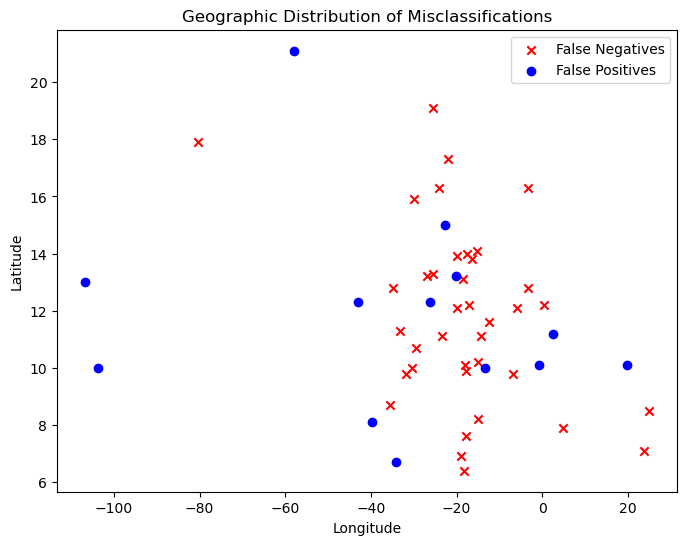

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(lon_false_neg, lat_false_neg, marker='x', color='red', label='False Negatives')
plt.scatter(lon_false_pos, lat_false_pos, marker='o', color='blue', label='False Positives')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographic Distribution of Misclassifications')
plt.legend()
plt.show()


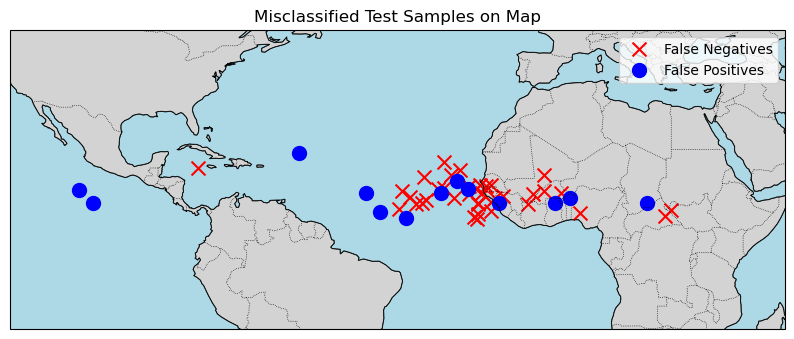

In [41]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())



lon_min, lon_max = np.min(lon_test)-15, np.max(lon_test)+15
lat_min, lat_max = np.min(lat_test)-15, np.max(lat_test)+15
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Plot misclassified points:
ax.scatter(lon_false_neg, lat_false_neg, color='red', marker='x', s=100,
           transform=ccrs.PlateCarree(), label='False Negatives')
ax.scatter(lon_false_pos, lat_false_pos, color='blue', marker='o', s=100,
           transform=ccrs.PlateCarree(), label='False Positives')

plt.title("Misclassified Test Samples on Map")
plt.legend()
plt.show()

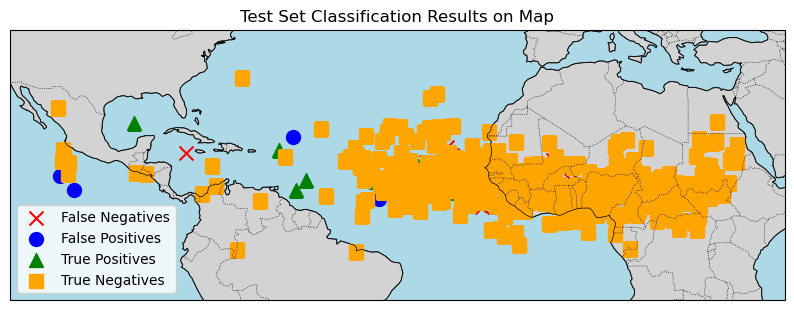

In [42]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set map extent (adjust margins as desired)
lon_min, lon_max = np.min(lon_test) - 10, np.max(lon_test) + 10
lat_min, lat_max = np.min(lat_test) - 10, np.max(lat_test) + 10
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='black')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
# Plot misclassified points
ax.scatter(lon_false_neg, lat_false_neg, color='red', marker='x', s=100,
           transform=ccrs.PlateCarree(), label='False Negatives')
ax.scatter(lon_false_pos, lat_false_pos, color='blue', marker='o', s=100,
           transform=ccrs.PlateCarree(), label='False Positives')



# Plot correctly classified points
ax.scatter(lon_true_pos, lat_true_pos, color='green', marker='^', s=100,
           transform=ccrs.PlateCarree(), label='True Positives')
ax.scatter(lon_true_neg, lat_true_neg, color='orange', marker='s', s=100,
           transform=ccrs.PlateCarree(), label='True Negatives')

plt.title("Test Set Classification Results on Map")
plt.legend()
plt.show()


In [43]:
print("Total samples:", len(sample_lat))
print("Unique latitudes:", len(np.unique(sample_lat)))
print("Unique longitudes:", len(np.unique(sample_lon)))


Total samples: 2750
Unique latitudes: 251
Unique longitudes: 913


In [44]:
print("First 10 latitudes:", sample_lat[:10])
print("First 10 longitudes:", sample_lon[:10])


First 10 latitudes: <xarray.DataArray 'lat_center' (sample: 10)> Size: 80B
dask.array<getitem, shape=(10,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
    file_name   (sample) <U102 4kB dask.array<chunksize=(10,), meta=np.ndarray>
    lat_center  (sample) float64 80B dask.array<chunksize=(10,), meta=np.ndarray>
    lon_center  (sample) float64 80B dask.array<chunksize=(10,), meta=np.ndarray>
  * sample      (sample) int64 80B 1 1 1 1 1 1 1 1 1 1
    time        (sample) datetime64[ns] 80B dask.array<chunksize=(10,), meta=np.ndarray>
First 10 longitudes: <xarray.DataArray 'lon_center' (sample: 10)> Size: 80B
dask.array<getitem, shape=(10,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
    file_name   (sample) <U102 4kB dask.array<chunksize=(10,), meta=np.ndarray>
    lat_center  (sample) float64 80B dask.array<chunksize=(10,), meta=np.ndarray>
    lon_center  (sample) float64 80B dask.array<chunksize=(10,), meta=np.ndarray>
  * sample 

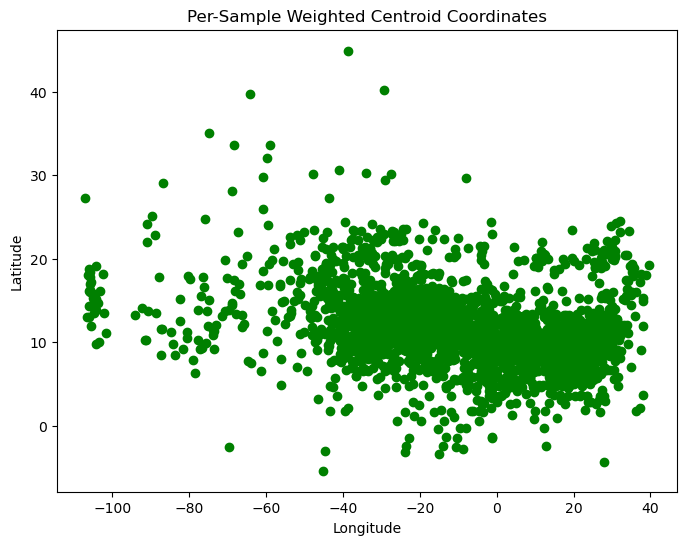

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(sample_lon, sample_lat, c='green', marker='o')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Per-Sample Weighted Centroid Coordinates')
plt.show()


In [46]:


# --- Permutation Importance ---
# Evaluate baseline performance using your loss metric (here, the custom f1_loss_sigmoid)
# model.metrics_names gives a list where index 0 is 'loss'
baseline_results = model.evaluate(input_test_scaled, label_test_scaled,
                                  batch_size=label_test_scaled.shape[0],
                                  verbose=0)
baseline_loss = baseline_results[model.metrics_names.index('loss')]
print("Baseline loss:", baseline_loss)

# Set the number of repetitions for averaging
n_repeats = 5
n_features = input_test_scaled.shape[-1]
permutation_importances = np.zeros(n_features)

# Loop over each feature (channel)
for feature_idx in range(n_features):
    permuted_losses = []
    for _ in range(n_repeats):
        # Copy the test set to avoid modifying the original
        X_permuted = np.copy(input_test_scaled)
        # Permute the values of the selected feature across samples
        perm = np.random.permutation(X_permuted.shape[0])
        X_permuted[:, :, :, feature_idx] = X_permuted[perm, :, :, feature_idx]
        
        # Evaluate the model on the permuted test set
        permuted_results = model.evaluate(X_permuted, label_test_scaled,
                                          batch_size=label_test_scaled.shape[0],
                                          verbose=0)
        permuted_loss = permuted_results[model.metrics_names.index('loss')]
        permuted_losses.append(permuted_loss)
    
    avg_permuted_loss = np.mean(permuted_losses)
    # The difference between the permuted loss and baseline loss indicates feature importance:
    # A larger increase means the feature is more important.
    permutation_importances[feature_idx] = avg_permuted_loss - baseline_loss
    print(f"Feature {feature_idx} - Increase in Loss: {permutation_importances[feature_idx]}")

print("Permutation Importances (increase in loss) for all features:", permutation_importances)


Baseline loss: 0.03349390625953674


Feature 0 - Increase in Loss: 0.004715110361576083


Feature 1 - Increase in Loss: -0.00024375468492508073


Feature 2 - Increase in Loss: -0.002545714750885962


Feature 3 - Increase in Loss: 0.0007435217499732957


Feature 4 - Increase in Loss: -0.0009351141750812558


Feature 5 - Increase in Loss: 0.0025802902877330794


Feature 6 - Increase in Loss: -0.0009573817253112765


Feature 7 - Increase in Loss: 0.0031945794820785536


Feature 8 - Increase in Loss: -6.476342678070346e-05


Feature 9 - Increase in Loss: 0.005100002139806749


Feature 10 - Increase in Loss: 0.003747970610857007


Feature 11 - Increase in Loss: 0.0004561096429824829


Feature 12 - Increase in Loss: 0.014733919501304628


Feature 13 - Increase in Loss: 0.0028750583529472337


Feature 14 - Increase in Loss: 0.0019755445420742007


Feature 15 - Increase in Loss: 0.0010679204016923877


Feature 16 - Increase in Loss: -0.0012192822992801652


Feature 17 - Increase in Loss: -0.0006378751248121289
Permutation Importances (increase in loss) for all features: [ 4.71511036e-03 -2.43754685e-04 -2.54571475e-03  7.43521750e-04
 -9.35114175e-04  2.58029029e-03 -9.57381725e-04  3.19457948e-03
 -6.47634268e-05  5.10000214e-03  3.74797061e-03  4.56109643e-04
  1.47339195e-02  2.87505835e-03  1.97554454e-03  1.06792040e-03
 -1.21928230e-03 -6.37875125e-04]


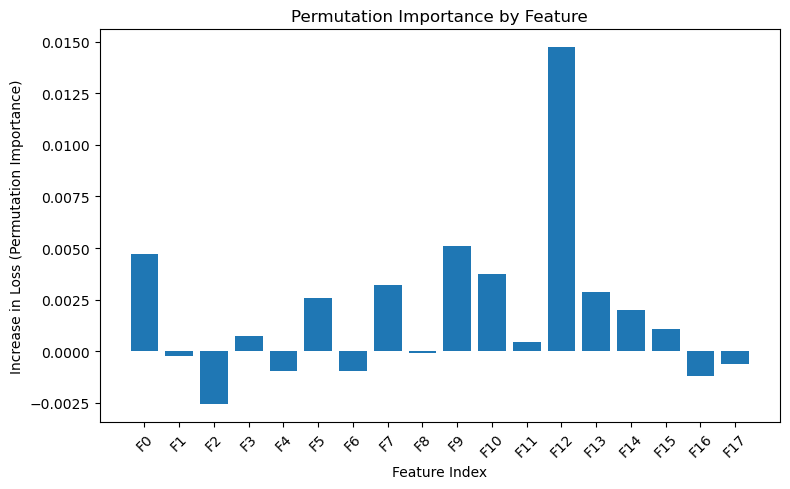

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Suppose permutation_importances is the numpy array you printed:
# e.g., [0.0820, 0.0824, 0.0815, 0.0864, 0.0121, ...]

feature_indices = np.arange(len(permutation_importances))

plt.figure(figsize=(8, 5))
plt.bar(feature_indices, permutation_importances)
plt.xlabel("Feature Index")
plt.ylabel("Increase in Loss (Permutation Importance)")
plt.title("Permutation Importance by Feature")
plt.xticks(feature_indices, [f"F{i}" for i in feature_indices], rotation=45)
plt.tight_layout()
plt.show()


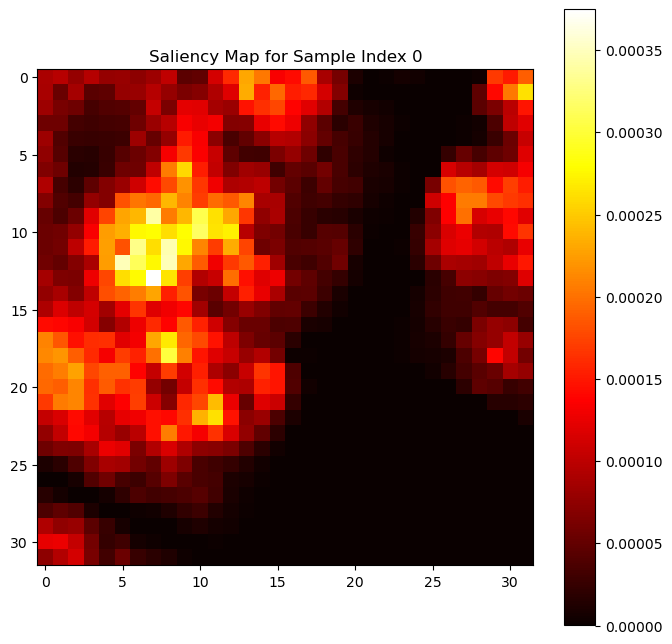

In [48]:
sample_index = 0
sample_input = input_test_scaled[sample_index:sample_index+1]

# Compute the saliency map for the selected test sample
saliency_map = compute_saliency_map(model, sample_input)

# Plot the saliency map
plt.figure(figsize=(8, 8))
plt.imshow(saliency_map, cmap='hot')
plt.colorbar()
plt.title(f"Saliency Map for Sample Index {sample_index}")
plt.show()



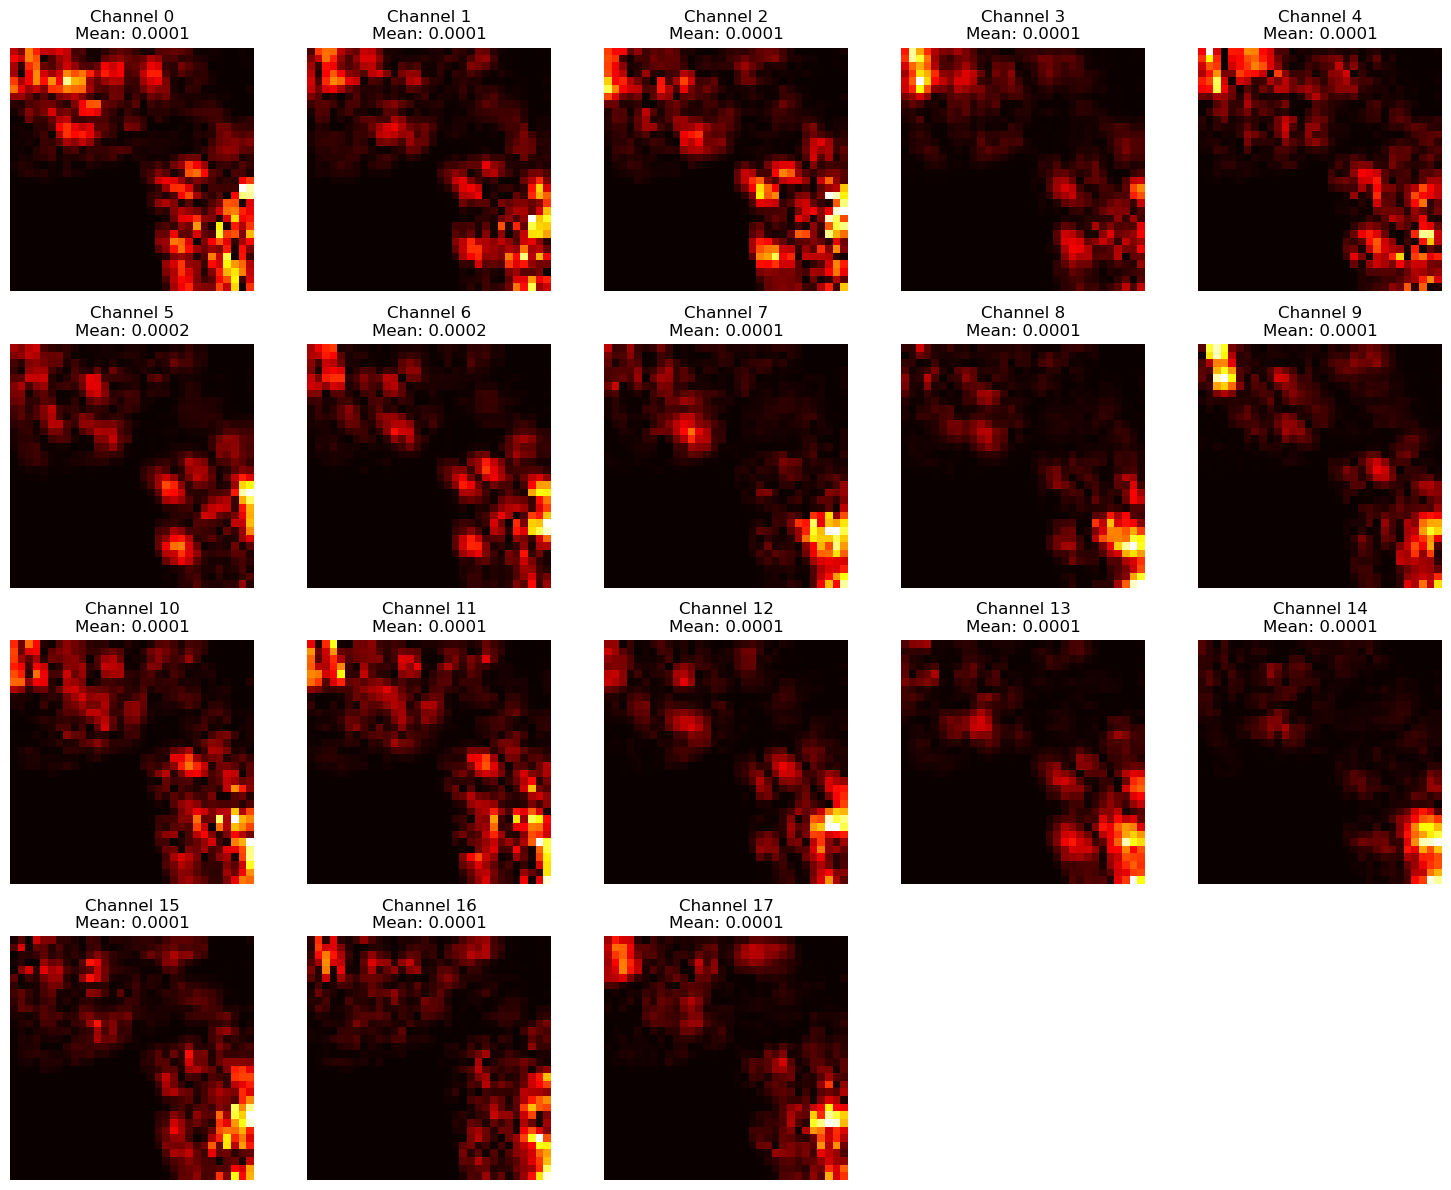

Channel importance (mean saliency per channel):
Channel 0: 0.0001
Channel 1: 0.0001
Channel 2: 0.0001
Channel 3: 0.0001
Channel 4: 0.0001
Channel 5: 0.0002
Channel 6: 0.0002
Channel 7: 0.0001
Channel 8: 0.0001
Channel 9: 0.0001
Channel 10: 0.0001
Channel 11: 0.0001
Channel 12: 0.0001
Channel 13: 0.0001
Channel 14: 0.0001
Channel 15: 0.0001
Channel 16: 0.0001
Channel 17: 0.0001


In [49]:
sample_index = 1
sample_input = input_test_scaled[sample_index:sample_index+1]

# Compute saliency maps per channel for the selected input sample
saliency_maps, channel_importance = compute_saliency_per_channel(model, sample_input)

# Plot the saliency maps for each channel
num_channels = saliency_maps.shape[-1]
cols = 5  # Set number of columns for plotting
rows = int(np.ceil(num_channels / cols))
plt.figure(figsize=(15, rows * 3))
for c in range(num_channels):
    plt.subplot(rows, cols, c + 1)
    plt.imshow(saliency_maps[:, :, c], cmap='hot')
    plt.title(f'Channel {c}\nMean: {channel_importance[c]:.4f}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Print aggregated channel importance values
print("Channel importance (mean saliency per channel):")
for c, imp in enumerate(channel_importance):
    print(f"Channel {c}: {imp:.4f}")


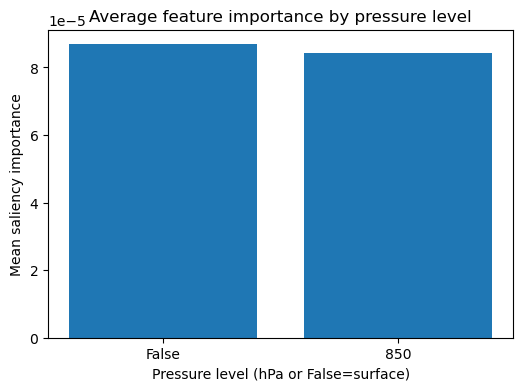

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Compute per‑sample, per‑channel saliency importances
all_imps = []
for x in input_test_scaled:             # each x has shape (32,32,channels)
    _, imp = compute_saliency_per_channel(best_model, x[np.newaxis,...])
    all_imps.append(imp)               # imp.shape == (channels,)
all_imps = np.stack(all_imps)          # shape (N_samples, channels)

# 2) Average importance across samples
mean_imp = all_imps.mean(axis=0)       # shape (channels,)

# 3) Build a DataFrame mapping feature→plevel→importance
df = pd.DataFrame({
    "feature": var_list,
    "plevel": plevel_list,
    "importance": mean_imp
})

# 4) Group by pressure level and plot
grouped = df.groupby("plevel")["importance"].mean().reset_index()
plt.figure(figsize=(6,4))
plt.bar(grouped["plevel"].astype(str), grouped["importance"])
plt.xlabel("Pressure level (hPa or False=surface)")
plt.ylabel("Mean saliency importance")
plt.title("Average feature importance by pressure level")
plt.show()


{'loss': 0.03349390625953674, 'compile_metrics': 0.2777739465236664}
    f1_score  val_f1_score
95  0.674009      0.342857
96  0.751131      0.210526
97  0.781395      0.272727
98  0.802850      0.285714
99  0.824940      0.000000


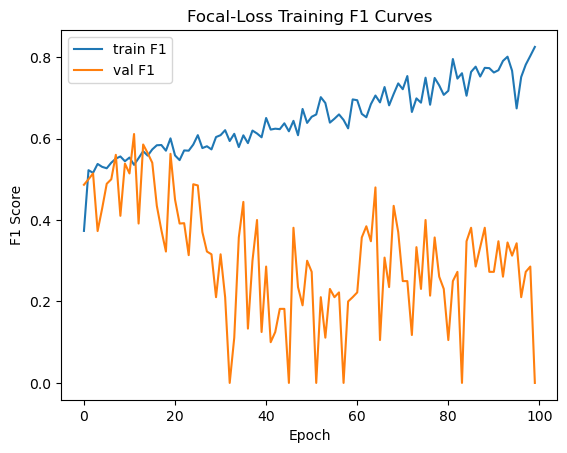

In [51]:
# 1) Print out full test‐set metrics by name
test_results = model.evaluate(
    input_test_scaled,
    label_test_scaled,
    batch_size=label_test_scaled.shape[0],
    verbose=0
)
print(dict(zip(model.metrics_names, test_results)))

# 2) Peek at the end of your training history for F1 improvements
import pandas as pd
hist_df = pd.DataFrame(history.history)
print(hist_df[['f1_score','val_f1_score']].tail())

# 3) (Optional) Plot train vs. val F1 over epochs
import matplotlib.pyplot as plt
plt.plot(hist_df['f1_score'],    label='train F1')
plt.plot(hist_df['val_f1_score'],label='val F1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.title('Focal‐Loss Training F1 Curves')
plt.show()


In [52]:
# Replace your rebuild logic:
# top_hps = tuner.get_best_hyperparameters(num_trials=5)
# models  = [MyHyperModel().build(hp) for hp in top_hps]

# With this single line:
models = tuner.get_best_models(num_models=5)

# Then stack and average as before:
all_preds     = np.stack([m.predict(input_test_scaled).flatten() for m in models], axis=0)
ensemble_probs= all_preds.mean(axis=0)
ensemble_preds= (ensemble_probs >= 0.5).astype(int)
print("Ensemble F1:", f1_score(label_test_scaled, ensemble_preds))


/glade/u/home/rmandava/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Ensemble F1: 0.4878048780487805
